In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype
def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
df_merge = reduce_mem_usage(pd.read_csv('./output/final_merge.csv'))
categorical_features = ['airconditioningtypeid', 'hashottuborspa', 'heatingorsystemtypeid', 
                       'pooltypeid2', 'propertylandusetypeid', 'fips', 'regionidcounty', 
                       'buildingqualitytypeid_fill', 'regionidcity_fill', 'year', 
                       'regionidneighborhood_fill', 'taxdelinquencyflag']

Memory usage of dataframe is 65.85 MB
Memory usage after optimization is: 26.09 MB
Decreased by 60.4%


In [4]:
from sklearn.model_selection import KFold
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
def check_rmse(outlier_list):
    score = 0
    params = {"objective": "regression", "boosting": "gbdt", "num_leaves": 512, 
              "learning_rate": 0.0021, 'bagging_fraction': 0.85, "reg_lambda": 0.1, 
              'reg_alpha':0.1, "metric": "rmse", 'max_depth': -1, 'min_child_weight': 30,
              'verbose': -1, 'min_split_gain':0.1, 'subsample_freq':1, 'sub_feature':  0.5}
    kf = KFold(n_splits=3)
    feature_list = list(df_merge.columns)
    df = df_merge.loc[df_merge.logerror >= - (outlier_list[0]),:]
    df = df.loc[df.logerror <= outlier_list[1],:].reset_index()
    df = df[feature_list]
    feature = df.drop(['logerror'], axis = 1)
    target = df.logerror
    for train_index,test_index in kf.split(feature):
        train_features = feature.loc[train_index]
        train_target = target.loc[train_index]

        test_features = feature.loc[test_index]
        test_target = target.loc[test_index]

        d_training = lgb.Dataset(train_features, label=train_target,
                                 categorical_feature=categorical_features, free_raw_data=False)
        d_test = lgb.Dataset(test_features, label=test_target,
                             categorical_feature=categorical_features, free_raw_data=False)

        model = lgb.train(params, train_set=d_training, num_boost_round=3000, 
                          valid_sets=[d_training,d_test], verbose_eval=25, early_stopping_rounds=50)
        y_pred_valid = model.predict(test_features)
        score += np.sqrt(mean_squared_error(test_target, y_pred_valid)) / 3
    return score

In [5]:
from itertools import combinations
import json
outlier_lists = [0.33, 0.35, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52,0.54, 0.56, 0.58, 0.6]
outlier_dict = {str([10, 10]): check_rmse([50,50])}
for i in outlier_lists:
    outlier_dict[str([i,i])] = check_rmse([i,i])
for i in combinations(outlier_lists, 2):
    outlier_dict[str(list(i))] = check_rmse(list(i))
    j = [i[1], i[0]]
    outlier_dict[str(list(j))] = check_rmse(list(j))
outlier_df = pd.DataFrame.from_dict(outlier_dict, orient = 'index')
outlier_df = outlier_df.reset_index().rename(columns = {'index': 'outlier_list', 0: 'rmse'})
outlier_df.outlier_list = outlier_df.outlier_list.apply(json.loads)
outlier_df.to_csv('./output/plot_csv/outlier_strategy.csv', index = False)

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.164597	valid_1's rmse: 0.163109
[50]	training's rmse: 0.164029	valid_1's rmse: 0.163035
[75]	training's rmse: 0.163465	valid_1's rmse: 0.162965
[100]	training's rmse: 0.162933	valid_1's rmse: 0.162903
[125]	training's rmse: 0.162399	valid_1's rmse: 0.162843
[150]	training's rmse: 0.161902	valid_1's rmse: 0.162783
[175]	training's rmse: 0.161453	valid_1's rmse: 0.16274
[200]	training's rmse: 0.16098	valid_1's rmse: 0.162691
[225]	training's rmse: 0.160528	valid_1's rmse: 0.162655
[250]	training's rmse: 0.160117	valid_1's rmse: 0.162617
[275]	training's rmse: 0.15973	valid_1's rmse: 0.162588
[300]	training's rmse: 0.159345	valid_1's rmse: 0.162557
[325]	training's rmse: 0.158977	valid_1's rmse: 0.162529
[350]	training's rmse: 0.158621	valid_1's rmse: 0.16251
[375]	training's rmse: 0.158292	valid_1's rmse: 0.162492
[400]	training's rmse: 0.157934	valid_1's rmse: 0.162471
[425]	training's rmse: 0.157616	va

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.167706	valid_1's rmse: 0.156582
[50]	training's rmse: 0.167154	valid_1's rmse: 0.156498
[75]	training's rmse: 0.166601	valid_1's rmse: 0.156417
[100]	training's rmse: 0.166072	valid_1's rmse: 0.156352
[125]	training's rmse: 0.165526	valid_1's rmse: 0.156287
[150]	training's rmse: 0.165027	valid_1's rmse: 0.156231
[175]	training's rmse: 0.164565	valid_1's rmse: 0.15618
[200]	training's rmse: 0.164083	valid_1's rmse: 0.15614
[225]	training's rmse: 0.16361	valid_1's rmse: 0.156102
[250]	training's rmse: 0.163197	valid_1's rmse: 0.156071
[275]	training's rmse: 0.1628	valid_1's rmse: 0.156042
[300]	training's rmse: 0.162396	valid_1's rmse: 0.156013
[325]	training's rmse: 0.161995	valid_1's rmse: 0.155992
[350]	training's rmse: 0.161617	valid_1's rmse: 0.155974
[375]	training's rmse: 0.161275	valid_1's rmse: 0.155958
[400]	training's rmse: 0.160933	valid_1's rmse: 0.155945
[425]	training's rmse: 0.160611	val

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.159463	valid_1's rmse: 0.173348
[50]	training's rmse: 0.159069	valid_1's rmse: 0.173295
[75]	training's rmse: 0.158663	valid_1's rmse: 0.173244
[100]	training's rmse: 0.158273	valid_1's rmse: 0.173195
[125]	training's rmse: 0.157887	valid_1's rmse: 0.17315
[150]	training's rmse: 0.157521	valid_1's rmse: 0.173107
[175]	training's rmse: 0.157198	valid_1's rmse: 0.173076
[200]	training's rmse: 0.156853	valid_1's rmse: 0.173047
[225]	training's rmse: 0.156532	valid_1's rmse: 0.173017
[250]	training's rmse: 0.156226	valid_1's rmse: 0.17299
[275]	training's rmse: 0.155952	valid_1's rmse: 0.172969
[300]	training's rmse: 0.155668	valid_1's rmse: 0.172948
[325]	training's rmse: 0.155389	valid_1's rmse: 0.172928
[350]	training's rmse: 0.155123	valid_1's rmse: 0.172913
[375]	training's rmse: 0.154887	valid_1's rmse: 0.172899
[400]	training's rmse: 0.15464	valid_1's rmse: 0.172889
[425]	training's rmse: 0.154405	v

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0743715	valid_1's rmse: 0.0764297
[50]	training's rmse: 0.0742675	valid_1's rmse: 0.0763861
[75]	training's rmse: 0.0741627	valid_1's rmse: 0.0763423
[100]	training's rmse: 0.0740673	valid_1's rmse: 0.0763038
[125]	training's rmse: 0.0739698	valid_1's rmse: 0.0762665
[150]	training's rmse: 0.0738794	valid_1's rmse: 0.0762311
[175]	training's rmse: 0.0738092	valid_1's rmse: 0.0762015
[200]	training's rmse: 0.0737294	valid_1's rmse: 0.0761724
[225]	training's rmse: 0.0736479	valid_1's rmse: 0.0761429
[250]	training's rmse: 0.0735828	valid_1's rmse: 0.0761149
[275]	training's rmse: 0.0735212	valid_1's rmse: 0.0760914
[300]	training's rmse: 0.0734612	valid_1's rmse: 0.0760698
[325]	training's rmse: 0.0734015	valid_1's rmse: 0.0760491
[350]	training's rmse: 0.0733429	valid_1's rmse: 0.0760289
[375]	training's rmse: 0.0732953	valid_1's rmse: 0.0760123
[400]	training's rmse: 0.0732405	valid_1's rmse: 0.075995

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.074623	valid_1's rmse: 0.0759488
[50]	training's rmse: 0.0745323	valid_1's rmse: 0.0759003
[75]	training's rmse: 0.0744399	valid_1's rmse: 0.0758531
[100]	training's rmse: 0.0743553	valid_1's rmse: 0.0758113
[125]	training's rmse: 0.0742668	valid_1's rmse: 0.0757685
[150]	training's rmse: 0.0741857	valid_1's rmse: 0.0757298
[175]	training's rmse: 0.0741195	valid_1's rmse: 0.0756971
[200]	training's rmse: 0.0740436	valid_1's rmse: 0.075663
[225]	training's rmse: 0.0739703	valid_1's rmse: 0.0756316
[250]	training's rmse: 0.0739102	valid_1's rmse: 0.0756035
[275]	training's rmse: 0.073854	valid_1's rmse: 0.0755771
[300]	training's rmse: 0.0737979	valid_1's rmse: 0.0755524
[325]	training's rmse: 0.0737403	valid_1's rmse: 0.0755277
[350]	training's rmse: 0.0736843	valid_1's rmse: 0.0755048
[375]	training's rmse: 0.0736391	valid_1's rmse: 0.0754851
[400]	training's rmse: 0.0735887	valid_1's rmse: 0.0754658
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0760853	valid_1's rmse: 0.0729655
[50]	training's rmse: 0.075994	valid_1's rmse: 0.0729207
[75]	training's rmse: 0.0758984	valid_1's rmse: 0.0728777
[100]	training's rmse: 0.0758118	valid_1's rmse: 0.0728379
[125]	training's rmse: 0.0757254	valid_1's rmse: 0.072801
[150]	training's rmse: 0.0756425	valid_1's rmse: 0.0727648
[175]	training's rmse: 0.0755762	valid_1's rmse: 0.0727364
[200]	training's rmse: 0.0755021	valid_1's rmse: 0.0727066
[225]	training's rmse: 0.0754291	valid_1's rmse: 0.0726776
[250]	training's rmse: 0.0753719	valid_1's rmse: 0.0726534
[275]	training's rmse: 0.0753189	valid_1's rmse: 0.0726306
[300]	training's rmse: 0.0752641	valid_1's rmse: 0.0726092
[325]	training's rmse: 0.0752074	valid_1's rmse: 0.0725894
[350]	training's rmse: 0.075154	valid_1's rmse: 0.0725699
[375]	training's rmse: 0.075109	valid_1's rmse: 0.0725534
[400]	training's rmse: 0.0750601	valid_1's rmse: 0.0725439
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0763841	valid_1's rmse: 0.0784612
[50]	training's rmse: 0.0762742	valid_1's rmse: 0.0784147
[75]	training's rmse: 0.0761673	valid_1's rmse: 0.0783687
[100]	training's rmse: 0.0760679	valid_1's rmse: 0.0783285
[125]	training's rmse: 0.0759666	valid_1's rmse: 0.0782882
[150]	training's rmse: 0.0758766	valid_1's rmse: 0.0782517
[175]	training's rmse: 0.0758024	valid_1's rmse: 0.0782193
[200]	training's rmse: 0.0757204	valid_1's rmse: 0.0781874
[225]	training's rmse: 0.0756394	valid_1's rmse: 0.0781582
[250]	training's rmse: 0.0755705	valid_1's rmse: 0.0781297
[275]	training's rmse: 0.0755075	valid_1's rmse: 0.0781056
[300]	training's rmse: 0.0754453	valid_1's rmse: 0.0780827
[325]	training's rmse: 0.0753837	valid_1's rmse: 0.0780607
[350]	training's rmse: 0.075323	valid_1's rmse: 0.0780391
[375]	training's rmse: 0.0752743	valid_1's rmse: 0.0780204
[400]	training's rmse: 0.0752184	valid_1's rmse: 0.0780028

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0766615	valid_1's rmse: 0.077933
[50]	training's rmse: 0.076563	valid_1's rmse: 0.0778842
[75]	training's rmse: 0.0764619	valid_1's rmse: 0.0778369
[100]	training's rmse: 0.0763707	valid_1's rmse: 0.077794
[125]	training's rmse: 0.0762752	valid_1's rmse: 0.0777512
[150]	training's rmse: 0.0761878	valid_1's rmse: 0.0777117
[175]	training's rmse: 0.0761169	valid_1's rmse: 0.0776789
[200]	training's rmse: 0.076038	valid_1's rmse: 0.0776451
[225]	training's rmse: 0.0759634	valid_1's rmse: 0.077614
[250]	training's rmse: 0.0758982	valid_1's rmse: 0.0775847
[275]	training's rmse: 0.075839	valid_1's rmse: 0.0775578
[300]	training's rmse: 0.0757793	valid_1's rmse: 0.0775342
[325]	training's rmse: 0.0757167	valid_1's rmse: 0.0775094
[350]	training's rmse: 0.0756565	valid_1's rmse: 0.0774863
[375]	training's rmse: 0.0756073	valid_1's rmse: 0.077467
[400]	training's rmse: 0.0755551	valid_1's rmse: 0.0774489
[425]

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0780904	valid_1's rmse: 0.0750236
[50]	training's rmse: 0.0779954	valid_1's rmse: 0.0749833
[75]	training's rmse: 0.0778963	valid_1's rmse: 0.0749391
[100]	training's rmse: 0.077809	valid_1's rmse: 0.0749011
[125]	training's rmse: 0.0777177	valid_1's rmse: 0.0748615
[150]	training's rmse: 0.0776323	valid_1's rmse: 0.0748263
[175]	training's rmse: 0.0775626	valid_1's rmse: 0.0747991
[200]	training's rmse: 0.0774845	valid_1's rmse: 0.0747698
[225]	training's rmse: 0.0774089	valid_1's rmse: 0.07474
[250]	training's rmse: 0.0773473	valid_1's rmse: 0.0747137
[275]	training's rmse: 0.0772897	valid_1's rmse: 0.07469
[300]	training's rmse: 0.0772332	valid_1's rmse: 0.074668
[325]	training's rmse: 0.0771754	valid_1's rmse: 0.0746483
[350]	training's rmse: 0.0771192	valid_1's rmse: 0.0746287
[375]	training's rmse: 0.0770732	valid_1's rmse: 0.0746111
[400]	training's rmse: 0.0770222	valid_1's rmse: 0.0745993
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.07894	valid_1's rmse: 0.0811399
[50]	training's rmse: 0.0788206	valid_1's rmse: 0.0810909
[75]	training's rmse: 0.0787006	valid_1's rmse: 0.0810434
[100]	training's rmse: 0.0785902	valid_1's rmse: 0.0810003
[125]	training's rmse: 0.0784781	valid_1's rmse: 0.0809578
[150]	training's rmse: 0.0783725	valid_1's rmse: 0.080918
[175]	training's rmse: 0.0782887	valid_1's rmse: 0.0808843
[200]	training's rmse: 0.0781978	valid_1's rmse: 0.0808507
[225]	training's rmse: 0.078107	valid_1's rmse: 0.0808192
[250]	training's rmse: 0.0780313	valid_1's rmse: 0.0807896
[275]	training's rmse: 0.0779625	valid_1's rmse: 0.080764
[300]	training's rmse: 0.0778908	valid_1's rmse: 0.0807402
[325]	training's rmse: 0.0778208	valid_1's rmse: 0.0807175
[350]	training's rmse: 0.077753	valid_1's rmse: 0.0806944
[375]	training's rmse: 0.0776956	valid_1's rmse: 0.0806744
[400]	training's rmse: 0.0776349	valid_1's rmse: 0.0806554
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0792144	valid_1's rmse: 0.0806242
[50]	training's rmse: 0.0791094	valid_1's rmse: 0.0805736
[75]	training's rmse: 0.0790026	valid_1's rmse: 0.0805233
[100]	training's rmse: 0.0789068	valid_1's rmse: 0.0804777
[125]	training's rmse: 0.0788056	valid_1's rmse: 0.0804325
[150]	training's rmse: 0.078715	valid_1's rmse: 0.0803909
[175]	training's rmse: 0.0786393	valid_1's rmse: 0.0803569
[200]	training's rmse: 0.0785568	valid_1's rmse: 0.0803221
[225]	training's rmse: 0.0784768	valid_1's rmse: 0.0802891
[250]	training's rmse: 0.0784082	valid_1's rmse: 0.0802602
[275]	training's rmse: 0.0783441	valid_1's rmse: 0.0802328
[300]	training's rmse: 0.078281	valid_1's rmse: 0.0802077
[325]	training's rmse: 0.0782153	valid_1's rmse: 0.080182
[350]	training's rmse: 0.0781524	valid_1's rmse: 0.0801584
[375]	training's rmse: 0.0781012	valid_1's rmse: 0.0801373
[400]	training's rmse: 0.0780457	valid_1's rmse: 0.0801183
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0807656	valid_1's rmse: 0.0774671
[50]	training's rmse: 0.0806631	valid_1's rmse: 0.0774234
[75]	training's rmse: 0.0805553	valid_1's rmse: 0.0773786
[100]	training's rmse: 0.0804617	valid_1's rmse: 0.0773391
[125]	training's rmse: 0.0803654	valid_1's rmse: 0.0773004
[150]	training's rmse: 0.0802766	valid_1's rmse: 0.0772639
[175]	training's rmse: 0.0802011	valid_1's rmse: 0.0772341
[200]	training's rmse: 0.0801182	valid_1's rmse: 0.0772031
[225]	training's rmse: 0.0800392	valid_1's rmse: 0.0771727
[250]	training's rmse: 0.0799732	valid_1's rmse: 0.0771467
[275]	training's rmse: 0.07991	valid_1's rmse: 0.0771224
[300]	training's rmse: 0.0798495	valid_1's rmse: 0.0770994
[325]	training's rmse: 0.0797864	valid_1's rmse: 0.0770776
[350]	training's rmse: 0.0797254	valid_1's rmse: 0.0770557
[375]	training's rmse: 0.0796749	valid_1's rmse: 0.0770393
[400]	training's rmse: 0.0796222	valid_1's rmse: 0.0770324


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0806374	valid_1's rmse: 0.082837
[50]	training's rmse: 0.0805156	valid_1's rmse: 0.0827885
[75]	training's rmse: 0.0803965	valid_1's rmse: 0.0827415
[100]	training's rmse: 0.0802865	valid_1's rmse: 0.0827
[125]	training's rmse: 0.0801723	valid_1's rmse: 0.0826598
[150]	training's rmse: 0.0800673	valid_1's rmse: 0.0826225
[175]	training's rmse: 0.0799832	valid_1's rmse: 0.0825891
[200]	training's rmse: 0.0798906	valid_1's rmse: 0.0825557
[225]	training's rmse: 0.0798021	valid_1's rmse: 0.0825244
[250]	training's rmse: 0.0797265	valid_1's rmse: 0.0824945
[275]	training's rmse: 0.0796544	valid_1's rmse: 0.0824684
[300]	training's rmse: 0.0795845	valid_1's rmse: 0.0824434
[325]	training's rmse: 0.0795122	valid_1's rmse: 0.0824206
[350]	training's rmse: 0.0794458	valid_1's rmse: 0.082398
[375]	training's rmse: 0.0793898	valid_1's rmse: 0.0823786
[400]	training's rmse: 0.0793284	valid_1's rmse: 0.0823595
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0808419	valid_1's rmse: 0.0824542
[50]	training's rmse: 0.0807369	valid_1's rmse: 0.0824033
[75]	training's rmse: 0.0806251	valid_1's rmse: 0.0823531
[100]	training's rmse: 0.0805243	valid_1's rmse: 0.0823092
[125]	training's rmse: 0.0804233	valid_1's rmse: 0.0822651
[150]	training's rmse: 0.080328	valid_1's rmse: 0.0822229
[175]	training's rmse: 0.080252	valid_1's rmse: 0.082189
[200]	training's rmse: 0.0801671	valid_1's rmse: 0.0821547
[225]	training's rmse: 0.080083	valid_1's rmse: 0.0821212
[250]	training's rmse: 0.0800126	valid_1's rmse: 0.0820912
[275]	training's rmse: 0.0799451	valid_1's rmse: 0.0820635
[300]	training's rmse: 0.0798813	valid_1's rmse: 0.0820384
[325]	training's rmse: 0.0798115	valid_1's rmse: 0.0820125
[350]	training's rmse: 0.0797468	valid_1's rmse: 0.0819895
[375]	training's rmse: 0.0796961	valid_1's rmse: 0.0819693
[400]	training's rmse: 0.0796384	valid_1's rmse: 0.08195
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0825331	valid_1's rmse: 0.0790181
[50]	training's rmse: 0.0824295	valid_1's rmse: 0.0789723
[75]	training's rmse: 0.0823236	valid_1's rmse: 0.0789272
[100]	training's rmse: 0.0822269	valid_1's rmse: 0.0788863
[125]	training's rmse: 0.0821246	valid_1's rmse: 0.0788467
[150]	training's rmse: 0.0820324	valid_1's rmse: 0.0788092
[175]	training's rmse: 0.081958	valid_1's rmse: 0.0787795
[200]	training's rmse: 0.0818759	valid_1's rmse: 0.0787501
[225]	training's rmse: 0.0817958	valid_1's rmse: 0.0787236
[250]	training's rmse: 0.0817283	valid_1's rmse: 0.0786969
[275]	training's rmse: 0.081666	valid_1's rmse: 0.0786737
[300]	training's rmse: 0.0816039	valid_1's rmse: 0.078652
[325]	training's rmse: 0.0815408	valid_1's rmse: 0.0786298
[350]	training's rmse: 0.0814793	valid_1's rmse: 0.0786096
[375]	training's rmse: 0.08143	valid_1's rmse: 0.0785912
[400]	training's rmse: 0.0813728	valid_1's rmse: 0.0785794
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0821672	valid_1's rmse: 0.0847222
[50]	training's rmse: 0.082041	valid_1's rmse: 0.0846729
[75]	training's rmse: 0.0819149	valid_1's rmse: 0.0846224
[100]	training's rmse: 0.0818001	valid_1's rmse: 0.0845797
[125]	training's rmse: 0.0816829	valid_1's rmse: 0.0845364
[150]	training's rmse: 0.0815774	valid_1's rmse: 0.0844964
[175]	training's rmse: 0.0814879	valid_1's rmse: 0.0844611
[200]	training's rmse: 0.0813949	valid_1's rmse: 0.0844272
[225]	training's rmse: 0.0813016	valid_1's rmse: 0.0843954
[250]	training's rmse: 0.0812251	valid_1's rmse: 0.0843665
[275]	training's rmse: 0.0811517	valid_1's rmse: 0.0843399
[300]	training's rmse: 0.0810785	valid_1's rmse: 0.0843142
[325]	training's rmse: 0.0810066	valid_1's rmse: 0.0842893
[350]	training's rmse: 0.0809383	valid_1's rmse: 0.0842664
[375]	training's rmse: 0.0808782	valid_1's rmse: 0.084247
[400]	training's rmse: 0.080812	valid_1's rmse: 0.0842264
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0825119	valid_1's rmse: 0.0840657
[50]	training's rmse: 0.0823983	valid_1's rmse: 0.084013
[75]	training's rmse: 0.0822812	valid_1's rmse: 0.0839603
[100]	training's rmse: 0.0821763	valid_1's rmse: 0.0839129
[125]	training's rmse: 0.0820672	valid_1's rmse: 0.0838673
[150]	training's rmse: 0.0819688	valid_1's rmse: 0.0838237
[175]	training's rmse: 0.0818875	valid_1's rmse: 0.0837888
[200]	training's rmse: 0.0817991	valid_1's rmse: 0.0837526
[225]	training's rmse: 0.0817137	valid_1's rmse: 0.0837205
[250]	training's rmse: 0.0816417	valid_1's rmse: 0.08369
[275]	training's rmse: 0.0815744	valid_1's rmse: 0.083664
[300]	training's rmse: 0.0815065	valid_1's rmse: 0.0836371
[325]	training's rmse: 0.0814375	valid_1's rmse: 0.0836107
[350]	training's rmse: 0.0813705	valid_1's rmse: 0.0835866
[375]	training's rmse: 0.0813155	valid_1's rmse: 0.0835658
[400]	training's rmse: 0.0812554	valid_1's rmse: 0.0835464
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0842803	valid_1's rmse: 0.0804783
[50]	training's rmse: 0.0841723	valid_1's rmse: 0.0804326
[75]	training's rmse: 0.084061	valid_1's rmse: 0.080386
[100]	training's rmse: 0.08396	valid_1's rmse: 0.0803456
[125]	training's rmse: 0.0838587	valid_1's rmse: 0.0803052
[150]	training's rmse: 0.0837607	valid_1's rmse: 0.0802667
[175]	training's rmse: 0.0836817	valid_1's rmse: 0.080236
[200]	training's rmse: 0.0835968	valid_1's rmse: 0.0802062
[225]	training's rmse: 0.0835123	valid_1's rmse: 0.0801769
[250]	training's rmse: 0.0834438	valid_1's rmse: 0.0801526
[275]	training's rmse: 0.0833798	valid_1's rmse: 0.0801285
[300]	training's rmse: 0.0833155	valid_1's rmse: 0.0801051
[325]	training's rmse: 0.0832484	valid_1's rmse: 0.0800822
[350]	training's rmse: 0.0831858	valid_1's rmse: 0.0800613
[375]	training's rmse: 0.0831314	valid_1's rmse: 0.0800447
[400]	training's rmse: 0.0830737	valid_1's rmse: 0.0800322
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0837883	valid_1's rmse: 0.0862195
[50]	training's rmse: 0.0836631	valid_1's rmse: 0.0861682
[75]	training's rmse: 0.0835377	valid_1's rmse: 0.0861163
[100]	training's rmse: 0.0834239	valid_1's rmse: 0.0860728
[125]	training's rmse: 0.0833052	valid_1's rmse: 0.0860271
[150]	training's rmse: 0.0831956	valid_1's rmse: 0.0859852
[175]	training's rmse: 0.0831078	valid_1's rmse: 0.0859493
[200]	training's rmse: 0.0830131	valid_1's rmse: 0.0859137
[225]	training's rmse: 0.0829215	valid_1's rmse: 0.085881
[250]	training's rmse: 0.0828393	valid_1's rmse: 0.0858499
[275]	training's rmse: 0.0827637	valid_1's rmse: 0.0858222
[300]	training's rmse: 0.0826927	valid_1's rmse: 0.0857937
[325]	training's rmse: 0.082624	valid_1's rmse: 0.0857694
[350]	training's rmse: 0.0825556	valid_1's rmse: 0.0857439
[375]	training's rmse: 0.0824948	valid_1's rmse: 0.0857238
[400]	training's rmse: 0.0824295	valid_1's rmse: 0.0857025


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0838935	valid_1's rmse: 0.0860316
[50]	training's rmse: 0.0837777	valid_1's rmse: 0.0859779
[75]	training's rmse: 0.0836582	valid_1's rmse: 0.0859273
[100]	training's rmse: 0.0835525	valid_1's rmse: 0.0858829
[125]	training's rmse: 0.0834442	valid_1's rmse: 0.0858364
[150]	training's rmse: 0.0833412	valid_1's rmse: 0.0857926
[175]	training's rmse: 0.0832568	valid_1's rmse: 0.0857574
[200]	training's rmse: 0.0831663	valid_1's rmse: 0.0857207
[225]	training's rmse: 0.0830789	valid_1's rmse: 0.0856882
[250]	training's rmse: 0.0830018	valid_1's rmse: 0.0856575
[275]	training's rmse: 0.0829331	valid_1's rmse: 0.0856291
[300]	training's rmse: 0.0828596	valid_1's rmse: 0.0856031
[325]	training's rmse: 0.082789	valid_1's rmse: 0.0855777
[350]	training's rmse: 0.0827222	valid_1's rmse: 0.0855542
[375]	training's rmse: 0.0826661	valid_1's rmse: 0.0855337
[400]	training's rmse: 0.0826045	valid_1's rmse: 0.0855131

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0860096	valid_1's rmse: 0.0817365
[50]	training's rmse: 0.0859008	valid_1's rmse: 0.081691
[75]	training's rmse: 0.0857876	valid_1's rmse: 0.0816456
[100]	training's rmse: 0.0856845	valid_1's rmse: 0.0816052
[125]	training's rmse: 0.0855803	valid_1's rmse: 0.0815664
[150]	training's rmse: 0.0854817	valid_1's rmse: 0.0815286
[175]	training's rmse: 0.0854023	valid_1's rmse: 0.0814981
[200]	training's rmse: 0.0853146	valid_1's rmse: 0.0814678
[225]	training's rmse: 0.0852299	valid_1's rmse: 0.0814388
[250]	training's rmse: 0.0851583	valid_1's rmse: 0.0814132
[275]	training's rmse: 0.0850938	valid_1's rmse: 0.081389
[300]	training's rmse: 0.0850289	valid_1's rmse: 0.0813656
[325]	training's rmse: 0.0849636	valid_1's rmse: 0.0813446
[350]	training's rmse: 0.084898	valid_1's rmse: 0.0813242
[375]	training's rmse: 0.0848465	valid_1's rmse: 0.0813062
[400]	training's rmse: 0.084789	valid_1's rmse: 0.0812888
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0850135	valid_1's rmse: 0.0874835
[50]	training's rmse: 0.0848827	valid_1's rmse: 0.0874305
[75]	training's rmse: 0.0847543	valid_1's rmse: 0.0873778
[100]	training's rmse: 0.0846379	valid_1's rmse: 0.0873337
[125]	training's rmse: 0.0845188	valid_1's rmse: 0.0872881
[150]	training's rmse: 0.0844078	valid_1's rmse: 0.087245
[175]	training's rmse: 0.0843193	valid_1's rmse: 0.0872087
[200]	training's rmse: 0.0842236	valid_1's rmse: 0.0871715
[225]	training's rmse: 0.0841297	valid_1's rmse: 0.0871362
[250]	training's rmse: 0.084051	valid_1's rmse: 0.0871037
[275]	training's rmse: 0.0839753	valid_1's rmse: 0.0870761
[300]	training's rmse: 0.0839012	valid_1's rmse: 0.0870486
[325]	training's rmse: 0.0838291	valid_1's rmse: 0.0870225
[350]	training's rmse: 0.0837588	valid_1's rmse: 0.0869985
[375]	training's rmse: 0.0836981	valid_1's rmse: 0.0869781
[400]	training's rmse: 0.0836349	valid_1's rmse: 0.0869576


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0850389	valid_1's rmse: 0.0874452
[50]	training's rmse: 0.0849229	valid_1's rmse: 0.0873938
[75]	training's rmse: 0.0848008	valid_1's rmse: 0.0873422
[100]	training's rmse: 0.0846928	valid_1's rmse: 0.0872959
[125]	training's rmse: 0.0845806	valid_1's rmse: 0.0872497
[150]	training's rmse: 0.0844769	valid_1's rmse: 0.0872049
[175]	training's rmse: 0.0843933	valid_1's rmse: 0.0871697
[200]	training's rmse: 0.0842999	valid_1's rmse: 0.087134
[225]	training's rmse: 0.0842089	valid_1's rmse: 0.0870992
[250]	training's rmse: 0.0841322	valid_1's rmse: 0.0870696
[275]	training's rmse: 0.0840647	valid_1's rmse: 0.0870431
[300]	training's rmse: 0.0839943	valid_1's rmse: 0.0870155
[325]	training's rmse: 0.083923	valid_1's rmse: 0.0869901
[350]	training's rmse: 0.0838537	valid_1's rmse: 0.086966
[375]	training's rmse: 0.083797	valid_1's rmse: 0.086944
[400]	training's rmse: 0.0837362	valid_1's rmse: 0.0869234
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0873444	valid_1's rmse: 0.0827636
[50]	training's rmse: 0.0872318	valid_1's rmse: 0.0827156
[75]	training's rmse: 0.0871171	valid_1's rmse: 0.0826704
[100]	training's rmse: 0.0870124	valid_1's rmse: 0.0826297
[125]	training's rmse: 0.0869038	valid_1's rmse: 0.08259
[150]	training's rmse: 0.086805	valid_1's rmse: 0.0825541
[175]	training's rmse: 0.0867235	valid_1's rmse: 0.082524
[200]	training's rmse: 0.0866313	valid_1's rmse: 0.0824939
[225]	training's rmse: 0.0865452	valid_1's rmse: 0.0824637
[250]	training's rmse: 0.0864737	valid_1's rmse: 0.0824419
[275]	training's rmse: 0.086408	valid_1's rmse: 0.0824185
[300]	training's rmse: 0.0863415	valid_1's rmse: 0.0823963
[325]	training's rmse: 0.0862731	valid_1's rmse: 0.0823732
[350]	training's rmse: 0.0862071	valid_1's rmse: 0.0823526
[375]	training's rmse: 0.0861526	valid_1's rmse: 0.0823358
[400]	training's rmse: 0.0860933	valid_1's rmse: 0.0823257
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0863327	valid_1's rmse: 0.0889052
[50]	training's rmse: 0.086202	valid_1's rmse: 0.0888535
[75]	training's rmse: 0.0860709	valid_1's rmse: 0.0888002
[100]	training's rmse: 0.0859515	valid_1's rmse: 0.088753
[125]	training's rmse: 0.0858279	valid_1's rmse: 0.088706
[150]	training's rmse: 0.0857163	valid_1's rmse: 0.0886627
[175]	training's rmse: 0.0856257	valid_1's rmse: 0.0886262
[200]	training's rmse: 0.0855248	valid_1's rmse: 0.0885888
[225]	training's rmse: 0.0854287	valid_1's rmse: 0.0885531
[250]	training's rmse: 0.0853458	valid_1's rmse: 0.0885216
[275]	training's rmse: 0.0852673	valid_1's rmse: 0.0884933
[300]	training's rmse: 0.085193	valid_1's rmse: 0.0884674
[325]	training's rmse: 0.0851168	valid_1's rmse: 0.0884417
[350]	training's rmse: 0.0850459	valid_1's rmse: 0.0884157
[375]	training's rmse: 0.0849842	valid_1's rmse: 0.0883952
[400]	training's rmse: 0.0849175	valid_1's rmse: 0.0883729
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0863245	valid_1's rmse: 0.0889299
[50]	training's rmse: 0.0862035	valid_1's rmse: 0.0888775
[75]	training's rmse: 0.0860742	valid_1's rmse: 0.0888263
[100]	training's rmse: 0.08596	valid_1's rmse: 0.0887798
[125]	training's rmse: 0.0858439	valid_1's rmse: 0.0887331
[150]	training's rmse: 0.0857335	valid_1's rmse: 0.0886888
[175]	training's rmse: 0.0856438	valid_1's rmse: 0.0886528
[200]	training's rmse: 0.0855459	valid_1's rmse: 0.088616
[225]	training's rmse: 0.0854508	valid_1's rmse: 0.0885828
[250]	training's rmse: 0.0853688	valid_1's rmse: 0.0885531
[275]	training's rmse: 0.0852957	valid_1's rmse: 0.0885259
[300]	training's rmse: 0.0852211	valid_1's rmse: 0.0884996
[325]	training's rmse: 0.0851465	valid_1's rmse: 0.0884744
[350]	training's rmse: 0.0850745	valid_1's rmse: 0.0884505
[375]	training's rmse: 0.0850159	valid_1's rmse: 0.0884302
[400]	training's rmse: 0.0849504	valid_1's rmse: 0.08841
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0888001	valid_1's rmse: 0.0839153
[50]	training's rmse: 0.0886854	valid_1's rmse: 0.0838658
[75]	training's rmse: 0.0885674	valid_1's rmse: 0.0838173
[100]	training's rmse: 0.0884624	valid_1's rmse: 0.0837741
[125]	training's rmse: 0.0883541	valid_1's rmse: 0.0837318
[150]	training's rmse: 0.088254	valid_1's rmse: 0.0836963
[175]	training's rmse: 0.0881718	valid_1's rmse: 0.0836656
[200]	training's rmse: 0.0880805	valid_1's rmse: 0.0836339
[225]	training's rmse: 0.087996	valid_1's rmse: 0.0836032
[250]	training's rmse: 0.0879211	valid_1's rmse: 0.0835774
[275]	training's rmse: 0.0878518	valid_1's rmse: 0.0835503
[300]	training's rmse: 0.0877834	valid_1's rmse: 0.0835251
[325]	training's rmse: 0.0877166	valid_1's rmse: 0.0835046
[350]	training's rmse: 0.0876483	valid_1's rmse: 0.0834818
[375]	training's rmse: 0.087594	valid_1's rmse: 0.0834689
[400]	training's rmse: 0.0875338	valid_1's rmse: 0.083451
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0876984	valid_1's rmse: 0.0903688
[50]	training's rmse: 0.0875547	valid_1's rmse: 0.0903132
[75]	training's rmse: 0.0874144	valid_1's rmse: 0.0902578
[100]	training's rmse: 0.0872799	valid_1's rmse: 0.0902096
[125]	training's rmse: 0.0871493	valid_1's rmse: 0.0901608
[150]	training's rmse: 0.0870276	valid_1's rmse: 0.090116
[175]	training's rmse: 0.0869258	valid_1's rmse: 0.0900775
[200]	training's rmse: 0.0868221	valid_1's rmse: 0.0900376
[225]	training's rmse: 0.0867172	valid_1's rmse: 0.0899998
[250]	training's rmse: 0.0866278	valid_1's rmse: 0.0899642
[275]	training's rmse: 0.0865458	valid_1's rmse: 0.0899319
[300]	training's rmse: 0.0864644	valid_1's rmse: 0.0899039
[325]	training's rmse: 0.0863855	valid_1's rmse: 0.0898758
[350]	training's rmse: 0.0863077	valid_1's rmse: 0.0898493
[375]	training's rmse: 0.0862443	valid_1's rmse: 0.0898277
[400]	training's rmse: 0.0861705	valid_1's rmse: 0.0898056

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0876463	valid_1's rmse: 0.0904833
[50]	training's rmse: 0.0875178	valid_1's rmse: 0.0904294
[75]	training's rmse: 0.0873832	valid_1's rmse: 0.0903751
[100]	training's rmse: 0.0872626	valid_1's rmse: 0.0903271
[125]	training's rmse: 0.0871389	valid_1's rmse: 0.0902793
[150]	training's rmse: 0.0870229	valid_1's rmse: 0.090234
[175]	training's rmse: 0.0869285	valid_1's rmse: 0.0901995
[200]	training's rmse: 0.0868249	valid_1's rmse: 0.0901618
[225]	training's rmse: 0.0867246	valid_1's rmse: 0.0901268
[250]	training's rmse: 0.0866388	valid_1's rmse: 0.0900957
[275]	training's rmse: 0.0865643	valid_1's rmse: 0.0900683
[300]	training's rmse: 0.0864866	valid_1's rmse: 0.0900409
[325]	training's rmse: 0.0864062	valid_1's rmse: 0.090014
[350]	training's rmse: 0.0863311	valid_1's rmse: 0.0899894
[375]	training's rmse: 0.0862704	valid_1's rmse: 0.089969
[400]	training's rmse: 0.0862017	valid_1's rmse: 0.0899486
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0902961	valid_1's rmse: 0.0850956
[50]	training's rmse: 0.0901741	valid_1's rmse: 0.085049
[75]	training's rmse: 0.0900464	valid_1's rmse: 0.0849986
[100]	training's rmse: 0.0899323	valid_1's rmse: 0.0849559
[125]	training's rmse: 0.0898165	valid_1's rmse: 0.084912
[150]	training's rmse: 0.0897094	valid_1's rmse: 0.0848744
[175]	training's rmse: 0.089621	valid_1's rmse: 0.0848436
[200]	training's rmse: 0.0895226	valid_1's rmse: 0.0848121
[225]	training's rmse: 0.0894287	valid_1's rmse: 0.0847802
[250]	training's rmse: 0.0893503	valid_1's rmse: 0.0847542
[275]	training's rmse: 0.0892772	valid_1's rmse: 0.0847306
[300]	training's rmse: 0.0892049	valid_1's rmse: 0.0847054
[325]	training's rmse: 0.0891311	valid_1's rmse: 0.0846824
[350]	training's rmse: 0.0890572	valid_1's rmse: 0.0846599
[375]	training's rmse: 0.0890004	valid_1's rmse: 0.0846477
[400]	training's rmse: 0.0889335	valid_1's rmse: 0.0846278
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0888999	valid_1's rmse: 0.0916407
[50]	training's rmse: 0.0887539	valid_1's rmse: 0.0915869
[75]	training's rmse: 0.0886083	valid_1's rmse: 0.0915336
[100]	training's rmse: 0.088474	valid_1's rmse: 0.0914863
[125]	training's rmse: 0.0883353	valid_1's rmse: 0.0914406
[150]	training's rmse: 0.0882102	valid_1's rmse: 0.0913967
[175]	training's rmse: 0.0881046	valid_1's rmse: 0.0913596
[200]	training's rmse: 0.0879906	valid_1's rmse: 0.0913225
[225]	training's rmse: 0.087881	valid_1's rmse: 0.0912886
[250]	training's rmse: 0.0877872	valid_1's rmse: 0.0912534
[275]	training's rmse: 0.0877028	valid_1's rmse: 0.0912237
[300]	training's rmse: 0.0876178	valid_1's rmse: 0.0911956
[325]	training's rmse: 0.087533	valid_1's rmse: 0.0911669
[350]	training's rmse: 0.0874501	valid_1's rmse: 0.0911405
[375]	training's rmse: 0.0873799	valid_1's rmse: 0.0911186
[400]	training's rmse: 0.0873034	valid_1's rmse: 0.0910971
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0888913	valid_1's rmse: 0.0916831
[50]	training's rmse: 0.088762	valid_1's rmse: 0.0916287
[75]	training's rmse: 0.0886233	valid_1's rmse: 0.0915737
[100]	training's rmse: 0.0885002	valid_1's rmse: 0.0915264
[125]	training's rmse: 0.0883721	valid_1's rmse: 0.0914777
[150]	training's rmse: 0.0882552	valid_1's rmse: 0.0914333
[175]	training's rmse: 0.0881579	valid_1's rmse: 0.0913967
[200]	training's rmse: 0.0880527	valid_1's rmse: 0.09136
[225]	training's rmse: 0.0879511	valid_1's rmse: 0.0913257
[250]	training's rmse: 0.0878631	valid_1's rmse: 0.0912938
[275]	training's rmse: 0.0877842	valid_1's rmse: 0.0912654
[300]	training's rmse: 0.0877026	valid_1's rmse: 0.0912378
[325]	training's rmse: 0.0876218	valid_1's rmse: 0.0912126
[350]	training's rmse: 0.0875437	valid_1's rmse: 0.0911885
[375]	training's rmse: 0.08748	valid_1's rmse: 0.0911684
[400]	training's rmse: 0.0874103	valid_1's rmse: 0.0911486
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.09152	valid_1's rmse: 0.0863238
[50]	training's rmse: 0.09139	valid_1's rmse: 0.0862748
[75]	training's rmse: 0.0912535	valid_1's rmse: 0.0862231
[100]	training's rmse: 0.0911316	valid_1's rmse: 0.0861812
[125]	training's rmse: 0.0910087	valid_1's rmse: 0.0861379
[150]	training's rmse: 0.0908932	valid_1's rmse: 0.0861001
[175]	training's rmse: 0.0907958	valid_1's rmse: 0.0860675
[200]	training's rmse: 0.090691	valid_1's rmse: 0.086037
[225]	training's rmse: 0.0905896	valid_1's rmse: 0.0860054
[250]	training's rmse: 0.0905037	valid_1's rmse: 0.0859794
[275]	training's rmse: 0.0904249	valid_1's rmse: 0.0859533
[300]	training's rmse: 0.0903441	valid_1's rmse: 0.0859284
[325]	training's rmse: 0.090267	valid_1's rmse: 0.0859051
[350]	training's rmse: 0.0901893	valid_1's rmse: 0.0858824
[375]	training's rmse: 0.0901258	valid_1's rmse: 0.085867
[400]	training's rmse: 0.0900581	valid_1's rmse: 0.0858533
[425]	

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0904217	valid_1's rmse: 0.0928016
[50]	training's rmse: 0.0902674	valid_1's rmse: 0.0927469
[75]	training's rmse: 0.090114	valid_1's rmse: 0.0926897
[100]	training's rmse: 0.0899741	valid_1's rmse: 0.0926442
[125]	training's rmse: 0.089832	valid_1's rmse: 0.0925959
[150]	training's rmse: 0.0897013	valid_1's rmse: 0.0925501
[175]	training's rmse: 0.0895931	valid_1's rmse: 0.0925115
[200]	training's rmse: 0.0894779	valid_1's rmse: 0.0924731
[225]	training's rmse: 0.0893606	valid_1's rmse: 0.092439
[250]	training's rmse: 0.089267	valid_1's rmse: 0.0924054
[275]	training's rmse: 0.089174	valid_1's rmse: 0.0923752
[300]	training's rmse: 0.0890868	valid_1's rmse: 0.0923452
[325]	training's rmse: 0.0889983	valid_1's rmse: 0.0923177
[350]	training's rmse: 0.0889139	valid_1's rmse: 0.0922918
[375]	training's rmse: 0.0888426	valid_1's rmse: 0.0922711
[400]	training's rmse: 0.0887667	valid_1's rmse: 0.0922481
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0903842	valid_1's rmse: 0.0928958
[50]	training's rmse: 0.090247	valid_1's rmse: 0.0928392
[75]	training's rmse: 0.0901038	valid_1's rmse: 0.0927849
[100]	training's rmse: 0.0899772	valid_1's rmse: 0.0927369
[125]	training's rmse: 0.0898422	valid_1's rmse: 0.092687
[150]	training's rmse: 0.0897183	valid_1's rmse: 0.0926426
[175]	training's rmse: 0.0896184	valid_1's rmse: 0.0926054
[200]	training's rmse: 0.0895087	valid_1's rmse: 0.0925671
[225]	training's rmse: 0.0894039	valid_1's rmse: 0.092532
[250]	training's rmse: 0.0893149	valid_1's rmse: 0.0924999
[275]	training's rmse: 0.0892303	valid_1's rmse: 0.092472
[300]	training's rmse: 0.0891495	valid_1's rmse: 0.0924461
[325]	training's rmse: 0.0890657	valid_1's rmse: 0.09242
[350]	training's rmse: 0.0889846	valid_1's rmse: 0.0923965
[375]	training's rmse: 0.0889199	valid_1's rmse: 0.0923756
[400]	training's rmse: 0.0888479	valid_1's rmse: 0.0923539
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0927068	valid_1's rmse: 0.0881882
[50]	training's rmse: 0.0925743	valid_1's rmse: 0.088139
[75]	training's rmse: 0.0924385	valid_1's rmse: 0.0880901
[100]	training's rmse: 0.0923165	valid_1's rmse: 0.088048
[125]	training's rmse: 0.0921866	valid_1's rmse: 0.0880025
[150]	training's rmse: 0.0920695	valid_1's rmse: 0.0879637
[175]	training's rmse: 0.0919716	valid_1's rmse: 0.0879347
[200]	training's rmse: 0.0918665	valid_1's rmse: 0.0879012
[225]	training's rmse: 0.0917632	valid_1's rmse: 0.0878681
[250]	training's rmse: 0.0916742	valid_1's rmse: 0.0878402
[275]	training's rmse: 0.0915954	valid_1's rmse: 0.0878146
[300]	training's rmse: 0.0915147	valid_1's rmse: 0.0877913
[325]	training's rmse: 0.0914323	valid_1's rmse: 0.0877667
[350]	training's rmse: 0.0913515	valid_1's rmse: 0.0877439
[375]	training's rmse: 0.091287	valid_1's rmse: 0.0877284
[400]	training's rmse: 0.0912173	valid_1's rmse: 0.0877139
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0919611	valid_1's rmse: 0.0938527
[50]	training's rmse: 0.0917656	valid_1's rmse: 0.0937961
[75]	training's rmse: 0.0915739	valid_1's rmse: 0.0937391
[100]	training's rmse: 0.0913992	valid_1's rmse: 0.0936918
[125]	training's rmse: 0.0912271	valid_1's rmse: 0.0936423
[150]	training's rmse: 0.091071	valid_1's rmse: 0.0935976
[175]	training's rmse: 0.0909375	valid_1's rmse: 0.0935594
[200]	training's rmse: 0.0907956	valid_1's rmse: 0.0935231
[225]	training's rmse: 0.0906626	valid_1's rmse: 0.0934873
[250]	training's rmse: 0.0905434	valid_1's rmse: 0.0934525
[275]	training's rmse: 0.0904339	valid_1's rmse: 0.0934239
[300]	training's rmse: 0.090328	valid_1's rmse: 0.0933948
[325]	training's rmse: 0.0902247	valid_1's rmse: 0.0933661
[350]	training's rmse: 0.0901249	valid_1's rmse: 0.0933399
[375]	training's rmse: 0.0900385	valid_1's rmse: 0.0933164
[400]	training's rmse: 0.0899482	valid_1's rmse: 0.0932946


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0918675	valid_1's rmse: 0.0940502
[50]	training's rmse: 0.09169	valid_1's rmse: 0.0939929
[75]	training's rmse: 0.0915112	valid_1's rmse: 0.0939362
[100]	training's rmse: 0.0913502	valid_1's rmse: 0.0938869
[125]	training's rmse: 0.0911865	valid_1's rmse: 0.0938382
[150]	training's rmse: 0.0910395	valid_1's rmse: 0.0937927
[175]	training's rmse: 0.0909137	valid_1's rmse: 0.0937558
[200]	training's rmse: 0.09078	valid_1's rmse: 0.0937178
[225]	training's rmse: 0.0906563	valid_1's rmse: 0.0936829
[250]	training's rmse: 0.0905474	valid_1's rmse: 0.0936505
[275]	training's rmse: 0.0904446	valid_1's rmse: 0.0936218
[300]	training's rmse: 0.0903404	valid_1's rmse: 0.0935923
[325]	training's rmse: 0.0902443	valid_1's rmse: 0.0935653
[350]	training's rmse: 0.0901474	valid_1's rmse: 0.0935404
[375]	training's rmse: 0.0900701	valid_1's rmse: 0.0935185
[400]	training's rmse: 0.0899872	valid_1's rmse: 0.093497
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0938091	valid_1's rmse: 0.0902071
[50]	training's rmse: 0.0936748	valid_1's rmse: 0.0901583
[75]	training's rmse: 0.0935317	valid_1's rmse: 0.0901077
[100]	training's rmse: 0.0934031	valid_1's rmse: 0.0900657
[125]	training's rmse: 0.0932719	valid_1's rmse: 0.0900243
[150]	training's rmse: 0.0931493	valid_1's rmse: 0.0899848
[175]	training's rmse: 0.0930471	valid_1's rmse: 0.0899535
[200]	training's rmse: 0.0929369	valid_1's rmse: 0.0899199
[225]	training's rmse: 0.0928286	valid_1's rmse: 0.0898875
[250]	training's rmse: 0.092737	valid_1's rmse: 0.0898606
[275]	training's rmse: 0.0926543	valid_1's rmse: 0.0898397
[300]	training's rmse: 0.0925709	valid_1's rmse: 0.0898166
[325]	training's rmse: 0.0924837	valid_1's rmse: 0.0897945
[350]	training's rmse: 0.0924008	valid_1's rmse: 0.089771
[375]	training's rmse: 0.0923333	valid_1's rmse: 0.0897574
[400]	training's rmse: 0.0922606	valid_1's rmse: 0.0897378


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0928511	valid_1's rmse: 0.0946835
[50]	training's rmse: 0.092653	valid_1's rmse: 0.0946249
[75]	training's rmse: 0.0924564	valid_1's rmse: 0.0945695
[100]	training's rmse: 0.0922775	valid_1's rmse: 0.0945185
[125]	training's rmse: 0.092101	valid_1's rmse: 0.094471
[150]	training's rmse: 0.0919372	valid_1's rmse: 0.0944234
[175]	training's rmse: 0.0917985	valid_1's rmse: 0.0943831
[200]	training's rmse: 0.0916586	valid_1's rmse: 0.0943435
[225]	training's rmse: 0.0915188	valid_1's rmse: 0.0943054
[250]	training's rmse: 0.0914022	valid_1's rmse: 0.0942725
[275]	training's rmse: 0.0912886	valid_1's rmse: 0.0942416
[300]	training's rmse: 0.0911787	valid_1's rmse: 0.094211
[325]	training's rmse: 0.0910718	valid_1's rmse: 0.0941829
[350]	training's rmse: 0.0909671	valid_1's rmse: 0.0941547
[375]	training's rmse: 0.0908763	valid_1's rmse: 0.0941322
[400]	training's rmse: 0.090782	valid_1's rmse: 0.0941089
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0926782	valid_1's rmse: 0.0950472
[50]	training's rmse: 0.0924994	valid_1's rmse: 0.0949882
[75]	training's rmse: 0.0923168	valid_1's rmse: 0.0949331
[100]	training's rmse: 0.0921529	valid_1's rmse: 0.0948821
[125]	training's rmse: 0.0919906	valid_1's rmse: 0.0948317
[150]	training's rmse: 0.0918438	valid_1's rmse: 0.0947867
[175]	training's rmse: 0.0917142	valid_1's rmse: 0.0947483
[200]	training's rmse: 0.0915827	valid_1's rmse: 0.0947116
[225]	training's rmse: 0.0914597	valid_1's rmse: 0.0946773
[250]	training's rmse: 0.0913521	valid_1's rmse: 0.0946438
[275]	training's rmse: 0.0912489	valid_1's rmse: 0.094614
[300]	training's rmse: 0.0911486	valid_1's rmse: 0.0945857
[325]	training's rmse: 0.0910518	valid_1's rmse: 0.094559
[350]	training's rmse: 0.090957	valid_1's rmse: 0.0945352
[375]	training's rmse: 0.0908805	valid_1's rmse: 0.0945136
[400]	training's rmse: 0.0907957	valid_1's rmse: 0.0944922
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0947132	valid_1's rmse: 0.0910048
[50]	training's rmse: 0.09457	valid_1's rmse: 0.0909547
[75]	training's rmse: 0.094421	valid_1's rmse: 0.0909037
[100]	training's rmse: 0.0942895	valid_1's rmse: 0.090863
[125]	training's rmse: 0.0941524	valid_1's rmse: 0.0908175
[150]	training's rmse: 0.0940253	valid_1's rmse: 0.090779
[175]	training's rmse: 0.0939197	valid_1's rmse: 0.0907502
[200]	training's rmse: 0.0938053	valid_1's rmse: 0.0907186
[225]	training's rmse: 0.0936953	valid_1's rmse: 0.0906851
[250]	training's rmse: 0.0935986	valid_1's rmse: 0.0906563
[275]	training's rmse: 0.0935111	valid_1's rmse: 0.0906303
[300]	training's rmse: 0.0934228	valid_1's rmse: 0.0906061
[325]	training's rmse: 0.0933372	valid_1's rmse: 0.0905826
[350]	training's rmse: 0.0932523	valid_1's rmse: 0.0905613
[375]	training's rmse: 0.0931813	valid_1's rmse: 0.09055
[400]	training's rmse: 0.093105	valid_1's rmse: 0.0905355
[425]	

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0938779	valid_1's rmse: 0.0960039
[50]	training's rmse: 0.0936772	valid_1's rmse: 0.0959477
[75]	training's rmse: 0.0934769	valid_1's rmse: 0.0958915
[100]	training's rmse: 0.0932949	valid_1's rmse: 0.095841
[125]	training's rmse: 0.093114	valid_1's rmse: 0.0957927
[150]	training's rmse: 0.0929488	valid_1's rmse: 0.0957471
[175]	training's rmse: 0.0928089	valid_1's rmse: 0.0957081
[200]	training's rmse: 0.0926629	valid_1's rmse: 0.0956694
[225]	training's rmse: 0.0925194	valid_1's rmse: 0.0956326
[250]	training's rmse: 0.0923974	valid_1's rmse: 0.0956002
[275]	training's rmse: 0.0922834	valid_1's rmse: 0.0955712
[300]	training's rmse: 0.0921641	valid_1's rmse: 0.0955414
[325]	training's rmse: 0.0920531	valid_1's rmse: 0.0955147
[350]	training's rmse: 0.0919455	valid_1's rmse: 0.0954894
[375]	training's rmse: 0.0918539	valid_1's rmse: 0.095467
[400]	training's rmse: 0.0917591	valid_1's rmse: 0.0954467
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0940277	valid_1's rmse: 0.095733
[50]	training's rmse: 0.0938425	valid_1's rmse: 0.0956759
[75]	training's rmse: 0.0936538	valid_1's rmse: 0.0956178
[100]	training's rmse: 0.093485	valid_1's rmse: 0.0955683
[125]	training's rmse: 0.0933159	valid_1's rmse: 0.0955176
[150]	training's rmse: 0.0931605	valid_1's rmse: 0.0954717
[175]	training's rmse: 0.0930298	valid_1's rmse: 0.0954341
[200]	training's rmse: 0.0928912	valid_1's rmse: 0.0953945
[225]	training's rmse: 0.0927645	valid_1's rmse: 0.0953604
[250]	training's rmse: 0.0926527	valid_1's rmse: 0.0953277
[275]	training's rmse: 0.0925477	valid_1's rmse: 0.0952987
[300]	training's rmse: 0.0924442	valid_1's rmse: 0.0952707
[325]	training's rmse: 0.0923385	valid_1's rmse: 0.0952443
[350]	training's rmse: 0.0922401	valid_1's rmse: 0.095219
[375]	training's rmse: 0.0921588	valid_1's rmse: 0.0951962
[400]	training's rmse: 0.0920711	valid_1's rmse: 0.0951758
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0957118	valid_1's rmse: 0.0923912
[50]	training's rmse: 0.0955682	valid_1's rmse: 0.0923385
[75]	training's rmse: 0.0954161	valid_1's rmse: 0.0922849
[100]	training's rmse: 0.0952761	valid_1's rmse: 0.0922389
[125]	training's rmse: 0.0951359	valid_1's rmse: 0.0921939
[150]	training's rmse: 0.095007	valid_1's rmse: 0.0921549
[175]	training's rmse: 0.0948992	valid_1's rmse: 0.0921266
[200]	training's rmse: 0.0947809	valid_1's rmse: 0.0920902
[225]	training's rmse: 0.0946692	valid_1's rmse: 0.092059
[250]	training's rmse: 0.0945695	valid_1's rmse: 0.0920315
[275]	training's rmse: 0.0944807	valid_1's rmse: 0.0920068
[300]	training's rmse: 0.0943899	valid_1's rmse: 0.0919818
[325]	training's rmse: 0.0943015	valid_1's rmse: 0.0919593
[350]	training's rmse: 0.0942155	valid_1's rmse: 0.0919366
[375]	training's rmse: 0.0941418	valid_1's rmse: 0.0919186
[400]	training's rmse: 0.0940648	valid_1's rmse: 0.0919004


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0757051	valid_1's rmse: 0.0776661
[50]	training's rmse: 0.0755927	valid_1's rmse: 0.0776215
[75]	training's rmse: 0.0754832	valid_1's rmse: 0.0775774
[100]	training's rmse: 0.0753831	valid_1's rmse: 0.0775376
[125]	training's rmse: 0.0752813	valid_1's rmse: 0.0774971
[150]	training's rmse: 0.0751916	valid_1's rmse: 0.0774614
[175]	training's rmse: 0.0751152	valid_1's rmse: 0.0774303
[200]	training's rmse: 0.0750342	valid_1's rmse: 0.0774004
[225]	training's rmse: 0.0749517	valid_1's rmse: 0.0773721
[250]	training's rmse: 0.0748827	valid_1's rmse: 0.0773448
[275]	training's rmse: 0.0748187	valid_1's rmse: 0.0773212
[300]	training's rmse: 0.074756	valid_1's rmse: 0.0772985
[325]	training's rmse: 0.0746957	valid_1's rmse: 0.0772765
[350]	training's rmse: 0.0746346	valid_1's rmse: 0.077256
[375]	training's rmse: 0.074584	valid_1's rmse: 0.0772386
[400]	training's rmse: 0.0745283	valid_1's rmse: 0.0772211
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0759239	valid_1's rmse: 0.0772451
[50]	training's rmse: 0.0758272	valid_1's rmse: 0.0771974
[75]	training's rmse: 0.0757275	valid_1's rmse: 0.077149
[100]	training's rmse: 0.0756356	valid_1's rmse: 0.0771064
[125]	training's rmse: 0.0755416	valid_1's rmse: 0.0770622
[150]	training's rmse: 0.0754574	valid_1's rmse: 0.0770234
[175]	training's rmse: 0.0753877	valid_1's rmse: 0.0769902
[200]	training's rmse: 0.0753104	valid_1's rmse: 0.0769558
[225]	training's rmse: 0.0752347	valid_1's rmse: 0.0769245
[250]	training's rmse: 0.0751703	valid_1's rmse: 0.0768947
[275]	training's rmse: 0.0751123	valid_1's rmse: 0.0768681
[300]	training's rmse: 0.0750541	valid_1's rmse: 0.0768436
[325]	training's rmse: 0.0749925	valid_1's rmse: 0.0768183
[350]	training's rmse: 0.0749368	valid_1's rmse: 0.0767958
[375]	training's rmse: 0.0748888	valid_1's rmse: 0.0767765
[400]	training's rmse: 0.074838	valid_1's rmse: 0.0767587


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0773501	valid_1's rmse: 0.0743421
[50]	training's rmse: 0.0772572	valid_1's rmse: 0.0743003
[75]	training's rmse: 0.0771595	valid_1's rmse: 0.0742562
[100]	training's rmse: 0.0770718	valid_1's rmse: 0.0742161
[125]	training's rmse: 0.0769819	valid_1's rmse: 0.0741767
[150]	training's rmse: 0.0768983	valid_1's rmse: 0.0741406
[175]	training's rmse: 0.0768278	valid_1's rmse: 0.0741107
[200]	training's rmse: 0.0767538	valid_1's rmse: 0.0740813
[225]	training's rmse: 0.0766787	valid_1's rmse: 0.0740542
[250]	training's rmse: 0.0766184	valid_1's rmse: 0.0740302
[275]	training's rmse: 0.076561	valid_1's rmse: 0.0740067
[300]	training's rmse: 0.0765049	valid_1's rmse: 0.073984
[325]	training's rmse: 0.0764469	valid_1's rmse: 0.0739639
[350]	training's rmse: 0.0763893	valid_1's rmse: 0.0739443
[375]	training's rmse: 0.0763423	valid_1's rmse: 0.0739261
[400]	training's rmse: 0.0762917	valid_1's rmse: 0.073923
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0750681	valid_1's rmse: 0.0772302
[50]	training's rmse: 0.0749613	valid_1's rmse: 0.0771843
[75]	training's rmse: 0.0748565	valid_1's rmse: 0.077141
[100]	training's rmse: 0.0747603	valid_1's rmse: 0.0771014
[125]	training's rmse: 0.0746603	valid_1's rmse: 0.0770607
[150]	training's rmse: 0.0745707	valid_1's rmse: 0.0770256
[175]	training's rmse: 0.0744989	valid_1's rmse: 0.0769942
[200]	training's rmse: 0.0744188	valid_1's rmse: 0.0769645
[225]	training's rmse: 0.0743426	valid_1's rmse: 0.076936
[250]	training's rmse: 0.0742762	valid_1's rmse: 0.0769089
[275]	training's rmse: 0.0742157	valid_1's rmse: 0.0768835
[300]	training's rmse: 0.0741556	valid_1's rmse: 0.0768607
[325]	training's rmse: 0.0740946	valid_1's rmse: 0.0768391
[350]	training's rmse: 0.0740353	valid_1's rmse: 0.0768189
[375]	training's rmse: 0.0739875	valid_1's rmse: 0.0768012
[400]	training's rmse: 0.0739343	valid_1's rmse: 0.0767845


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0753715	valid_1's rmse: 0.0766508
[50]	training's rmse: 0.0752792	valid_1's rmse: 0.076602
[75]	training's rmse: 0.0751821	valid_1's rmse: 0.0765546
[100]	training's rmse: 0.0750931	valid_1's rmse: 0.0765117
[125]	training's rmse: 0.0750026	valid_1's rmse: 0.076469
[150]	training's rmse: 0.0749213	valid_1's rmse: 0.076429
[175]	training's rmse: 0.0748528	valid_1's rmse: 0.0763957
[200]	training's rmse: 0.074779	valid_1's rmse: 0.0763621
[225]	training's rmse: 0.0747088	valid_1's rmse: 0.0763312
[250]	training's rmse: 0.0746456	valid_1's rmse: 0.0763031
[275]	training's rmse: 0.0745878	valid_1's rmse: 0.0762762
[300]	training's rmse: 0.0745304	valid_1's rmse: 0.0762513
[325]	training's rmse: 0.0744713	valid_1's rmse: 0.0762277
[350]	training's rmse: 0.0744161	valid_1's rmse: 0.0762059
[375]	training's rmse: 0.0743702	valid_1's rmse: 0.0761865
[400]	training's rmse: 0.0743192	valid_1's rmse: 0.0761674
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.076837	valid_1's rmse: 0.0736587
[50]	training's rmse: 0.0767424	valid_1's rmse: 0.0736154
[75]	training's rmse: 0.0766467	valid_1's rmse: 0.073571
[100]	training's rmse: 0.0765619	valid_1's rmse: 0.0735337
[125]	training's rmse: 0.0764735	valid_1's rmse: 0.0734957
[150]	training's rmse: 0.0763894	valid_1's rmse: 0.0734611
[175]	training's rmse: 0.0763226	valid_1's rmse: 0.0734335
[200]	training's rmse: 0.0762495	valid_1's rmse: 0.073406
[225]	training's rmse: 0.0761789	valid_1's rmse: 0.0733778
[250]	training's rmse: 0.0761182	valid_1's rmse: 0.0733524
[275]	training's rmse: 0.0760618	valid_1's rmse: 0.0733286
[300]	training's rmse: 0.0760047	valid_1's rmse: 0.0733068
[325]	training's rmse: 0.0759476	valid_1's rmse: 0.073286
[350]	training's rmse: 0.0758911	valid_1's rmse: 0.0732656
[375]	training's rmse: 0.0758455	valid_1's rmse: 0.0732495
[400]	training's rmse: 0.0757962	valid_1's rmse: 0.0732448
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0773603	valid_1's rmse: 0.0792022
[50]	training's rmse: 0.0772418	valid_1's rmse: 0.0791577
[75]	training's rmse: 0.077124	valid_1's rmse: 0.0791119
[100]	training's rmse: 0.0770171	valid_1's rmse: 0.0790738
[125]	training's rmse: 0.0769058	valid_1's rmse: 0.0790322
[150]	training's rmse: 0.0768059	valid_1's rmse: 0.0789952
[175]	training's rmse: 0.0767255	valid_1's rmse: 0.0789639
[200]	training's rmse: 0.0766377	valid_1's rmse: 0.078933
[225]	training's rmse: 0.0765472	valid_1's rmse: 0.0789032
[250]	training's rmse: 0.0764748	valid_1's rmse: 0.078876
[275]	training's rmse: 0.0764091	valid_1's rmse: 0.0788524
[300]	training's rmse: 0.0763398	valid_1's rmse: 0.07883
[325]	training's rmse: 0.0762714	valid_1's rmse: 0.0788083
[350]	training's rmse: 0.0762082	valid_1's rmse: 0.0787875
[375]	training's rmse: 0.0761525	valid_1's rmse: 0.0787687
[400]	training's rmse: 0.0760932	valid_1's rmse: 0.0787497
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0774461	valid_1's rmse: 0.0790612
[50]	training's rmse: 0.0773454	valid_1's rmse: 0.0790127
[75]	training's rmse: 0.0772434	valid_1's rmse: 0.078964
[100]	training's rmse: 0.0771519	valid_1's rmse: 0.0789208
[125]	training's rmse: 0.077055	valid_1's rmse: 0.0788776
[150]	training's rmse: 0.0769678	valid_1's rmse: 0.078837
[175]	training's rmse: 0.0768961	valid_1's rmse: 0.0788031
[200]	training's rmse: 0.076817	valid_1's rmse: 0.078768
[225]	training's rmse: 0.0767408	valid_1's rmse: 0.078736
[250]	training's rmse: 0.0766751	valid_1's rmse: 0.0787068
[275]	training's rmse: 0.0766128	valid_1's rmse: 0.0786809
[300]	training's rmse: 0.0765515	valid_1's rmse: 0.078655
[325]	training's rmse: 0.0764895	valid_1's rmse: 0.0786287
[350]	training's rmse: 0.0764296	valid_1's rmse: 0.0786056
[375]	training's rmse: 0.0763806	valid_1's rmse: 0.0785849
[400]	training's rmse: 0.0763282	valid_1's rmse: 0.0785652
[425]

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0790206	valid_1's rmse: 0.0758587
[50]	training's rmse: 0.078922	valid_1's rmse: 0.0758124
[75]	training's rmse: 0.0788198	valid_1's rmse: 0.0757664
[100]	training's rmse: 0.0787314	valid_1's rmse: 0.0757275
[125]	training's rmse: 0.0786367	valid_1's rmse: 0.0756881
[150]	training's rmse: 0.078548	valid_1's rmse: 0.0756518
[175]	training's rmse: 0.0784774	valid_1's rmse: 0.0756237
[200]	training's rmse: 0.0783973	valid_1's rmse: 0.0755928
[225]	training's rmse: 0.0783204	valid_1's rmse: 0.0755639
[250]	training's rmse: 0.0782567	valid_1's rmse: 0.0755383
[275]	training's rmse: 0.0781965	valid_1's rmse: 0.0755156
[300]	training's rmse: 0.0781375	valid_1's rmse: 0.0754925
[325]	training's rmse: 0.0780772	valid_1's rmse: 0.0754727
[350]	training's rmse: 0.0780196	valid_1's rmse: 0.0754518
[375]	training's rmse: 0.0779731	valid_1's rmse: 0.0754336
[400]	training's rmse: 0.0779223	valid_1's rmse: 0.0754191


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0760157	valid_1's rmse: 0.0784269
[50]	training's rmse: 0.0759053	valid_1's rmse: 0.0783794
[75]	training's rmse: 0.0757972	valid_1's rmse: 0.0783333
[100]	training's rmse: 0.0756963	valid_1's rmse: 0.0782921
[125]	training's rmse: 0.0755944	valid_1's rmse: 0.0782512
[150]	training's rmse: 0.0755022	valid_1's rmse: 0.0782144
[175]	training's rmse: 0.0754293	valid_1's rmse: 0.0781833
[200]	training's rmse: 0.0753457	valid_1's rmse: 0.0781499
[225]	training's rmse: 0.0752632	valid_1's rmse: 0.0781192
[250]	training's rmse: 0.0751938	valid_1's rmse: 0.0780911
[275]	training's rmse: 0.0751282	valid_1's rmse: 0.0780657
[300]	training's rmse: 0.0750668	valid_1's rmse: 0.0780427
[325]	training's rmse: 0.0750034	valid_1's rmse: 0.0780196
[350]	training's rmse: 0.0749415	valid_1's rmse: 0.0779967
[375]	training's rmse: 0.0748901	valid_1's rmse: 0.0779784
[400]	training's rmse: 0.0748347	valid_1's rmse: 0.07796


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0764565	valid_1's rmse: 0.077577
[50]	training's rmse: 0.0763599	valid_1's rmse: 0.0775256
[75]	training's rmse: 0.076259	valid_1's rmse: 0.0774752
[100]	training's rmse: 0.0761675	valid_1's rmse: 0.0774306
[125]	training's rmse: 0.0760747	valid_1's rmse: 0.0773852
[150]	training's rmse: 0.0759898	valid_1's rmse: 0.0773447
[175]	training's rmse: 0.0759184	valid_1's rmse: 0.0773096
[200]	training's rmse: 0.0758413	valid_1's rmse: 0.0772757
[225]	training's rmse: 0.0757672	valid_1's rmse: 0.0772435
[250]	training's rmse: 0.0757048	valid_1's rmse: 0.0772145
[275]	training's rmse: 0.0756445	valid_1's rmse: 0.0771866
[300]	training's rmse: 0.0755844	valid_1's rmse: 0.0771607
[325]	training's rmse: 0.0755233	valid_1's rmse: 0.0771363
[350]	training's rmse: 0.0754661	valid_1's rmse: 0.077113
[375]	training's rmse: 0.0754199	valid_1's rmse: 0.0770933
[400]	training's rmse: 0.0753665	valid_1's rmse: 0.0770737
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0778954	valid_1's rmse: 0.0746346
[50]	training's rmse: 0.0777998	valid_1's rmse: 0.0745887
[75]	training's rmse: 0.0777	valid_1's rmse: 0.074545
[100]	training's rmse: 0.0776121	valid_1's rmse: 0.074507
[125]	training's rmse: 0.0775202	valid_1's rmse: 0.0744685
[150]	training's rmse: 0.077434	valid_1's rmse: 0.0744326
[175]	training's rmse: 0.0773637	valid_1's rmse: 0.0744023
[200]	training's rmse: 0.0772885	valid_1's rmse: 0.0743766
[225]	training's rmse: 0.0772137	valid_1's rmse: 0.0743486
[250]	training's rmse: 0.0771529	valid_1's rmse: 0.0743242
[275]	training's rmse: 0.0770943	valid_1's rmse: 0.0743001
[300]	training's rmse: 0.0770358	valid_1's rmse: 0.0742776
[325]	training's rmse: 0.0769786	valid_1's rmse: 0.0742575
[350]	training's rmse: 0.0769201	valid_1's rmse: 0.0742375
[375]	training's rmse: 0.0768747	valid_1's rmse: 0.0742224
[400]	training's rmse: 0.0768244	valid_1's rmse: 0.0742108
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.07841	valid_1's rmse: 0.0804062
[50]	training's rmse: 0.0782899	valid_1's rmse: 0.0803594
[75]	training's rmse: 0.078173	valid_1's rmse: 0.0803149
[100]	training's rmse: 0.0780666	valid_1's rmse: 0.080276
[125]	training's rmse: 0.0779569	valid_1's rmse: 0.080236
[150]	training's rmse: 0.0778577	valid_1's rmse: 0.0802001
[175]	training's rmse: 0.0777738	valid_1's rmse: 0.0801682
[200]	training's rmse: 0.0776856	valid_1's rmse: 0.0801375
[225]	training's rmse: 0.0775966	valid_1's rmse: 0.0801072
[250]	training's rmse: 0.0775233	valid_1's rmse: 0.0800792
[275]	training's rmse: 0.0774541	valid_1's rmse: 0.0800546
[300]	training's rmse: 0.0773855	valid_1's rmse: 0.080031
[325]	training's rmse: 0.0773195	valid_1's rmse: 0.0800085
[350]	training's rmse: 0.0772551	valid_1's rmse: 0.0799868
[375]	training's rmse: 0.0772015	valid_1's rmse: 0.0799694
[400]	training's rmse: 0.0771431	valid_1's rmse: 0.0799517
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0786212	valid_1's rmse: 0.0800178
[50]	training's rmse: 0.0785199	valid_1's rmse: 0.0799677
[75]	training's rmse: 0.0784148	valid_1's rmse: 0.0799191
[100]	training's rmse: 0.0783202	valid_1's rmse: 0.0798758
[125]	training's rmse: 0.0782208	valid_1's rmse: 0.0798316
[150]	training's rmse: 0.078132	valid_1's rmse: 0.0797912
[175]	training's rmse: 0.0780594	valid_1's rmse: 0.0797571
[200]	training's rmse: 0.0779767	valid_1's rmse: 0.0797215
[225]	training's rmse: 0.077898	valid_1's rmse: 0.079688
[250]	training's rmse: 0.0778321	valid_1's rmse: 0.0796578
[275]	training's rmse: 0.0777704	valid_1's rmse: 0.0796307
[300]	training's rmse: 0.0777105	valid_1's rmse: 0.079605
[325]	training's rmse: 0.0776441	valid_1's rmse: 0.0795791
[350]	training's rmse: 0.0775831	valid_1's rmse: 0.0795559
[375]	training's rmse: 0.0775335	valid_1's rmse: 0.0795363
[400]	training's rmse: 0.0774805	valid_1's rmse: 0.0795179
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0800989	valid_1's rmse: 0.0770067
[50]	training's rmse: 0.0799994	valid_1's rmse: 0.0769619
[75]	training's rmse: 0.0798968	valid_1's rmse: 0.0769167
[100]	training's rmse: 0.0798046	valid_1's rmse: 0.0768777
[125]	training's rmse: 0.0797093	valid_1's rmse: 0.0768384
[150]	training's rmse: 0.0796218	valid_1's rmse: 0.076801
[175]	training's rmse: 0.0795492	valid_1's rmse: 0.0767708
[200]	training's rmse: 0.0794681	valid_1's rmse: 0.0767387
[225]	training's rmse: 0.0793896	valid_1's rmse: 0.0767078
[250]	training's rmse: 0.0793248	valid_1's rmse: 0.0766806
[275]	training's rmse: 0.079265	valid_1's rmse: 0.0766565
[300]	training's rmse: 0.0792056	valid_1's rmse: 0.0766368
[325]	training's rmse: 0.0791459	valid_1's rmse: 0.076615
[350]	training's rmse: 0.079086	valid_1's rmse: 0.0765939
[375]	training's rmse: 0.0790383	valid_1's rmse: 0.076577
[400]	training's rmse: 0.0789872	valid_1's rmse: 0.0765634
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0767154	valid_1's rmse: 0.0789755
[50]	training's rmse: 0.076609	valid_1's rmse: 0.078928
[75]	training's rmse: 0.0765	valid_1's rmse: 0.0788801
[100]	training's rmse: 0.0763995	valid_1's rmse: 0.0788399
[125]	training's rmse: 0.0762982	valid_1's rmse: 0.0787993
[150]	training's rmse: 0.0762053	valid_1's rmse: 0.0787604
[175]	training's rmse: 0.0761318	valid_1's rmse: 0.078727
[200]	training's rmse: 0.0760488	valid_1's rmse: 0.0786948
[225]	training's rmse: 0.0759687	valid_1's rmse: 0.078664
[250]	training's rmse: 0.0759025	valid_1's rmse: 0.0786366
[275]	training's rmse: 0.0758392	valid_1's rmse: 0.0786103
[300]	training's rmse: 0.0757761	valid_1's rmse: 0.078586
[325]	training's rmse: 0.0757125	valid_1's rmse: 0.0785623
[350]	training's rmse: 0.0756526	valid_1's rmse: 0.0785393
[375]	training's rmse: 0.0756016	valid_1's rmse: 0.0785195
[400]	training's rmse: 0.0755458	valid_1's rmse: 0.078501
[425]	t

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0769549	valid_1's rmse: 0.0785148
[50]	training's rmse: 0.0768551	valid_1's rmse: 0.078464
[75]	training's rmse: 0.0767528	valid_1's rmse: 0.0784134
[100]	training's rmse: 0.0766601	valid_1's rmse: 0.0783677
[125]	training's rmse: 0.076565	valid_1's rmse: 0.0783231
[150]	training's rmse: 0.0764787	valid_1's rmse: 0.0782821
[175]	training's rmse: 0.076409	valid_1's rmse: 0.0782487
[200]	training's rmse: 0.0763293	valid_1's rmse: 0.0782135
[225]	training's rmse: 0.0762548	valid_1's rmse: 0.0781805
[250]	training's rmse: 0.0761907	valid_1's rmse: 0.0781517
[275]	training's rmse: 0.0761305	valid_1's rmse: 0.0781245
[300]	training's rmse: 0.0760706	valid_1's rmse: 0.0780998
[325]	training's rmse: 0.0760104	valid_1's rmse: 0.0780741
[350]	training's rmse: 0.0759517	valid_1's rmse: 0.0780517
[375]	training's rmse: 0.0759036	valid_1's rmse: 0.0780315
[400]	training's rmse: 0.0758516	valid_1's rmse: 0.0780118
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0786382	valid_1's rmse: 0.0750826
[50]	training's rmse: 0.0785392	valid_1's rmse: 0.0750373
[75]	training's rmse: 0.0784385	valid_1's rmse: 0.0749926
[100]	training's rmse: 0.0783478	valid_1's rmse: 0.0749522
[125]	training's rmse: 0.0782544	valid_1's rmse: 0.0749136
[150]	training's rmse: 0.0781687	valid_1's rmse: 0.0748785
[175]	training's rmse: 0.0780992	valid_1's rmse: 0.0748487
[200]	training's rmse: 0.0780224	valid_1's rmse: 0.0748196
[225]	training's rmse: 0.0779483	valid_1's rmse: 0.0747908
[250]	training's rmse: 0.0778882	valid_1's rmse: 0.0747658
[275]	training's rmse: 0.0778288	valid_1's rmse: 0.0747432
[300]	training's rmse: 0.0777697	valid_1's rmse: 0.074721
[325]	training's rmse: 0.0777103	valid_1's rmse: 0.0747006
[350]	training's rmse: 0.0776521	valid_1's rmse: 0.0746814
[375]	training's rmse: 0.077606	valid_1's rmse: 0.0746654
[400]	training's rmse: 0.0775545	valid_1's rmse: 0.0746534


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0794418	valid_1's rmse: 0.081603
[50]	training's rmse: 0.0793202	valid_1's rmse: 0.0815567
[75]	training's rmse: 0.0792027	valid_1's rmse: 0.0815111
[100]	training's rmse: 0.0790872	valid_1's rmse: 0.0814698
[125]	training's rmse: 0.0789748	valid_1's rmse: 0.0814277
[150]	training's rmse: 0.0788743	valid_1's rmse: 0.0813916
[175]	training's rmse: 0.0787883	valid_1's rmse: 0.0813591
[200]	training's rmse: 0.0786955	valid_1's rmse: 0.0813247
[225]	training's rmse: 0.0786018	valid_1's rmse: 0.0812936
[250]	training's rmse: 0.0785263	valid_1's rmse: 0.0812653
[275]	training's rmse: 0.0784539	valid_1's rmse: 0.081242
[300]	training's rmse: 0.0783837	valid_1's rmse: 0.0812179
[325]	training's rmse: 0.0783154	valid_1's rmse: 0.0811956
[350]	training's rmse: 0.0782463	valid_1's rmse: 0.0811731
[375]	training's rmse: 0.0781897	valid_1's rmse: 0.0811536
[400]	training's rmse: 0.0781258	valid_1's rmse: 0.0811359


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0797011	valid_1's rmse: 0.081119
[50]	training's rmse: 0.0795944	valid_1's rmse: 0.0810678
[75]	training's rmse: 0.0794841	valid_1's rmse: 0.0810171
[100]	training's rmse: 0.0793867	valid_1's rmse: 0.0809746
[125]	training's rmse: 0.0792836	valid_1's rmse: 0.0809301
[150]	training's rmse: 0.0791891	valid_1's rmse: 0.0808876
[175]	training's rmse: 0.0791129	valid_1's rmse: 0.0808531
[200]	training's rmse: 0.079026	valid_1's rmse: 0.0808151
[225]	training's rmse: 0.0789434	valid_1's rmse: 0.0807829
[250]	training's rmse: 0.0788719	valid_1's rmse: 0.0807523
[275]	training's rmse: 0.0788088	valid_1's rmse: 0.0807256
[300]	training's rmse: 0.078744	valid_1's rmse: 0.0806989
[325]	training's rmse: 0.078675	valid_1's rmse: 0.0806725
[350]	training's rmse: 0.0786101	valid_1's rmse: 0.0806487
[375]	training's rmse: 0.0785598	valid_1's rmse: 0.0806289
[400]	training's rmse: 0.0785029	valid_1's rmse: 0.0806087
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0812502	valid_1's rmse: 0.0779699
[50]	training's rmse: 0.0811474	valid_1's rmse: 0.0779229
[75]	training's rmse: 0.0810408	valid_1's rmse: 0.0778762
[100]	training's rmse: 0.0809444	valid_1's rmse: 0.0778353
[125]	training's rmse: 0.0808448	valid_1's rmse: 0.0777959
[150]	training's rmse: 0.0807559	valid_1's rmse: 0.0777596
[175]	training's rmse: 0.0806795	valid_1's rmse: 0.0777277
[200]	training's rmse: 0.0805966	valid_1's rmse: 0.0776949
[225]	training's rmse: 0.0805155	valid_1's rmse: 0.0776641
[250]	training's rmse: 0.0804475	valid_1's rmse: 0.0776379
[275]	training's rmse: 0.0803852	valid_1's rmse: 0.0776135
[300]	training's rmse: 0.0803216	valid_1's rmse: 0.0775899
[325]	training's rmse: 0.0802587	valid_1's rmse: 0.077568
[350]	training's rmse: 0.0801979	valid_1's rmse: 0.0775472
[375]	training's rmse: 0.0801477	valid_1's rmse: 0.0775311
[400]	training's rmse: 0.0800939	valid_1's rmse: 0.0775129

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0772771	valid_1's rmse: 0.0797438
[50]	training's rmse: 0.0771676	valid_1's rmse: 0.0796961
[75]	training's rmse: 0.0770561	valid_1's rmse: 0.0796492
[100]	training's rmse: 0.0769577	valid_1's rmse: 0.0796081
[125]	training's rmse: 0.0768554	valid_1's rmse: 0.0795658
[150]	training's rmse: 0.076766	valid_1's rmse: 0.0795278
[175]	training's rmse: 0.0766899	valid_1's rmse: 0.0794952
[200]	training's rmse: 0.07661	valid_1's rmse: 0.0794629
[225]	training's rmse: 0.0765296	valid_1's rmse: 0.0794315
[250]	training's rmse: 0.0764621	valid_1's rmse: 0.0794033
[275]	training's rmse: 0.0763981	valid_1's rmse: 0.0793775
[300]	training's rmse: 0.0763357	valid_1's rmse: 0.0793536
[325]	training's rmse: 0.0762722	valid_1's rmse: 0.0793287
[350]	training's rmse: 0.0762122	valid_1's rmse: 0.0793055
[375]	training's rmse: 0.0761631	valid_1's rmse: 0.0792858
[400]	training's rmse: 0.0761059	valid_1's rmse: 0.079267
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0776142	valid_1's rmse: 0.07909
[50]	training's rmse: 0.077514	valid_1's rmse: 0.0790392
[75]	training's rmse: 0.0774079	valid_1's rmse: 0.0789871
[100]	training's rmse: 0.0773156	valid_1's rmse: 0.0789417
[125]	training's rmse: 0.0772219	valid_1's rmse: 0.0788969
[150]	training's rmse: 0.0771344	valid_1's rmse: 0.0788564
[175]	training's rmse: 0.0770617	valid_1's rmse: 0.0788226
[200]	training's rmse: 0.076984	valid_1's rmse: 0.0787884
[225]	training's rmse: 0.0769069	valid_1's rmse: 0.078755
[250]	training's rmse: 0.0768409	valid_1's rmse: 0.0787253
[275]	training's rmse: 0.0767816	valid_1's rmse: 0.0786978
[300]	training's rmse: 0.0767238	valid_1's rmse: 0.0786732
[325]	training's rmse: 0.0766605	valid_1's rmse: 0.078647
[350]	training's rmse: 0.0765986	valid_1's rmse: 0.0786227
[375]	training's rmse: 0.0765509	valid_1's rmse: 0.0786017
[400]	training's rmse: 0.0764987	valid_1's rmse: 0.078582
[425]

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.079308	valid_1's rmse: 0.0756363
[50]	training's rmse: 0.0792089	valid_1's rmse: 0.0755903
[75]	training's rmse: 0.0791065	valid_1's rmse: 0.0755452
[100]	training's rmse: 0.079013	valid_1's rmse: 0.0755077
[125]	training's rmse: 0.0789185	valid_1's rmse: 0.0754693
[150]	training's rmse: 0.0788317	valid_1's rmse: 0.0754333
[175]	training's rmse: 0.0787606	valid_1's rmse: 0.0754041
[200]	training's rmse: 0.0786832	valid_1's rmse: 0.0753738
[225]	training's rmse: 0.078607	valid_1's rmse: 0.0753482
[250]	training's rmse: 0.0785474	valid_1's rmse: 0.0753251
[275]	training's rmse: 0.0784864	valid_1's rmse: 0.0753013
[300]	training's rmse: 0.0784273	valid_1's rmse: 0.0752795
[325]	training's rmse: 0.0783669	valid_1's rmse: 0.0752594
[350]	training's rmse: 0.0783061	valid_1's rmse: 0.0752387
[375]	training's rmse: 0.0782599	valid_1's rmse: 0.0752228
[400]	training's rmse: 0.0782084	valid_1's rmse: 0.0752125
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0804639	valid_1's rmse: 0.0824446
[50]	training's rmse: 0.080343	valid_1's rmse: 0.0823973
[75]	training's rmse: 0.0802165	valid_1's rmse: 0.0823504
[100]	training's rmse: 0.0801032	valid_1's rmse: 0.0823106
[125]	training's rmse: 0.0799897	valid_1's rmse: 0.0822692
[150]	training's rmse: 0.0798863	valid_1's rmse: 0.0822311
[175]	training's rmse: 0.0798019	valid_1's rmse: 0.0821976
[200]	training's rmse: 0.0797089	valid_1's rmse: 0.0821638
[225]	training's rmse: 0.0796189	valid_1's rmse: 0.0821342
[250]	training's rmse: 0.0795477	valid_1's rmse: 0.0821058
[275]	training's rmse: 0.0794786	valid_1's rmse: 0.0820816
[300]	training's rmse: 0.0794085	valid_1's rmse: 0.0820576
[325]	training's rmse: 0.0793393	valid_1's rmse: 0.0820336
[350]	training's rmse: 0.0792719	valid_1's rmse: 0.0820115
[375]	training's rmse: 0.0792146	valid_1's rmse: 0.081993
[400]	training's rmse: 0.0791532	valid_1's rmse: 0.0819746


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0805146	valid_1's rmse: 0.0823633
[50]	training's rmse: 0.0804068	valid_1's rmse: 0.0823125
[75]	training's rmse: 0.0802974	valid_1's rmse: 0.0822621
[100]	training's rmse: 0.0801988	valid_1's rmse: 0.0822184
[125]	training's rmse: 0.080095	valid_1's rmse: 0.0821747
[150]	training's rmse: 0.080002	valid_1's rmse: 0.0821335
[175]	training's rmse: 0.079926	valid_1's rmse: 0.0820992
[200]	training's rmse: 0.0798401	valid_1's rmse: 0.0820631
[225]	training's rmse: 0.079756	valid_1's rmse: 0.0820293
[250]	training's rmse: 0.0796853	valid_1's rmse: 0.0819978
[275]	training's rmse: 0.0796217	valid_1's rmse: 0.0819687
[300]	training's rmse: 0.0795557	valid_1's rmse: 0.0819417
[325]	training's rmse: 0.0794872	valid_1's rmse: 0.0819157
[350]	training's rmse: 0.0794232	valid_1's rmse: 0.0818925
[375]	training's rmse: 0.0793723	valid_1's rmse: 0.0818724
[400]	training's rmse: 0.0793162	valid_1's rmse: 0.0818515
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0822872	valid_1's rmse: 0.0787605
[50]	training's rmse: 0.0821838	valid_1's rmse: 0.0787137
[75]	training's rmse: 0.0820726	valid_1's rmse: 0.078667
[100]	training's rmse: 0.0819764	valid_1's rmse: 0.0786255
[125]	training's rmse: 0.081874	valid_1's rmse: 0.0785841
[150]	training's rmse: 0.0817803	valid_1's rmse: 0.0785464
[175]	training's rmse: 0.0817029	valid_1's rmse: 0.078515
[200]	training's rmse: 0.0816192	valid_1's rmse: 0.0784846
[225]	training's rmse: 0.081537	valid_1's rmse: 0.078455
[250]	training's rmse: 0.0814683	valid_1's rmse: 0.0784291
[275]	training's rmse: 0.0814058	valid_1's rmse: 0.078404
[300]	training's rmse: 0.0813425	valid_1's rmse: 0.0783824
[325]	training's rmse: 0.0812801	valid_1's rmse: 0.0783596
[350]	training's rmse: 0.0812195	valid_1's rmse: 0.0783387
[375]	training's rmse: 0.081169	valid_1's rmse: 0.0783219
[400]	training's rmse: 0.0811113	valid_1's rmse: 0.0783046
[425]

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0779513	valid_1's rmse: 0.0804823
[50]	training's rmse: 0.0778397	valid_1's rmse: 0.0804322
[75]	training's rmse: 0.0777302	valid_1's rmse: 0.0803827
[100]	training's rmse: 0.0776284	valid_1's rmse: 0.0803393
[125]	training's rmse: 0.0775241	valid_1's rmse: 0.0802957
[150]	training's rmse: 0.0774328	valid_1's rmse: 0.0802557
[175]	training's rmse: 0.0773581	valid_1's rmse: 0.0802203
[200]	training's rmse: 0.0772756	valid_1's rmse: 0.0801847
[225]	training's rmse: 0.0771929	valid_1's rmse: 0.0801522
[250]	training's rmse: 0.0771259	valid_1's rmse: 0.0801235
[275]	training's rmse: 0.0770614	valid_1's rmse: 0.0800961
[300]	training's rmse: 0.076997	valid_1's rmse: 0.0800679
[325]	training's rmse: 0.0769303	valid_1's rmse: 0.0800423
[350]	training's rmse: 0.0768697	valid_1's rmse: 0.0800186
[375]	training's rmse: 0.0768199	valid_1's rmse: 0.079998
[400]	training's rmse: 0.0767636	valid_1's rmse: 0.0799775


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0782514	valid_1's rmse: 0.079905
[50]	training's rmse: 0.0781466	valid_1's rmse: 0.0798516
[75]	training's rmse: 0.0780407	valid_1's rmse: 0.0798001
[100]	training's rmse: 0.0779477	valid_1's rmse: 0.0797549
[125]	training's rmse: 0.0778501	valid_1's rmse: 0.0797092
[150]	training's rmse: 0.0777625	valid_1's rmse: 0.0796682
[175]	training's rmse: 0.0776904	valid_1's rmse: 0.0796331
[200]	training's rmse: 0.077608	valid_1's rmse: 0.0795978
[225]	training's rmse: 0.0775303	valid_1's rmse: 0.0795647
[250]	training's rmse: 0.0774648	valid_1's rmse: 0.0795351
[275]	training's rmse: 0.077403	valid_1's rmse: 0.0795085
[300]	training's rmse: 0.0773419	valid_1's rmse: 0.0794823
[325]	training's rmse: 0.077278	valid_1's rmse: 0.0794562
[350]	training's rmse: 0.0772174	valid_1's rmse: 0.0794323
[375]	training's rmse: 0.077168	valid_1's rmse: 0.0794115
[400]	training's rmse: 0.0771149	valid_1's rmse: 0.0793923
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.080085	valid_1's rmse: 0.0761662
[50]	training's rmse: 0.0799838	valid_1's rmse: 0.0761187
[75]	training's rmse: 0.0798813	valid_1's rmse: 0.0760733
[100]	training's rmse: 0.0797863	valid_1's rmse: 0.0760336
[125]	training's rmse: 0.0796906	valid_1's rmse: 0.0759948
[150]	training's rmse: 0.0796004	valid_1's rmse: 0.0759595
[175]	training's rmse: 0.0795301	valid_1's rmse: 0.0759314
[200]	training's rmse: 0.0794526	valid_1's rmse: 0.0759032
[225]	training's rmse: 0.0793762	valid_1's rmse: 0.0758784
[250]	training's rmse: 0.0793143	valid_1's rmse: 0.0758548
[275]	training's rmse: 0.0792529	valid_1's rmse: 0.0758299
[300]	training's rmse: 0.0791933	valid_1's rmse: 0.0758081
[325]	training's rmse: 0.0791344	valid_1's rmse: 0.0757876
[350]	training's rmse: 0.0790728	valid_1's rmse: 0.0757669
[375]	training's rmse: 0.0790248	valid_1's rmse: 0.075751
[400]	training's rmse: 0.0789705	valid_1's rmse: 0.0757402


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0813368	valid_1's rmse: 0.0833599
[50]	training's rmse: 0.0812142	valid_1's rmse: 0.0833136
[75]	training's rmse: 0.0810874	valid_1's rmse: 0.0832638
[100]	training's rmse: 0.0809718	valid_1's rmse: 0.0832237
[125]	training's rmse: 0.0808572	valid_1's rmse: 0.0831819
[150]	training's rmse: 0.0807525	valid_1's rmse: 0.0831441
[175]	training's rmse: 0.0806664	valid_1's rmse: 0.0831124
[200]	training's rmse: 0.0805725	valid_1's rmse: 0.0830798
[225]	training's rmse: 0.0804798	valid_1's rmse: 0.0830475
[250]	training's rmse: 0.0804049	valid_1's rmse: 0.0830196
[275]	training's rmse: 0.0803312	valid_1's rmse: 0.0829945
[300]	training's rmse: 0.0802589	valid_1's rmse: 0.0829697
[325]	training's rmse: 0.0801888	valid_1's rmse: 0.0829477
[350]	training's rmse: 0.0801184	valid_1's rmse: 0.0829249
[375]	training's rmse: 0.0800623	valid_1's rmse: 0.0829052
[400]	training's rmse: 0.080001	valid_1's rmse: 0.082887


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.081351	valid_1's rmse: 0.0833628
[50]	training's rmse: 0.0812416	valid_1's rmse: 0.0833118
[75]	training's rmse: 0.0811278	valid_1's rmse: 0.08326
[100]	training's rmse: 0.0810253	valid_1's rmse: 0.0832142
[125]	training's rmse: 0.0809215	valid_1's rmse: 0.0831694
[150]	training's rmse: 0.0808263	valid_1's rmse: 0.0831264
[175]	training's rmse: 0.080749	valid_1's rmse: 0.0830929
[200]	training's rmse: 0.0806602	valid_1's rmse: 0.083056
[225]	training's rmse: 0.080576	valid_1's rmse: 0.0830228
[250]	training's rmse: 0.0805037	valid_1's rmse: 0.0829921
[275]	training's rmse: 0.0804388	valid_1's rmse: 0.0829651
[300]	training's rmse: 0.080374	valid_1's rmse: 0.0829392
[325]	training's rmse: 0.0803053	valid_1's rmse: 0.0829128
[350]	training's rmse: 0.0802422	valid_1's rmse: 0.0828897
[375]	training's rmse: 0.0801904	valid_1's rmse: 0.0828689
[400]	training's rmse: 0.0801333	valid_1's rmse: 0.0828489
[425]

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.083243	valid_1's rmse: 0.0795121
[50]	training's rmse: 0.0831369	valid_1's rmse: 0.0794652
[75]	training's rmse: 0.0830259	valid_1's rmse: 0.0794171
[100]	training's rmse: 0.0829253	valid_1's rmse: 0.0793758
[125]	training's rmse: 0.0828217	valid_1's rmse: 0.0793348
[150]	training's rmse: 0.0827288	valid_1's rmse: 0.0792973
[175]	training's rmse: 0.082649	valid_1's rmse: 0.079267
[200]	training's rmse: 0.0825639	valid_1's rmse: 0.0792349
[225]	training's rmse: 0.0824791	valid_1's rmse: 0.0792044
[250]	training's rmse: 0.0824108	valid_1's rmse: 0.079179
[275]	training's rmse: 0.0823478	valid_1's rmse: 0.079155
[300]	training's rmse: 0.0822833	valid_1's rmse: 0.0791322
[325]	training's rmse: 0.0822189	valid_1's rmse: 0.0791117
[350]	training's rmse: 0.0821557	valid_1's rmse: 0.0790914
[375]	training's rmse: 0.0821056	valid_1's rmse: 0.0790766
[400]	training's rmse: 0.0820477	valid_1's rmse: 0.0790631
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0783693	valid_1's rmse: 0.0808996
[50]	training's rmse: 0.0782582	valid_1's rmse: 0.0808475
[75]	training's rmse: 0.0781444	valid_1's rmse: 0.080797
[100]	training's rmse: 0.0780411	valid_1's rmse: 0.0807529
[125]	training's rmse: 0.0779366	valid_1's rmse: 0.080708
[150]	training's rmse: 0.0778446	valid_1's rmse: 0.080668
[175]	training's rmse: 0.0777704	valid_1's rmse: 0.0806328
[200]	training's rmse: 0.0776875	valid_1's rmse: 0.0805973
[225]	training's rmse: 0.0776051	valid_1's rmse: 0.0805637
[250]	training's rmse: 0.0775358	valid_1's rmse: 0.0805337
[275]	training's rmse: 0.0774729	valid_1's rmse: 0.0805062
[300]	training's rmse: 0.0774098	valid_1's rmse: 0.0804789
[325]	training's rmse: 0.0773445	valid_1's rmse: 0.080454
[350]	training's rmse: 0.077283	valid_1's rmse: 0.0804291
[375]	training's rmse: 0.0772334	valid_1's rmse: 0.0804078
[400]	training's rmse: 0.0771808	valid_1's rmse: 0.0803864
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0786285	valid_1's rmse: 0.0803972
[50]	training's rmse: 0.0785222	valid_1's rmse: 0.0803429
[75]	training's rmse: 0.0784149	valid_1's rmse: 0.0802903
[100]	training's rmse: 0.0783215	valid_1's rmse: 0.0802445
[125]	training's rmse: 0.0782237	valid_1's rmse: 0.0801986
[150]	training's rmse: 0.0781336	valid_1's rmse: 0.080156
[175]	training's rmse: 0.0780603	valid_1's rmse: 0.0801203
[200]	training's rmse: 0.0779776	valid_1's rmse: 0.0800836
[225]	training's rmse: 0.0778987	valid_1's rmse: 0.0800491
[250]	training's rmse: 0.0778328	valid_1's rmse: 0.0800188
[275]	training's rmse: 0.0777714	valid_1's rmse: 0.0799903
[300]	training's rmse: 0.0777094	valid_1's rmse: 0.0799646
[325]	training's rmse: 0.077646	valid_1's rmse: 0.0799387
[350]	training's rmse: 0.0775833	valid_1's rmse: 0.0799145
[375]	training's rmse: 0.0775338	valid_1's rmse: 0.0798937
[400]	training's rmse: 0.0774783	valid_1's rmse: 0.0798725


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.08054	valid_1's rmse: 0.0764988
[50]	training's rmse: 0.0804343	valid_1's rmse: 0.0764503
[75]	training's rmse: 0.0803301	valid_1's rmse: 0.0764046
[100]	training's rmse: 0.0802359	valid_1's rmse: 0.0763621
[125]	training's rmse: 0.0801399	valid_1's rmse: 0.0763211
[150]	training's rmse: 0.0800481	valid_1's rmse: 0.0762852
[175]	training's rmse: 0.0799746	valid_1's rmse: 0.0762551
[200]	training's rmse: 0.0798944	valid_1's rmse: 0.0762253
[225]	training's rmse: 0.0798162	valid_1's rmse: 0.0761957
[250]	training's rmse: 0.0797512	valid_1's rmse: 0.0761704
[275]	training's rmse: 0.0796894	valid_1's rmse: 0.0761471
[300]	training's rmse: 0.079629	valid_1's rmse: 0.0761241
[325]	training's rmse: 0.0795671	valid_1's rmse: 0.0761017
[350]	training's rmse: 0.0795072	valid_1's rmse: 0.0760823
[375]	training's rmse: 0.0794584	valid_1's rmse: 0.0760651
[400]	training's rmse: 0.0794056	valid_1's rmse: 0.0760527
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0822447	valid_1's rmse: 0.0842444
[50]	training's rmse: 0.0821167	valid_1's rmse: 0.0841964
[75]	training's rmse: 0.0819908	valid_1's rmse: 0.084146
[100]	training's rmse: 0.0818719	valid_1's rmse: 0.0841031
[125]	training's rmse: 0.0817519	valid_1's rmse: 0.0840609
[150]	training's rmse: 0.0816461	valid_1's rmse: 0.0840227
[175]	training's rmse: 0.0815582	valid_1's rmse: 0.0839894
[200]	training's rmse: 0.0814612	valid_1's rmse: 0.0839545
[225]	training's rmse: 0.0813628	valid_1's rmse: 0.0839218
[250]	training's rmse: 0.0812839	valid_1's rmse: 0.083893
[275]	training's rmse: 0.0812086	valid_1's rmse: 0.0838664
[300]	training's rmse: 0.0811358	valid_1's rmse: 0.0838429
[325]	training's rmse: 0.0810607	valid_1's rmse: 0.0838185
[350]	training's rmse: 0.0809902	valid_1's rmse: 0.0837968
[375]	training's rmse: 0.0809298	valid_1's rmse: 0.0837776
[400]	training's rmse: 0.0808662	valid_1's rmse: 0.0837592


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0822156	valid_1's rmse: 0.0843254
[50]	training's rmse: 0.0821021	valid_1's rmse: 0.0842734
[75]	training's rmse: 0.0819844	valid_1's rmse: 0.0842224
[100]	training's rmse: 0.081878	valid_1's rmse: 0.0841769
[125]	training's rmse: 0.0817676	valid_1's rmse: 0.0841309
[150]	training's rmse: 0.0816656	valid_1's rmse: 0.08409
[175]	training's rmse: 0.0815836	valid_1's rmse: 0.0840543
[200]	training's rmse: 0.0814938	valid_1's rmse: 0.0840179
[225]	training's rmse: 0.0814056	valid_1's rmse: 0.0839842
[250]	training's rmse: 0.0813309	valid_1's rmse: 0.0839539
[275]	training's rmse: 0.0812611	valid_1's rmse: 0.0839264
[300]	training's rmse: 0.0811933	valid_1's rmse: 0.0839007
[325]	training's rmse: 0.0811215	valid_1's rmse: 0.0838754
[350]	training's rmse: 0.0810559	valid_1's rmse: 0.0838511
[375]	training's rmse: 0.0809998	valid_1's rmse: 0.08383
[400]	training's rmse: 0.0809384	valid_1's rmse: 0.0838096
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0841674	valid_1's rmse: 0.0803695
[50]	training's rmse: 0.0840612	valid_1's rmse: 0.0803215
[75]	training's rmse: 0.0839507	valid_1's rmse: 0.0802724
[100]	training's rmse: 0.0838505	valid_1's rmse: 0.0802306
[125]	training's rmse: 0.083747	valid_1's rmse: 0.0801872
[150]	training's rmse: 0.0836493	valid_1's rmse: 0.0801486
[175]	training's rmse: 0.0835688	valid_1's rmse: 0.0801146
[200]	training's rmse: 0.0834807	valid_1's rmse: 0.0800822
[225]	training's rmse: 0.0833969	valid_1's rmse: 0.0800497
[250]	training's rmse: 0.0833265	valid_1's rmse: 0.0800216
[275]	training's rmse: 0.0832618	valid_1's rmse: 0.079996
[300]	training's rmse: 0.0831983	valid_1's rmse: 0.0799714
[325]	training's rmse: 0.0831328	valid_1's rmse: 0.0799493
[350]	training's rmse: 0.0830697	valid_1's rmse: 0.0799273
[375]	training's rmse: 0.0830158	valid_1's rmse: 0.0799103
[400]	training's rmse: 0.082959	valid_1's rmse: 0.0798916
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0788611	valid_1's rmse: 0.081529
[50]	training's rmse: 0.0787467	valid_1's rmse: 0.0814757
[75]	training's rmse: 0.0786358	valid_1's rmse: 0.0814223
[100]	training's rmse: 0.0785335	valid_1's rmse: 0.0813774
[125]	training's rmse: 0.0784294	valid_1's rmse: 0.0813322
[150]	training's rmse: 0.0783343	valid_1's rmse: 0.0812907
[175]	training's rmse: 0.0782566	valid_1's rmse: 0.0812564
[200]	training's rmse: 0.0781717	valid_1's rmse: 0.0812212
[225]	training's rmse: 0.0780918	valid_1's rmse: 0.0811866
[250]	training's rmse: 0.0780234	valid_1's rmse: 0.0811553
[275]	training's rmse: 0.0779578	valid_1's rmse: 0.0811266
[300]	training's rmse: 0.0778944	valid_1's rmse: 0.0811004
[325]	training's rmse: 0.07783	valid_1's rmse: 0.0810742
[350]	training's rmse: 0.0777677	valid_1's rmse: 0.0810494
[375]	training's rmse: 0.0777173	valid_1's rmse: 0.0810292
[400]	training's rmse: 0.0776632	valid_1's rmse: 0.0810089
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0791222	valid_1's rmse: 0.0810208
[50]	training's rmse: 0.0790159	valid_1's rmse: 0.0809659
[75]	training's rmse: 0.0789085	valid_1's rmse: 0.0809124
[100]	training's rmse: 0.0788131	valid_1's rmse: 0.0808661
[125]	training's rmse: 0.0787131	valid_1's rmse: 0.0808193
[150]	training's rmse: 0.0786229	valid_1's rmse: 0.0807767
[175]	training's rmse: 0.0785474	valid_1's rmse: 0.0807413
[200]	training's rmse: 0.0784618	valid_1's rmse: 0.0807052
[225]	training's rmse: 0.0783808	valid_1's rmse: 0.0806694
[250]	training's rmse: 0.0783123	valid_1's rmse: 0.0806383
[275]	training's rmse: 0.0782493	valid_1's rmse: 0.0806097
[300]	training's rmse: 0.0781868	valid_1's rmse: 0.0805826
[325]	training's rmse: 0.0781215	valid_1's rmse: 0.0805566
[350]	training's rmse: 0.0780604	valid_1's rmse: 0.0805334
[375]	training's rmse: 0.0780078	valid_1's rmse: 0.0805132
[400]	training's rmse: 0.0779527	valid_1's rmse: 0.080492

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0811668	valid_1's rmse: 0.0768548
[50]	training's rmse: 0.0810605	valid_1's rmse: 0.0768071
[75]	training's rmse: 0.0809524	valid_1's rmse: 0.0767603
[100]	training's rmse: 0.0808565	valid_1's rmse: 0.0767193
[125]	training's rmse: 0.0807568	valid_1's rmse: 0.0766774
[150]	training's rmse: 0.0806657	valid_1's rmse: 0.0766411
[175]	training's rmse: 0.0805914	valid_1's rmse: 0.0766112
[200]	training's rmse: 0.0805112	valid_1's rmse: 0.0765808
[225]	training's rmse: 0.0804326	valid_1's rmse: 0.0765512
[250]	training's rmse: 0.0803687	valid_1's rmse: 0.0765262
[275]	training's rmse: 0.080307	valid_1's rmse: 0.0765019
[300]	training's rmse: 0.0802457	valid_1's rmse: 0.0764799
[325]	training's rmse: 0.0801844	valid_1's rmse: 0.0764581
[350]	training's rmse: 0.0801255	valid_1's rmse: 0.0764392
[375]	training's rmse: 0.0800759	valid_1's rmse: 0.0764227
[400]	training's rmse: 0.0800211	valid_1's rmse: 0.0764048

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0831963	valid_1's rmse: 0.0853034
[50]	training's rmse: 0.0830616	valid_1's rmse: 0.0852546
[75]	training's rmse: 0.0829204	valid_1's rmse: 0.0852047
[100]	training's rmse: 0.0827946	valid_1's rmse: 0.0851605
[125]	training's rmse: 0.0826641	valid_1's rmse: 0.0851179
[150]	training's rmse: 0.0825481	valid_1's rmse: 0.0850792
[175]	training's rmse: 0.0824543	valid_1's rmse: 0.0850443
[200]	training's rmse: 0.0823521	valid_1's rmse: 0.0850105
[225]	training's rmse: 0.0822485	valid_1's rmse: 0.0849773
[250]	training's rmse: 0.0821674	valid_1's rmse: 0.0849482
[275]	training's rmse: 0.0820863	valid_1's rmse: 0.0849225
[300]	training's rmse: 0.0820081	valid_1's rmse: 0.0848982
[325]	training's rmse: 0.0819276	valid_1's rmse: 0.0848743
[350]	training's rmse: 0.0818494	valid_1's rmse: 0.0848509
[375]	training's rmse: 0.0817863	valid_1's rmse: 0.0848316
[400]	training's rmse: 0.0817134	valid_1's rmse: 0.084812

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0831634	valid_1's rmse: 0.0854009
[50]	training's rmse: 0.0830479	valid_1's rmse: 0.0853476
[75]	training's rmse: 0.0829255	valid_1's rmse: 0.0852959
[100]	training's rmse: 0.0828142	valid_1's rmse: 0.0852483
[125]	training's rmse: 0.0827007	valid_1's rmse: 0.0852011
[150]	training's rmse: 0.082598	valid_1's rmse: 0.0851581
[175]	training's rmse: 0.0825149	valid_1's rmse: 0.0851221
[200]	training's rmse: 0.0824204	valid_1's rmse: 0.085085
[225]	training's rmse: 0.0823282	valid_1's rmse: 0.0850506
[250]	training's rmse: 0.0822513	valid_1's rmse: 0.0850199
[275]	training's rmse: 0.0821794	valid_1's rmse: 0.0849925
[300]	training's rmse: 0.0821099	valid_1's rmse: 0.0849659
[325]	training's rmse: 0.0820352	valid_1's rmse: 0.0849389
[350]	training's rmse: 0.0819687	valid_1's rmse: 0.0849154
[375]	training's rmse: 0.0819127	valid_1's rmse: 0.084894
[400]	training's rmse: 0.0818524	valid_1's rmse: 0.0848745
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0852245	valid_1's rmse: 0.0812099
[50]	training's rmse: 0.0851099	valid_1's rmse: 0.0811609
[75]	training's rmse: 0.0849888	valid_1's rmse: 0.0811093
[100]	training's rmse: 0.0848804	valid_1's rmse: 0.0810653
[125]	training's rmse: 0.0847662	valid_1's rmse: 0.0810221
[150]	training's rmse: 0.0846662	valid_1's rmse: 0.0809825
[175]	training's rmse: 0.0845807	valid_1's rmse: 0.0809484
[200]	training's rmse: 0.0844874	valid_1's rmse: 0.0809161
[225]	training's rmse: 0.0843963	valid_1's rmse: 0.0808846
[250]	training's rmse: 0.0843223	valid_1's rmse: 0.0808563
[275]	training's rmse: 0.0842521	valid_1's rmse: 0.0808297
[300]	training's rmse: 0.0841806	valid_1's rmse: 0.0808055
[325]	training's rmse: 0.0841107	valid_1's rmse: 0.0807814
[350]	training's rmse: 0.0840448	valid_1's rmse: 0.0807606
[375]	training's rmse: 0.0839902	valid_1's rmse: 0.0807413
[400]	training's rmse: 0.0839284	valid_1's rmse: 0.080725

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0793647	valid_1's rmse: 0.082031
[50]	training's rmse: 0.0792527	valid_1's rmse: 0.0819772
[75]	training's rmse: 0.0791409	valid_1's rmse: 0.0819227
[100]	training's rmse: 0.0790383	valid_1's rmse: 0.0818769
[125]	training's rmse: 0.07893	valid_1's rmse: 0.0818305
[150]	training's rmse: 0.0788332	valid_1's rmse: 0.0817863
[175]	training's rmse: 0.078755	valid_1's rmse: 0.0817497
[200]	training's rmse: 0.0786697	valid_1's rmse: 0.0817123
[225]	training's rmse: 0.0785875	valid_1's rmse: 0.0816785
[250]	training's rmse: 0.0785176	valid_1's rmse: 0.0816475
[275]	training's rmse: 0.0784509	valid_1's rmse: 0.0816165
[300]	training's rmse: 0.0783845	valid_1's rmse: 0.0815879
[325]	training's rmse: 0.0783165	valid_1's rmse: 0.0815612
[350]	training's rmse: 0.0782555	valid_1's rmse: 0.0815358
[375]	training's rmse: 0.0782045	valid_1's rmse: 0.0815129
[400]	training's rmse: 0.0781486	valid_1's rmse: 0.0814907
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0795802	valid_1's rmse: 0.0816111
[50]	training's rmse: 0.0794717	valid_1's rmse: 0.0815561
[75]	training's rmse: 0.0793605	valid_1's rmse: 0.0815016
[100]	training's rmse: 0.0792635	valid_1's rmse: 0.0814548
[125]	training's rmse: 0.0791596	valid_1's rmse: 0.0814056
[150]	training's rmse: 0.0790661	valid_1's rmse: 0.0813611
[175]	training's rmse: 0.0789887	valid_1's rmse: 0.0813234
[200]	training's rmse: 0.0789018	valid_1's rmse: 0.0812854
[225]	training's rmse: 0.078821	valid_1's rmse: 0.081251
[250]	training's rmse: 0.0787537	valid_1's rmse: 0.0812194
[275]	training's rmse: 0.0786906	valid_1's rmse: 0.0811897
[300]	training's rmse: 0.0786269	valid_1's rmse: 0.0811621
[325]	training's rmse: 0.0785588	valid_1's rmse: 0.0811358
[350]	training's rmse: 0.0784941	valid_1's rmse: 0.0811105
[375]	training's rmse: 0.0784427	valid_1's rmse: 0.0810903
[400]	training's rmse: 0.0783856	valid_1's rmse: 0.081069
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0817102	valid_1's rmse: 0.07727
[50]	training's rmse: 0.0816023	valid_1's rmse: 0.0772206
[75]	training's rmse: 0.0814926	valid_1's rmse: 0.0771742
[100]	training's rmse: 0.081395	valid_1's rmse: 0.0771324
[125]	training's rmse: 0.0812929	valid_1's rmse: 0.0770906
[150]	training's rmse: 0.0811973	valid_1's rmse: 0.077053
[175]	training's rmse: 0.0811196	valid_1's rmse: 0.0770219
[200]	training's rmse: 0.0810376	valid_1's rmse: 0.0769909
[225]	training's rmse: 0.0809586	valid_1's rmse: 0.0769612
[250]	training's rmse: 0.0808907	valid_1's rmse: 0.0769361
[275]	training's rmse: 0.080828	valid_1's rmse: 0.0769115
[300]	training's rmse: 0.0807651	valid_1's rmse: 0.0768885
[325]	training's rmse: 0.0807007	valid_1's rmse: 0.0768661
[350]	training's rmse: 0.080639	valid_1's rmse: 0.0768457
[375]	training's rmse: 0.0805876	valid_1's rmse: 0.076828
[400]	training's rmse: 0.0805301	valid_1's rmse: 0.0768171
[425]

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0840382	valid_1's rmse: 0.0860203
[50]	training's rmse: 0.0838978	valid_1's rmse: 0.0859708
[75]	training's rmse: 0.0837512	valid_1's rmse: 0.08592
[100]	training's rmse: 0.0836175	valid_1's rmse: 0.0858757
[125]	training's rmse: 0.0834882	valid_1's rmse: 0.0858317
[150]	training's rmse: 0.0833684	valid_1's rmse: 0.0857922
[175]	training's rmse: 0.0832702	valid_1's rmse: 0.0857591
[200]	training's rmse: 0.0831613	valid_1's rmse: 0.0857248
[225]	training's rmse: 0.0830536	valid_1's rmse: 0.085691
[250]	training's rmse: 0.0829668	valid_1's rmse: 0.0856599
[275]	training's rmse: 0.082883	valid_1's rmse: 0.0856331
[300]	training's rmse: 0.0828016	valid_1's rmse: 0.0856075
[325]	training's rmse: 0.0827208	valid_1's rmse: 0.0855856
[350]	training's rmse: 0.0826409	valid_1's rmse: 0.0855607
[375]	training's rmse: 0.082573	valid_1's rmse: 0.0855415
[400]	training's rmse: 0.0825032	valid_1's rmse: 0.0855221
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0839536	valid_1's rmse: 0.0862335
[50]	training's rmse: 0.083833	valid_1's rmse: 0.0861795
[75]	training's rmse: 0.0837075	valid_1's rmse: 0.0861241
[100]	training's rmse: 0.0835951	valid_1's rmse: 0.0860756
[125]	training's rmse: 0.083475	valid_1's rmse: 0.0860278
[150]	training's rmse: 0.0833688	valid_1's rmse: 0.0859824
[175]	training's rmse: 0.0832822	valid_1's rmse: 0.0859463
[200]	training's rmse: 0.0831847	valid_1's rmse: 0.085907
[225]	training's rmse: 0.0830909	valid_1's rmse: 0.0858709
[250]	training's rmse: 0.0830105	valid_1's rmse: 0.0858365
[275]	training's rmse: 0.0829373	valid_1's rmse: 0.0858071
[300]	training's rmse: 0.0828645	valid_1's rmse: 0.0857791
[325]	training's rmse: 0.0827898	valid_1's rmse: 0.0857507
[350]	training's rmse: 0.0827184	valid_1's rmse: 0.0857257
[375]	training's rmse: 0.0826586	valid_1's rmse: 0.0857034
[400]	training's rmse: 0.0825943	valid_1's rmse: 0.0856827
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.085994	valid_1's rmse: 0.0820768
[50]	training's rmse: 0.0858735	valid_1's rmse: 0.0820258
[75]	training's rmse: 0.0857448	valid_1's rmse: 0.0819739
[100]	training's rmse: 0.0856308	valid_1's rmse: 0.081931
[125]	training's rmse: 0.0855114	valid_1's rmse: 0.0818879
[150]	training's rmse: 0.0854041	valid_1's rmse: 0.0818495
[175]	training's rmse: 0.0853139	valid_1's rmse: 0.0818172
[200]	training's rmse: 0.0852169	valid_1's rmse: 0.0817836
[225]	training's rmse: 0.0851216	valid_1's rmse: 0.081751
[250]	training's rmse: 0.0850418	valid_1's rmse: 0.0817241
[275]	training's rmse: 0.0849697	valid_1's rmse: 0.0816981
[300]	training's rmse: 0.0848947	valid_1's rmse: 0.0816742
[325]	training's rmse: 0.0848177	valid_1's rmse: 0.0816504
[350]	training's rmse: 0.0847461	valid_1's rmse: 0.081628
[375]	training's rmse: 0.0846873	valid_1's rmse: 0.0816128
[400]	training's rmse: 0.0846207	valid_1's rmse: 0.0815986
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0798175	valid_1's rmse: 0.0826909
[50]	training's rmse: 0.079703	valid_1's rmse: 0.0826356
[75]	training's rmse: 0.0795898	valid_1's rmse: 0.0825822
[100]	training's rmse: 0.0794859	valid_1's rmse: 0.0825366
[125]	training's rmse: 0.0793805	valid_1's rmse: 0.0824881
[150]	training's rmse: 0.0792851	valid_1's rmse: 0.0824447
[175]	training's rmse: 0.0792059	valid_1's rmse: 0.0824074
[200]	training's rmse: 0.0791203	valid_1's rmse: 0.0823695
[225]	training's rmse: 0.079037	valid_1's rmse: 0.082332
[250]	training's rmse: 0.0789685	valid_1's rmse: 0.0823008
[275]	training's rmse: 0.0789025	valid_1's rmse: 0.08227
[300]	training's rmse: 0.0788369	valid_1's rmse: 0.0822409
[325]	training's rmse: 0.0787697	valid_1's rmse: 0.082213
[350]	training's rmse: 0.0787079	valid_1's rmse: 0.0821859
[375]	training's rmse: 0.0786554	valid_1's rmse: 0.0821645
[400]	training's rmse: 0.078599	valid_1's rmse: 0.0821427
[425]

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.080134	valid_1's rmse: 0.0820637
[50]	training's rmse: 0.0800228	valid_1's rmse: 0.0820077
[75]	training's rmse: 0.0799098	valid_1's rmse: 0.0819526
[100]	training's rmse: 0.079809	valid_1's rmse: 0.0819039
[125]	training's rmse: 0.0797041	valid_1's rmse: 0.0818554
[150]	training's rmse: 0.0796081	valid_1's rmse: 0.0818105
[175]	training's rmse: 0.0795294	valid_1's rmse: 0.0817741
[200]	training's rmse: 0.0794402	valid_1's rmse: 0.0817352
[225]	training's rmse: 0.0793588	valid_1's rmse: 0.0816998
[250]	training's rmse: 0.0792893	valid_1's rmse: 0.0816687
[275]	training's rmse: 0.0792237	valid_1's rmse: 0.0816395
[300]	training's rmse: 0.079158	valid_1's rmse: 0.0816107
[325]	training's rmse: 0.0790908	valid_1's rmse: 0.0815831
[350]	training's rmse: 0.0790266	valid_1's rmse: 0.0815584
[375]	training's rmse: 0.0789721	valid_1's rmse: 0.081537
[400]	training's rmse: 0.0789137	valid_1's rmse: 0.0815148
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0822614	valid_1's rmse: 0.0777236
[50]	training's rmse: 0.0821475	valid_1's rmse: 0.0776741
[75]	training's rmse: 0.0820332	valid_1's rmse: 0.0776264
[100]	training's rmse: 0.0819304	valid_1's rmse: 0.0775834
[125]	training's rmse: 0.081825	valid_1's rmse: 0.0775418
[150]	training's rmse: 0.0817277	valid_1's rmse: 0.077505
[175]	training's rmse: 0.0816496	valid_1's rmse: 0.0774748
[200]	training's rmse: 0.0815633	valid_1's rmse: 0.0774434
[225]	training's rmse: 0.0814817	valid_1's rmse: 0.0774134
[250]	training's rmse: 0.0814129	valid_1's rmse: 0.0773895
[275]	training's rmse: 0.0813472	valid_1's rmse: 0.0773651
[300]	training's rmse: 0.0812825	valid_1's rmse: 0.0773414
[325]	training's rmse: 0.081219	valid_1's rmse: 0.0773196
[350]	training's rmse: 0.0811555	valid_1's rmse: 0.0772998
[375]	training's rmse: 0.0811029	valid_1's rmse: 0.0772826
[400]	training's rmse: 0.0810471	valid_1's rmse: 0.0772665
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0851319	valid_1's rmse: 0.0868347
[50]	training's rmse: 0.0849879	valid_1's rmse: 0.0867836
[75]	training's rmse: 0.0848427	valid_1's rmse: 0.0867318
[100]	training's rmse: 0.0847071	valid_1's rmse: 0.0866852
[125]	training's rmse: 0.0845742	valid_1's rmse: 0.0866407
[150]	training's rmse: 0.0844534	valid_1's rmse: 0.0865987
[175]	training's rmse: 0.084349	valid_1's rmse: 0.0865629
[200]	training's rmse: 0.0842389	valid_1's rmse: 0.086529
[225]	training's rmse: 0.0841309	valid_1's rmse: 0.0864948
[250]	training's rmse: 0.0840388	valid_1's rmse: 0.0864643
[275]	training's rmse: 0.0839542	valid_1's rmse: 0.0864363
[300]	training's rmse: 0.0838728	valid_1's rmse: 0.0864115
[325]	training's rmse: 0.0837913	valid_1's rmse: 0.0863866
[350]	training's rmse: 0.0837091	valid_1's rmse: 0.0863617
[375]	training's rmse: 0.0836394	valid_1's rmse: 0.0863418
[400]	training's rmse: 0.0835657	valid_1's rmse: 0.0863209


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.08499	valid_1's rmse: 0.0871521
[50]	training's rmse: 0.084867	valid_1's rmse: 0.0870974
[75]	training's rmse: 0.0847383	valid_1's rmse: 0.0870429
[100]	training's rmse: 0.0846228	valid_1's rmse: 0.086993
[125]	training's rmse: 0.084503	valid_1's rmse: 0.0869465
[150]	training's rmse: 0.0843933	valid_1's rmse: 0.0869007
[175]	training's rmse: 0.0843033	valid_1's rmse: 0.0868626
[200]	training's rmse: 0.0842034	valid_1's rmse: 0.0868238
[225]	training's rmse: 0.0841063	valid_1's rmse: 0.0867861
[250]	training's rmse: 0.0840227	valid_1's rmse: 0.0867526
[275]	training's rmse: 0.0839466	valid_1's rmse: 0.0867228
[300]	training's rmse: 0.0838728	valid_1's rmse: 0.0866938
[325]	training's rmse: 0.0837981	valid_1's rmse: 0.0866661
[350]	training's rmse: 0.0837251	valid_1's rmse: 0.0866398
[375]	training's rmse: 0.083665	valid_1's rmse: 0.0866177
[400]	training's rmse: 0.0835989	valid_1's rmse: 0.0865955
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0868574	valid_1's rmse: 0.0833483
[50]	training's rmse: 0.086735	valid_1's rmse: 0.0832977
[75]	training's rmse: 0.0866009	valid_1's rmse: 0.0832451
[100]	training's rmse: 0.0864824	valid_1's rmse: 0.0832003
[125]	training's rmse: 0.0863627	valid_1's rmse: 0.0831578
[150]	training's rmse: 0.0862535	valid_1's rmse: 0.0831177
[175]	training's rmse: 0.0861584	valid_1's rmse: 0.0830831
[200]	training's rmse: 0.0860554	valid_1's rmse: 0.0830495
[225]	training's rmse: 0.085956	valid_1's rmse: 0.0830154
[250]	training's rmse: 0.0858733	valid_1's rmse: 0.0829865
[275]	training's rmse: 0.0857997	valid_1's rmse: 0.0829618
[300]	training's rmse: 0.0857222	valid_1's rmse: 0.082939
[325]	training's rmse: 0.0856456	valid_1's rmse: 0.082916
[350]	training's rmse: 0.0855704	valid_1's rmse: 0.0828947
[375]	training's rmse: 0.0855095	valid_1's rmse: 0.0828803
[400]	training's rmse: 0.0854445	valid_1's rmse: 0.0828675
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0803719	valid_1's rmse: 0.0831296
[50]	training's rmse: 0.080255	valid_1's rmse: 0.0830743
[75]	training's rmse: 0.0801361	valid_1's rmse: 0.0830211
[100]	training's rmse: 0.0800283	valid_1's rmse: 0.0829728
[125]	training's rmse: 0.0799149	valid_1's rmse: 0.0829258
[150]	training's rmse: 0.0798148	valid_1's rmse: 0.0828824
[175]	training's rmse: 0.0797297	valid_1's rmse: 0.0828427
[200]	training's rmse: 0.0796406	valid_1's rmse: 0.0828047
[225]	training's rmse: 0.0795537	valid_1's rmse: 0.0827705
[250]	training's rmse: 0.0794827	valid_1's rmse: 0.0827379
[275]	training's rmse: 0.0794142	valid_1's rmse: 0.0827084
[300]	training's rmse: 0.0793429	valid_1's rmse: 0.0826795
[325]	training's rmse: 0.0792751	valid_1's rmse: 0.0826517
[350]	training's rmse: 0.0792127	valid_1's rmse: 0.0826272
[375]	training's rmse: 0.0791577	valid_1's rmse: 0.082603
[400]	training's rmse: 0.0790986	valid_1's rmse: 0.0825795


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0807109	valid_1's rmse: 0.0824634
[50]	training's rmse: 0.0805965	valid_1's rmse: 0.0824074
[75]	training's rmse: 0.0804809	valid_1's rmse: 0.0823517
[100]	training's rmse: 0.0803756	valid_1's rmse: 0.0823014
[125]	training's rmse: 0.0802656	valid_1's rmse: 0.0822508
[150]	training's rmse: 0.0801684	valid_1's rmse: 0.0822057
[175]	training's rmse: 0.0800876	valid_1's rmse: 0.0821678
[200]	training's rmse: 0.0799966	valid_1's rmse: 0.0821288
[225]	training's rmse: 0.0799138	valid_1's rmse: 0.0820936
[250]	training's rmse: 0.0798424	valid_1's rmse: 0.0820606
[275]	training's rmse: 0.0797731	valid_1's rmse: 0.0820301
[300]	training's rmse: 0.0797038	valid_1's rmse: 0.0820021
[325]	training's rmse: 0.0796351	valid_1's rmse: 0.0819742
[350]	training's rmse: 0.0795668	valid_1's rmse: 0.0819487
[375]	training's rmse: 0.0795111	valid_1's rmse: 0.0819265
[400]	training's rmse: 0.0794534	valid_1's rmse: 0.081905

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0826836	valid_1's rmse: 0.0784511
[50]	training's rmse: 0.0825679	valid_1's rmse: 0.0783997
[75]	training's rmse: 0.082452	valid_1's rmse: 0.0783536
[100]	training's rmse: 0.0823509	valid_1's rmse: 0.078311
[125]	training's rmse: 0.0822451	valid_1's rmse: 0.0782689
[150]	training's rmse: 0.0821449	valid_1's rmse: 0.0782311
[175]	training's rmse: 0.0820643	valid_1's rmse: 0.0782002
[200]	training's rmse: 0.0819797	valid_1's rmse: 0.0781692
[225]	training's rmse: 0.081898	valid_1's rmse: 0.0781448
[250]	training's rmse: 0.0818274	valid_1's rmse: 0.0781198
[275]	training's rmse: 0.0817607	valid_1's rmse: 0.0780942
[300]	training's rmse: 0.0816962	valid_1's rmse: 0.078078
[325]	training's rmse: 0.0816322	valid_1's rmse: 0.0780563
[350]	training's rmse: 0.0815694	valid_1's rmse: 0.0780372
[375]	training's rmse: 0.0815156	valid_1's rmse: 0.078019
[400]	training's rmse: 0.0814583	valid_1's rmse: 0.0780022
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0862732	valid_1's rmse: 0.0875533
[50]	training's rmse: 0.0860912	valid_1's rmse: 0.0875032
[75]	training's rmse: 0.0859058	valid_1's rmse: 0.0874519
[100]	training's rmse: 0.0857412	valid_1's rmse: 0.0874062
[125]	training's rmse: 0.085576	valid_1's rmse: 0.0873614
[150]	training's rmse: 0.0854273	valid_1's rmse: 0.0873202
[175]	training's rmse: 0.0852983	valid_1's rmse: 0.0872853
[200]	training's rmse: 0.0851671	valid_1's rmse: 0.0872491
[225]	training's rmse: 0.0850402	valid_1's rmse: 0.087215
[250]	training's rmse: 0.0849322	valid_1's rmse: 0.0871841
[275]	training's rmse: 0.0848325	valid_1's rmse: 0.0871552
[300]	training's rmse: 0.0847332	valid_1's rmse: 0.08713
[325]	training's rmse: 0.084635	valid_1's rmse: 0.0871056
[350]	training's rmse: 0.0845414	valid_1's rmse: 0.0870825
[375]	training's rmse: 0.084461	valid_1's rmse: 0.087063
[400]	training's rmse: 0.084374	valid_1's rmse: 0.0870422
[425]	

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.086149	valid_1's rmse: 0.0878177
[50]	training's rmse: 0.0859859	valid_1's rmse: 0.0877615
[75]	training's rmse: 0.0858193	valid_1's rmse: 0.0877056
[100]	training's rmse: 0.0856693	valid_1's rmse: 0.0876553
[125]	training's rmse: 0.0855175	valid_1's rmse: 0.0876043
[150]	training's rmse: 0.0853822	valid_1's rmse: 0.087557
[175]	training's rmse: 0.0852651	valid_1's rmse: 0.0875192
[200]	training's rmse: 0.0851426	valid_1's rmse: 0.08748
[225]	training's rmse: 0.0850243	valid_1's rmse: 0.0874427
[250]	training's rmse: 0.0849219	valid_1's rmse: 0.0874082
[275]	training's rmse: 0.084829	valid_1's rmse: 0.0873783
[300]	training's rmse: 0.0847382	valid_1's rmse: 0.0873488
[325]	training's rmse: 0.0846469	valid_1's rmse: 0.0873198
[350]	training's rmse: 0.084556	valid_1's rmse: 0.0872936
[375]	training's rmse: 0.084485	valid_1's rmse: 0.0872715
[400]	training's rmse: 0.0844067	valid_1's rmse: 0.0872489
[425]

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0875465	valid_1's rmse: 0.0850638
[50]	training's rmse: 0.087419	valid_1's rmse: 0.0850143
[75]	training's rmse: 0.0872859	valid_1's rmse: 0.0849649
[100]	training's rmse: 0.0871643	valid_1's rmse: 0.0849204
[125]	training's rmse: 0.0870371	valid_1's rmse: 0.0848768
[150]	training's rmse: 0.0869214	valid_1's rmse: 0.0848361
[175]	training's rmse: 0.0868243	valid_1's rmse: 0.084804
[200]	training's rmse: 0.086717	valid_1's rmse: 0.084771
[225]	training's rmse: 0.0866141	valid_1's rmse: 0.0847396
[250]	training's rmse: 0.0865312	valid_1's rmse: 0.0847118
[275]	training's rmse: 0.086454	valid_1's rmse: 0.0846868
[300]	training's rmse: 0.0863754	valid_1's rmse: 0.0846631
[325]	training's rmse: 0.0862982	valid_1's rmse: 0.0846409
[350]	training's rmse: 0.086223	valid_1's rmse: 0.0846202
[375]	training's rmse: 0.0861595	valid_1's rmse: 0.0846023
[400]	training's rmse: 0.0860912	valid_1's rmse: 0.0845863
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0808905	valid_1's rmse: 0.0835747
[50]	training's rmse: 0.0807699	valid_1's rmse: 0.083518
[75]	training's rmse: 0.0806473	valid_1's rmse: 0.0834626
[100]	training's rmse: 0.0805348	valid_1's rmse: 0.0834162
[125]	training's rmse: 0.0804221	valid_1's rmse: 0.0833675
[150]	training's rmse: 0.0803184	valid_1's rmse: 0.0833216
[175]	training's rmse: 0.0802344	valid_1's rmse: 0.0832836
[200]	training's rmse: 0.0801431	valid_1's rmse: 0.083244
[225]	training's rmse: 0.0800557	valid_1's rmse: 0.0832073
[250]	training's rmse: 0.0799802	valid_1's rmse: 0.0831743
[275]	training's rmse: 0.0799089	valid_1's rmse: 0.0831426
[300]	training's rmse: 0.0798392	valid_1's rmse: 0.0831129
[325]	training's rmse: 0.0797685	valid_1's rmse: 0.0830851
[350]	training's rmse: 0.0797031	valid_1's rmse: 0.0830585
[375]	training's rmse: 0.0796479	valid_1's rmse: 0.0830353
[400]	training's rmse: 0.0795877	valid_1's rmse: 0.0830115


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0811588	valid_1's rmse: 0.0830444
[50]	training's rmse: 0.0810442	valid_1's rmse: 0.0829859
[75]	training's rmse: 0.0809258	valid_1's rmse: 0.082929
[100]	training's rmse: 0.0808192	valid_1's rmse: 0.0828762
[125]	training's rmse: 0.0807048	valid_1's rmse: 0.082824
[150]	training's rmse: 0.0806035	valid_1's rmse: 0.0827768
[175]	training's rmse: 0.0805201	valid_1's rmse: 0.0827388
[200]	training's rmse: 0.080427	valid_1's rmse: 0.0826985
[225]	training's rmse: 0.0803418	valid_1's rmse: 0.0826621
[250]	training's rmse: 0.0802679	valid_1's rmse: 0.0826283
[275]	training's rmse: 0.0801979	valid_1's rmse: 0.0825967
[300]	training's rmse: 0.0801268	valid_1's rmse: 0.0825668
[325]	training's rmse: 0.0800565	valid_1's rmse: 0.0825372
[350]	training's rmse: 0.0799892	valid_1's rmse: 0.0825111
[375]	training's rmse: 0.0799339	valid_1's rmse: 0.082488
[400]	training's rmse: 0.0798743	valid_1's rmse: 0.0824652
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0831926	valid_1's rmse: 0.0789016
[50]	training's rmse: 0.0830753	valid_1's rmse: 0.0788507
[75]	training's rmse: 0.0829579	valid_1's rmse: 0.0788031
[100]	training's rmse: 0.0828521	valid_1's rmse: 0.0787593
[125]	training's rmse: 0.0827437	valid_1's rmse: 0.0787168
[150]	training's rmse: 0.082643	valid_1's rmse: 0.0786799
[175]	training's rmse: 0.0825639	valid_1's rmse: 0.0786489
[200]	training's rmse: 0.0824757	valid_1's rmse: 0.0786175
[225]	training's rmse: 0.0823918	valid_1's rmse: 0.0785867
[250]	training's rmse: 0.0823203	valid_1's rmse: 0.0785603
[275]	training's rmse: 0.0822528	valid_1's rmse: 0.0785354
[300]	training's rmse: 0.0821867	valid_1's rmse: 0.0785107
[325]	training's rmse: 0.0821202	valid_1's rmse: 0.0784875
[350]	training's rmse: 0.082054	valid_1's rmse: 0.0784672
[375]	training's rmse: 0.0819989	valid_1's rmse: 0.0784491
[400]	training's rmse: 0.0819397	valid_1's rmse: 0.0784315


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0869465	valid_1's rmse: 0.0881308
[50]	training's rmse: 0.0867585	valid_1's rmse: 0.0880782
[75]	training's rmse: 0.0865705	valid_1's rmse: 0.0880271
[100]	training's rmse: 0.0864005	valid_1's rmse: 0.0879803
[125]	training's rmse: 0.0862332	valid_1's rmse: 0.0879339
[150]	training's rmse: 0.0860793	valid_1's rmse: 0.0878928
[175]	training's rmse: 0.0859461	valid_1's rmse: 0.0878563
[200]	training's rmse: 0.0858053	valid_1's rmse: 0.0878218
[225]	training's rmse: 0.0856705	valid_1's rmse: 0.0877893
[250]	training's rmse: 0.0855535	valid_1's rmse: 0.0877571
[275]	training's rmse: 0.0854473	valid_1's rmse: 0.0877293
[300]	training's rmse: 0.0853426	valid_1's rmse: 0.0877024
[325]	training's rmse: 0.0852394	valid_1's rmse: 0.0876789
[350]	training's rmse: 0.085143	valid_1's rmse: 0.0876544
[375]	training's rmse: 0.0850585	valid_1's rmse: 0.0876351
[400]	training's rmse: 0.0849718	valid_1's rmse: 0.0876155

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0867181	valid_1's rmse: 0.0886175
[50]	training's rmse: 0.0865553	valid_1's rmse: 0.0885606
[75]	training's rmse: 0.0863881	valid_1's rmse: 0.0885028
[100]	training's rmse: 0.0862355	valid_1's rmse: 0.088452
[125]	training's rmse: 0.0860797	valid_1's rmse: 0.0884013
[150]	training's rmse: 0.0859417	valid_1's rmse: 0.0883546
[175]	training's rmse: 0.0858271	valid_1's rmse: 0.0883162
[200]	training's rmse: 0.0857042	valid_1's rmse: 0.0882765
[225]	training's rmse: 0.0855863	valid_1's rmse: 0.0882397
[250]	training's rmse: 0.0854879	valid_1's rmse: 0.0882061
[275]	training's rmse: 0.0853914	valid_1's rmse: 0.0881746
[300]	training's rmse: 0.0852982	valid_1's rmse: 0.0881457
[325]	training's rmse: 0.0852058	valid_1's rmse: 0.0881175
[350]	training's rmse: 0.08512	valid_1's rmse: 0.0880931
[375]	training's rmse: 0.0850509	valid_1's rmse: 0.0880713
[400]	training's rmse: 0.084971	valid_1's rmse: 0.0880485
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0882283	valid_1's rmse: 0.085621
[50]	training's rmse: 0.0880963	valid_1's rmse: 0.08557
[75]	training's rmse: 0.087956	valid_1's rmse: 0.0855179
[100]	training's rmse: 0.087828	valid_1's rmse: 0.0854716
[125]	training's rmse: 0.0876959	valid_1's rmse: 0.0854266
[150]	training's rmse: 0.0875748	valid_1's rmse: 0.0853879
[175]	training's rmse: 0.0874743	valid_1's rmse: 0.0853542
[200]	training's rmse: 0.0873649	valid_1's rmse: 0.0853203
[225]	training's rmse: 0.0872589	valid_1's rmse: 0.0852888
[250]	training's rmse: 0.0871683	valid_1's rmse: 0.0852634
[275]	training's rmse: 0.087087	valid_1's rmse: 0.0852379
[300]	training's rmse: 0.0870037	valid_1's rmse: 0.0852153
[325]	training's rmse: 0.0869175	valid_1's rmse: 0.085192
[350]	training's rmse: 0.0868385	valid_1's rmse: 0.0851707
[375]	training's rmse: 0.0867716	valid_1's rmse: 0.0851525
[400]	training's rmse: 0.0867008	valid_1's rmse: 0.0851341
[425]

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0811883	valid_1's rmse: 0.0839008
[50]	training's rmse: 0.0810649	valid_1's rmse: 0.0838438
[75]	training's rmse: 0.0809422	valid_1's rmse: 0.083787
[100]	training's rmse: 0.080831	valid_1's rmse: 0.0837396
[125]	training's rmse: 0.0807163	valid_1's rmse: 0.0836892
[150]	training's rmse: 0.0806146	valid_1's rmse: 0.0836429
[175]	training's rmse: 0.0805272	valid_1's rmse: 0.0836047
[200]	training's rmse: 0.0804326	valid_1's rmse: 0.0835662
[225]	training's rmse: 0.0803452	valid_1's rmse: 0.0835312
[250]	training's rmse: 0.0802696	valid_1's rmse: 0.083496
[275]	training's rmse: 0.0801997	valid_1's rmse: 0.083463
[300]	training's rmse: 0.08013	valid_1's rmse: 0.083433
[325]	training's rmse: 0.0800583	valid_1's rmse: 0.083406
[350]	training's rmse: 0.0799912	valid_1's rmse: 0.0833784
[375]	training's rmse: 0.0799345	valid_1's rmse: 0.0833551
[400]	training's rmse: 0.0798736	valid_1's rmse: 0.0833313
[425]	

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0814727	valid_1's rmse: 0.0833349
[50]	training's rmse: 0.0813531	valid_1's rmse: 0.0832757
[75]	training's rmse: 0.0812355	valid_1's rmse: 0.0832168
[100]	training's rmse: 0.0811305	valid_1's rmse: 0.0831652
[125]	training's rmse: 0.0810172	valid_1's rmse: 0.0831127
[150]	training's rmse: 0.080916	valid_1's rmse: 0.0830644
[175]	training's rmse: 0.0808315	valid_1's rmse: 0.0830254
[200]	training's rmse: 0.0807388	valid_1's rmse: 0.0829852
[225]	training's rmse: 0.0806514	valid_1's rmse: 0.0829473
[250]	training's rmse: 0.0805777	valid_1's rmse: 0.082914
[275]	training's rmse: 0.0805077	valid_1's rmse: 0.0828824
[300]	training's rmse: 0.0804354	valid_1's rmse: 0.0828525
[325]	training's rmse: 0.0803634	valid_1's rmse: 0.0828239
[350]	training's rmse: 0.0802956	valid_1's rmse: 0.0827975
[375]	training's rmse: 0.0802392	valid_1's rmse: 0.0827752
[400]	training's rmse: 0.0801783	valid_1's rmse: 0.0827525


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.083499	valid_1's rmse: 0.0792094
[50]	training's rmse: 0.083382	valid_1's rmse: 0.0791564
[75]	training's rmse: 0.083263	valid_1's rmse: 0.0791067
[100]	training's rmse: 0.0831561	valid_1's rmse: 0.0790619
[125]	training's rmse: 0.0830465	valid_1's rmse: 0.079018
[150]	training's rmse: 0.0829442	valid_1's rmse: 0.0789801
[175]	training's rmse: 0.0828615	valid_1's rmse: 0.0789489
[200]	training's rmse: 0.0827726	valid_1's rmse: 0.0789171
[225]	training's rmse: 0.0826853	valid_1's rmse: 0.0788862
[250]	training's rmse: 0.0826103	valid_1's rmse: 0.0788595
[275]	training's rmse: 0.0825437	valid_1's rmse: 0.0788335
[300]	training's rmse: 0.0824761	valid_1's rmse: 0.0788126
[325]	training's rmse: 0.0824078	valid_1's rmse: 0.0787907
[350]	training's rmse: 0.0823416	valid_1's rmse: 0.0787692
[375]	training's rmse: 0.0822871	valid_1's rmse: 0.0787519
[400]	training's rmse: 0.0822276	valid_1's rmse: 0.0787341
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0876977	valid_1's rmse: 0.0890518
[50]	training's rmse: 0.0875032	valid_1's rmse: 0.0889989
[75]	training's rmse: 0.0873087	valid_1's rmse: 0.0889453
[100]	training's rmse: 0.0871297	valid_1's rmse: 0.0888995
[125]	training's rmse: 0.0869604	valid_1's rmse: 0.0888564
[150]	training's rmse: 0.0868009	valid_1's rmse: 0.0888159
[175]	training's rmse: 0.0866649	valid_1's rmse: 0.0887792
[200]	training's rmse: 0.0865257	valid_1's rmse: 0.0887439
[225]	training's rmse: 0.0863923	valid_1's rmse: 0.08871
[250]	training's rmse: 0.0862736	valid_1's rmse: 0.0886783
[275]	training's rmse: 0.0861635	valid_1's rmse: 0.0886481
[300]	training's rmse: 0.0860584	valid_1's rmse: 0.088621
[325]	training's rmse: 0.0859546	valid_1's rmse: 0.0885968
[350]	training's rmse: 0.0858526	valid_1's rmse: 0.0885737
[375]	training's rmse: 0.0857609	valid_1's rmse: 0.0885544
[400]	training's rmse: 0.0856728	valid_1's rmse: 0.0885343
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0876952	valid_1's rmse: 0.0890954
[50]	training's rmse: 0.0875256	valid_1's rmse: 0.0890401
[75]	training's rmse: 0.0873541	valid_1's rmse: 0.0889816
[100]	training's rmse: 0.0872013	valid_1's rmse: 0.0889312
[125]	training's rmse: 0.0870477	valid_1's rmse: 0.0888813
[150]	training's rmse: 0.0869063	valid_1's rmse: 0.0888348
[175]	training's rmse: 0.0867833	valid_1's rmse: 0.088795
[200]	training's rmse: 0.0866555	valid_1's rmse: 0.0887528
[225]	training's rmse: 0.0865348	valid_1's rmse: 0.0887154
[250]	training's rmse: 0.0864299	valid_1's rmse: 0.0886801
[275]	training's rmse: 0.0863316	valid_1's rmse: 0.0886493
[300]	training's rmse: 0.0862397	valid_1's rmse: 0.0886201
[325]	training's rmse: 0.0861478	valid_1's rmse: 0.0885918
[350]	training's rmse: 0.0860561	valid_1's rmse: 0.0885648
[375]	training's rmse: 0.0859816	valid_1's rmse: 0.0885439
[400]	training's rmse: 0.0859008	valid_1's rmse: 0.0885226

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0889298	valid_1's rmse: 0.086666
[50]	training's rmse: 0.0887934	valid_1's rmse: 0.0866145
[75]	training's rmse: 0.0886512	valid_1's rmse: 0.0865624
[100]	training's rmse: 0.0885227	valid_1's rmse: 0.0865164
[125]	training's rmse: 0.0883897	valid_1's rmse: 0.0864713
[150]	training's rmse: 0.0882694	valid_1's rmse: 0.0864302
[175]	training's rmse: 0.0881678	valid_1's rmse: 0.086396
[200]	training's rmse: 0.0880539	valid_1's rmse: 0.0863628
[225]	training's rmse: 0.0879469	valid_1's rmse: 0.0863314
[250]	training's rmse: 0.0878572	valid_1's rmse: 0.0863042
[275]	training's rmse: 0.0877755	valid_1's rmse: 0.0862785
[300]	training's rmse: 0.0876904	valid_1's rmse: 0.0862566
[325]	training's rmse: 0.0876056	valid_1's rmse: 0.0862346
[350]	training's rmse: 0.0875257	valid_1's rmse: 0.0862129
[375]	training's rmse: 0.0874575	valid_1's rmse: 0.0861951
[400]	training's rmse: 0.0873847	valid_1's rmse: 0.0861769


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0815573	valid_1's rmse: 0.0844155
[50]	training's rmse: 0.0814342	valid_1's rmse: 0.0843552
[75]	training's rmse: 0.0813095	valid_1's rmse: 0.0842966
[100]	training's rmse: 0.0811964	valid_1's rmse: 0.0842476
[125]	training's rmse: 0.0810801	valid_1's rmse: 0.0841958
[150]	training's rmse: 0.0809777	valid_1's rmse: 0.0841478
[175]	training's rmse: 0.0808938	valid_1's rmse: 0.0841086
[200]	training's rmse: 0.0808029	valid_1's rmse: 0.0840669
[225]	training's rmse: 0.0807122	valid_1's rmse: 0.0840295
[250]	training's rmse: 0.0806348	valid_1's rmse: 0.0839937
[275]	training's rmse: 0.0805644	valid_1's rmse: 0.0839602
[300]	training's rmse: 0.0804952	valid_1's rmse: 0.0839286
[325]	training's rmse: 0.0804234	valid_1's rmse: 0.0839014
[350]	training's rmse: 0.0803531	valid_1's rmse: 0.0838724
[375]	training's rmse: 0.0802972	valid_1's rmse: 0.0838494
[400]	training's rmse: 0.0802378	valid_1's rmse: 0.083827

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0819486	valid_1's rmse: 0.0836402
[50]	training's rmse: 0.0818292	valid_1's rmse: 0.0835805
[75]	training's rmse: 0.0817081	valid_1's rmse: 0.083523
[100]	training's rmse: 0.0816004	valid_1's rmse: 0.0834712
[125]	training's rmse: 0.0814852	valid_1's rmse: 0.0834182
[150]	training's rmse: 0.0813836	valid_1's rmse: 0.0833707
[175]	training's rmse: 0.0812973	valid_1's rmse: 0.0833298
[200]	training's rmse: 0.0812035	valid_1's rmse: 0.0832901
[225]	training's rmse: 0.0811161	valid_1's rmse: 0.0832536
[250]	training's rmse: 0.0810421	valid_1's rmse: 0.0832206
[275]	training's rmse: 0.0809719	valid_1's rmse: 0.0831876
[300]	training's rmse: 0.0809015	valid_1's rmse: 0.0831578
[325]	training's rmse: 0.0808292	valid_1's rmse: 0.0831281
[350]	training's rmse: 0.0807586	valid_1's rmse: 0.0831005
[375]	training's rmse: 0.0807028	valid_1's rmse: 0.0830779
[400]	training's rmse: 0.0806411	valid_1's rmse: 0.0830539

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0839059	valid_1's rmse: 0.0796444
[50]	training's rmse: 0.0837844	valid_1's rmse: 0.0795917
[75]	training's rmse: 0.083664	valid_1's rmse: 0.0795416
[100]	training's rmse: 0.0835558	valid_1's rmse: 0.0794973
[125]	training's rmse: 0.0834438	valid_1's rmse: 0.0794541
[150]	training's rmse: 0.08334	valid_1's rmse: 0.0794161
[175]	training's rmse: 0.0832547	valid_1's rmse: 0.0793824
[200]	training's rmse: 0.0831653	valid_1's rmse: 0.0793486
[225]	training's rmse: 0.08308	valid_1's rmse: 0.0793172
[250]	training's rmse: 0.0830062	valid_1's rmse: 0.079291
[275]	training's rmse: 0.0829371	valid_1's rmse: 0.0792654
[300]	training's rmse: 0.0828686	valid_1's rmse: 0.0792411
[325]	training's rmse: 0.0827989	valid_1's rmse: 0.079218
[350]	training's rmse: 0.0827326	valid_1's rmse: 0.0791972
[375]	training's rmse: 0.0826769	valid_1's rmse: 0.0791791
[400]	training's rmse: 0.0826145	valid_1's rmse: 0.0791608
[425]

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0780293	valid_1's rmse: 0.0799841
[50]	training's rmse: 0.0779083	valid_1's rmse: 0.0799365
[75]	training's rmse: 0.0777884	valid_1's rmse: 0.0798894
[100]	training's rmse: 0.0776804	valid_1's rmse: 0.079849
[125]	training's rmse: 0.0775707	valid_1's rmse: 0.0798089
[150]	training's rmse: 0.0774714	valid_1's rmse: 0.0797708
[175]	training's rmse: 0.0773895	valid_1's rmse: 0.0797393
[200]	training's rmse: 0.0772984	valid_1's rmse: 0.0797079
[225]	training's rmse: 0.0772088	valid_1's rmse: 0.0796769
[250]	training's rmse: 0.0771353	valid_1's rmse: 0.0796491
[275]	training's rmse: 0.0770663	valid_1's rmse: 0.0796246
[300]	training's rmse: 0.0769974	valid_1's rmse: 0.0796015
[325]	training's rmse: 0.0769314	valid_1's rmse: 0.0795789
[350]	training's rmse: 0.0768679	valid_1's rmse: 0.0795563
[375]	training's rmse: 0.0768155	valid_1's rmse: 0.0795385
[400]	training's rmse: 0.0767554	valid_1's rmse: 0.0795204

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0781685	valid_1's rmse: 0.0797293
[50]	training's rmse: 0.0780669	valid_1's rmse: 0.0796778
[75]	training's rmse: 0.0779611	valid_1's rmse: 0.0796289
[100]	training's rmse: 0.0778688	valid_1's rmse: 0.079584
[125]	training's rmse: 0.077772	valid_1's rmse: 0.0795403
[150]	training's rmse: 0.0776835	valid_1's rmse: 0.0794992
[175]	training's rmse: 0.0776088	valid_1's rmse: 0.0794651
[200]	training's rmse: 0.0775266	valid_1's rmse: 0.0794303
[225]	training's rmse: 0.0774476	valid_1's rmse: 0.0793978
[250]	training's rmse: 0.0773811	valid_1's rmse: 0.0793687
[275]	training's rmse: 0.0773209	valid_1's rmse: 0.0793422
[300]	training's rmse: 0.0772608	valid_1's rmse: 0.0793179
[325]	training's rmse: 0.0771981	valid_1's rmse: 0.0792932
[350]	training's rmse: 0.0771376	valid_1's rmse: 0.0792705
[375]	training's rmse: 0.0770861	valid_1's rmse: 0.0792504
[400]	training's rmse: 0.0770333	valid_1's rmse: 0.0792308


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0797427	valid_1's rmse: 0.0765259
[50]	training's rmse: 0.0796444	valid_1's rmse: 0.0764806
[75]	training's rmse: 0.0795386	valid_1's rmse: 0.0764352
[100]	training's rmse: 0.079447	valid_1's rmse: 0.0763949
[125]	training's rmse: 0.0793522	valid_1's rmse: 0.0763558
[150]	training's rmse: 0.0792629	valid_1's rmse: 0.0763195
[175]	training's rmse: 0.079189	valid_1's rmse: 0.0762906
[200]	training's rmse: 0.0791078	valid_1's rmse: 0.0762607
[225]	training's rmse: 0.0790289	valid_1's rmse: 0.0762326
[250]	training's rmse: 0.0789663	valid_1's rmse: 0.076208
[275]	training's rmse: 0.0789058	valid_1's rmse: 0.0761842
[300]	training's rmse: 0.078846	valid_1's rmse: 0.0761607
[325]	training's rmse: 0.0787846	valid_1's rmse: 0.0761399
[350]	training's rmse: 0.0787246	valid_1's rmse: 0.0761181
[375]	training's rmse: 0.0786772	valid_1's rmse: 0.0761003
[400]	training's rmse: 0.0786235	valid_1's rmse: 0.0760897
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0773193	valid_1's rmse: 0.0796322
[50]	training's rmse: 0.0772068	valid_1's rmse: 0.0795832
[75]	training's rmse: 0.0770934	valid_1's rmse: 0.0795371
[100]	training's rmse: 0.0769913	valid_1's rmse: 0.0794952
[125]	training's rmse: 0.0768851	valid_1's rmse: 0.0794537
[150]	training's rmse: 0.076789	valid_1's rmse: 0.079416
[175]	training's rmse: 0.0767094	valid_1's rmse: 0.0793851
[200]	training's rmse: 0.0766245	valid_1's rmse: 0.0793521
[225]	training's rmse: 0.0765391	valid_1's rmse: 0.0793209
[250]	training's rmse: 0.076471	valid_1's rmse: 0.0792932
[275]	training's rmse: 0.0764073	valid_1's rmse: 0.0792689
[300]	training's rmse: 0.0763393	valid_1's rmse: 0.0792435
[325]	training's rmse: 0.0762729	valid_1's rmse: 0.0792195
[350]	training's rmse: 0.0762114	valid_1's rmse: 0.0791977
[375]	training's rmse: 0.0761586	valid_1's rmse: 0.0791798
[400]	training's rmse: 0.0761006	valid_1's rmse: 0.0791617
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0777244	valid_1's rmse: 0.0788504
[50]	training's rmse: 0.0776215	valid_1's rmse: 0.0787997
[75]	training's rmse: 0.0775155	valid_1's rmse: 0.0787489
[100]	training's rmse: 0.0774216	valid_1's rmse: 0.0787047
[125]	training's rmse: 0.077325	valid_1's rmse: 0.0786607
[150]	training's rmse: 0.0772374	valid_1's rmse: 0.0786199
[175]	training's rmse: 0.0771631	valid_1's rmse: 0.0785868
[200]	training's rmse: 0.0770807	valid_1's rmse: 0.0785519
[225]	training's rmse: 0.0770025	valid_1's rmse: 0.0785192
[250]	training's rmse: 0.0769349	valid_1's rmse: 0.0784893
[275]	training's rmse: 0.0768736	valid_1's rmse: 0.078462
[300]	training's rmse: 0.0768131	valid_1's rmse: 0.0784371
[325]	training's rmse: 0.0767509	valid_1's rmse: 0.0784117
[350]	training's rmse: 0.0766903	valid_1's rmse: 0.078389
[375]	training's rmse: 0.0766408	valid_1's rmse: 0.0783686
[400]	training's rmse: 0.0765888	valid_1's rmse: 0.0783505
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0791298	valid_1's rmse: 0.0759827
[50]	training's rmse: 0.0790319	valid_1's rmse: 0.0759366
[75]	training's rmse: 0.0789301	valid_1's rmse: 0.0758909
[100]	training's rmse: 0.0788408	valid_1's rmse: 0.0758521
[125]	training's rmse: 0.0787468	valid_1's rmse: 0.0758125
[150]	training's rmse: 0.0786586	valid_1's rmse: 0.0757764
[175]	training's rmse: 0.0785874	valid_1's rmse: 0.0757495
[200]	training's rmse: 0.0785077	valid_1's rmse: 0.0757181
[225]	training's rmse: 0.0784321	valid_1's rmse: 0.0756905
[250]	training's rmse: 0.0783708	valid_1's rmse: 0.0756666
[275]	training's rmse: 0.0783111	valid_1's rmse: 0.0756432
[300]	training's rmse: 0.0782513	valid_1's rmse: 0.0756205
[325]	training's rmse: 0.0781913	valid_1's rmse: 0.0756001
[350]	training's rmse: 0.0781317	valid_1's rmse: 0.0755799
[375]	training's rmse: 0.0780849	valid_1's rmse: 0.0755642
[400]	training's rmse: 0.0780329	valid_1's rmse: 0.075551

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0790717	valid_1's rmse: 0.0811704
[50]	training's rmse: 0.0789504	valid_1's rmse: 0.0811232
[75]	training's rmse: 0.0788322	valid_1's rmse: 0.0810773
[100]	training's rmse: 0.0787211	valid_1's rmse: 0.0810384
[125]	training's rmse: 0.0786125	valid_1's rmse: 0.0809967
[150]	training's rmse: 0.0785135	valid_1's rmse: 0.080959
[175]	training's rmse: 0.0784318	valid_1's rmse: 0.0809256
[200]	training's rmse: 0.078343	valid_1's rmse: 0.0808925
[225]	training's rmse: 0.0782519	valid_1's rmse: 0.0808625
[250]	training's rmse: 0.07818	valid_1's rmse: 0.0808349
[275]	training's rmse: 0.0781103	valid_1's rmse: 0.0808098
[300]	training's rmse: 0.078041	valid_1's rmse: 0.0807867
[325]	training's rmse: 0.0779724	valid_1's rmse: 0.0807627
[350]	training's rmse: 0.0779062	valid_1's rmse: 0.0807401
[375]	training's rmse: 0.0778518	valid_1's rmse: 0.080722
[400]	training's rmse: 0.0777904	valid_1's rmse: 0.0807045
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0793357	valid_1's rmse: 0.080684
[50]	training's rmse: 0.0792336	valid_1's rmse: 0.0806343
[75]	training's rmse: 0.0791261	valid_1's rmse: 0.0805861
[100]	training's rmse: 0.079032	valid_1's rmse: 0.0805426
[125]	training's rmse: 0.0789318	valid_1's rmse: 0.080498
[150]	training's rmse: 0.0788423	valid_1's rmse: 0.0804575
[175]	training's rmse: 0.0787671	valid_1's rmse: 0.0804225
[200]	training's rmse: 0.0786833	valid_1's rmse: 0.0803878
[225]	training's rmse: 0.0786013	valid_1's rmse: 0.0803562
[250]	training's rmse: 0.0785345	valid_1's rmse: 0.0803258
[275]	training's rmse: 0.0784715	valid_1's rmse: 0.0802982
[300]	training's rmse: 0.0784099	valid_1's rmse: 0.0802736
[325]	training's rmse: 0.0783457	valid_1's rmse: 0.0802487
[350]	training's rmse: 0.078284	valid_1's rmse: 0.0802266
[375]	training's rmse: 0.078236	valid_1's rmse: 0.0802066
[400]	training's rmse: 0.07818	valid_1's rmse: 0.0801874
[425]

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0808149	valid_1's rmse: 0.0776638
[50]	training's rmse: 0.0807153	valid_1's rmse: 0.077619
[75]	training's rmse: 0.0806118	valid_1's rmse: 0.0775729
[100]	training's rmse: 0.0805189	valid_1's rmse: 0.0775331
[125]	training's rmse: 0.0804215	valid_1's rmse: 0.0774938
[150]	training's rmse: 0.0803341	valid_1's rmse: 0.0774574
[175]	training's rmse: 0.0802602	valid_1's rmse: 0.0774276
[200]	training's rmse: 0.0801786	valid_1's rmse: 0.0773975
[225]	training's rmse: 0.0801008	valid_1's rmse: 0.0773683
[250]	training's rmse: 0.0800353	valid_1's rmse: 0.0773438
[275]	training's rmse: 0.0799728	valid_1's rmse: 0.077322
[300]	training's rmse: 0.0799102	valid_1's rmse: 0.077299
[325]	training's rmse: 0.0798481	valid_1's rmse: 0.0772765
[350]	training's rmse: 0.0797871	valid_1's rmse: 0.0772541
[375]	training's rmse: 0.0797378	valid_1's rmse: 0.0772455
[400]	training's rmse: 0.079684	valid_1's rmse: 0.0772364
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0780059	valid_1's rmse: 0.0801805
[50]	training's rmse: 0.0778939	valid_1's rmse: 0.0801314
[75]	training's rmse: 0.077782	valid_1's rmse: 0.0800837
[100]	training's rmse: 0.0776793	valid_1's rmse: 0.0800414
[125]	training's rmse: 0.0775755	valid_1's rmse: 0.0799985
[150]	training's rmse: 0.0774808	valid_1's rmse: 0.079961
[175]	training's rmse: 0.0774036	valid_1's rmse: 0.0799283
[200]	training's rmse: 0.0773205	valid_1's rmse: 0.0798955
[225]	training's rmse: 0.077236	valid_1's rmse: 0.0798624
[250]	training's rmse: 0.0771666	valid_1's rmse: 0.0798346
[275]	training's rmse: 0.0771021	valid_1's rmse: 0.0798102
[300]	training's rmse: 0.0770373	valid_1's rmse: 0.0797857
[325]	training's rmse: 0.0769712	valid_1's rmse: 0.0797623
[350]	training's rmse: 0.0769075	valid_1's rmse: 0.0797383
[375]	training's rmse: 0.0768557	valid_1's rmse: 0.0797179
[400]	training's rmse: 0.0767954	valid_1's rmse: 0.0796983
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0782188	valid_1's rmse: 0.0797665
[50]	training's rmse: 0.078115	valid_1's rmse: 0.0797155
[75]	training's rmse: 0.0780091	valid_1's rmse: 0.0796657
[100]	training's rmse: 0.0779142	valid_1's rmse: 0.079621
[125]	training's rmse: 0.0778163	valid_1's rmse: 0.0795753
[150]	training's rmse: 0.0777235	valid_1's rmse: 0.0795345
[175]	training's rmse: 0.0776497	valid_1's rmse: 0.0795011
[200]	training's rmse: 0.0775694	valid_1's rmse: 0.0794674
[225]	training's rmse: 0.077491	valid_1's rmse: 0.0794348
[250]	training's rmse: 0.0774244	valid_1's rmse: 0.0794055
[275]	training's rmse: 0.0773632	valid_1's rmse: 0.0793787
[300]	training's rmse: 0.0773008	valid_1's rmse: 0.0793533
[325]	training's rmse: 0.0772359	valid_1's rmse: 0.0793285
[350]	training's rmse: 0.0771735	valid_1's rmse: 0.0793047
[375]	training's rmse: 0.0771238	valid_1's rmse: 0.0792854
[400]	training's rmse: 0.0770696	valid_1's rmse: 0.0792653
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0798653	valid_1's rmse: 0.0764235
[50]	training's rmse: 0.0797667	valid_1's rmse: 0.076379
[75]	training's rmse: 0.0796639	valid_1's rmse: 0.0763341
[100]	training's rmse: 0.0795741	valid_1's rmse: 0.076295
[125]	training's rmse: 0.079479	valid_1's rmse: 0.0762622
[150]	training's rmse: 0.0793911	valid_1's rmse: 0.0762261
[175]	training's rmse: 0.0793187	valid_1's rmse: 0.0761961
[200]	training's rmse: 0.0792396	valid_1's rmse: 0.0761662
[225]	training's rmse: 0.0791648	valid_1's rmse: 0.0761374
[250]	training's rmse: 0.079103	valid_1's rmse: 0.076113
[275]	training's rmse: 0.0790435	valid_1's rmse: 0.0760884
[300]	training's rmse: 0.0789842	valid_1's rmse: 0.0760657
[325]	training's rmse: 0.0789259	valid_1's rmse: 0.0760439
[350]	training's rmse: 0.0788674	valid_1's rmse: 0.0760235
[375]	training's rmse: 0.0788202	valid_1's rmse: 0.0760065
[400]	training's rmse: 0.0787689	valid_1's rmse: 0.0759964
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0800932	valid_1's rmse: 0.082358
[50]	training's rmse: 0.0799701	valid_1's rmse: 0.0823106
[75]	training's rmse: 0.079846	valid_1's rmse: 0.0822618
[100]	training's rmse: 0.079731	valid_1's rmse: 0.0822206
[125]	training's rmse: 0.0796212	valid_1's rmse: 0.0821786
[150]	training's rmse: 0.0795161	valid_1's rmse: 0.0821399
[175]	training's rmse: 0.0794305	valid_1's rmse: 0.0821079
[200]	training's rmse: 0.0793345	valid_1's rmse: 0.0820745
[225]	training's rmse: 0.0792447	valid_1's rmse: 0.0820431
[250]	training's rmse: 0.079169	valid_1's rmse: 0.0820141
[275]	training's rmse: 0.0790975	valid_1's rmse: 0.0819874
[300]	training's rmse: 0.0790258	valid_1's rmse: 0.0819618
[325]	training's rmse: 0.0789569	valid_1's rmse: 0.0819376
[350]	training's rmse: 0.0788899	valid_1's rmse: 0.0819151
[375]	training's rmse: 0.0788366	valid_1's rmse: 0.0818972
[400]	training's rmse: 0.0787737	valid_1's rmse: 0.0818768
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0804015	valid_1's rmse: 0.0817756
[50]	training's rmse: 0.0802903	valid_1's rmse: 0.0817239
[75]	training's rmse: 0.0801773	valid_1's rmse: 0.0816737
[100]	training's rmse: 0.0800783	valid_1's rmse: 0.0816292
[125]	training's rmse: 0.0799763	valid_1's rmse: 0.0815857
[150]	training's rmse: 0.0798805	valid_1's rmse: 0.0815434
[175]	training's rmse: 0.0797996	valid_1's rmse: 0.0815094
[200]	training's rmse: 0.079712	valid_1's rmse: 0.0814733
[225]	training's rmse: 0.0796293	valid_1's rmse: 0.0814416
[250]	training's rmse: 0.079559	valid_1's rmse: 0.0814113
[275]	training's rmse: 0.0794937	valid_1's rmse: 0.0813837
[300]	training's rmse: 0.0794287	valid_1's rmse: 0.0813577
[325]	training's rmse: 0.0793609	valid_1's rmse: 0.081332
[350]	training's rmse: 0.0792977	valid_1's rmse: 0.0813085
[375]	training's rmse: 0.0792453	valid_1's rmse: 0.0812881
[400]	training's rmse: 0.0791854	valid_1's rmse: 0.0812675
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0819541	valid_1's rmse: 0.0786174
[50]	training's rmse: 0.0818526	valid_1's rmse: 0.0785712
[75]	training's rmse: 0.0817438	valid_1's rmse: 0.0785262
[100]	training's rmse: 0.0816474	valid_1's rmse: 0.0784864
[125]	training's rmse: 0.0815455	valid_1's rmse: 0.078447
[150]	training's rmse: 0.0814519	valid_1's rmse: 0.0784102
[175]	training's rmse: 0.0813731	valid_1's rmse: 0.0783815
[200]	training's rmse: 0.0812878	valid_1's rmse: 0.0783511
[225]	training's rmse: 0.0812068	valid_1's rmse: 0.0783209
[250]	training's rmse: 0.0811401	valid_1's rmse: 0.078295
[275]	training's rmse: 0.0810771	valid_1's rmse: 0.0782718
[300]	training's rmse: 0.081013	valid_1's rmse: 0.0782494
[325]	training's rmse: 0.0809482	valid_1's rmse: 0.0782271
[350]	training's rmse: 0.0808859	valid_1's rmse: 0.0782069
[375]	training's rmse: 0.0808355	valid_1's rmse: 0.0781935
[400]	training's rmse: 0.0807805	valid_1's rmse: 0.0781806
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0785636	valid_1's rmse: 0.0809296
[50]	training's rmse: 0.078452	valid_1's rmse: 0.0808807
[75]	training's rmse: 0.0783369	valid_1's rmse: 0.0808322
[100]	training's rmse: 0.0782347	valid_1's rmse: 0.0807908
[125]	training's rmse: 0.0781277	valid_1's rmse: 0.0807481
[150]	training's rmse: 0.07803	valid_1's rmse: 0.0807106
[175]	training's rmse: 0.0779511	valid_1's rmse: 0.0806773
[200]	training's rmse: 0.0778677	valid_1's rmse: 0.0806445
[225]	training's rmse: 0.0777858	valid_1's rmse: 0.080612
[250]	training's rmse: 0.0777176	valid_1's rmse: 0.0805825
[275]	training's rmse: 0.0776518	valid_1's rmse: 0.0805566
[300]	training's rmse: 0.0775868	valid_1's rmse: 0.0805314
[325]	training's rmse: 0.0775203	valid_1's rmse: 0.0805065
[350]	training's rmse: 0.0774573	valid_1's rmse: 0.080484
[375]	training's rmse: 0.0774064	valid_1's rmse: 0.0804648
[400]	training's rmse: 0.0773478	valid_1's rmse: 0.0804457
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0788667	valid_1's rmse: 0.0803394
[50]	training's rmse: 0.0787623	valid_1's rmse: 0.0802886
[75]	training's rmse: 0.0786555	valid_1's rmse: 0.0802381
[100]	training's rmse: 0.07856	valid_1's rmse: 0.0801939
[125]	training's rmse: 0.0784593	valid_1's rmse: 0.0801477
[150]	training's rmse: 0.0783686	valid_1's rmse: 0.0801069
[175]	training's rmse: 0.0782929	valid_1's rmse: 0.0800727
[200]	training's rmse: 0.0782121	valid_1's rmse: 0.0800381
[225]	training's rmse: 0.0781329	valid_1's rmse: 0.0800062
[250]	training's rmse: 0.0780668	valid_1's rmse: 0.0799776
[275]	training's rmse: 0.0780058	valid_1's rmse: 0.0799505
[300]	training's rmse: 0.0779416	valid_1's rmse: 0.0799246
[325]	training's rmse: 0.0778768	valid_1's rmse: 0.0798987
[350]	training's rmse: 0.0778131	valid_1's rmse: 0.0798752
[375]	training's rmse: 0.0777606	valid_1's rmse: 0.0798552
[400]	training's rmse: 0.0777065	valid_1's rmse: 0.0798361


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0805235	valid_1's rmse: 0.0769675
[50]	training's rmse: 0.080425	valid_1's rmse: 0.0769228
[75]	training's rmse: 0.080322	valid_1's rmse: 0.0768836
[100]	training's rmse: 0.0802278	valid_1's rmse: 0.0768433
[125]	training's rmse: 0.0801322	valid_1's rmse: 0.0768104
[150]	training's rmse: 0.0800436	valid_1's rmse: 0.076773
[175]	training's rmse: 0.0799696	valid_1's rmse: 0.076743
[200]	training's rmse: 0.0798889	valid_1's rmse: 0.0767124
[225]	training's rmse: 0.079811	valid_1's rmse: 0.0766836
[250]	training's rmse: 0.0797483	valid_1's rmse: 0.0766594
[275]	training's rmse: 0.0796877	valid_1's rmse: 0.0766347
[300]	training's rmse: 0.0796261	valid_1's rmse: 0.0766119
[325]	training's rmse: 0.0795661	valid_1's rmse: 0.0765909
[350]	training's rmse: 0.0795052	valid_1's rmse: 0.0765714
[375]	training's rmse: 0.079457	valid_1's rmse: 0.0765574
[400]	training's rmse: 0.0794041	valid_1's rmse: 0.0765419
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0811062	valid_1's rmse: 0.0831914
[50]	training's rmse: 0.0809833	valid_1's rmse: 0.0831443
[75]	training's rmse: 0.0808607	valid_1's rmse: 0.0830946
[100]	training's rmse: 0.0807477	valid_1's rmse: 0.0830516
[125]	training's rmse: 0.0806343	valid_1's rmse: 0.0830085
[150]	training's rmse: 0.0805302	valid_1's rmse: 0.0829702
[175]	training's rmse: 0.080442	valid_1's rmse: 0.0829371
[200]	training's rmse: 0.0803488	valid_1's rmse: 0.0829041
[225]	training's rmse: 0.080255	valid_1's rmse: 0.0828714
[250]	training's rmse: 0.0801788	valid_1's rmse: 0.0828422
[275]	training's rmse: 0.0801091	valid_1's rmse: 0.0828176
[300]	training's rmse: 0.0800367	valid_1's rmse: 0.0827909
[325]	training's rmse: 0.0799691	valid_1's rmse: 0.0827678
[350]	training's rmse: 0.0799027	valid_1's rmse: 0.0827455
[375]	training's rmse: 0.0798437	valid_1's rmse: 0.0827275
[400]	training's rmse: 0.0797807	valid_1's rmse: 0.0827083


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0812101	valid_1's rmse: 0.0830076
[50]	training's rmse: 0.0811002	valid_1's rmse: 0.082957
[75]	training's rmse: 0.0809864	valid_1's rmse: 0.0829059
[100]	training's rmse: 0.0808853	valid_1's rmse: 0.0828609
[125]	training's rmse: 0.0807842	valid_1's rmse: 0.0828167
[150]	training's rmse: 0.0806885	valid_1's rmse: 0.0827748
[175]	training's rmse: 0.080609	valid_1's rmse: 0.0827404
[200]	training's rmse: 0.0805198	valid_1's rmse: 0.0827039
[225]	training's rmse: 0.0804353	valid_1's rmse: 0.0826723
[250]	training's rmse: 0.0803664	valid_1's rmse: 0.0826439
[275]	training's rmse: 0.080301	valid_1's rmse: 0.0826174
[300]	training's rmse: 0.080237	valid_1's rmse: 0.0825925
[325]	training's rmse: 0.0801704	valid_1's rmse: 0.0825669
[350]	training's rmse: 0.0801069	valid_1's rmse: 0.0825438
[375]	training's rmse: 0.0800542	valid_1's rmse: 0.0825234
[400]	training's rmse: 0.0799966	valid_1's rmse: 0.082503
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0829841	valid_1's rmse: 0.0794047
[50]	training's rmse: 0.0828791	valid_1's rmse: 0.0793558
[75]	training's rmse: 0.0827708	valid_1's rmse: 0.0793101
[100]	training's rmse: 0.0826721	valid_1's rmse: 0.0792713
[125]	training's rmse: 0.0825708	valid_1's rmse: 0.0792333
[150]	training's rmse: 0.082477	valid_1's rmse: 0.079197
[175]	training's rmse: 0.0823988	valid_1's rmse: 0.0791652
[200]	training's rmse: 0.0823146	valid_1's rmse: 0.0791343
[225]	training's rmse: 0.082232	valid_1's rmse: 0.0791049
[250]	training's rmse: 0.0821642	valid_1's rmse: 0.0790799
[275]	training's rmse: 0.0821017	valid_1's rmse: 0.079056
[300]	training's rmse: 0.0820379	valid_1's rmse: 0.0790337
[325]	training's rmse: 0.0819737	valid_1's rmse: 0.0790113
[350]	training's rmse: 0.0819109	valid_1's rmse: 0.0789909
[375]	training's rmse: 0.0818583	valid_1's rmse: 0.0789745
[400]	training's rmse: 0.0818022	valid_1's rmse: 0.0789609
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0792259	valid_1's rmse: 0.0816592
[50]	training's rmse: 0.0791104	valid_1's rmse: 0.0816087
[75]	training's rmse: 0.0789952	valid_1's rmse: 0.0815593
[100]	training's rmse: 0.0788899	valid_1's rmse: 0.0815154
[125]	training's rmse: 0.0787847	valid_1's rmse: 0.0814719
[150]	training's rmse: 0.0786898	valid_1's rmse: 0.0814326
[175]	training's rmse: 0.0786082	valid_1's rmse: 0.0813976
[200]	training's rmse: 0.0785235	valid_1's rmse: 0.0813636
[225]	training's rmse: 0.0784421	valid_1's rmse: 0.0813304
[250]	training's rmse: 0.0783715	valid_1's rmse: 0.0812991
[275]	training's rmse: 0.0783044	valid_1's rmse: 0.081273
[300]	training's rmse: 0.0782393	valid_1's rmse: 0.0812465
[325]	training's rmse: 0.0781697	valid_1's rmse: 0.0812215
[350]	training's rmse: 0.078107	valid_1's rmse: 0.0811975
[375]	training's rmse: 0.0780534	valid_1's rmse: 0.0811764
[400]	training's rmse: 0.077998	valid_1's rmse: 0.0811555
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0794928	valid_1's rmse: 0.0811418
[50]	training's rmse: 0.0793873	valid_1's rmse: 0.0810884
[75]	training's rmse: 0.0792805	valid_1's rmse: 0.0810384
[100]	training's rmse: 0.0791836	valid_1's rmse: 0.0809925
[125]	training's rmse: 0.0790801	valid_1's rmse: 0.0809456
[150]	training's rmse: 0.07899	valid_1's rmse: 0.0809057
[175]	training's rmse: 0.0789108	valid_1's rmse: 0.0808713
[200]	training's rmse: 0.078823	valid_1's rmse: 0.0808347
[225]	training's rmse: 0.0787428	valid_1's rmse: 0.0808019
[250]	training's rmse: 0.0786751	valid_1's rmse: 0.0807726
[275]	training's rmse: 0.0786116	valid_1's rmse: 0.0807448
[300]	training's rmse: 0.0785469	valid_1's rmse: 0.0807192
[325]	training's rmse: 0.0784819	valid_1's rmse: 0.0806945
[350]	training's rmse: 0.0784187	valid_1's rmse: 0.0806715
[375]	training's rmse: 0.078368	valid_1's rmse: 0.0806517
[400]	training's rmse: 0.0783119	valid_1's rmse: 0.0806316
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0812904	valid_1's rmse: 0.0774879
[50]	training's rmse: 0.0811876	valid_1's rmse: 0.0774416
[75]	training's rmse: 0.081083	valid_1's rmse: 0.0773968
[100]	training's rmse: 0.080988	valid_1's rmse: 0.0773568
[125]	training's rmse: 0.0808893	valid_1's rmse: 0.0773187
[150]	training's rmse: 0.0807981	valid_1's rmse: 0.0772834
[175]	training's rmse: 0.0807247	valid_1's rmse: 0.0772534
[200]	training's rmse: 0.0806454	valid_1's rmse: 0.0772291
[225]	training's rmse: 0.0805703	valid_1's rmse: 0.0771989
[250]	training's rmse: 0.0805047	valid_1's rmse: 0.0771741
[275]	training's rmse: 0.080444	valid_1's rmse: 0.0771503
[300]	training's rmse: 0.0803825	valid_1's rmse: 0.0771271
[325]	training's rmse: 0.0803227	valid_1's rmse: 0.0771065
[350]	training's rmse: 0.0802626	valid_1's rmse: 0.0770857
[375]	training's rmse: 0.080213	valid_1's rmse: 0.0770691
[400]	training's rmse: 0.0801588	valid_1's rmse: 0.0770526
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0819778	valid_1's rmse: 0.0840977
[50]	training's rmse: 0.0818549	valid_1's rmse: 0.0840486
[75]	training's rmse: 0.0817323	valid_1's rmse: 0.0840008
[100]	training's rmse: 0.0816155	valid_1's rmse: 0.0839586
[125]	training's rmse: 0.0815028	valid_1's rmse: 0.0839158
[150]	training's rmse: 0.0813965	valid_1's rmse: 0.0838777
[175]	training's rmse: 0.0813118	valid_1's rmse: 0.0838448
[200]	training's rmse: 0.0812172	valid_1's rmse: 0.0838122
[225]	training's rmse: 0.0811248	valid_1's rmse: 0.083781
[250]	training's rmse: 0.0810477	valid_1's rmse: 0.0837505
[275]	training's rmse: 0.0809733	valid_1's rmse: 0.0837245
[300]	training's rmse: 0.0809007	valid_1's rmse: 0.0836996
[325]	training's rmse: 0.0808266	valid_1's rmse: 0.0836758
[350]	training's rmse: 0.0807565	valid_1's rmse: 0.083653
[375]	training's rmse: 0.0806982	valid_1's rmse: 0.0836344
[400]	training's rmse: 0.0806359	valid_1's rmse: 0.083617
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0820358	valid_1's rmse: 0.0840028
[50]	training's rmse: 0.081927	valid_1's rmse: 0.0839528
[75]	training's rmse: 0.081812	valid_1's rmse: 0.0839023
[100]	training's rmse: 0.0817091	valid_1's rmse: 0.0838579
[125]	training's rmse: 0.0816044	valid_1's rmse: 0.0838128
[150]	training's rmse: 0.0815097	valid_1's rmse: 0.0837714
[175]	training's rmse: 0.0814276	valid_1's rmse: 0.0837363
[200]	training's rmse: 0.0813396	valid_1's rmse: 0.0836993
[225]	training's rmse: 0.0812558	valid_1's rmse: 0.0836659
[250]	training's rmse: 0.0811853	valid_1's rmse: 0.0836352
[275]	training's rmse: 0.0811207	valid_1's rmse: 0.0836082
[300]	training's rmse: 0.0810547	valid_1's rmse: 0.0835831
[325]	training's rmse: 0.0809853	valid_1's rmse: 0.0835573
[350]	training's rmse: 0.0809231	valid_1's rmse: 0.0835351
[375]	training's rmse: 0.0808679	valid_1's rmse: 0.0835143
[400]	training's rmse: 0.0808099	valid_1's rmse: 0.0834942


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0839342	valid_1's rmse: 0.0801489
[50]	training's rmse: 0.0838292	valid_1's rmse: 0.0801034
[75]	training's rmse: 0.0837172	valid_1's rmse: 0.0800572
[100]	training's rmse: 0.083618	valid_1's rmse: 0.0800161
[125]	training's rmse: 0.0835139	valid_1's rmse: 0.0799744
[150]	training's rmse: 0.0834179	valid_1's rmse: 0.079939
[175]	training's rmse: 0.0833389	valid_1's rmse: 0.079907
[200]	training's rmse: 0.0832504	valid_1's rmse: 0.0798765
[225]	training's rmse: 0.0831652	valid_1's rmse: 0.0798468
[250]	training's rmse: 0.0830952	valid_1's rmse: 0.0798215
[275]	training's rmse: 0.0830322	valid_1's rmse: 0.0797989
[300]	training's rmse: 0.0829673	valid_1's rmse: 0.0797762
[325]	training's rmse: 0.0829023	valid_1's rmse: 0.0797551
[350]	training's rmse: 0.0828392	valid_1's rmse: 0.0797343
[375]	training's rmse: 0.082787	valid_1's rmse: 0.079717
[400]	training's rmse: 0.0827311	valid_1's rmse: 0.0797029
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0796353	valid_1's rmse: 0.0820692
[50]	training's rmse: 0.0795215	valid_1's rmse: 0.0820159
[75]	training's rmse: 0.0794053	valid_1's rmse: 0.0819641
[100]	training's rmse: 0.0792993	valid_1's rmse: 0.0819204
[125]	training's rmse: 0.0791899	valid_1's rmse: 0.0818759
[150]	training's rmse: 0.0790941	valid_1's rmse: 0.0818365
[175]	training's rmse: 0.0790155	valid_1's rmse: 0.0818019
[200]	training's rmse: 0.0789291	valid_1's rmse: 0.0817657
[225]	training's rmse: 0.0788467	valid_1's rmse: 0.0817318
[250]	training's rmse: 0.0787776	valid_1's rmse: 0.0817012
[275]	training's rmse: 0.078712	valid_1's rmse: 0.0816732
[300]	training's rmse: 0.0786465	valid_1's rmse: 0.0816468
[325]	training's rmse: 0.0785781	valid_1's rmse: 0.081619
[350]	training's rmse: 0.0785158	valid_1's rmse: 0.0815942
[375]	training's rmse: 0.0784643	valid_1's rmse: 0.0815719
[400]	training's rmse: 0.0784071	valid_1's rmse: 0.0815507


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.07986	valid_1's rmse: 0.081626
[50]	training's rmse: 0.0797507	valid_1's rmse: 0.0815724
[75]	training's rmse: 0.0796385	valid_1's rmse: 0.0815213
[100]	training's rmse: 0.0795413	valid_1's rmse: 0.0814762
[125]	training's rmse: 0.079438	valid_1's rmse: 0.0814296
[150]	training's rmse: 0.0793443	valid_1's rmse: 0.0813879
[175]	training's rmse: 0.079268	valid_1's rmse: 0.0813537
[200]	training's rmse: 0.079183	valid_1's rmse: 0.0813178
[225]	training's rmse: 0.0790994	valid_1's rmse: 0.0812849
[250]	training's rmse: 0.0790294	valid_1's rmse: 0.0812547
[275]	training's rmse: 0.0789649	valid_1's rmse: 0.0812265
[300]	training's rmse: 0.0789007	valid_1's rmse: 0.0812005
[325]	training's rmse: 0.0788335	valid_1's rmse: 0.0811749
[350]	training's rmse: 0.078768	valid_1's rmse: 0.0811503
[375]	training's rmse: 0.0787163	valid_1's rmse: 0.0811305
[400]	training's rmse: 0.0786603	valid_1's rmse: 0.081111
[425]	

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.081735	valid_1's rmse: 0.0778144
[50]	training's rmse: 0.0816308	valid_1's rmse: 0.0777679
[75]	training's rmse: 0.0815213	valid_1's rmse: 0.0777207
[100]	training's rmse: 0.0814283	valid_1's rmse: 0.0776802
[125]	training's rmse: 0.0813304	valid_1's rmse: 0.0776406
[150]	training's rmse: 0.0812378	valid_1's rmse: 0.0776051
[175]	training's rmse: 0.0811629	valid_1's rmse: 0.0775748
[200]	training's rmse: 0.081081	valid_1's rmse: 0.0775456
[225]	training's rmse: 0.0810013	valid_1's rmse: 0.0775155
[250]	training's rmse: 0.0809348	valid_1's rmse: 0.0774913
[275]	training's rmse: 0.0808741	valid_1's rmse: 0.0774666
[300]	training's rmse: 0.080813	valid_1's rmse: 0.0774447
[325]	training's rmse: 0.0807507	valid_1's rmse: 0.0774219
[350]	training's rmse: 0.0806888	valid_1's rmse: 0.0774019
[375]	training's rmse: 0.0806399	valid_1's rmse: 0.0773841
[400]	training's rmse: 0.0805859	valid_1's rmse: 0.0773679
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0828799	valid_1's rmse: 0.0849762
[50]	training's rmse: 0.0827524	valid_1's rmse: 0.0849271
[75]	training's rmse: 0.0826255	valid_1's rmse: 0.084877
[100]	training's rmse: 0.0825054	valid_1's rmse: 0.0848341
[125]	training's rmse: 0.0823865	valid_1's rmse: 0.084791
[150]	training's rmse: 0.0822792	valid_1's rmse: 0.0847506
[175]	training's rmse: 0.0821936	valid_1's rmse: 0.0847175
[200]	training's rmse: 0.0820945	valid_1's rmse: 0.0846838
[225]	training's rmse: 0.0819977	valid_1's rmse: 0.084652
[250]	training's rmse: 0.0819189	valid_1's rmse: 0.0846232
[275]	training's rmse: 0.081842	valid_1's rmse: 0.0845964
[300]	training's rmse: 0.0817691	valid_1's rmse: 0.0845729
[325]	training's rmse: 0.0816951	valid_1's rmse: 0.0845476
[350]	training's rmse: 0.0816237	valid_1's rmse: 0.0845262
[375]	training's rmse: 0.0815643	valid_1's rmse: 0.0845077
[400]	training's rmse: 0.0814963	valid_1's rmse: 0.0844875
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0828964	valid_1's rmse: 0.0849611
[50]	training's rmse: 0.0827807	valid_1's rmse: 0.0849089
[75]	training's rmse: 0.0826624	valid_1's rmse: 0.0848572
[100]	training's rmse: 0.0825561	valid_1's rmse: 0.0848128
[125]	training's rmse: 0.0824457	valid_1's rmse: 0.0847669
[150]	training's rmse: 0.0823449	valid_1's rmse: 0.084725
[175]	training's rmse: 0.0822616	valid_1's rmse: 0.0846903
[200]	training's rmse: 0.0821709	valid_1's rmse: 0.084655
[225]	training's rmse: 0.0820799	valid_1's rmse: 0.084622
[250]	training's rmse: 0.0820035	valid_1's rmse: 0.0845925
[275]	training's rmse: 0.0819338	valid_1's rmse: 0.0845652
[300]	training's rmse: 0.0818628	valid_1's rmse: 0.0845386
[325]	training's rmse: 0.081791	valid_1's rmse: 0.0845126
[350]	training's rmse: 0.0817244	valid_1's rmse: 0.08449
[375]	training's rmse: 0.0816689	valid_1's rmse: 0.0844694
[400]	training's rmse: 0.081608	valid_1's rmse: 0.0844499
[425]

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0848484	valid_1's rmse: 0.0809994
[50]	training's rmse: 0.0847395	valid_1's rmse: 0.0809508
[75]	training's rmse: 0.0846269	valid_1's rmse: 0.0809032
[100]	training's rmse: 0.0845262	valid_1's rmse: 0.0808618
[125]	training's rmse: 0.0844226	valid_1's rmse: 0.0808201
[150]	training's rmse: 0.0843265	valid_1's rmse: 0.0807828
[175]	training's rmse: 0.0842463	valid_1's rmse: 0.08075
[200]	training's rmse: 0.0841593	valid_1's rmse: 0.0807186
[225]	training's rmse: 0.0840749	valid_1's rmse: 0.0806874
[250]	training's rmse: 0.084003	valid_1's rmse: 0.0806612
[275]	training's rmse: 0.0839373	valid_1's rmse: 0.0806355
[300]	training's rmse: 0.0838726	valid_1's rmse: 0.0806128
[325]	training's rmse: 0.0838063	valid_1's rmse: 0.0805913
[350]	training's rmse: 0.0837423	valid_1's rmse: 0.0805698
[375]	training's rmse: 0.0836902	valid_1's rmse: 0.0805509
[400]	training's rmse: 0.0836336	valid_1's rmse: 0.0805379
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0801212	valid_1's rmse: 0.0826926
[50]	training's rmse: 0.0800022	valid_1's rmse: 0.0826404
[75]	training's rmse: 0.0798851	valid_1's rmse: 0.0825892
[100]	training's rmse: 0.0797784	valid_1's rmse: 0.0825438
[125]	training's rmse: 0.0796712	valid_1's rmse: 0.0824976
[150]	training's rmse: 0.0795731	valid_1's rmse: 0.0824561
[175]	training's rmse: 0.079494	valid_1's rmse: 0.0824209
[200]	training's rmse: 0.0794089	valid_1's rmse: 0.0823859
[225]	training's rmse: 0.0793232	valid_1's rmse: 0.0823508
[250]	training's rmse: 0.0792541	valid_1's rmse: 0.0823208
[275]	training's rmse: 0.0791871	valid_1's rmse: 0.0822918
[300]	training's rmse: 0.079122	valid_1's rmse: 0.0822639
[325]	training's rmse: 0.0790556	valid_1's rmse: 0.0822356
[350]	training's rmse: 0.0789944	valid_1's rmse: 0.082211
[375]	training's rmse: 0.0789429	valid_1's rmse: 0.0821902
[400]	training's rmse: 0.0788884	valid_1's rmse: 0.0821692
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0803485	valid_1's rmse: 0.0822409
[50]	training's rmse: 0.0802367	valid_1's rmse: 0.0821868
[75]	training's rmse: 0.0801245	valid_1's rmse: 0.0821342
[100]	training's rmse: 0.0800227	valid_1's rmse: 0.0820869
[125]	training's rmse: 0.0799183	valid_1's rmse: 0.0820397
[150]	training's rmse: 0.0798231	valid_1's rmse: 0.0819978
[175]	training's rmse: 0.0797449	valid_1's rmse: 0.081963
[200]	training's rmse: 0.0796586	valid_1's rmse: 0.0819286
[225]	training's rmse: 0.079578	valid_1's rmse: 0.0818956
[250]	training's rmse: 0.0795083	valid_1's rmse: 0.0818653
[275]	training's rmse: 0.079442	valid_1's rmse: 0.081837
[300]	training's rmse: 0.0793767	valid_1's rmse: 0.081811
[325]	training's rmse: 0.0793082	valid_1's rmse: 0.0817848
[350]	training's rmse: 0.0792434	valid_1's rmse: 0.0817609
[375]	training's rmse: 0.0791893	valid_1's rmse: 0.0817407
[400]	training's rmse: 0.0791317	valid_1's rmse: 0.0817206
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0823538	valid_1's rmse: 0.0781639
[50]	training's rmse: 0.0822481	valid_1's rmse: 0.0781163
[75]	training's rmse: 0.0821389	valid_1's rmse: 0.0780694
[100]	training's rmse: 0.082041	valid_1's rmse: 0.0780273
[125]	training's rmse: 0.0819402	valid_1's rmse: 0.0779862
[150]	training's rmse: 0.0818472	valid_1's rmse: 0.0779504
[175]	training's rmse: 0.0817717	valid_1's rmse: 0.0779202
[200]	training's rmse: 0.081692	valid_1's rmse: 0.0778897
[225]	training's rmse: 0.0816159	valid_1's rmse: 0.0778611
[250]	training's rmse: 0.081548	valid_1's rmse: 0.0778364
[275]	training's rmse: 0.081486	valid_1's rmse: 0.0778111
[300]	training's rmse: 0.0814233	valid_1's rmse: 0.0777888
[325]	training's rmse: 0.0813619	valid_1's rmse: 0.0777672
[350]	training's rmse: 0.0812988	valid_1's rmse: 0.0777473
[375]	training's rmse: 0.0812493	valid_1's rmse: 0.0777314
[400]	training's rmse: 0.0811938	valid_1's rmse: 0.0777256
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0838213	valid_1's rmse: 0.0860253
[50]	training's rmse: 0.0836841	valid_1's rmse: 0.0859749
[75]	training's rmse: 0.0835474	valid_1's rmse: 0.085924
[100]	training's rmse: 0.0834191	valid_1's rmse: 0.0858795
[125]	training's rmse: 0.0832928	valid_1's rmse: 0.0858362
[150]	training's rmse: 0.0831777	valid_1's rmse: 0.0857971
[175]	training's rmse: 0.08308	valid_1's rmse: 0.0857644
[200]	training's rmse: 0.0829751	valid_1's rmse: 0.085729
[225]	training's rmse: 0.0828732	valid_1's rmse: 0.0856957
[250]	training's rmse: 0.082789	valid_1's rmse: 0.0856665
[275]	training's rmse: 0.0827111	valid_1's rmse: 0.08564
[300]	training's rmse: 0.0826317	valid_1's rmse: 0.0856139
[325]	training's rmse: 0.0825523	valid_1's rmse: 0.0855885
[350]	training's rmse: 0.0824766	valid_1's rmse: 0.0855625
[375]	training's rmse: 0.0824111	valid_1's rmse: 0.0855429
[400]	training's rmse: 0.082341	valid_1's rmse: 0.085523
[425]	t

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0838377	valid_1's rmse: 0.0860269
[50]	training's rmse: 0.0837193	valid_1's rmse: 0.0859746
[75]	training's rmse: 0.0835978	valid_1's rmse: 0.0859221
[100]	training's rmse: 0.0834863	valid_1's rmse: 0.0858756
[125]	training's rmse: 0.0833741	valid_1's rmse: 0.0858304
[150]	training's rmse: 0.0832711	valid_1's rmse: 0.0857863
[175]	training's rmse: 0.0831842	valid_1's rmse: 0.0857509
[200]	training's rmse: 0.0830904	valid_1's rmse: 0.0857127
[225]	training's rmse: 0.0829976	valid_1's rmse: 0.0856782
[250]	training's rmse: 0.08292	valid_1's rmse: 0.0856467
[275]	training's rmse: 0.0828493	valid_1's rmse: 0.0856196
[300]	training's rmse: 0.0827754	valid_1's rmse: 0.0855927
[325]	training's rmse: 0.0827014	valid_1's rmse: 0.0855675
[350]	training's rmse: 0.0826342	valid_1's rmse: 0.0855433
[375]	training's rmse: 0.0825777	valid_1's rmse: 0.0855233
[400]	training's rmse: 0.0825146	valid_1's rmse: 0.0855034


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0858972	valid_1's rmse: 0.0818317
[50]	training's rmse: 0.085783	valid_1's rmse: 0.0817825
[75]	training's rmse: 0.0856615	valid_1's rmse: 0.0817341
[100]	training's rmse: 0.0855518	valid_1's rmse: 0.0816904
[125]	training's rmse: 0.0854375	valid_1's rmse: 0.0816499
[150]	training's rmse: 0.0853353	valid_1's rmse: 0.0816119
[175]	training's rmse: 0.0852491	valid_1's rmse: 0.0815793
[200]	training's rmse: 0.085154	valid_1's rmse: 0.0815467
[225]	training's rmse: 0.0850632	valid_1's rmse: 0.0815147
[250]	training's rmse: 0.0849868	valid_1's rmse: 0.0814879
[275]	training's rmse: 0.0849165	valid_1's rmse: 0.0814617
[300]	training's rmse: 0.0848456	valid_1's rmse: 0.0814373
[325]	training's rmse: 0.084775	valid_1's rmse: 0.0814147
[350]	training's rmse: 0.0847079	valid_1's rmse: 0.0813935
[375]	training's rmse: 0.0846516	valid_1's rmse: 0.0813761
[400]	training's rmse: 0.0845899	valid_1's rmse: 0.0813657
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0806182	valid_1's rmse: 0.0831864
[50]	training's rmse: 0.0805022	valid_1's rmse: 0.0831323
[75]	training's rmse: 0.0803835	valid_1's rmse: 0.0830786
[100]	training's rmse: 0.0802761	valid_1's rmse: 0.0830311
[125]	training's rmse: 0.0801655	valid_1's rmse: 0.0829844
[150]	training's rmse: 0.0800677	valid_1's rmse: 0.0829407
[175]	training's rmse: 0.0799867	valid_1's rmse: 0.0829034
[200]	training's rmse: 0.0799013	valid_1's rmse: 0.0828664
[225]	training's rmse: 0.0798133	valid_1's rmse: 0.0828305
[250]	training's rmse: 0.0797406	valid_1's rmse: 0.0827968
[275]	training's rmse: 0.079669	valid_1's rmse: 0.0827666
[300]	training's rmse: 0.0796036	valid_1's rmse: 0.0827397
[325]	training's rmse: 0.0795364	valid_1's rmse: 0.082714
[350]	training's rmse: 0.0794695	valid_1's rmse: 0.0826872
[375]	training's rmse: 0.0794172	valid_1's rmse: 0.0826648
[400]	training's rmse: 0.07936	valid_1's rmse: 0.082643
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0808023	valid_1's rmse: 0.0828224
[50]	training's rmse: 0.0806896	valid_1's rmse: 0.0827671
[75]	training's rmse: 0.0805753	valid_1's rmse: 0.0827138
[100]	training's rmse: 0.080475	valid_1's rmse: 0.0826659
[125]	training's rmse: 0.0803703	valid_1's rmse: 0.0826175
[150]	training's rmse: 0.0802733	valid_1's rmse: 0.0825741
[175]	training's rmse: 0.0801944	valid_1's rmse: 0.0825385
[200]	training's rmse: 0.080106	valid_1's rmse: 0.0825008
[225]	training's rmse: 0.0800231	valid_1's rmse: 0.0824682
[250]	training's rmse: 0.079952	valid_1's rmse: 0.0824381
[275]	training's rmse: 0.0798843	valid_1's rmse: 0.0824096
[300]	training's rmse: 0.0798193	valid_1's rmse: 0.0823829
[325]	training's rmse: 0.0797502	valid_1's rmse: 0.0823567
[350]	training's rmse: 0.0796836	valid_1's rmse: 0.0823317
[375]	training's rmse: 0.0796306	valid_1's rmse: 0.0823112
[400]	training's rmse: 0.079573	valid_1's rmse: 0.0822906
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0828907	valid_1's rmse: 0.0785716
[50]	training's rmse: 0.0827815	valid_1's rmse: 0.0785215
[75]	training's rmse: 0.0826703	valid_1's rmse: 0.0784738
[100]	training's rmse: 0.0825725	valid_1's rmse: 0.0784324
[125]	training's rmse: 0.0824682	valid_1's rmse: 0.0783889
[150]	training's rmse: 0.0823711	valid_1's rmse: 0.078353
[175]	training's rmse: 0.0822932	valid_1's rmse: 0.0783228
[200]	training's rmse: 0.0822103	valid_1's rmse: 0.0782915
[225]	training's rmse: 0.0821296	valid_1's rmse: 0.078261
[250]	training's rmse: 0.0820616	valid_1's rmse: 0.0782368
[275]	training's rmse: 0.0819962	valid_1's rmse: 0.0782115
[300]	training's rmse: 0.0819322	valid_1's rmse: 0.0781876
[325]	training's rmse: 0.0818685	valid_1's rmse: 0.0781655
[350]	training's rmse: 0.0818046	valid_1's rmse: 0.0781458
[375]	training's rmse: 0.0817525	valid_1's rmse: 0.0781279
[400]	training's rmse: 0.0816966	valid_1's rmse: 0.0781169


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0846593	valid_1's rmse: 0.0867353
[50]	training's rmse: 0.0845195	valid_1's rmse: 0.0866849
[75]	training's rmse: 0.0843791	valid_1's rmse: 0.0866367
[100]	training's rmse: 0.0842489	valid_1's rmse: 0.0865916
[125]	training's rmse: 0.0841179	valid_1's rmse: 0.0865486
[150]	training's rmse: 0.0839967	valid_1's rmse: 0.0865081
[175]	training's rmse: 0.0838947	valid_1's rmse: 0.0864734
[200]	training's rmse: 0.0837882	valid_1's rmse: 0.086437
[225]	training's rmse: 0.0836807	valid_1's rmse: 0.0864047
[250]	training's rmse: 0.0835931	valid_1's rmse: 0.0863754
[275]	training's rmse: 0.0835103	valid_1's rmse: 0.0863483
[300]	training's rmse: 0.0834275	valid_1's rmse: 0.0863217
[325]	training's rmse: 0.0833446	valid_1's rmse: 0.086296
[350]	training's rmse: 0.0832687	valid_1's rmse: 0.0862732
[375]	training's rmse: 0.0832015	valid_1's rmse: 0.0862554
[400]	training's rmse: 0.0831276	valid_1's rmse: 0.0862351


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0846166	valid_1's rmse: 0.0868529
[50]	training's rmse: 0.0844973	valid_1's rmse: 0.0867992
[75]	training's rmse: 0.0843702	valid_1's rmse: 0.0867415
[100]	training's rmse: 0.0842582	valid_1's rmse: 0.0866933
[125]	training's rmse: 0.0841381	valid_1's rmse: 0.0866458
[150]	training's rmse: 0.0840303	valid_1's rmse: 0.0866004
[175]	training's rmse: 0.0839425	valid_1's rmse: 0.0865617
[200]	training's rmse: 0.083847	valid_1's rmse: 0.0865238
[225]	training's rmse: 0.0837503	valid_1's rmse: 0.086488
[250]	training's rmse: 0.083669	valid_1's rmse: 0.0864544
[275]	training's rmse: 0.083597	valid_1's rmse: 0.0864251
[300]	training's rmse: 0.0835219	valid_1's rmse: 0.0863978
[325]	training's rmse: 0.0834461	valid_1's rmse: 0.0863713
[350]	training's rmse: 0.0833735	valid_1's rmse: 0.0863464
[375]	training's rmse: 0.0833131	valid_1's rmse: 0.0863237
[400]	training's rmse: 0.0832489	valid_1's rmse: 0.0863038
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0866618	valid_1's rmse: 0.0826905
[50]	training's rmse: 0.0865433	valid_1's rmse: 0.0826417
[75]	training's rmse: 0.0864155	valid_1's rmse: 0.0825925
[100]	training's rmse: 0.0863026	valid_1's rmse: 0.0825491
[125]	training's rmse: 0.0861858	valid_1's rmse: 0.0825058
[150]	training's rmse: 0.0860763	valid_1's rmse: 0.0824654
[175]	training's rmse: 0.0859855	valid_1's rmse: 0.0824319
[200]	training's rmse: 0.0858867	valid_1's rmse: 0.0824
[225]	training's rmse: 0.0857886	valid_1's rmse: 0.0823685
[250]	training's rmse: 0.0857094	valid_1's rmse: 0.0823416
[275]	training's rmse: 0.0856349	valid_1's rmse: 0.0823166
[300]	training's rmse: 0.0855621	valid_1's rmse: 0.0822925
[325]	training's rmse: 0.0854845	valid_1's rmse: 0.0822704
[350]	training's rmse: 0.0854099	valid_1's rmse: 0.0822491
[375]	training's rmse: 0.0853517	valid_1's rmse: 0.0822341
[400]	training's rmse: 0.0852848	valid_1's rmse: 0.0822167
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0810584	valid_1's rmse: 0.0838367
[50]	training's rmse: 0.0809423	valid_1's rmse: 0.0837839
[75]	training's rmse: 0.0808267	valid_1's rmse: 0.0837311
[100]	training's rmse: 0.0807159	valid_1's rmse: 0.0836842
[125]	training's rmse: 0.0806053	valid_1's rmse: 0.083637
[150]	training's rmse: 0.0805066	valid_1's rmse: 0.0835928
[175]	training's rmse: 0.0804228	valid_1's rmse: 0.0835538
[200]	training's rmse: 0.0803343	valid_1's rmse: 0.0835165
[225]	training's rmse: 0.0802501	valid_1's rmse: 0.0834802
[250]	training's rmse: 0.0801767	valid_1's rmse: 0.0834474
[275]	training's rmse: 0.0801061	valid_1's rmse: 0.0834172
[300]	training's rmse: 0.0800391	valid_1's rmse: 0.0833891
[325]	training's rmse: 0.0799712	valid_1's rmse: 0.0833621
[350]	training's rmse: 0.0799065	valid_1's rmse: 0.0833358
[375]	training's rmse: 0.0798544	valid_1's rmse: 0.0833136
[400]	training's rmse: 0.0798004	valid_1's rmse: 0.0832929

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0813445	valid_1's rmse: 0.083274
[50]	training's rmse: 0.08123	valid_1's rmse: 0.0832182
[75]	training's rmse: 0.0811126	valid_1's rmse: 0.0831644
[100]	training's rmse: 0.0810089	valid_1's rmse: 0.0831183
[125]	training's rmse: 0.0809009	valid_1's rmse: 0.0830698
[150]	training's rmse: 0.0808049	valid_1's rmse: 0.0830267
[175]	training's rmse: 0.0807207	valid_1's rmse: 0.0829902
[200]	training's rmse: 0.0806277	valid_1's rmse: 0.0829535
[225]	training's rmse: 0.0805417	valid_1's rmse: 0.0829193
[250]	training's rmse: 0.0804696	valid_1's rmse: 0.0828887
[275]	training's rmse: 0.0804004	valid_1's rmse: 0.082859
[300]	training's rmse: 0.0803313	valid_1's rmse: 0.0828322
[325]	training's rmse: 0.0802615	valid_1's rmse: 0.0828071
[350]	training's rmse: 0.0801946	valid_1's rmse: 0.0827833
[375]	training's rmse: 0.0801399	valid_1's rmse: 0.0827621
[400]	training's rmse: 0.0800807	valid_1's rmse: 0.0827418
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.083438	valid_1's rmse: 0.0790126
[50]	training's rmse: 0.0833256	valid_1's rmse: 0.0789649
[75]	training's rmse: 0.0832093	valid_1's rmse: 0.0789187
[100]	training's rmse: 0.083109	valid_1's rmse: 0.0788786
[125]	training's rmse: 0.0830034	valid_1's rmse: 0.0788377
[150]	training's rmse: 0.0829068	valid_1's rmse: 0.078802
[175]	training's rmse: 0.082827	valid_1's rmse: 0.0787725
[200]	training's rmse: 0.0827406	valid_1's rmse: 0.0787415
[225]	training's rmse: 0.0826584	valid_1's rmse: 0.0787107
[250]	training's rmse: 0.0825885	valid_1's rmse: 0.078685
[275]	training's rmse: 0.0825258	valid_1's rmse: 0.0786606
[300]	training's rmse: 0.0824625	valid_1's rmse: 0.0786364
[325]	training's rmse: 0.0823993	valid_1's rmse: 0.078615
[350]	training's rmse: 0.0823357	valid_1's rmse: 0.0785925
[375]	training's rmse: 0.0822834	valid_1's rmse: 0.078576
[400]	training's rmse: 0.0822268	valid_1's rmse: 0.0785649
[425]

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0857373	valid_1's rmse: 0.0875481
[50]	training's rmse: 0.0855968	valid_1's rmse: 0.087498
[75]	training's rmse: 0.0854563	valid_1's rmse: 0.0874473
[100]	training's rmse: 0.0853207	valid_1's rmse: 0.087399
[125]	training's rmse: 0.0851873	valid_1's rmse: 0.087353
[150]	training's rmse: 0.0850675	valid_1's rmse: 0.0873119
[175]	training's rmse: 0.0849646	valid_1's rmse: 0.0872755
[200]	training's rmse: 0.0848521	valid_1's rmse: 0.0872388
[225]	training's rmse: 0.0847415	valid_1's rmse: 0.0872042
[250]	training's rmse: 0.084649	valid_1's rmse: 0.0871723
[275]	training's rmse: 0.0845651	valid_1's rmse: 0.0871447
[300]	training's rmse: 0.0844827	valid_1's rmse: 0.0871182
[325]	training's rmse: 0.0844014	valid_1's rmse: 0.087094
[350]	training's rmse: 0.0843213	valid_1's rmse: 0.0870701
[375]	training's rmse: 0.0842525	valid_1's rmse: 0.0870507
[400]	training's rmse: 0.084183	valid_1's rmse: 0.0870302
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0856457	valid_1's rmse: 0.0877573
[50]	training's rmse: 0.0855202	valid_1's rmse: 0.0877024
[75]	training's rmse: 0.0853906	valid_1's rmse: 0.0876482
[100]	training's rmse: 0.0852765	valid_1's rmse: 0.0876004
[125]	training's rmse: 0.0851554	valid_1's rmse: 0.0875523
[150]	training's rmse: 0.0850455	valid_1's rmse: 0.0875058
[175]	training's rmse: 0.0849562	valid_1's rmse: 0.0874679
[200]	training's rmse: 0.084858	valid_1's rmse: 0.0874301
[225]	training's rmse: 0.0847613	valid_1's rmse: 0.0873937
[250]	training's rmse: 0.0846797	valid_1's rmse: 0.0873598
[275]	training's rmse: 0.0846054	valid_1's rmse: 0.0873296
[300]	training's rmse: 0.0845318	valid_1's rmse: 0.0873023
[325]	training's rmse: 0.0844528	valid_1's rmse: 0.0872751
[350]	training's rmse: 0.0843798	valid_1's rmse: 0.087248
[375]	training's rmse: 0.084321	valid_1's rmse: 0.0872268
[400]	training's rmse: 0.0842546	valid_1's rmse: 0.0872066
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0875172	valid_1's rmse: 0.0839546
[50]	training's rmse: 0.0873922	valid_1's rmse: 0.0839049
[75]	training's rmse: 0.0872598	valid_1's rmse: 0.0838528
[100]	training's rmse: 0.0871399	valid_1's rmse: 0.0838084
[125]	training's rmse: 0.087018	valid_1's rmse: 0.0837636
[150]	training's rmse: 0.0869053	valid_1's rmse: 0.0837247
[175]	training's rmse: 0.0868116	valid_1's rmse: 0.0836908
[200]	training's rmse: 0.0867087	valid_1's rmse: 0.0836581
[225]	training's rmse: 0.0866098	valid_1's rmse: 0.0836264
[250]	training's rmse: 0.0865264	valid_1's rmse: 0.0835997
[275]	training's rmse: 0.0864537	valid_1's rmse: 0.0835748
[300]	training's rmse: 0.0863804	valid_1's rmse: 0.0835503
[325]	training's rmse: 0.0863009	valid_1's rmse: 0.0835277
[350]	training's rmse: 0.0862279	valid_1's rmse: 0.083507
[375]	training's rmse: 0.086167	valid_1's rmse: 0.0834903
[400]	training's rmse: 0.0861	valid_1's rmse: 0.0834725
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0816066	valid_1's rmse: 0.0842692
[50]	training's rmse: 0.081485	valid_1's rmse: 0.0842141
[75]	training's rmse: 0.0813645	valid_1's rmse: 0.0841613
[100]	training's rmse: 0.0812539	valid_1's rmse: 0.0841145
[125]	training's rmse: 0.0811369	valid_1's rmse: 0.0840663
[150]	training's rmse: 0.0810365	valid_1's rmse: 0.0840239
[175]	training's rmse: 0.0809514	valid_1's rmse: 0.0839863
[200]	training's rmse: 0.0808625	valid_1's rmse: 0.083948
[225]	training's rmse: 0.0807739	valid_1's rmse: 0.0839119
[250]	training's rmse: 0.0807004	valid_1's rmse: 0.0838803
[275]	training's rmse: 0.0806287	valid_1's rmse: 0.0838493
[300]	training's rmse: 0.0805566	valid_1's rmse: 0.0838205
[325]	training's rmse: 0.0804875	valid_1's rmse: 0.083793
[350]	training's rmse: 0.0804209	valid_1's rmse: 0.0837676
[375]	training's rmse: 0.080366	valid_1's rmse: 0.0837457
[400]	training's rmse: 0.0803062	valid_1's rmse: 0.0837243
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0819125	valid_1's rmse: 0.0836598
[50]	training's rmse: 0.0817938	valid_1's rmse: 0.0836041
[75]	training's rmse: 0.0816723	valid_1's rmse: 0.0835488
[100]	training's rmse: 0.0815674	valid_1's rmse: 0.0834995
[125]	training's rmse: 0.081455	valid_1's rmse: 0.0834493
[150]	training's rmse: 0.0813551	valid_1's rmse: 0.0834053
[175]	training's rmse: 0.0812702	valid_1's rmse: 0.0833674
[200]	training's rmse: 0.0811782	valid_1's rmse: 0.0833297
[225]	training's rmse: 0.0810905	valid_1's rmse: 0.0832934
[250]	training's rmse: 0.081016	valid_1's rmse: 0.0832629
[275]	training's rmse: 0.0809436	valid_1's rmse: 0.0832341
[300]	training's rmse: 0.0808739	valid_1's rmse: 0.0832071
[325]	training's rmse: 0.0808	valid_1's rmse: 0.0831791
[350]	training's rmse: 0.0807313	valid_1's rmse: 0.0831541
[375]	training's rmse: 0.0806775	valid_1's rmse: 0.0831333
[400]	training's rmse: 0.0806187	valid_1's rmse: 0.0831131
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0838479	valid_1's rmse: 0.0797331
[50]	training's rmse: 0.083733	valid_1's rmse: 0.0796837
[75]	training's rmse: 0.0836175	valid_1's rmse: 0.0796369
[100]	training's rmse: 0.0835158	valid_1's rmse: 0.0795947
[125]	training's rmse: 0.0834111	valid_1's rmse: 0.0795538
[150]	training's rmse: 0.0833126	valid_1's rmse: 0.079516
[175]	training's rmse: 0.0832319	valid_1's rmse: 0.0794864
[200]	training's rmse: 0.0831472	valid_1's rmse: 0.0794541
[225]	training's rmse: 0.0830621	valid_1's rmse: 0.0794247
[250]	training's rmse: 0.0829919	valid_1's rmse: 0.0793996
[275]	training's rmse: 0.0829255	valid_1's rmse: 0.0793753
[300]	training's rmse: 0.0828597	valid_1's rmse: 0.0793513
[325]	training's rmse: 0.0827961	valid_1's rmse: 0.0793302
[350]	training's rmse: 0.0827329	valid_1's rmse: 0.0793107
[375]	training's rmse: 0.0826801	valid_1's rmse: 0.0792939
[400]	training's rmse: 0.0826212	valid_1's rmse: 0.0792764


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0868779	valid_1's rmse: 0.0882512
[50]	training's rmse: 0.0866925	valid_1's rmse: 0.0881985
[75]	training's rmse: 0.0865125	valid_1's rmse: 0.0881463
[100]	training's rmse: 0.0863445	valid_1's rmse: 0.0880995
[125]	training's rmse: 0.0861812	valid_1's rmse: 0.0880539
[150]	training's rmse: 0.086033	valid_1's rmse: 0.0880133
[175]	training's rmse: 0.0859062	valid_1's rmse: 0.0879767
[200]	training's rmse: 0.0857672	valid_1's rmse: 0.0879403
[225]	training's rmse: 0.0856385	valid_1's rmse: 0.0879066
[250]	training's rmse: 0.0855288	valid_1's rmse: 0.0878748
[275]	training's rmse: 0.085426	valid_1's rmse: 0.0878489
[300]	training's rmse: 0.0853273	valid_1's rmse: 0.0878232
[325]	training's rmse: 0.0852301	valid_1's rmse: 0.087798
[350]	training's rmse: 0.0851352	valid_1's rmse: 0.0877737
[375]	training's rmse: 0.0850525	valid_1's rmse: 0.0877539
[400]	training's rmse: 0.0849627	valid_1's rmse: 0.0877318
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.086794	valid_1's rmse: 0.0884322
[50]	training's rmse: 0.0866315	valid_1's rmse: 0.0883776
[75]	training's rmse: 0.0864661	valid_1's rmse: 0.088322
[100]	training's rmse: 0.0863148	valid_1's rmse: 0.0882717
[125]	training's rmse: 0.086163	valid_1's rmse: 0.0882211
[150]	training's rmse: 0.086027	valid_1's rmse: 0.0881754
[175]	training's rmse: 0.0859079	valid_1's rmse: 0.0881386
[200]	training's rmse: 0.0857849	valid_1's rmse: 0.0880986
[225]	training's rmse: 0.0856671	valid_1's rmse: 0.088061
[250]	training's rmse: 0.0855655	valid_1's rmse: 0.0880286
[275]	training's rmse: 0.0854722	valid_1's rmse: 0.087999
[300]	training's rmse: 0.0853783	valid_1's rmse: 0.0879718
[325]	training's rmse: 0.0852876	valid_1's rmse: 0.0879434
[350]	training's rmse: 0.0851973	valid_1's rmse: 0.0879168
[375]	training's rmse: 0.0851251	valid_1's rmse: 0.0878947
[400]	training's rmse: 0.0850469	valid_1's rmse: 0.0878721
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0881999	valid_1's rmse: 0.0856571
[50]	training's rmse: 0.0880733	valid_1's rmse: 0.0856075
[75]	training's rmse: 0.0879381	valid_1's rmse: 0.0855577
[100]	training's rmse: 0.0878183	valid_1's rmse: 0.0855137
[125]	training's rmse: 0.0876905	valid_1's rmse: 0.0854721
[150]	training's rmse: 0.087575	valid_1's rmse: 0.0854334
[175]	training's rmse: 0.0874785	valid_1's rmse: 0.0854009
[200]	training's rmse: 0.0873733	valid_1's rmse: 0.0853693
[225]	training's rmse: 0.0872722	valid_1's rmse: 0.0853377
[250]	training's rmse: 0.0871849	valid_1's rmse: 0.0853112
[275]	training's rmse: 0.087107	valid_1's rmse: 0.0852879
[300]	training's rmse: 0.087029	valid_1's rmse: 0.085266
[325]	training's rmse: 0.086948	valid_1's rmse: 0.0852435
[350]	training's rmse: 0.0868721	valid_1's rmse: 0.0852228
[375]	training's rmse: 0.0868091	valid_1's rmse: 0.0852077
[400]	training's rmse: 0.0867412	valid_1's rmse: 0.0851911
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0821183	valid_1's rmse: 0.0847101
[50]	training's rmse: 0.0819949	valid_1's rmse: 0.0846539
[75]	training's rmse: 0.0818706	valid_1's rmse: 0.0845978
[100]	training's rmse: 0.0817552	valid_1's rmse: 0.084548
[125]	training's rmse: 0.0816363	valid_1's rmse: 0.084497
[150]	training's rmse: 0.0815317	valid_1's rmse: 0.0844538
[175]	training's rmse: 0.0814454	valid_1's rmse: 0.0844162
[200]	training's rmse: 0.0813521	valid_1's rmse: 0.084376
[225]	training's rmse: 0.0812639	valid_1's rmse: 0.0843384
[250]	training's rmse: 0.0811882	valid_1's rmse: 0.084304
[275]	training's rmse: 0.0811149	valid_1's rmse: 0.0842724
[300]	training's rmse: 0.0810454	valid_1's rmse: 0.0842448
[325]	training's rmse: 0.0809752	valid_1's rmse: 0.0842157
[350]	training's rmse: 0.0809075	valid_1's rmse: 0.0841892
[375]	training's rmse: 0.0808493	valid_1's rmse: 0.0841661
[400]	training's rmse: 0.0807875	valid_1's rmse: 0.0841424
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0823539	valid_1's rmse: 0.0842359
[50]	training's rmse: 0.0822337	valid_1's rmse: 0.084177
[75]	training's rmse: 0.0821113	valid_1's rmse: 0.0841204
[100]	training's rmse: 0.0820016	valid_1's rmse: 0.0840698
[125]	training's rmse: 0.0818852	valid_1's rmse: 0.084018
[150]	training's rmse: 0.081783	valid_1's rmse: 0.0839719
[175]	training's rmse: 0.0816984	valid_1's rmse: 0.0839342
[200]	training's rmse: 0.0816018	valid_1's rmse: 0.0838947
[225]	training's rmse: 0.0815117	valid_1's rmse: 0.0838584
[250]	training's rmse: 0.0814368	valid_1's rmse: 0.083825
[275]	training's rmse: 0.0813633	valid_1's rmse: 0.0837946
[300]	training's rmse: 0.081293	valid_1's rmse: 0.0837667
[325]	training's rmse: 0.0812189	valid_1's rmse: 0.0837378
[350]	training's rmse: 0.0811475	valid_1's rmse: 0.0837118
[375]	training's rmse: 0.0810914	valid_1's rmse: 0.0836899
[400]	training's rmse: 0.0810306	valid_1's rmse: 0.0836685
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0843549	valid_1's rmse: 0.0801773
[50]	training's rmse: 0.0842382	valid_1's rmse: 0.0801275
[75]	training's rmse: 0.0841181	valid_1's rmse: 0.0800785
[100]	training's rmse: 0.0840133	valid_1's rmse: 0.0800366
[125]	training's rmse: 0.0839039	valid_1's rmse: 0.0799943
[150]	training's rmse: 0.0838033	valid_1's rmse: 0.0799566
[175]	training's rmse: 0.0837197	valid_1's rmse: 0.0799242
[200]	training's rmse: 0.0836302	valid_1's rmse: 0.0798926
[225]	training's rmse: 0.0835457	valid_1's rmse: 0.0798614
[250]	training's rmse: 0.0834741	valid_1's rmse: 0.0798356
[275]	training's rmse: 0.0834067	valid_1's rmse: 0.0798109
[300]	training's rmse: 0.0833412	valid_1's rmse: 0.079788
[325]	training's rmse: 0.0832731	valid_1's rmse: 0.0797646
[350]	training's rmse: 0.0832072	valid_1's rmse: 0.0797439
[375]	training's rmse: 0.0831519	valid_1's rmse: 0.0797253
[400]	training's rmse: 0.083094	valid_1's rmse: 0.0797087


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0875467	valid_1's rmse: 0.0888244
[50]	training's rmse: 0.0873604	valid_1's rmse: 0.0887749
[75]	training's rmse: 0.0871706	valid_1's rmse: 0.088723
[100]	training's rmse: 0.0869975	valid_1's rmse: 0.0886766
[125]	training's rmse: 0.0868245	valid_1's rmse: 0.0886287
[150]	training's rmse: 0.0866681	valid_1's rmse: 0.0885862
[175]	training's rmse: 0.0865379	valid_1's rmse: 0.0885496
[200]	training's rmse: 0.0863983	valid_1's rmse: 0.0885144
[225]	training's rmse: 0.0862635	valid_1's rmse: 0.0884793
[250]	training's rmse: 0.0861492	valid_1's rmse: 0.0884471
[275]	training's rmse: 0.0860425	valid_1's rmse: 0.0884179
[300]	training's rmse: 0.085941	valid_1's rmse: 0.0883917
[325]	training's rmse: 0.0858414	valid_1's rmse: 0.0883672
[350]	training's rmse: 0.0857422	valid_1's rmse: 0.0883433
[375]	training's rmse: 0.0856586	valid_1's rmse: 0.0883237
[400]	training's rmse: 0.0855678	valid_1's rmse: 0.0883022


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0873586	valid_1's rmse: 0.0892277
[50]	training's rmse: 0.0871934	valid_1's rmse: 0.0891712
[75]	training's rmse: 0.0870238	valid_1's rmse: 0.0891152
[100]	training's rmse: 0.0868747	valid_1's rmse: 0.0890652
[125]	training's rmse: 0.0867272	valid_1's rmse: 0.089017
[150]	training's rmse: 0.0865872	valid_1's rmse: 0.0889702
[175]	training's rmse: 0.086472	valid_1's rmse: 0.0889315
[200]	training's rmse: 0.0863499	valid_1's rmse: 0.088893
[225]	training's rmse: 0.0862322	valid_1's rmse: 0.0888565
[250]	training's rmse: 0.0861336	valid_1's rmse: 0.088824
[275]	training's rmse: 0.0860411	valid_1's rmse: 0.0887945
[300]	training's rmse: 0.0859488	valid_1's rmse: 0.0887662
[325]	training's rmse: 0.085857	valid_1's rmse: 0.0887392
[350]	training's rmse: 0.0857706	valid_1's rmse: 0.0887135
[375]	training's rmse: 0.0856987	valid_1's rmse: 0.0886927
[400]	training's rmse: 0.0856227	valid_1's rmse: 0.088671
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0888764	valid_1's rmse: 0.086213
[50]	training's rmse: 0.0887417	valid_1's rmse: 0.0861625
[75]	training's rmse: 0.0886013	valid_1's rmse: 0.0861113
[100]	training's rmse: 0.0884731	valid_1's rmse: 0.0860663
[125]	training's rmse: 0.0883408	valid_1's rmse: 0.086024
[150]	training's rmse: 0.0882191	valid_1's rmse: 0.0859871
[175]	training's rmse: 0.0881176	valid_1's rmse: 0.085954
[200]	training's rmse: 0.0880064	valid_1's rmse: 0.0859205
[225]	training's rmse: 0.0878994	valid_1's rmse: 0.0858885
[250]	training's rmse: 0.0878091	valid_1's rmse: 0.0858631
[275]	training's rmse: 0.0877266	valid_1's rmse: 0.0858388
[300]	training's rmse: 0.0876444	valid_1's rmse: 0.085816
[325]	training's rmse: 0.0875593	valid_1's rmse: 0.085794
[350]	training's rmse: 0.0874764	valid_1's rmse: 0.0857721
[375]	training's rmse: 0.0874114	valid_1's rmse: 0.085756
[400]	training's rmse: 0.0873366	valid_1's rmse: 0.0857384
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0824121	valid_1's rmse: 0.0850257
[50]	training's rmse: 0.0822888	valid_1's rmse: 0.0849678
[75]	training's rmse: 0.0821627	valid_1's rmse: 0.0849087
[100]	training's rmse: 0.0820454	valid_1's rmse: 0.08486
[125]	training's rmse: 0.0819292	valid_1's rmse: 0.0848108
[150]	training's rmse: 0.0818259	valid_1's rmse: 0.0847661
[175]	training's rmse: 0.0817342	valid_1's rmse: 0.0847258
[200]	training's rmse: 0.0816386	valid_1's rmse: 0.0846859
[225]	training's rmse: 0.0815472	valid_1's rmse: 0.0846494
[250]	training's rmse: 0.0814724	valid_1's rmse: 0.0846157
[275]	training's rmse: 0.0814007	valid_1's rmse: 0.0845841
[300]	training's rmse: 0.0813291	valid_1's rmse: 0.0845551
[325]	training's rmse: 0.0812562	valid_1's rmse: 0.0845278
[350]	training's rmse: 0.0811897	valid_1's rmse: 0.0845015
[375]	training's rmse: 0.0811334	valid_1's rmse: 0.084477
[400]	training's rmse: 0.0810721	valid_1's rmse: 0.0844536
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0826615	valid_1's rmse: 0.0845237
[50]	training's rmse: 0.0825366	valid_1's rmse: 0.0844629
[75]	training's rmse: 0.0824146	valid_1's rmse: 0.0844053
[100]	training's rmse: 0.0823032	valid_1's rmse: 0.0843554
[125]	training's rmse: 0.082187	valid_1's rmse: 0.0843049
[150]	training's rmse: 0.0820853	valid_1's rmse: 0.0842595
[175]	training's rmse: 0.0819974	valid_1's rmse: 0.0842196
[200]	training's rmse: 0.0819008	valid_1's rmse: 0.0841808
[225]	training's rmse: 0.0818108	valid_1's rmse: 0.0841443
[250]	training's rmse: 0.0817349	valid_1's rmse: 0.0841117
[275]	training's rmse: 0.0816597	valid_1's rmse: 0.0840805
[300]	training's rmse: 0.0815858	valid_1's rmse: 0.0840513
[325]	training's rmse: 0.0815116	valid_1's rmse: 0.0840223
[350]	training's rmse: 0.0814417	valid_1's rmse: 0.0839957
[375]	training's rmse: 0.0813845	valid_1's rmse: 0.0839736
[400]	training's rmse: 0.0813202	valid_1's rmse: 0.083952


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0846559	valid_1's rmse: 0.0804788
[50]	training's rmse: 0.0845375	valid_1's rmse: 0.0804274
[75]	training's rmse: 0.0844199	valid_1's rmse: 0.0803783
[100]	training's rmse: 0.0843124	valid_1's rmse: 0.0803338
[125]	training's rmse: 0.084203	valid_1's rmse: 0.0802907
[150]	training's rmse: 0.0841017	valid_1's rmse: 0.080253
[175]	training's rmse: 0.08402	valid_1's rmse: 0.0802206
[200]	training's rmse: 0.0839325	valid_1's rmse: 0.080189
[225]	training's rmse: 0.0838463	valid_1's rmse: 0.0801583
[250]	training's rmse: 0.0837727	valid_1's rmse: 0.0801326
[275]	training's rmse: 0.0837041	valid_1's rmse: 0.0801066
[300]	training's rmse: 0.0836357	valid_1's rmse: 0.0800827
[325]	training's rmse: 0.0835664	valid_1's rmse: 0.08006
[350]	training's rmse: 0.0834977	valid_1's rmse: 0.0800394
[375]	training's rmse: 0.0834431	valid_1's rmse: 0.0800212
[400]	training's rmse: 0.0833845	valid_1's rmse: 0.0800032
[425]

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0882917	valid_1's rmse: 0.0897473
[50]	training's rmse: 0.0881026	valid_1's rmse: 0.0896953
[75]	training's rmse: 0.0879108	valid_1's rmse: 0.0896425
[100]	training's rmse: 0.087736	valid_1's rmse: 0.0895962
[125]	training's rmse: 0.0875642	valid_1's rmse: 0.0895506
[150]	training's rmse: 0.087407	valid_1's rmse: 0.0895085
[175]	training's rmse: 0.087269	valid_1's rmse: 0.0894712
[200]	training's rmse: 0.087127	valid_1's rmse: 0.0894339
[225]	training's rmse: 0.0869941	valid_1's rmse: 0.0894009
[250]	training's rmse: 0.0868815	valid_1's rmse: 0.0893683
[275]	training's rmse: 0.0867717	valid_1's rmse: 0.089338
[300]	training's rmse: 0.0866649	valid_1's rmse: 0.0893099
[325]	training's rmse: 0.0865607	valid_1's rmse: 0.0892848
[350]	training's rmse: 0.086464	valid_1's rmse: 0.0892619
[375]	training's rmse: 0.086377	valid_1's rmse: 0.0892417
[400]	training's rmse: 0.0862877	valid_1's rmse: 0.0892212
[425]

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0883337	valid_1's rmse: 0.0896957
[50]	training's rmse: 0.0881631	valid_1's rmse: 0.0896391
[75]	training's rmse: 0.0879946	valid_1's rmse: 0.0895823
[100]	training's rmse: 0.0878411	valid_1's rmse: 0.0895326
[125]	training's rmse: 0.0876837	valid_1's rmse: 0.0894833
[150]	training's rmse: 0.0875413	valid_1's rmse: 0.0894342
[175]	training's rmse: 0.0874208	valid_1's rmse: 0.0893952
[200]	training's rmse: 0.0872935	valid_1's rmse: 0.0893567
[225]	training's rmse: 0.0871714	valid_1's rmse: 0.0893216
[250]	training's rmse: 0.0870683	valid_1's rmse: 0.0892867
[275]	training's rmse: 0.0869707	valid_1's rmse: 0.0892569
[300]	training's rmse: 0.0868742	valid_1's rmse: 0.0892283
[325]	training's rmse: 0.0867804	valid_1's rmse: 0.0892005
[350]	training's rmse: 0.0866893	valid_1's rmse: 0.0891747
[375]	training's rmse: 0.0866144	valid_1's rmse: 0.0891526
[400]	training's rmse: 0.0865333	valid_1's rmse: 0.089128

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0895726	valid_1's rmse: 0.0872501
[50]	training's rmse: 0.0894345	valid_1's rmse: 0.0871979
[75]	training's rmse: 0.0892897	valid_1's rmse: 0.0871454
[100]	training's rmse: 0.08916	valid_1's rmse: 0.0870988
[125]	training's rmse: 0.089025	valid_1's rmse: 0.0870555
[150]	training's rmse: 0.0889054	valid_1's rmse: 0.0870159
[175]	training's rmse: 0.0888016	valid_1's rmse: 0.0869825
[200]	training's rmse: 0.0886877	valid_1's rmse: 0.0869485
[225]	training's rmse: 0.0885786	valid_1's rmse: 0.0869151
[250]	training's rmse: 0.0884887	valid_1's rmse: 0.0868891
[275]	training's rmse: 0.0884059	valid_1's rmse: 0.0868642
[300]	training's rmse: 0.08832	valid_1's rmse: 0.086841
[325]	training's rmse: 0.0882362	valid_1's rmse: 0.0868201
[350]	training's rmse: 0.0881534	valid_1's rmse: 0.0867992
[375]	training's rmse: 0.0880822	valid_1's rmse: 0.0867824
[400]	training's rmse: 0.0880077	valid_1's rmse: 0.0867644
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0827742	valid_1's rmse: 0.0855365
[50]	training's rmse: 0.0826492	valid_1's rmse: 0.0854773
[75]	training's rmse: 0.0825215	valid_1's rmse: 0.0854197
[100]	training's rmse: 0.0824045	valid_1's rmse: 0.0853708
[125]	training's rmse: 0.0822864	valid_1's rmse: 0.0853213
[150]	training's rmse: 0.08218	valid_1's rmse: 0.0852731
[175]	training's rmse: 0.082092	valid_1's rmse: 0.0852342
[200]	training's rmse: 0.0819969	valid_1's rmse: 0.0851952
[225]	training's rmse: 0.0819039	valid_1's rmse: 0.0851577
[250]	training's rmse: 0.0818265	valid_1's rmse: 0.0851245
[275]	training's rmse: 0.0817546	valid_1's rmse: 0.0850919
[300]	training's rmse: 0.0816847	valid_1's rmse: 0.0850627
[325]	training's rmse: 0.0816102	valid_1's rmse: 0.085033
[350]	training's rmse: 0.0815408	valid_1's rmse: 0.0850048
[375]	training's rmse: 0.0814826	valid_1's rmse: 0.0849798
[400]	training's rmse: 0.0814183	valid_1's rmse: 0.0849566
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0831308	valid_1's rmse: 0.0848252
[50]	training's rmse: 0.0830058	valid_1's rmse: 0.0847654
[75]	training's rmse: 0.0828812	valid_1's rmse: 0.0847074
[100]	training's rmse: 0.0827679	valid_1's rmse: 0.0846562
[125]	training's rmse: 0.0826501	valid_1's rmse: 0.0846044
[150]	training's rmse: 0.0825421	valid_1's rmse: 0.0845562
[175]	training's rmse: 0.0824524	valid_1's rmse: 0.0845166
[200]	training's rmse: 0.082355	valid_1's rmse: 0.084477
[225]	training's rmse: 0.0822637	valid_1's rmse: 0.0844406
[250]	training's rmse: 0.0821869	valid_1's rmse: 0.0844073
[275]	training's rmse: 0.0821115	valid_1's rmse: 0.084376
[300]	training's rmse: 0.0820388	valid_1's rmse: 0.0843463
[325]	training's rmse: 0.0819641	valid_1's rmse: 0.0843179
[350]	training's rmse: 0.0818896	valid_1's rmse: 0.0842912
[375]	training's rmse: 0.0818316	valid_1's rmse: 0.0842684
[400]	training's rmse: 0.0817677	valid_1's rmse: 0.0842461
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0850605	valid_1's rmse: 0.0809097
[50]	training's rmse: 0.0849403	valid_1's rmse: 0.0808579
[75]	training's rmse: 0.0848199	valid_1's rmse: 0.0808095
[100]	training's rmse: 0.0847135	valid_1's rmse: 0.0807638
[125]	training's rmse: 0.0846032	valid_1's rmse: 0.0807211
[150]	training's rmse: 0.0844986	valid_1's rmse: 0.0806827
[175]	training's rmse: 0.084412	valid_1's rmse: 0.080649
[200]	training's rmse: 0.0843245	valid_1's rmse: 0.0806172
[225]	training's rmse: 0.0842377	valid_1's rmse: 0.0805862
[250]	training's rmse: 0.0841648	valid_1's rmse: 0.0805599
[275]	training's rmse: 0.0840962	valid_1's rmse: 0.0805352
[300]	training's rmse: 0.0840277	valid_1's rmse: 0.0805102
[325]	training's rmse: 0.0839577	valid_1's rmse: 0.0804858
[350]	training's rmse: 0.0838874	valid_1's rmse: 0.0804641
[375]	training's rmse: 0.0838322	valid_1's rmse: 0.0804462
[400]	training's rmse: 0.0837722	valid_1's rmse: 0.0804288


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0799762	valid_1's rmse: 0.0823091
[50]	training's rmse: 0.0798551	valid_1's rmse: 0.0822593
[75]	training's rmse: 0.0797334	valid_1's rmse: 0.0822127
[100]	training's rmse: 0.0796205	valid_1's rmse: 0.0821717
[125]	training's rmse: 0.0795086	valid_1's rmse: 0.082131
[150]	training's rmse: 0.0794068	valid_1's rmse: 0.082093
[175]	training's rmse: 0.0793219	valid_1's rmse: 0.0820605
[200]	training's rmse: 0.0792309	valid_1's rmse: 0.0820292
[225]	training's rmse: 0.0791394	valid_1's rmse: 0.0819978
[250]	training's rmse: 0.0790627	valid_1's rmse: 0.0819695
[275]	training's rmse: 0.0789904	valid_1's rmse: 0.0819437
[300]	training's rmse: 0.0789195	valid_1's rmse: 0.0819212
[325]	training's rmse: 0.0788488	valid_1's rmse: 0.0818973
[350]	training's rmse: 0.0787812	valid_1's rmse: 0.0818739
[375]	training's rmse: 0.0787259	valid_1's rmse: 0.0818557
[400]	training's rmse: 0.0786656	valid_1's rmse: 0.0818373


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0803649	valid_1's rmse: 0.0815694
[50]	training's rmse: 0.080257	valid_1's rmse: 0.0815182
[75]	training's rmse: 0.0801471	valid_1's rmse: 0.0814679
[100]	training's rmse: 0.0800505	valid_1's rmse: 0.0814225
[125]	training's rmse: 0.0799475	valid_1's rmse: 0.0813763
[150]	training's rmse: 0.0798557	valid_1's rmse: 0.0813337
[175]	training's rmse: 0.0797766	valid_1's rmse: 0.0812986
[200]	training's rmse: 0.0796914	valid_1's rmse: 0.0812626
[225]	training's rmse: 0.0796098	valid_1's rmse: 0.0812301
[250]	training's rmse: 0.0795384	valid_1's rmse: 0.0812004
[275]	training's rmse: 0.0794743	valid_1's rmse: 0.0811728
[300]	training's rmse: 0.0794084	valid_1's rmse: 0.0811466
[325]	training's rmse: 0.0793436	valid_1's rmse: 0.081121
[350]	training's rmse: 0.0792807	valid_1's rmse: 0.0810975
[375]	training's rmse: 0.0792285	valid_1's rmse: 0.0810769
[400]	training's rmse: 0.079173	valid_1's rmse: 0.0810578
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0818248	valid_1's rmse: 0.078589
[50]	training's rmse: 0.0817206	valid_1's rmse: 0.0785433
[75]	training's rmse: 0.0816129	valid_1's rmse: 0.0784977
[100]	training's rmse: 0.0815182	valid_1's rmse: 0.0784576
[125]	training's rmse: 0.0814181	valid_1's rmse: 0.0784159
[150]	training's rmse: 0.0813276	valid_1's rmse: 0.0783788
[175]	training's rmse: 0.0812534	valid_1's rmse: 0.0783472
[200]	training's rmse: 0.0811709	valid_1's rmse: 0.0783169
[225]	training's rmse: 0.0810922	valid_1's rmse: 0.0782874
[250]	training's rmse: 0.081027	valid_1's rmse: 0.0782632
[275]	training's rmse: 0.0809641	valid_1's rmse: 0.0782389
[300]	training's rmse: 0.0809022	valid_1's rmse: 0.0782173
[325]	training's rmse: 0.0808371	valid_1's rmse: 0.0781991
[350]	training's rmse: 0.0807744	valid_1's rmse: 0.0781771
[375]	training's rmse: 0.0807234	valid_1's rmse: 0.0781617
[400]	training's rmse: 0.0806689	valid_1's rmse: 0.0781442


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0796182	valid_1's rmse: 0.0816696
[50]	training's rmse: 0.0794977	valid_1's rmse: 0.0816218
[75]	training's rmse: 0.0793764	valid_1's rmse: 0.0815735
[100]	training's rmse: 0.079264	valid_1's rmse: 0.0815308
[125]	training's rmse: 0.0791502	valid_1's rmse: 0.0814878
[150]	training's rmse: 0.0790507	valid_1's rmse: 0.0814497
[175]	training's rmse: 0.0789651	valid_1's rmse: 0.0814153
[200]	training's rmse: 0.0788755	valid_1's rmse: 0.0813818
[225]	training's rmse: 0.0787837	valid_1's rmse: 0.0813498
[250]	training's rmse: 0.0787106	valid_1's rmse: 0.0813198
[275]	training's rmse: 0.0786392	valid_1's rmse: 0.0812931
[300]	training's rmse: 0.0785696	valid_1's rmse: 0.0812673
[325]	training's rmse: 0.0784986	valid_1's rmse: 0.0812432
[350]	training's rmse: 0.0784308	valid_1's rmse: 0.0812189
[375]	training's rmse: 0.0783741	valid_1's rmse: 0.0811993
[400]	training's rmse: 0.0783109	valid_1's rmse: 0.0811797

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0796983	valid_1's rmse: 0.0815249
[50]	training's rmse: 0.0795922	valid_1's rmse: 0.081473
[75]	training's rmse: 0.0794826	valid_1's rmse: 0.081423
[100]	training's rmse: 0.0793844	valid_1's rmse: 0.0813781
[125]	training's rmse: 0.0792825	valid_1's rmse: 0.0813339
[150]	training's rmse: 0.0791896	valid_1's rmse: 0.0812926
[175]	training's rmse: 0.0791162	valid_1's rmse: 0.0812595
[200]	training's rmse: 0.0790334	valid_1's rmse: 0.0812247
[225]	training's rmse: 0.0789496	valid_1's rmse: 0.0811923
[250]	training's rmse: 0.0788812	valid_1's rmse: 0.0811617
[275]	training's rmse: 0.0788166	valid_1's rmse: 0.081133
[300]	training's rmse: 0.0787523	valid_1's rmse: 0.0811069
[325]	training's rmse: 0.0786876	valid_1's rmse: 0.0810816
[350]	training's rmse: 0.0786239	valid_1's rmse: 0.0810585
[375]	training's rmse: 0.0785716	valid_1's rmse: 0.081038
[400]	training's rmse: 0.078513	valid_1's rmse: 0.081018
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0814828	valid_1's rmse: 0.0779003
[50]	training's rmse: 0.0813805	valid_1's rmse: 0.0778583
[75]	training's rmse: 0.081273	valid_1's rmse: 0.077812
[100]	training's rmse: 0.0811796	valid_1's rmse: 0.077772
[125]	training's rmse: 0.0810801	valid_1's rmse: 0.0777355
[150]	training's rmse: 0.0809886	valid_1's rmse: 0.0776994
[175]	training's rmse: 0.0809141	valid_1's rmse: 0.0776682
[200]	training's rmse: 0.0808308	valid_1's rmse: 0.0776427
[225]	training's rmse: 0.0807507	valid_1's rmse: 0.0776128
[250]	training's rmse: 0.0806841	valid_1's rmse: 0.0775864
[275]	training's rmse: 0.0806226	valid_1's rmse: 0.0775617
[300]	training's rmse: 0.0805604	valid_1's rmse: 0.0775387
[325]	training's rmse: 0.0804985	valid_1's rmse: 0.0775169
[350]	training's rmse: 0.0804366	valid_1's rmse: 0.0774944
[375]	training's rmse: 0.0803844	valid_1's rmse: 0.0774771
[400]	training's rmse: 0.0803309	valid_1's rmse: 0.077463
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0809815	valid_1's rmse: 0.0834827
[50]	training's rmse: 0.0808589	valid_1's rmse: 0.0834342
[75]	training's rmse: 0.0807316	valid_1's rmse: 0.0833859
[100]	training's rmse: 0.0806178	valid_1's rmse: 0.0833433
[125]	training's rmse: 0.0804996	valid_1's rmse: 0.0833009
[150]	training's rmse: 0.0803945	valid_1's rmse: 0.08326
[175]	training's rmse: 0.0803078	valid_1's rmse: 0.0832272
[200]	training's rmse: 0.0802115	valid_1's rmse: 0.0831922
[225]	training's rmse: 0.0801173	valid_1's rmse: 0.0831598
[250]	training's rmse: 0.080035	valid_1's rmse: 0.0831298
[275]	training's rmse: 0.0799626	valid_1's rmse: 0.083102
[300]	training's rmse: 0.0798888	valid_1's rmse: 0.0830773
[325]	training's rmse: 0.0798167	valid_1's rmse: 0.0830535
[350]	training's rmse: 0.079748	valid_1's rmse: 0.0830304
[375]	training's rmse: 0.0796902	valid_1's rmse: 0.0830114
[400]	training's rmse: 0.0796264	valid_1's rmse: 0.0829922
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0814214	valid_1's rmse: 0.0826463
[50]	training's rmse: 0.0813103	valid_1's rmse: 0.0825948
[75]	training's rmse: 0.081196	valid_1's rmse: 0.082544
[100]	training's rmse: 0.0810929	valid_1's rmse: 0.0824994
[125]	training's rmse: 0.0809877	valid_1's rmse: 0.0824528
[150]	training's rmse: 0.0808936	valid_1's rmse: 0.082411
[175]	training's rmse: 0.0808123	valid_1's rmse: 0.0823758
[200]	training's rmse: 0.0807242	valid_1's rmse: 0.08234
[225]	training's rmse: 0.080638	valid_1's rmse: 0.0823058
[250]	training's rmse: 0.080566	valid_1's rmse: 0.0822745
[275]	training's rmse: 0.0804974	valid_1's rmse: 0.0822469
[300]	training's rmse: 0.0804322	valid_1's rmse: 0.082221
[325]	training's rmse: 0.080363	valid_1's rmse: 0.0821947
[350]	training's rmse: 0.0802976	valid_1's rmse: 0.0821714
[375]	training's rmse: 0.0802435	valid_1's rmse: 0.0821501
[400]	training's rmse: 0.080183	valid_1's rmse: 0.0821291
[425]	tr

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0829489	valid_1's rmse: 0.0795325
[50]	training's rmse: 0.0828432	valid_1's rmse: 0.0794854
[75]	training's rmse: 0.0827349	valid_1's rmse: 0.0794407
[100]	training's rmse: 0.0826364	valid_1's rmse: 0.079399
[125]	training's rmse: 0.0825367	valid_1's rmse: 0.0793588
[150]	training's rmse: 0.0824431	valid_1's rmse: 0.0793226
[175]	training's rmse: 0.0823636	valid_1's rmse: 0.0792922
[200]	training's rmse: 0.0822783	valid_1's rmse: 0.0792614
[225]	training's rmse: 0.082195	valid_1's rmse: 0.0792344
[250]	training's rmse: 0.0821259	valid_1's rmse: 0.0792097
[275]	training's rmse: 0.0820612	valid_1's rmse: 0.0791862
[300]	training's rmse: 0.0819963	valid_1's rmse: 0.079169
[325]	training's rmse: 0.0819325	valid_1's rmse: 0.0791468
[350]	training's rmse: 0.08187	valid_1's rmse: 0.0791262
[375]	training's rmse: 0.0818194	valid_1's rmse: 0.0791135
[400]	training's rmse: 0.0817614	valid_1's rmse: 0.0790956
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0801644	valid_1's rmse: 0.082408
[50]	training's rmse: 0.0800436	valid_1's rmse: 0.0823579
[75]	training's rmse: 0.079924	valid_1's rmse: 0.0823094
[100]	training's rmse: 0.0798117	valid_1's rmse: 0.082266
[125]	training's rmse: 0.0797005	valid_1's rmse: 0.082223
[150]	training's rmse: 0.0795987	valid_1's rmse: 0.0821825
[175]	training's rmse: 0.0795136	valid_1's rmse: 0.082147
[200]	training's rmse: 0.0794241	valid_1's rmse: 0.0821135
[225]	training's rmse: 0.0793345	valid_1's rmse: 0.082082
[250]	training's rmse: 0.0792613	valid_1's rmse: 0.0820544
[275]	training's rmse: 0.07919	valid_1's rmse: 0.0820283
[300]	training's rmse: 0.0791199	valid_1's rmse: 0.082003
[325]	training's rmse: 0.0790478	valid_1's rmse: 0.0819796
[350]	training's rmse: 0.0789811	valid_1's rmse: 0.0819567
[375]	training's rmse: 0.0789256	valid_1's rmse: 0.081936
[400]	training's rmse: 0.0788648	valid_1's rmse: 0.081916
[425]	tra

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0803349	valid_1's rmse: 0.0820785
[50]	training's rmse: 0.0802278	valid_1's rmse: 0.0820255
[75]	training's rmse: 0.0801174	valid_1's rmse: 0.0819745
[100]	training's rmse: 0.0800182	valid_1's rmse: 0.081928
[125]	training's rmse: 0.0799134	valid_1's rmse: 0.0818832
[150]	training's rmse: 0.07982	valid_1's rmse: 0.0818407
[175]	training's rmse: 0.079743	valid_1's rmse: 0.081806
[200]	training's rmse: 0.0796577	valid_1's rmse: 0.0817707
[225]	training's rmse: 0.0795739	valid_1's rmse: 0.0817382
[250]	training's rmse: 0.0795054	valid_1's rmse: 0.0817082
[275]	training's rmse: 0.0794423	valid_1's rmse: 0.0816804
[300]	training's rmse: 0.0793778	valid_1's rmse: 0.0816541
[325]	training's rmse: 0.0793121	valid_1's rmse: 0.0816282
[350]	training's rmse: 0.0792479	valid_1's rmse: 0.0816046
[375]	training's rmse: 0.0791975	valid_1's rmse: 0.0815836
[400]	training's rmse: 0.079143	valid_1's rmse: 0.0815641
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0821279	valid_1's rmse: 0.0784356
[50]	training's rmse: 0.0820212	valid_1's rmse: 0.0783884
[75]	training's rmse: 0.0819123	valid_1's rmse: 0.0783435
[100]	training's rmse: 0.081816	valid_1's rmse: 0.0783023
[125]	training's rmse: 0.0817189	valid_1's rmse: 0.0782686
[150]	training's rmse: 0.081627	valid_1's rmse: 0.0782325
[175]	training's rmse: 0.0815504	valid_1's rmse: 0.0782034
[200]	training's rmse: 0.0814683	valid_1's rmse: 0.0781714
[225]	training's rmse: 0.0813878	valid_1's rmse: 0.0781477
[250]	training's rmse: 0.0813217	valid_1's rmse: 0.0781229
[275]	training's rmse: 0.0812613	valid_1's rmse: 0.0780983
[300]	training's rmse: 0.0811993	valid_1's rmse: 0.0780767
[325]	training's rmse: 0.0811369	valid_1's rmse: 0.0780544
[350]	training's rmse: 0.0810754	valid_1's rmse: 0.0780346
[375]	training's rmse: 0.0810274	valid_1's rmse: 0.0780178
[400]	training's rmse: 0.08097	valid_1's rmse: 0.0780063
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0819863	valid_1's rmse: 0.0843013
[50]	training's rmse: 0.0818626	valid_1's rmse: 0.084252
[75]	training's rmse: 0.0817359	valid_1's rmse: 0.0842027
[100]	training's rmse: 0.0816222	valid_1's rmse: 0.0841605
[125]	training's rmse: 0.0815039	valid_1's rmse: 0.0841169
[150]	training's rmse: 0.0813976	valid_1's rmse: 0.0840752
[175]	training's rmse: 0.0813104	valid_1's rmse: 0.0840419
[200]	training's rmse: 0.0812155	valid_1's rmse: 0.0840075
[225]	training's rmse: 0.0811212	valid_1's rmse: 0.0839742
[250]	training's rmse: 0.0810397	valid_1's rmse: 0.0839444
[275]	training's rmse: 0.0809639	valid_1's rmse: 0.0839173
[300]	training's rmse: 0.0808926	valid_1's rmse: 0.0838911
[325]	training's rmse: 0.0808178	valid_1's rmse: 0.0838664
[350]	training's rmse: 0.0807515	valid_1's rmse: 0.083844
[375]	training's rmse: 0.0806936	valid_1's rmse: 0.0838256
[400]	training's rmse: 0.0806301	valid_1's rmse: 0.0838052


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.082221	valid_1's rmse: 0.0838697
[50]	training's rmse: 0.0821095	valid_1's rmse: 0.0838177
[75]	training's rmse: 0.0819942	valid_1's rmse: 0.0837674
[100]	training's rmse: 0.0818929	valid_1's rmse: 0.0837228
[125]	training's rmse: 0.0817856	valid_1's rmse: 0.0836766
[150]	training's rmse: 0.0816883	valid_1's rmse: 0.0836348
[175]	training's rmse: 0.0816098	valid_1's rmse: 0.0835998
[200]	training's rmse: 0.0815199	valid_1's rmse: 0.0835627
[225]	training's rmse: 0.0814346	valid_1's rmse: 0.0835288
[250]	training's rmse: 0.0813597	valid_1's rmse: 0.0834975
[275]	training's rmse: 0.0812921	valid_1's rmse: 0.0834707
[300]	training's rmse: 0.081224	valid_1's rmse: 0.0834437
[325]	training's rmse: 0.0811562	valid_1's rmse: 0.0834177
[350]	training's rmse: 0.0810938	valid_1's rmse: 0.0833935
[375]	training's rmse: 0.0810411	valid_1's rmse: 0.0833734
[400]	training's rmse: 0.0809836	valid_1's rmse: 0.083354
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0839626	valid_1's rmse: 0.0803148
[50]	training's rmse: 0.0838553	valid_1's rmse: 0.0802686
[75]	training's rmse: 0.0837429	valid_1's rmse: 0.080222
[100]	training's rmse: 0.0836433	valid_1's rmse: 0.0801801
[125]	training's rmse: 0.0835392	valid_1's rmse: 0.0801408
[150]	training's rmse: 0.0834441	valid_1's rmse: 0.0801044
[175]	training's rmse: 0.083366	valid_1's rmse: 0.0800735
[200]	training's rmse: 0.0832789	valid_1's rmse: 0.0800427
[225]	training's rmse: 0.0831941	valid_1's rmse: 0.0800134
[250]	training's rmse: 0.0831247	valid_1's rmse: 0.0799877
[275]	training's rmse: 0.0830583	valid_1's rmse: 0.0799636
[300]	training's rmse: 0.0829923	valid_1's rmse: 0.0799403
[325]	training's rmse: 0.0829262	valid_1's rmse: 0.0799185
[350]	training's rmse: 0.0828626	valid_1's rmse: 0.0798981
[375]	training's rmse: 0.0828077	valid_1's rmse: 0.0798828
[400]	training's rmse: 0.0827512	valid_1's rmse: 0.0798711


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0808161	valid_1's rmse: 0.0831244
[50]	training's rmse: 0.0806911	valid_1's rmse: 0.0830725
[75]	training's rmse: 0.08057	valid_1's rmse: 0.0830218
[100]	training's rmse: 0.0804579	valid_1's rmse: 0.0829793
[125]	training's rmse: 0.0803443	valid_1's rmse: 0.0829344
[150]	training's rmse: 0.0802411	valid_1's rmse: 0.0828943
[175]	training's rmse: 0.0801564	valid_1's rmse: 0.0828609
[200]	training's rmse: 0.0800644	valid_1's rmse: 0.0828246
[225]	training's rmse: 0.0799735	valid_1's rmse: 0.0827901
[250]	training's rmse: 0.079898	valid_1's rmse: 0.0827586
[275]	training's rmse: 0.079828	valid_1's rmse: 0.0827305
[300]	training's rmse: 0.0797583	valid_1's rmse: 0.082704
[325]	training's rmse: 0.079686	valid_1's rmse: 0.0826779
[350]	training's rmse: 0.0796195	valid_1's rmse: 0.0826551
[375]	training's rmse: 0.0795645	valid_1's rmse: 0.0826333
[400]	training's rmse: 0.0795032	valid_1's rmse: 0.0826126
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0809484	valid_1's rmse: 0.0828745
[50]	training's rmse: 0.0808369	valid_1's rmse: 0.0828208
[75]	training's rmse: 0.0807251	valid_1's rmse: 0.0827701
[100]	training's rmse: 0.0806266	valid_1's rmse: 0.0827239
[125]	training's rmse: 0.0805212	valid_1's rmse: 0.082678
[150]	training's rmse: 0.0804262	valid_1's rmse: 0.0826359
[175]	training's rmse: 0.0803474	valid_1's rmse: 0.0826025
[200]	training's rmse: 0.0802609	valid_1's rmse: 0.0825674
[225]	training's rmse: 0.0801758	valid_1's rmse: 0.0825339
[250]	training's rmse: 0.0801025	valid_1's rmse: 0.0825038
[275]	training's rmse: 0.0800375	valid_1's rmse: 0.0824758
[300]	training's rmse: 0.0799713	valid_1's rmse: 0.0824494
[325]	training's rmse: 0.0799061	valid_1's rmse: 0.0824241
[350]	training's rmse: 0.0798432	valid_1's rmse: 0.082401
[375]	training's rmse: 0.0797903	valid_1's rmse: 0.0823806
[400]	training's rmse: 0.079731	valid_1's rmse: 0.0823602
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.082883	valid_1's rmse: 0.0789408
[50]	training's rmse: 0.0827775	valid_1's rmse: 0.0788939
[75]	training's rmse: 0.0826675	valid_1's rmse: 0.0788472
[100]	training's rmse: 0.0825669	valid_1's rmse: 0.0788076
[125]	training's rmse: 0.0824647	valid_1's rmse: 0.0787673
[150]	training's rmse: 0.0823725	valid_1's rmse: 0.0787307
[175]	training's rmse: 0.0822974	valid_1's rmse: 0.0787005
[200]	training's rmse: 0.0822141	valid_1's rmse: 0.0786697
[225]	training's rmse: 0.0821345	valid_1's rmse: 0.0786396
[250]	training's rmse: 0.0820665	valid_1's rmse: 0.0786134
[275]	training's rmse: 0.0820032	valid_1's rmse: 0.0785896
[300]	training's rmse: 0.0819412	valid_1's rmse: 0.078567
[325]	training's rmse: 0.0818786	valid_1's rmse: 0.078546
[350]	training's rmse: 0.0818165	valid_1's rmse: 0.0785257
[375]	training's rmse: 0.0817656	valid_1's rmse: 0.0785092
[400]	training's rmse: 0.0817097	valid_1's rmse: 0.078492
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0828457	valid_1's rmse: 0.0851979
[50]	training's rmse: 0.0827188	valid_1's rmse: 0.0851497
[75]	training's rmse: 0.0825946	valid_1's rmse: 0.0851018
[100]	training's rmse: 0.0824789	valid_1's rmse: 0.0850585
[125]	training's rmse: 0.0823607	valid_1's rmse: 0.0850138
[150]	training's rmse: 0.0822528	valid_1's rmse: 0.084973
[175]	training's rmse: 0.082165	valid_1's rmse: 0.0849393
[200]	training's rmse: 0.0820663	valid_1's rmse: 0.0849037
[225]	training's rmse: 0.0819714	valid_1's rmse: 0.0848707
[250]	training's rmse: 0.0818904	valid_1's rmse: 0.0848399
[275]	training's rmse: 0.0818156	valid_1's rmse: 0.0848136
[300]	training's rmse: 0.0817438	valid_1's rmse: 0.0847886
[325]	training's rmse: 0.0816685	valid_1's rmse: 0.0847651
[350]	training's rmse: 0.0815995	valid_1's rmse: 0.084742
[375]	training's rmse: 0.0815437	valid_1's rmse: 0.0847221
[400]	training's rmse: 0.0814786	valid_1's rmse: 0.0847026
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0830353	valid_1's rmse: 0.0848546
[50]	training's rmse: 0.0829225	valid_1's rmse: 0.0848028
[75]	training's rmse: 0.082807	valid_1's rmse: 0.0847513
[100]	training's rmse: 0.0827044	valid_1's rmse: 0.0847048
[125]	training's rmse: 0.0825977	valid_1's rmse: 0.0846597
[150]	training's rmse: 0.082501	valid_1's rmse: 0.0846178
[175]	training's rmse: 0.0824168	valid_1's rmse: 0.0845811
[200]	training's rmse: 0.0823256	valid_1's rmse: 0.0845436
[225]	training's rmse: 0.082241	valid_1's rmse: 0.0845111
[250]	training's rmse: 0.0821677	valid_1's rmse: 0.0844801
[275]	training's rmse: 0.0820999	valid_1's rmse: 0.0844525
[300]	training's rmse: 0.0820304	valid_1's rmse: 0.0844263
[325]	training's rmse: 0.0819601	valid_1's rmse: 0.0843994
[350]	training's rmse: 0.081892	valid_1's rmse: 0.0843738
[375]	training's rmse: 0.0818369	valid_1's rmse: 0.0843514
[400]	training's rmse: 0.0817788	valid_1's rmse: 0.0843318
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0849041	valid_1's rmse: 0.0810454
[50]	training's rmse: 0.0847971	valid_1's rmse: 0.0809986
[75]	training's rmse: 0.0846816	valid_1's rmse: 0.0809503
[100]	training's rmse: 0.0845782	valid_1's rmse: 0.080909
[125]	training's rmse: 0.0844717	valid_1's rmse: 0.0808674
[150]	training's rmse: 0.0843751	valid_1's rmse: 0.0808309
[175]	training's rmse: 0.0842944	valid_1's rmse: 0.0808001
[200]	training's rmse: 0.0842067	valid_1's rmse: 0.0807695
[225]	training's rmse: 0.0841225	valid_1's rmse: 0.0807394
[250]	training's rmse: 0.0840521	valid_1's rmse: 0.0807133
[275]	training's rmse: 0.0839857	valid_1's rmse: 0.0806882
[300]	training's rmse: 0.08392	valid_1's rmse: 0.0806668
[325]	training's rmse: 0.0838535	valid_1's rmse: 0.0806452
[350]	training's rmse: 0.083788	valid_1's rmse: 0.0806236
[375]	training's rmse: 0.0837347	valid_1's rmse: 0.0806081
[400]	training's rmse: 0.0836763	valid_1's rmse: 0.080594
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0812136	valid_1's rmse: 0.0835249
[50]	training's rmse: 0.08109	valid_1's rmse: 0.0834741
[75]	training's rmse: 0.0809687	valid_1's rmse: 0.0834231
[100]	training's rmse: 0.0808537	valid_1's rmse: 0.0833776
[125]	training's rmse: 0.0807379	valid_1's rmse: 0.0833331
[150]	training's rmse: 0.080635	valid_1's rmse: 0.0832914
[175]	training's rmse: 0.0805482	valid_1's rmse: 0.0832554
[200]	training's rmse: 0.0804578	valid_1's rmse: 0.08322
[225]	training's rmse: 0.0803644	valid_1's rmse: 0.0831849
[250]	training's rmse: 0.0802881	valid_1's rmse: 0.0831541
[275]	training's rmse: 0.0802155	valid_1's rmse: 0.083125
[300]	training's rmse: 0.0801434	valid_1's rmse: 0.0830974
[325]	training's rmse: 0.0800731	valid_1's rmse: 0.0830726
[350]	training's rmse: 0.0800039	valid_1's rmse: 0.0830476
[375]	training's rmse: 0.0799487	valid_1's rmse: 0.0830273
[400]	training's rmse: 0.079888	valid_1's rmse: 0.0830061
[425]

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0813112	valid_1's rmse: 0.0833498
[50]	training's rmse: 0.0811992	valid_1's rmse: 0.0832968
[75]	training's rmse: 0.0810835	valid_1's rmse: 0.0832451
[100]	training's rmse: 0.080984	valid_1's rmse: 0.0831981
[125]	training's rmse: 0.0808775	valid_1's rmse: 0.083151
[150]	training's rmse: 0.0807814	valid_1's rmse: 0.0831084
[175]	training's rmse: 0.0807022	valid_1's rmse: 0.0830736
[200]	training's rmse: 0.0806129	valid_1's rmse: 0.0830371
[225]	training's rmse: 0.080528	valid_1's rmse: 0.0830045
[250]	training's rmse: 0.0804557	valid_1's rmse: 0.0829742
[275]	training's rmse: 0.0803879	valid_1's rmse: 0.0829452
[300]	training's rmse: 0.0803216	valid_1's rmse: 0.0829183
[325]	training's rmse: 0.0802536	valid_1's rmse: 0.0828924
[350]	training's rmse: 0.0801879	valid_1's rmse: 0.0828687
[375]	training's rmse: 0.0801366	valid_1's rmse: 0.082849
[400]	training's rmse: 0.0800775	valid_1's rmse: 0.0828283
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0833187	valid_1's rmse: 0.0792597
[50]	training's rmse: 0.0832098	valid_1's rmse: 0.0792132
[75]	training's rmse: 0.0830969	valid_1's rmse: 0.0791653
[100]	training's rmse: 0.0829973	valid_1's rmse: 0.0791243
[125]	training's rmse: 0.0828932	valid_1's rmse: 0.0790835
[150]	training's rmse: 0.0828001	valid_1's rmse: 0.0790458
[175]	training's rmse: 0.082721	valid_1's rmse: 0.0790154
[200]	training's rmse: 0.0826364	valid_1's rmse: 0.0789841
[225]	training's rmse: 0.0825545	valid_1's rmse: 0.0789544
[250]	training's rmse: 0.0824884	valid_1's rmse: 0.0789309
[275]	training's rmse: 0.0824257	valid_1's rmse: 0.0789062
[300]	training's rmse: 0.0823628	valid_1's rmse: 0.0788855
[325]	training's rmse: 0.0822987	valid_1's rmse: 0.0788631
[350]	training's rmse: 0.0822354	valid_1's rmse: 0.0788424
[375]	training's rmse: 0.0821848	valid_1's rmse: 0.0788245
[400]	training's rmse: 0.082127	valid_1's rmse: 0.0788115


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0837386	valid_1's rmse: 0.0860637
[50]	training's rmse: 0.0836101	valid_1's rmse: 0.0860136
[75]	training's rmse: 0.083481	valid_1's rmse: 0.0859639
[100]	training's rmse: 0.0833602	valid_1's rmse: 0.0859207
[125]	training's rmse: 0.0832385	valid_1's rmse: 0.0858752
[150]	training's rmse: 0.0831279	valid_1's rmse: 0.085833
[175]	training's rmse: 0.0830365	valid_1's rmse: 0.0858007
[200]	training's rmse: 0.0829373	valid_1's rmse: 0.0857636
[225]	training's rmse: 0.0828392	valid_1's rmse: 0.0857328
[250]	training's rmse: 0.0827555	valid_1's rmse: 0.0857009
[275]	training's rmse: 0.0826805	valid_1's rmse: 0.0856728
[300]	training's rmse: 0.0826038	valid_1's rmse: 0.0856473
[325]	training's rmse: 0.0825264	valid_1's rmse: 0.0856219
[350]	training's rmse: 0.0824533	valid_1's rmse: 0.0855978
[375]	training's rmse: 0.082393	valid_1's rmse: 0.0855789
[400]	training's rmse: 0.0823215	valid_1's rmse: 0.0855585
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0838826	valid_1's rmse: 0.0858046
[50]	training's rmse: 0.0837651	valid_1's rmse: 0.0857527
[75]	training's rmse: 0.0836444	valid_1's rmse: 0.0857012
[100]	training's rmse: 0.0835367	valid_1's rmse: 0.0856556
[125]	training's rmse: 0.083425	valid_1's rmse: 0.0856105
[150]	training's rmse: 0.0833246	valid_1's rmse: 0.0855674
[175]	training's rmse: 0.0832372	valid_1's rmse: 0.0855322
[200]	training's rmse: 0.083143	valid_1's rmse: 0.0854959
[225]	training's rmse: 0.0830537	valid_1's rmse: 0.0854622
[250]	training's rmse: 0.0829774	valid_1's rmse: 0.0854321
[275]	training's rmse: 0.0829049	valid_1's rmse: 0.0854032
[300]	training's rmse: 0.0828357	valid_1's rmse: 0.0853767
[325]	training's rmse: 0.0827637	valid_1's rmse: 0.0853512
[350]	training's rmse: 0.0826941	valid_1's rmse: 0.0853259
[375]	training's rmse: 0.0826361	valid_1's rmse: 0.0853048
[400]	training's rmse: 0.0825749	valid_1's rmse: 0.0852853


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0858129	valid_1's rmse: 0.0818865
[50]	training's rmse: 0.0857053	valid_1's rmse: 0.0818385
[75]	training's rmse: 0.0855912	valid_1's rmse: 0.0817912
[100]	training's rmse: 0.085489	valid_1's rmse: 0.0817507
[125]	training's rmse: 0.0853837	valid_1's rmse: 0.081709
[150]	training's rmse: 0.0852858	valid_1's rmse: 0.0816704
[175]	training's rmse: 0.0852025	valid_1's rmse: 0.0816358
[200]	training's rmse: 0.0851134	valid_1's rmse: 0.081605
[225]	training's rmse: 0.0850266	valid_1's rmse: 0.0815735
[250]	training's rmse: 0.0849548	valid_1's rmse: 0.0815447
[275]	training's rmse: 0.0848871	valid_1's rmse: 0.0815216
[300]	training's rmse: 0.084821	valid_1's rmse: 0.0814975
[325]	training's rmse: 0.0847527	valid_1's rmse: 0.0814786
[350]	training's rmse: 0.0846873	valid_1's rmse: 0.0814574
[375]	training's rmse: 0.084633	valid_1's rmse: 0.0814405
[400]	training's rmse: 0.0845763	valid_1's rmse: 0.0814266
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0816924	valid_1's rmse: 0.0841384
[50]	training's rmse: 0.0815688	valid_1's rmse: 0.0840852
[75]	training's rmse: 0.0814451	valid_1's rmse: 0.0840331
[100]	training's rmse: 0.081333	valid_1's rmse: 0.0839897
[125]	training's rmse: 0.0812191	valid_1's rmse: 0.0839449
[150]	training's rmse: 0.0811182	valid_1's rmse: 0.0839035
[175]	training's rmse: 0.0810334	valid_1's rmse: 0.0838667
[200]	training's rmse: 0.0809401	valid_1's rmse: 0.0838291
[225]	training's rmse: 0.0808514	valid_1's rmse: 0.083794
[250]	training's rmse: 0.0807784	valid_1's rmse: 0.083764
[275]	training's rmse: 0.0807061	valid_1's rmse: 0.0837353
[300]	training's rmse: 0.0806348	valid_1's rmse: 0.083709
[325]	training's rmse: 0.0805617	valid_1's rmse: 0.0836822
[350]	training's rmse: 0.0804923	valid_1's rmse: 0.0836573
[375]	training's rmse: 0.0804365	valid_1's rmse: 0.0836364
[400]	training's rmse: 0.0803774	valid_1's rmse: 0.0836158
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0817914	valid_1's rmse: 0.0839459
[50]	training's rmse: 0.0816795	valid_1's rmse: 0.0838925
[75]	training's rmse: 0.0815649	valid_1's rmse: 0.0838393
[100]	training's rmse: 0.0814638	valid_1's rmse: 0.0837923
[125]	training's rmse: 0.0813561	valid_1's rmse: 0.0837458
[150]	training's rmse: 0.0812603	valid_1's rmse: 0.0837035
[175]	training's rmse: 0.0811791	valid_1's rmse: 0.0836684
[200]	training's rmse: 0.0810901	valid_1's rmse: 0.0836331
[225]	training's rmse: 0.081004	valid_1's rmse: 0.0835993
[250]	training's rmse: 0.0809328	valid_1's rmse: 0.0835686
[275]	training's rmse: 0.0808641	valid_1's rmse: 0.0835403
[300]	training's rmse: 0.0807962	valid_1's rmse: 0.0835143
[325]	training's rmse: 0.0807237	valid_1's rmse: 0.0834871
[350]	training's rmse: 0.0806543	valid_1's rmse: 0.0834625
[375]	training's rmse: 0.0806002	valid_1's rmse: 0.0834415
[400]	training's rmse: 0.0805415	valid_1's rmse: 0.0834226

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0839234	valid_1's rmse: 0.0796083
[50]	training's rmse: 0.0838136	valid_1's rmse: 0.0795601
[75]	training's rmse: 0.0837011	valid_1's rmse: 0.079512
[100]	training's rmse: 0.0835997	valid_1's rmse: 0.0794707
[125]	training's rmse: 0.0834977	valid_1's rmse: 0.0794301
[150]	training's rmse: 0.0834028	valid_1's rmse: 0.0793943
[175]	training's rmse: 0.0833247	valid_1's rmse: 0.0793634
[200]	training's rmse: 0.0832377	valid_1's rmse: 0.0793316
[225]	training's rmse: 0.0831558	valid_1's rmse: 0.0793017
[250]	training's rmse: 0.0830871	valid_1's rmse: 0.0792748
[275]	training's rmse: 0.0830223	valid_1's rmse: 0.0792494
[300]	training's rmse: 0.0829582	valid_1's rmse: 0.0792254
[325]	training's rmse: 0.0828946	valid_1's rmse: 0.0792044
[350]	training's rmse: 0.0828285	valid_1's rmse: 0.0791829
[375]	training's rmse: 0.0827763	valid_1's rmse: 0.0791651
[400]	training's rmse: 0.0827199	valid_1's rmse: 0.0791575

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0846724	valid_1's rmse: 0.0871036
[50]	training's rmse: 0.0845332	valid_1's rmse: 0.0870536
[75]	training's rmse: 0.0843914	valid_1's rmse: 0.0870012
[100]	training's rmse: 0.0842626	valid_1's rmse: 0.0869571
[125]	training's rmse: 0.0841336	valid_1's rmse: 0.0869105
[150]	training's rmse: 0.0840174	valid_1's rmse: 0.0868698
[175]	training's rmse: 0.083919	valid_1's rmse: 0.0868363
[200]	training's rmse: 0.0838104	valid_1's rmse: 0.0867994
[225]	training's rmse: 0.0837033	valid_1's rmse: 0.0867644
[250]	training's rmse: 0.083613	valid_1's rmse: 0.0867323
[275]	training's rmse: 0.083533	valid_1's rmse: 0.0867031
[300]	training's rmse: 0.0834537	valid_1's rmse: 0.0866764
[325]	training's rmse: 0.0833704	valid_1's rmse: 0.0866496
[350]	training's rmse: 0.0832893	valid_1's rmse: 0.0866248
[375]	training's rmse: 0.0832238	valid_1's rmse: 0.0866043
[400]	training's rmse: 0.0831531	valid_1's rmse: 0.0865827
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0848162	valid_1's rmse: 0.0868573
[50]	training's rmse: 0.0846953	valid_1's rmse: 0.0868057
[75]	training's rmse: 0.0845725	valid_1's rmse: 0.0867529
[100]	training's rmse: 0.0844616	valid_1's rmse: 0.0867085
[125]	training's rmse: 0.084345	valid_1's rmse: 0.0866626
[150]	training's rmse: 0.084239	valid_1's rmse: 0.0866194
[175]	training's rmse: 0.0841524	valid_1's rmse: 0.0865849
[200]	training's rmse: 0.0840554	valid_1's rmse: 0.0865466
[225]	training's rmse: 0.0839607	valid_1's rmse: 0.0865118
[250]	training's rmse: 0.0838808	valid_1's rmse: 0.0864803
[275]	training's rmse: 0.0838075	valid_1's rmse: 0.0864521
[300]	training's rmse: 0.0837355	valid_1's rmse: 0.0864258
[325]	training's rmse: 0.0836611	valid_1's rmse: 0.0864002
[350]	training's rmse: 0.0835882	valid_1's rmse: 0.0863755
[375]	training's rmse: 0.0835293	valid_1's rmse: 0.0863547
[400]	training's rmse: 0.0834664	valid_1's rmse: 0.0863338


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0868491	valid_1's rmse: 0.0827106
[50]	training's rmse: 0.0867341	valid_1's rmse: 0.0826626
[75]	training's rmse: 0.0866117	valid_1's rmse: 0.0826134
[100]	training's rmse: 0.0865013	valid_1's rmse: 0.0825692
[125]	training's rmse: 0.0863863	valid_1's rmse: 0.0825264
[150]	training's rmse: 0.0862811	valid_1's rmse: 0.0824872
[175]	training's rmse: 0.0861936	valid_1's rmse: 0.0824553
[200]	training's rmse: 0.0860976	valid_1's rmse: 0.0824244
[225]	training's rmse: 0.0860056	valid_1's rmse: 0.0823919
[250]	training's rmse: 0.0859267	valid_1's rmse: 0.0823633
[275]	training's rmse: 0.0858562	valid_1's rmse: 0.0823396
[300]	training's rmse: 0.0857853	valid_1's rmse: 0.0823166
[325]	training's rmse: 0.0857142	valid_1's rmse: 0.0822923
[350]	training's rmse: 0.0856447	valid_1's rmse: 0.0822676
[375]	training's rmse: 0.0855875	valid_1's rmse: 0.082255
[400]	training's rmse: 0.0855254	valid_1's rmse: 0.0822381

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0821772	valid_1's rmse: 0.0846248
[50]	training's rmse: 0.0820508	valid_1's rmse: 0.0845705
[75]	training's rmse: 0.0819256	valid_1's rmse: 0.0845161
[100]	training's rmse: 0.0818074	valid_1's rmse: 0.084471
[125]	training's rmse: 0.0816895	valid_1's rmse: 0.0844239
[150]	training's rmse: 0.0815823	valid_1's rmse: 0.0843813
[175]	training's rmse: 0.0814937	valid_1's rmse: 0.0843425
[200]	training's rmse: 0.0813985	valid_1's rmse: 0.0843057
[225]	training's rmse: 0.0813056	valid_1's rmse: 0.0842694
[250]	training's rmse: 0.0812312	valid_1's rmse: 0.0842367
[275]	training's rmse: 0.0811596	valid_1's rmse: 0.084206
[300]	training's rmse: 0.0810873	valid_1's rmse: 0.0841766
[325]	training's rmse: 0.0810153	valid_1's rmse: 0.084148
[350]	training's rmse: 0.0809458	valid_1's rmse: 0.0841227
[375]	training's rmse: 0.0808878	valid_1's rmse: 0.0841005
[400]	training's rmse: 0.0808266	valid_1's rmse: 0.0840781
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0822363	valid_1's rmse: 0.0845161
[50]	training's rmse: 0.0821234	valid_1's rmse: 0.0844612
[75]	training's rmse: 0.0820067	valid_1's rmse: 0.0844074
[100]	training's rmse: 0.081906	valid_1's rmse: 0.0843617
[125]	training's rmse: 0.0817976	valid_1's rmse: 0.0843141
[150]	training's rmse: 0.0816977	valid_1's rmse: 0.0842719
[175]	training's rmse: 0.0816157	valid_1's rmse: 0.0842364
[200]	training's rmse: 0.0815222	valid_1's rmse: 0.0841997
[225]	training's rmse: 0.0814365	valid_1's rmse: 0.084165
[250]	training's rmse: 0.0813648	valid_1's rmse: 0.0841338
[275]	training's rmse: 0.0812943	valid_1's rmse: 0.0841049
[300]	training's rmse: 0.0812247	valid_1's rmse: 0.0840765
[325]	training's rmse: 0.0811529	valid_1's rmse: 0.0840491
[350]	training's rmse: 0.0810839	valid_1's rmse: 0.0840245
[375]	training's rmse: 0.0810281	valid_1's rmse: 0.0840034
[400]	training's rmse: 0.0809668	valid_1's rmse: 0.0839839


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0844507	valid_1's rmse: 0.080009
[50]	training's rmse: 0.0843372	valid_1's rmse: 0.0799589
[75]	training's rmse: 0.0842219	valid_1's rmse: 0.0799106
[100]	training's rmse: 0.0841189	valid_1's rmse: 0.0798691
[125]	training's rmse: 0.0840124	valid_1's rmse: 0.0798267
[150]	training's rmse: 0.0839126	valid_1's rmse: 0.0797878
[175]	training's rmse: 0.0838314	valid_1's rmse: 0.0797582
[200]	training's rmse: 0.0837456	valid_1's rmse: 0.0797272
[225]	training's rmse: 0.0836623	valid_1's rmse: 0.0796971
[250]	training's rmse: 0.0835926	valid_1's rmse: 0.0796717
[275]	training's rmse: 0.0835275	valid_1's rmse: 0.0796477
[300]	training's rmse: 0.083462	valid_1's rmse: 0.0796236
[325]	training's rmse: 0.0833973	valid_1's rmse: 0.0796016
[350]	training's rmse: 0.0833315	valid_1's rmse: 0.0795804
[375]	training's rmse: 0.0832766	valid_1's rmse: 0.079564
[400]	training's rmse: 0.0832175	valid_1's rmse: 0.0795576
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0855022	valid_1's rmse: 0.0878022
[50]	training's rmse: 0.085361	valid_1's rmse: 0.0877506
[75]	training's rmse: 0.0852169	valid_1's rmse: 0.0876992
[100]	training's rmse: 0.0850819	valid_1's rmse: 0.0876549
[125]	training's rmse: 0.0849454	valid_1's rmse: 0.087611
[150]	training's rmse: 0.0848205	valid_1's rmse: 0.0875697
[175]	training's rmse: 0.0847151	valid_1's rmse: 0.0875355
[200]	training's rmse: 0.0846052	valid_1's rmse: 0.0875004
[225]	training's rmse: 0.0844982	valid_1's rmse: 0.0874657
[250]	training's rmse: 0.0844057	valid_1's rmse: 0.0874338
[275]	training's rmse: 0.0843189	valid_1's rmse: 0.0874063
[300]	training's rmse: 0.0842316	valid_1's rmse: 0.0873794
[325]	training's rmse: 0.0841461	valid_1's rmse: 0.0873547
[350]	training's rmse: 0.0840664	valid_1's rmse: 0.0873292
[375]	training's rmse: 0.0839938	valid_1's rmse: 0.0873105
[400]	training's rmse: 0.0839232	valid_1's rmse: 0.087291
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.085586	valid_1's rmse: 0.0876769
[50]	training's rmse: 0.0854637	valid_1's rmse: 0.0876227
[75]	training's rmse: 0.0853356	valid_1's rmse: 0.0875694
[100]	training's rmse: 0.0852212	valid_1's rmse: 0.0875234
[125]	training's rmse: 0.0851025	valid_1's rmse: 0.0874761
[150]	training's rmse: 0.0849909	valid_1's rmse: 0.0874301
[175]	training's rmse: 0.0849007	valid_1's rmse: 0.0873937
[200]	training's rmse: 0.0848028	valid_1's rmse: 0.0873545
[225]	training's rmse: 0.0847081	valid_1's rmse: 0.0873182
[250]	training's rmse: 0.0846251	valid_1's rmse: 0.0872853
[275]	training's rmse: 0.0845492	valid_1's rmse: 0.0872555
[300]	training's rmse: 0.084473	valid_1's rmse: 0.087227
[325]	training's rmse: 0.0843959	valid_1's rmse: 0.0871999
[350]	training's rmse: 0.0843206	valid_1's rmse: 0.0871734
[375]	training's rmse: 0.0842621	valid_1's rmse: 0.0871503
[400]	training's rmse: 0.0841959	valid_1's rmse: 0.0871277
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0876039	valid_1's rmse: 0.0835624
[50]	training's rmse: 0.0874818	valid_1's rmse: 0.0835172
[75]	training's rmse: 0.0873516	valid_1's rmse: 0.0834665
[100]	training's rmse: 0.087236	valid_1's rmse: 0.0834233
[125]	training's rmse: 0.0871175	valid_1's rmse: 0.0833816
[150]	training's rmse: 0.0870074	valid_1's rmse: 0.0833439
[175]	training's rmse: 0.0869174	valid_1's rmse: 0.0833121
[200]	training's rmse: 0.0868161	valid_1's rmse: 0.0832805
[225]	training's rmse: 0.0867191	valid_1's rmse: 0.0832475
[250]	training's rmse: 0.0866367	valid_1's rmse: 0.0832208
[275]	training's rmse: 0.0865616	valid_1's rmse: 0.083195
[300]	training's rmse: 0.0864865	valid_1's rmse: 0.0831715
[325]	training's rmse: 0.0864096	valid_1's rmse: 0.0831493
[350]	training's rmse: 0.0863363	valid_1's rmse: 0.0831281
[375]	training's rmse: 0.0862748	valid_1's rmse: 0.0831109
[400]	training's rmse: 0.0862079	valid_1's rmse: 0.0830938


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0826085	valid_1's rmse: 0.0852646
[50]	training's rmse: 0.0824809	valid_1's rmse: 0.0852091
[75]	training's rmse: 0.0823573	valid_1's rmse: 0.0851552
[100]	training's rmse: 0.0822414	valid_1's rmse: 0.0851102
[125]	training's rmse: 0.0821255	valid_1's rmse: 0.085063
[150]	training's rmse: 0.0820211	valid_1's rmse: 0.0850205
[175]	training's rmse: 0.0819329	valid_1's rmse: 0.0849818
[200]	training's rmse: 0.0818392	valid_1's rmse: 0.0849433
[225]	training's rmse: 0.0817464	valid_1's rmse: 0.0849085
[250]	training's rmse: 0.081671	valid_1's rmse: 0.0848757
[275]	training's rmse: 0.0815946	valid_1's rmse: 0.0848455
[300]	training's rmse: 0.081525	valid_1's rmse: 0.0848174
[325]	training's rmse: 0.0814564	valid_1's rmse: 0.0847919
[350]	training's rmse: 0.0813892	valid_1's rmse: 0.0847654
[375]	training's rmse: 0.0813308	valid_1's rmse: 0.0847441
[400]	training's rmse: 0.0812703	valid_1's rmse: 0.0847228
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0827661	valid_1's rmse: 0.0849548
[50]	training's rmse: 0.0826513	valid_1's rmse: 0.0848979
[75]	training's rmse: 0.082532	valid_1's rmse: 0.0848426
[100]	training's rmse: 0.0824258	valid_1's rmse: 0.0847949
[125]	training's rmse: 0.0823139	valid_1's rmse: 0.0847461
[150]	training's rmse: 0.0822124	valid_1's rmse: 0.0847019
[175]	training's rmse: 0.0821303	valid_1's rmse: 0.0846655
[200]	training's rmse: 0.0820396	valid_1's rmse: 0.0846289
[225]	training's rmse: 0.0819521	valid_1's rmse: 0.0845933
[250]	training's rmse: 0.0818781	valid_1's rmse: 0.0845623
[275]	training's rmse: 0.0818067	valid_1's rmse: 0.0845331
[300]	training's rmse: 0.0817369	valid_1's rmse: 0.084507
[325]	training's rmse: 0.081666	valid_1's rmse: 0.0844809
[350]	training's rmse: 0.0815967	valid_1's rmse: 0.0844565
[375]	training's rmse: 0.0815418	valid_1's rmse: 0.084436
[400]	training's rmse: 0.0814794	valid_1's rmse: 0.084415
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0849873	valid_1's rmse: 0.0804419
[50]	training's rmse: 0.0848745	valid_1's rmse: 0.0803928
[75]	training's rmse: 0.0847548	valid_1's rmse: 0.0803436
[100]	training's rmse: 0.0846493	valid_1's rmse: 0.0803005
[125]	training's rmse: 0.0845417	valid_1's rmse: 0.0802591
[150]	training's rmse: 0.0844424	valid_1's rmse: 0.0802212
[175]	training's rmse: 0.0843591	valid_1's rmse: 0.0801885
[200]	training's rmse: 0.0842701	valid_1's rmse: 0.0801578
[225]	training's rmse: 0.0841854	valid_1's rmse: 0.080127
[250]	training's rmse: 0.0841117	valid_1's rmse: 0.0801024
[275]	training's rmse: 0.0840448	valid_1's rmse: 0.0800772
[300]	training's rmse: 0.0839763	valid_1's rmse: 0.080054
[325]	training's rmse: 0.0839095	valid_1's rmse: 0.0800319
[350]	training's rmse: 0.0838431	valid_1's rmse: 0.0800095
[375]	training's rmse: 0.0837881	valid_1's rmse: 0.0799947
[400]	training's rmse: 0.0837284	valid_1's rmse: 0.0799765


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0865745	valid_1's rmse: 0.0886085
[50]	training's rmse: 0.0864304	valid_1's rmse: 0.088555
[75]	training's rmse: 0.0862842	valid_1's rmse: 0.088503
[100]	training's rmse: 0.0861491	valid_1's rmse: 0.088457
[125]	training's rmse: 0.0860124	valid_1's rmse: 0.0884099
[150]	training's rmse: 0.0858885	valid_1's rmse: 0.0883668
[175]	training's rmse: 0.0857874	valid_1's rmse: 0.088331
[200]	training's rmse: 0.0856732	valid_1's rmse: 0.088293
[225]	training's rmse: 0.0855607	valid_1's rmse: 0.0882575
[250]	training's rmse: 0.0854683	valid_1's rmse: 0.0882257
[275]	training's rmse: 0.0853836	valid_1's rmse: 0.0881969
[300]	training's rmse: 0.0852973	valid_1's rmse: 0.0881683
[325]	training's rmse: 0.0852133	valid_1's rmse: 0.0881435
[350]	training's rmse: 0.0851333	valid_1's rmse: 0.0881176
[375]	training's rmse: 0.0850661	valid_1's rmse: 0.0880962
[400]	training's rmse: 0.0849909	valid_1's rmse: 0.0880749
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0866038	valid_1's rmse: 0.0885752
[50]	training's rmse: 0.0864768	valid_1's rmse: 0.088521
[75]	training's rmse: 0.0863445	valid_1's rmse: 0.088466
[100]	training's rmse: 0.0862249	valid_1's rmse: 0.0884173
[125]	training's rmse: 0.0861029	valid_1's rmse: 0.0883691
[150]	training's rmse: 0.085994	valid_1's rmse: 0.088324
[175]	training's rmse: 0.0859026	valid_1's rmse: 0.0882859
[200]	training's rmse: 0.0858013	valid_1's rmse: 0.0882469
[225]	training's rmse: 0.0856999	valid_1's rmse: 0.0882096
[250]	training's rmse: 0.0856135	valid_1's rmse: 0.0881757
[275]	training's rmse: 0.085535	valid_1's rmse: 0.088145
[300]	training's rmse: 0.0854563	valid_1's rmse: 0.088117
[325]	training's rmse: 0.0853787	valid_1's rmse: 0.0880898
[350]	training's rmse: 0.0853046	valid_1's rmse: 0.0880643
[375]	training's rmse: 0.0852435	valid_1's rmse: 0.0880429
[400]	training's rmse: 0.0851765	valid_1's rmse: 0.0880213
[425]

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0884512	valid_1's rmse: 0.0848116
[50]	training's rmse: 0.0883291	valid_1's rmse: 0.0847636
[75]	training's rmse: 0.0881945	valid_1's rmse: 0.0847128
[100]	training's rmse: 0.0880741	valid_1's rmse: 0.08467
[125]	training's rmse: 0.0879532	valid_1's rmse: 0.0846262
[150]	training's rmse: 0.0878423	valid_1's rmse: 0.0845871
[175]	training's rmse: 0.0877502	valid_1's rmse: 0.0845565
[200]	training's rmse: 0.0876481	valid_1's rmse: 0.0845241
[225]	training's rmse: 0.0875494	valid_1's rmse: 0.0844924
[250]	training's rmse: 0.0874661	valid_1's rmse: 0.0844648
[275]	training's rmse: 0.0873887	valid_1's rmse: 0.0844395
[300]	training's rmse: 0.0873113	valid_1's rmse: 0.0844144
[325]	training's rmse: 0.0872303	valid_1's rmse: 0.0843908
[350]	training's rmse: 0.0871555	valid_1's rmse: 0.0843685
[375]	training's rmse: 0.0870941	valid_1's rmse: 0.0843515
[400]	training's rmse: 0.0870251	valid_1's rmse: 0.084338
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0831481	valid_1's rmse: 0.0856927
[50]	training's rmse: 0.0830183	valid_1's rmse: 0.085636
[75]	training's rmse: 0.0828848	valid_1's rmse: 0.0855806
[100]	training's rmse: 0.0827676	valid_1's rmse: 0.0855334
[125]	training's rmse: 0.0826466	valid_1's rmse: 0.0854845
[150]	training's rmse: 0.0825397	valid_1's rmse: 0.0854417
[175]	training's rmse: 0.0824466	valid_1's rmse: 0.0854025
[200]	training's rmse: 0.0823508	valid_1's rmse: 0.0853659
[225]	training's rmse: 0.0822563	valid_1's rmse: 0.0853314
[250]	training's rmse: 0.0821764	valid_1's rmse: 0.0853
[275]	training's rmse: 0.0821024	valid_1's rmse: 0.08527
[300]	training's rmse: 0.0820281	valid_1's rmse: 0.0852399
[325]	training's rmse: 0.0819558	valid_1's rmse: 0.085213
[350]	training's rmse: 0.0818854	valid_1's rmse: 0.0851879
[375]	training's rmse: 0.0818237	valid_1's rmse: 0.085166
[400]	training's rmse: 0.0817599	valid_1's rmse: 0.0851441
[425]	

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0833279	valid_1's rmse: 0.0853377
[50]	training's rmse: 0.0832105	valid_1's rmse: 0.0852822
[75]	training's rmse: 0.0830866	valid_1's rmse: 0.0852262
[100]	training's rmse: 0.0829794	valid_1's rmse: 0.0851774
[125]	training's rmse: 0.0828634	valid_1's rmse: 0.0851281
[150]	training's rmse: 0.0827589	valid_1's rmse: 0.0850839
[175]	training's rmse: 0.0826744	valid_1's rmse: 0.0850467
[200]	training's rmse: 0.0825787	valid_1's rmse: 0.0850101
[225]	training's rmse: 0.0824872	valid_1's rmse: 0.0849743
[250]	training's rmse: 0.0824109	valid_1's rmse: 0.0849435
[275]	training's rmse: 0.0823376	valid_1's rmse: 0.0849136
[300]	training's rmse: 0.0822657	valid_1's rmse: 0.0848863
[325]	training's rmse: 0.082193	valid_1's rmse: 0.0848594
[350]	training's rmse: 0.082122	valid_1's rmse: 0.0848338
[375]	training's rmse: 0.0820648	valid_1's rmse: 0.0848126
[400]	training's rmse: 0.0820011	valid_1's rmse: 0.0847909


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0853937	valid_1's rmse: 0.0811514
[50]	training's rmse: 0.0852793	valid_1's rmse: 0.0811026
[75]	training's rmse: 0.0851621	valid_1's rmse: 0.0810554
[100]	training's rmse: 0.0850571	valid_1's rmse: 0.0810126
[125]	training's rmse: 0.0849476	valid_1's rmse: 0.0809693
[150]	training's rmse: 0.0848453	valid_1's rmse: 0.0809317
[175]	training's rmse: 0.0847607	valid_1's rmse: 0.0809014
[200]	training's rmse: 0.084671	valid_1's rmse: 0.0808704
[225]	training's rmse: 0.0845854	valid_1's rmse: 0.0808401
[250]	training's rmse: 0.0845121	valid_1's rmse: 0.0808139
[275]	training's rmse: 0.0844471	valid_1's rmse: 0.0807895
[300]	training's rmse: 0.0843786	valid_1's rmse: 0.0807647
[325]	training's rmse: 0.0843107	valid_1's rmse: 0.080742
[350]	training's rmse: 0.0842423	valid_1's rmse: 0.0807213
[375]	training's rmse: 0.0841869	valid_1's rmse: 0.0807044
[400]	training's rmse: 0.0841274	valid_1's rmse: 0.080689
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0876987	valid_1's rmse: 0.0893031
[50]	training's rmse: 0.0875131	valid_1's rmse: 0.0892538
[75]	training's rmse: 0.0873299	valid_1's rmse: 0.0891993
[100]	training's rmse: 0.0871588	valid_1's rmse: 0.0891533
[125]	training's rmse: 0.0869943	valid_1's rmse: 0.0891083
[150]	training's rmse: 0.0868434	valid_1's rmse: 0.0890658
[175]	training's rmse: 0.0867147	valid_1's rmse: 0.0890279
[200]	training's rmse: 0.086579	valid_1's rmse: 0.0889911
[225]	training's rmse: 0.0864495	valid_1's rmse: 0.0889586
[250]	training's rmse: 0.0863408	valid_1's rmse: 0.0889277
[275]	training's rmse: 0.0862394	valid_1's rmse: 0.0888998
[300]	training's rmse: 0.0861366	valid_1's rmse: 0.0888707
[325]	training's rmse: 0.0860359	valid_1's rmse: 0.0888457
[350]	training's rmse: 0.0859407	valid_1's rmse: 0.0888216
[375]	training's rmse: 0.0858562	valid_1's rmse: 0.0887993
[400]	training's rmse: 0.0857733	valid_1's rmse: 0.0887775

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.08774	valid_1's rmse: 0.0892411
[50]	training's rmse: 0.0875745	valid_1's rmse: 0.0891863
[75]	training's rmse: 0.0874063	valid_1's rmse: 0.0891318
[100]	training's rmse: 0.0872538	valid_1's rmse: 0.0890804
[125]	training's rmse: 0.0870991	valid_1's rmse: 0.0890306
[150]	training's rmse: 0.0869594	valid_1's rmse: 0.0889836
[175]	training's rmse: 0.0868417	valid_1's rmse: 0.088946
[200]	training's rmse: 0.0867141	valid_1's rmse: 0.0889057
[225]	training's rmse: 0.0865978	valid_1's rmse: 0.088869
[250]	training's rmse: 0.0864942	valid_1's rmse: 0.0888345
[275]	training's rmse: 0.0863967	valid_1's rmse: 0.0888027
[300]	training's rmse: 0.0863014	valid_1's rmse: 0.0887734
[325]	training's rmse: 0.0862076	valid_1's rmse: 0.0887442
[350]	training's rmse: 0.0861213	valid_1's rmse: 0.088718
[375]	training's rmse: 0.0860477	valid_1's rmse: 0.0886946
[400]	training's rmse: 0.0859714	valid_1's rmse: 0.088673
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.08913	valid_1's rmse: 0.0864961
[50]	training's rmse: 0.0890043	valid_1's rmse: 0.0864464
[75]	training's rmse: 0.0888695	valid_1's rmse: 0.0863967
[100]	training's rmse: 0.0887457	valid_1's rmse: 0.0863511
[125]	training's rmse: 0.0886208	valid_1's rmse: 0.0863096
[150]	training's rmse: 0.0885057	valid_1's rmse: 0.0862708
[175]	training's rmse: 0.0884089	valid_1's rmse: 0.0862388
[200]	training's rmse: 0.0883043	valid_1's rmse: 0.0862081
[225]	training's rmse: 0.088202	valid_1's rmse: 0.0861783
[250]	training's rmse: 0.0881127	valid_1's rmse: 0.0861508
[275]	training's rmse: 0.0880345	valid_1's rmse: 0.0861253
[300]	training's rmse: 0.0879536	valid_1's rmse: 0.0861017
[325]	training's rmse: 0.0878733	valid_1's rmse: 0.0860806
[350]	training's rmse: 0.0877971	valid_1's rmse: 0.0860589
[375]	training's rmse: 0.087733	valid_1's rmse: 0.0860421
[400]	training's rmse: 0.0876612	valid_1's rmse: 0.0860251
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0836498	valid_1's rmse: 0.0861218
[50]	training's rmse: 0.0835161	valid_1's rmse: 0.0860647
[75]	training's rmse: 0.0833847	valid_1's rmse: 0.086008
[100]	training's rmse: 0.0832618	valid_1's rmse: 0.0859595
[125]	training's rmse: 0.0831369	valid_1's rmse: 0.0859106
[150]	training's rmse: 0.0830255	valid_1's rmse: 0.0858657
[175]	training's rmse: 0.0829329	valid_1's rmse: 0.0858249
[200]	training's rmse: 0.0828345	valid_1's rmse: 0.0857863
[225]	training's rmse: 0.0827374	valid_1's rmse: 0.0857494
[250]	training's rmse: 0.0826567	valid_1's rmse: 0.0857169
[275]	training's rmse: 0.0825795	valid_1's rmse: 0.0856854
[300]	training's rmse: 0.0825054	valid_1's rmse: 0.0856565
[325]	training's rmse: 0.0824318	valid_1's rmse: 0.0856286
[350]	training's rmse: 0.0823591	valid_1's rmse: 0.0856015
[375]	training's rmse: 0.0822995	valid_1's rmse: 0.0855795
[400]	training's rmse: 0.0822334	valid_1's rmse: 0.0855579

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0837617	valid_1's rmse: 0.0859
[50]	training's rmse: 0.0836392	valid_1's rmse: 0.0858414
[75]	training's rmse: 0.0835155	valid_1's rmse: 0.0857848
[100]	training's rmse: 0.0834048	valid_1's rmse: 0.085734
[125]	training's rmse: 0.0832864	valid_1's rmse: 0.0856828
[150]	training's rmse: 0.0831798	valid_1's rmse: 0.0856363
[175]	training's rmse: 0.0830909	valid_1's rmse: 0.0855974
[200]	training's rmse: 0.0829949	valid_1's rmse: 0.0855583
[225]	training's rmse: 0.0829029	valid_1's rmse: 0.0855228
[250]	training's rmse: 0.0828245	valid_1's rmse: 0.0854904
[275]	training's rmse: 0.0827486	valid_1's rmse: 0.0854592
[300]	training's rmse: 0.0826754	valid_1's rmse: 0.0854306
[325]	training's rmse: 0.0826039	valid_1's rmse: 0.0854037
[350]	training's rmse: 0.0825315	valid_1's rmse: 0.0853782
[375]	training's rmse: 0.0824721	valid_1's rmse: 0.085356
[400]	training's rmse: 0.0824099	valid_1's rmse: 0.0853348
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0858847	valid_1's rmse: 0.0815841
[50]	training's rmse: 0.0857645	valid_1's rmse: 0.0815327
[75]	training's rmse: 0.0856431	valid_1's rmse: 0.0814825
[100]	training's rmse: 0.0855358	valid_1's rmse: 0.0814434
[125]	training's rmse: 0.0854247	valid_1's rmse: 0.0814023
[150]	training's rmse: 0.0853197	valid_1's rmse: 0.0813644
[175]	training's rmse: 0.0852343	valid_1's rmse: 0.0813326
[200]	training's rmse: 0.085143	valid_1's rmse: 0.0813014
[225]	training's rmse: 0.085055	valid_1's rmse: 0.0812708
[250]	training's rmse: 0.084981	valid_1's rmse: 0.0812434
[275]	training's rmse: 0.0849108	valid_1's rmse: 0.0812162
[300]	training's rmse: 0.0848409	valid_1's rmse: 0.0811927
[325]	training's rmse: 0.084769	valid_1's rmse: 0.0811688
[350]	training's rmse: 0.0847014	valid_1's rmse: 0.0811472
[375]	training's rmse: 0.0846447	valid_1's rmse: 0.0811277
[400]	training's rmse: 0.0845829	valid_1's rmse: 0.0811133
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0883548	valid_1's rmse: 0.0898717
[50]	training's rmse: 0.0881654	valid_1's rmse: 0.0898204
[75]	training's rmse: 0.0879781	valid_1's rmse: 0.0897676
[100]	training's rmse: 0.0878049	valid_1's rmse: 0.0897198
[125]	training's rmse: 0.0876374	valid_1's rmse: 0.0896734
[150]	training's rmse: 0.0874794	valid_1's rmse: 0.0896285
[175]	training's rmse: 0.0873428	valid_1's rmse: 0.0895913
[200]	training's rmse: 0.0872029	valid_1's rmse: 0.0895545
[225]	training's rmse: 0.0870653	valid_1's rmse: 0.0895218
[250]	training's rmse: 0.0869499	valid_1's rmse: 0.0894904
[275]	training's rmse: 0.0868434	valid_1's rmse: 0.089462
[300]	training's rmse: 0.0867397	valid_1's rmse: 0.0894351
[325]	training's rmse: 0.0866361	valid_1's rmse: 0.0894089
[350]	training's rmse: 0.0865355	valid_1's rmse: 0.0893835
[375]	training's rmse: 0.0864521	valid_1's rmse: 0.089363
[400]	training's rmse: 0.0863632	valid_1's rmse: 0.0893419


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0883007	valid_1's rmse: 0.0900252
[50]	training's rmse: 0.0881343	valid_1's rmse: 0.08997
[75]	training's rmse: 0.0879657	valid_1's rmse: 0.0899132
[100]	training's rmse: 0.0878146	valid_1's rmse: 0.0898627
[125]	training's rmse: 0.0876627	valid_1's rmse: 0.0898139
[150]	training's rmse: 0.0875206	valid_1's rmse: 0.0897692
[175]	training's rmse: 0.0874042	valid_1's rmse: 0.0897309
[200]	training's rmse: 0.0872808	valid_1's rmse: 0.0896902
[225]	training's rmse: 0.0871618	valid_1's rmse: 0.0896528
[250]	training's rmse: 0.08706	valid_1's rmse: 0.0896196
[275]	training's rmse: 0.086961	valid_1's rmse: 0.089588
[300]	training's rmse: 0.0868682	valid_1's rmse: 0.0895582
[325]	training's rmse: 0.0867752	valid_1's rmse: 0.0895301
[350]	training's rmse: 0.0866864	valid_1's rmse: 0.0895042
[375]	training's rmse: 0.0866131	valid_1's rmse: 0.0894811
[400]	training's rmse: 0.0865342	valid_1's rmse: 0.0894596
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0897955	valid_1's rmse: 0.0870496
[50]	training's rmse: 0.0896606	valid_1's rmse: 0.0870005
[75]	training's rmse: 0.0895194	valid_1's rmse: 0.0869511
[100]	training's rmse: 0.0893897	valid_1's rmse: 0.0869075
[125]	training's rmse: 0.0892572	valid_1's rmse: 0.0868645
[150]	training's rmse: 0.0891367	valid_1's rmse: 0.0868267
[175]	training's rmse: 0.0890343	valid_1's rmse: 0.0867947
[200]	training's rmse: 0.0889221	valid_1's rmse: 0.0867622
[225]	training's rmse: 0.0888152	valid_1's rmse: 0.0867324
[250]	training's rmse: 0.0887234	valid_1's rmse: 0.086705
[275]	training's rmse: 0.0886397	valid_1's rmse: 0.0866799
[300]	training's rmse: 0.0885564	valid_1's rmse: 0.0866559
[325]	training's rmse: 0.0884719	valid_1's rmse: 0.0866352
[350]	training's rmse: 0.088388	valid_1's rmse: 0.0866156
[375]	training's rmse: 0.0883243	valid_1's rmse: 0.0866052
[400]	training's rmse: 0.0882518	valid_1's rmse: 0.0865878


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0839353	valid_1's rmse: 0.0864324
[50]	training's rmse: 0.0838032	valid_1's rmse: 0.0863743
[75]	training's rmse: 0.0836718	valid_1's rmse: 0.0863199
[100]	training's rmse: 0.0835512	valid_1's rmse: 0.0862698
[125]	training's rmse: 0.0834307	valid_1's rmse: 0.0862192
[150]	training's rmse: 0.0833184	valid_1's rmse: 0.0861734
[175]	training's rmse: 0.0832232	valid_1's rmse: 0.0861332
[200]	training's rmse: 0.0831227	valid_1's rmse: 0.0860934
[225]	training's rmse: 0.0830265	valid_1's rmse: 0.0860568
[250]	training's rmse: 0.0829439	valid_1's rmse: 0.0860216
[275]	training's rmse: 0.0828691	valid_1's rmse: 0.0859919
[300]	training's rmse: 0.0827941	valid_1's rmse: 0.0859613
[325]	training's rmse: 0.0827154	valid_1's rmse: 0.0859333
[350]	training's rmse: 0.0826425	valid_1's rmse: 0.0859065
[375]	training's rmse: 0.0825806	valid_1's rmse: 0.0858841
[400]	training's rmse: 0.0825136	valid_1's rmse: 0.085861

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0840623	valid_1's rmse: 0.0861802
[50]	training's rmse: 0.0839384	valid_1's rmse: 0.0861206
[75]	training's rmse: 0.0838109	valid_1's rmse: 0.0860626
[100]	training's rmse: 0.0836968	valid_1's rmse: 0.0860116
[125]	training's rmse: 0.0835806	valid_1's rmse: 0.0859614
[150]	training's rmse: 0.083473	valid_1's rmse: 0.0859146
[175]	training's rmse: 0.0833861	valid_1's rmse: 0.0858755
[200]	training's rmse: 0.0832871	valid_1's rmse: 0.0858374
[225]	training's rmse: 0.0831966	valid_1's rmse: 0.0858031
[250]	training's rmse: 0.0831171	valid_1's rmse: 0.0857705
[275]	training's rmse: 0.0830443	valid_1's rmse: 0.0857404
[300]	training's rmse: 0.0829684	valid_1's rmse: 0.0857114
[325]	training's rmse: 0.0828939	valid_1's rmse: 0.0856841
[350]	training's rmse: 0.0828195	valid_1's rmse: 0.0856584
[375]	training's rmse: 0.0827614	valid_1's rmse: 0.0856369
[400]	training's rmse: 0.0826985	valid_1's rmse: 0.0856161

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0861814	valid_1's rmse: 0.0818836
[50]	training's rmse: 0.0860633	valid_1's rmse: 0.0818374
[75]	training's rmse: 0.0859389	valid_1's rmse: 0.0817861
[100]	training's rmse: 0.0858296	valid_1's rmse: 0.0817415
[125]	training's rmse: 0.085717	valid_1's rmse: 0.0816984
[150]	training's rmse: 0.0856131	valid_1's rmse: 0.0816592
[175]	training's rmse: 0.0855275	valid_1's rmse: 0.0816259
[200]	training's rmse: 0.0854378	valid_1's rmse: 0.0815971
[225]	training's rmse: 0.0853514	valid_1's rmse: 0.0815673
[250]	training's rmse: 0.0852749	valid_1's rmse: 0.0815407
[275]	training's rmse: 0.085206	valid_1's rmse: 0.081515
[300]	training's rmse: 0.0851361	valid_1's rmse: 0.0814914
[325]	training's rmse: 0.0850661	valid_1's rmse: 0.0814675
[350]	training's rmse: 0.0849994	valid_1's rmse: 0.0814465
[375]	training's rmse: 0.0849432	valid_1's rmse: 0.0814271
[400]	training's rmse: 0.0848814	valid_1's rmse: 0.0814139
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0890982	valid_1's rmse: 0.0907804
[50]	training's rmse: 0.0889001	valid_1's rmse: 0.0907267
[75]	training's rmse: 0.0887068	valid_1's rmse: 0.090674
[100]	training's rmse: 0.088531	valid_1's rmse: 0.0906272
[125]	training's rmse: 0.0883594	valid_1's rmse: 0.0905797
[150]	training's rmse: 0.0882026	valid_1's rmse: 0.0905386
[175]	training's rmse: 0.0880683	valid_1's rmse: 0.0905004
[200]	training's rmse: 0.0879262	valid_1's rmse: 0.0904632
[225]	training's rmse: 0.0877905	valid_1's rmse: 0.090429
[250]	training's rmse: 0.0876758	valid_1's rmse: 0.0903973
[275]	training's rmse: 0.0875664	valid_1's rmse: 0.0903677
[300]	training's rmse: 0.0874583	valid_1's rmse: 0.0903409
[325]	training's rmse: 0.0873546	valid_1's rmse: 0.0903171
[350]	training's rmse: 0.0872556	valid_1's rmse: 0.0902935
[375]	training's rmse: 0.0871667	valid_1's rmse: 0.0902744
[400]	training's rmse: 0.087074	valid_1's rmse: 0.0902512
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0892647	valid_1's rmse: 0.0904922
[50]	training's rmse: 0.0890908	valid_1's rmse: 0.0904351
[75]	training's rmse: 0.0889147	valid_1's rmse: 0.0903785
[100]	training's rmse: 0.088757	valid_1's rmse: 0.0903267
[125]	training's rmse: 0.0885984	valid_1's rmse: 0.0902742
[150]	training's rmse: 0.0884535	valid_1's rmse: 0.0902259
[175]	training's rmse: 0.0883304	valid_1's rmse: 0.090187
[200]	training's rmse: 0.0881983	valid_1's rmse: 0.0901464
[225]	training's rmse: 0.0880738	valid_1's rmse: 0.0901102
[250]	training's rmse: 0.0879671	valid_1's rmse: 0.0900749
[275]	training's rmse: 0.0878655	valid_1's rmse: 0.0900437
[300]	training's rmse: 0.0877689	valid_1's rmse: 0.0900158
[325]	training's rmse: 0.08767	valid_1's rmse: 0.0899872
[350]	training's rmse: 0.0875753	valid_1's rmse: 0.0899602
[375]	training's rmse: 0.0874993	valid_1's rmse: 0.0899373
[400]	training's rmse: 0.0874189	valid_1's rmse: 0.0899146
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.090486	valid_1's rmse: 0.0880756
[50]	training's rmse: 0.0903525	valid_1's rmse: 0.0880252
[75]	training's rmse: 0.0902087	valid_1's rmse: 0.0879745
[100]	training's rmse: 0.0900762	valid_1's rmse: 0.0879303
[125]	training's rmse: 0.0899421	valid_1's rmse: 0.0878854
[150]	training's rmse: 0.0898212	valid_1's rmse: 0.0878455
[175]	training's rmse: 0.0897187	valid_1's rmse: 0.0878136
[200]	training's rmse: 0.0896045	valid_1's rmse: 0.087781
[225]	training's rmse: 0.0894962	valid_1's rmse: 0.0877493
[250]	training's rmse: 0.0894014	valid_1's rmse: 0.0877215
[275]	training's rmse: 0.0893174	valid_1's rmse: 0.0876962
[300]	training's rmse: 0.0892318	valid_1's rmse: 0.0876734
[325]	training's rmse: 0.0891444	valid_1's rmse: 0.087652
[350]	training's rmse: 0.0890619	valid_1's rmse: 0.0876311
[375]	training's rmse: 0.0889948	valid_1's rmse: 0.0876143
[400]	training's rmse: 0.0889186	valid_1's rmse: 0.0875972
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0842897	valid_1's rmse: 0.086937
[50]	training's rmse: 0.0841563	valid_1's rmse: 0.0868785
[75]	training's rmse: 0.0840168	valid_1's rmse: 0.0868191
[100]	training's rmse: 0.0838958	valid_1's rmse: 0.0867713
[125]	training's rmse: 0.0837751	valid_1's rmse: 0.0867212
[150]	training's rmse: 0.0836616	valid_1's rmse: 0.0866737
[175]	training's rmse: 0.083568	valid_1's rmse: 0.0866343
[200]	training's rmse: 0.0834683	valid_1's rmse: 0.0865921
[225]	training's rmse: 0.0833675	valid_1's rmse: 0.0865537
[250]	training's rmse: 0.0832881	valid_1's rmse: 0.0865213
[275]	training's rmse: 0.0832089	valid_1's rmse: 0.0864887
[300]	training's rmse: 0.0831314	valid_1's rmse: 0.0864605
[325]	training's rmse: 0.0830546	valid_1's rmse: 0.0864316
[350]	training's rmse: 0.0829808	valid_1's rmse: 0.0864053
[375]	training's rmse: 0.0829193	valid_1's rmse: 0.0863819
[400]	training's rmse: 0.0828532	valid_1's rmse: 0.0863602


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0845457	valid_1's rmse: 0.0864443
[50]	training's rmse: 0.0844184	valid_1's rmse: 0.0863845
[75]	training's rmse: 0.0842899	valid_1's rmse: 0.0863267
[100]	training's rmse: 0.084178	valid_1's rmse: 0.0862755
[125]	training's rmse: 0.0840593	valid_1's rmse: 0.0862252
[150]	training's rmse: 0.0839489	valid_1's rmse: 0.0861766
[175]	training's rmse: 0.083859	valid_1's rmse: 0.0861381
[200]	training's rmse: 0.0837621	valid_1's rmse: 0.0860988
[225]	training's rmse: 0.0836689	valid_1's rmse: 0.0860624
[250]	training's rmse: 0.0835897	valid_1's rmse: 0.0860293
[275]	training's rmse: 0.0835135	valid_1's rmse: 0.0859983
[300]	training's rmse: 0.0834364	valid_1's rmse: 0.0859692
[325]	training's rmse: 0.0833626	valid_1's rmse: 0.0859407
[350]	training's rmse: 0.0832868	valid_1's rmse: 0.085915
[375]	training's rmse: 0.0832262	valid_1's rmse: 0.085893
[400]	training's rmse: 0.0831616	valid_1's rmse: 0.0858715
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.086563	valid_1's rmse: 0.0823398
[50]	training's rmse: 0.0864416	valid_1's rmse: 0.0822892
[75]	training's rmse: 0.0863188	valid_1's rmse: 0.0822401
[100]	training's rmse: 0.0862093	valid_1's rmse: 0.0821954
[125]	training's rmse: 0.0860936	valid_1's rmse: 0.0821534
[150]	training's rmse: 0.0859872	valid_1's rmse: 0.0821146
[175]	training's rmse: 0.0858996	valid_1's rmse: 0.0820829
[200]	training's rmse: 0.0858039	valid_1's rmse: 0.0820498
[225]	training's rmse: 0.0857141	valid_1's rmse: 0.082018
[250]	training's rmse: 0.0856369	valid_1's rmse: 0.0819907
[275]	training's rmse: 0.0855656	valid_1's rmse: 0.0819646
[300]	training's rmse: 0.0854944	valid_1's rmse: 0.0819397
[325]	training's rmse: 0.0854235	valid_1's rmse: 0.0819162
[350]	training's rmse: 0.085352	valid_1's rmse: 0.0818946
[375]	training's rmse: 0.0852952	valid_1's rmse: 0.0818746
[400]	training's rmse: 0.0852318	valid_1's rmse: 0.0818552
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0816398	valid_1's rmse: 0.0839973
[50]	training's rmse: 0.0815142	valid_1's rmse: 0.0839481
[75]	training's rmse: 0.0813904	valid_1's rmse: 0.0839003
[100]	training's rmse: 0.0812741	valid_1's rmse: 0.0838574
[125]	training's rmse: 0.081161	valid_1's rmse: 0.0838157
[150]	training's rmse: 0.0810558	valid_1's rmse: 0.0837751
[175]	training's rmse: 0.080968	valid_1's rmse: 0.0837409
[200]	training's rmse: 0.0808737	valid_1's rmse: 0.0837055
[225]	training's rmse: 0.0807799	valid_1's rmse: 0.0836726
[250]	training's rmse: 0.0807035	valid_1's rmse: 0.083643
[275]	training's rmse: 0.0806266	valid_1's rmse: 0.0836166
[300]	training's rmse: 0.0805562	valid_1's rmse: 0.0835911
[325]	training's rmse: 0.0804848	valid_1's rmse: 0.0835673
[350]	training's rmse: 0.0804153	valid_1's rmse: 0.0835434
[375]	training's rmse: 0.0803553	valid_1's rmse: 0.0835226
[400]	training's rmse: 0.0802927	valid_1's rmse: 0.083503
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0818942	valid_1's rmse: 0.0835229
[50]	training's rmse: 0.0817817	valid_1's rmse: 0.0834708
[75]	training's rmse: 0.0816667	valid_1's rmse: 0.0834207
[100]	training's rmse: 0.0815619	valid_1's rmse: 0.0833739
[125]	training's rmse: 0.0814578	valid_1's rmse: 0.0833299
[150]	training's rmse: 0.0813615	valid_1's rmse: 0.0832883
[175]	training's rmse: 0.0812797	valid_1's rmse: 0.0832525
[200]	training's rmse: 0.0811888	valid_1's rmse: 0.0832162
[225]	training's rmse: 0.0811021	valid_1's rmse: 0.0831827
[250]	training's rmse: 0.0810281	valid_1's rmse: 0.0831528
[275]	training's rmse: 0.0809601	valid_1's rmse: 0.0831245
[300]	training's rmse: 0.080891	valid_1's rmse: 0.0830979
[325]	training's rmse: 0.0808235	valid_1's rmse: 0.0830727
[350]	training's rmse: 0.080758	valid_1's rmse: 0.0830482
[375]	training's rmse: 0.0807048	valid_1's rmse: 0.0830271
[400]	training's rmse: 0.0806478	valid_1's rmse: 0.083007
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.083647	valid_1's rmse: 0.0799605
[50]	training's rmse: 0.0835419	valid_1's rmse: 0.0799155
[75]	training's rmse: 0.0834327	valid_1's rmse: 0.0798697
[100]	training's rmse: 0.0833342	valid_1's rmse: 0.0798291
[125]	training's rmse: 0.0832324	valid_1's rmse: 0.0797879
[150]	training's rmse: 0.0831376	valid_1's rmse: 0.079751
[175]	training's rmse: 0.0830601	valid_1's rmse: 0.0797229
[200]	training's rmse: 0.0829748	valid_1's rmse: 0.0796957
[225]	training's rmse: 0.0828917	valid_1's rmse: 0.0796654
[250]	training's rmse: 0.0828212	valid_1's rmse: 0.0796376
[275]	training's rmse: 0.0827573	valid_1's rmse: 0.0796135
[300]	training's rmse: 0.0826932	valid_1's rmse: 0.0795961
[325]	training's rmse: 0.0826291	valid_1's rmse: 0.0795747
[350]	training's rmse: 0.0825655	valid_1's rmse: 0.0795544
[375]	training's rmse: 0.0825145	valid_1's rmse: 0.0795393
[400]	training's rmse: 0.0824595	valid_1's rmse: 0.0795277


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0811749	valid_1's rmse: 0.0835622
[50]	training's rmse: 0.081052	valid_1's rmse: 0.0835122
[75]	training's rmse: 0.0809323	valid_1's rmse: 0.0834631
[100]	training's rmse: 0.0808209	valid_1's rmse: 0.0834211
[125]	training's rmse: 0.0807064	valid_1's rmse: 0.083378
[150]	training's rmse: 0.0806021	valid_1's rmse: 0.0833379
[175]	training's rmse: 0.0805175	valid_1's rmse: 0.0833042
[200]	training's rmse: 0.0804283	valid_1's rmse: 0.0832704
[225]	training's rmse: 0.0803361	valid_1's rmse: 0.0832378
[250]	training's rmse: 0.0802581	valid_1's rmse: 0.0832078
[275]	training's rmse: 0.0801843	valid_1's rmse: 0.0831806
[300]	training's rmse: 0.080113	valid_1's rmse: 0.0831549
[325]	training's rmse: 0.0800429	valid_1's rmse: 0.083131
[350]	training's rmse: 0.0799778	valid_1's rmse: 0.0831079
[375]	training's rmse: 0.0799212	valid_1's rmse: 0.0830887
[400]	training's rmse: 0.079859	valid_1's rmse: 0.0830691
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0814686	valid_1's rmse: 0.0830061
[50]	training's rmse: 0.08136	valid_1's rmse: 0.0829533
[75]	training's rmse: 0.0812512	valid_1's rmse: 0.0829042
[100]	training's rmse: 0.0811497	valid_1's rmse: 0.0828594
[125]	training's rmse: 0.0810452	valid_1's rmse: 0.0828144
[150]	training's rmse: 0.080949	valid_1's rmse: 0.082772
[175]	training's rmse: 0.0808707	valid_1's rmse: 0.0827382
[200]	training's rmse: 0.080783	valid_1's rmse: 0.082703
[225]	training's rmse: 0.0806988	valid_1's rmse: 0.0826701
[250]	training's rmse: 0.0806262	valid_1's rmse: 0.082639
[275]	training's rmse: 0.0805583	valid_1's rmse: 0.0826121
[300]	training's rmse: 0.0804931	valid_1's rmse: 0.0825858
[325]	training's rmse: 0.0804266	valid_1's rmse: 0.0825597
[350]	training's rmse: 0.0803609	valid_1's rmse: 0.0825362
[375]	training's rmse: 0.0803083	valid_1's rmse: 0.0825154
[400]	training's rmse: 0.0802506	valid_1's rmse: 0.0824957
[425]

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0831713	valid_1's rmse: 0.0795473
[50]	training's rmse: 0.0830654	valid_1's rmse: 0.0795059
[75]	training's rmse: 0.0829559	valid_1's rmse: 0.07946
[100]	training's rmse: 0.0828587	valid_1's rmse: 0.0794204
[125]	training's rmse: 0.0827589	valid_1's rmse: 0.0793806
[150]	training's rmse: 0.082666	valid_1's rmse: 0.0793444
[175]	training's rmse: 0.0825886	valid_1's rmse: 0.079315
[200]	training's rmse: 0.0825041	valid_1's rmse: 0.0792835
[225]	training's rmse: 0.0824239	valid_1's rmse: 0.0792551
[250]	training's rmse: 0.0823568	valid_1's rmse: 0.07923
[275]	training's rmse: 0.0822943	valid_1's rmse: 0.0792049
[300]	training's rmse: 0.0822315	valid_1's rmse: 0.0791824
[325]	training's rmse: 0.082167	valid_1's rmse: 0.0791614
[350]	training's rmse: 0.0821036	valid_1's rmse: 0.0791406
[375]	training's rmse: 0.0820529	valid_1's rmse: 0.0791246
[400]	training's rmse: 0.0819984	valid_1's rmse: 0.0791131
[425]

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0826366	valid_1's rmse: 0.0848193
[50]	training's rmse: 0.0825151	valid_1's rmse: 0.0847701
[75]	training's rmse: 0.0823923	valid_1's rmse: 0.0847232
[100]	training's rmse: 0.0822736	valid_1's rmse: 0.0846799
[125]	training's rmse: 0.0821559	valid_1's rmse: 0.0846369
[150]	training's rmse: 0.0820487	valid_1's rmse: 0.0845948
[175]	training's rmse: 0.081961	valid_1's rmse: 0.0845613
[200]	training's rmse: 0.0818676	valid_1's rmse: 0.0845274
[225]	training's rmse: 0.0817767	valid_1's rmse: 0.0844936
[250]	training's rmse: 0.0816992	valid_1's rmse: 0.0844637
[275]	training's rmse: 0.0816246	valid_1's rmse: 0.0844365
[300]	training's rmse: 0.0815524	valid_1's rmse: 0.0844111
[325]	training's rmse: 0.0814789	valid_1's rmse: 0.0843857
[350]	training's rmse: 0.0814092	valid_1's rmse: 0.0843618
[375]	training's rmse: 0.0813514	valid_1's rmse: 0.0843429
[400]	training's rmse: 0.0812875	valid_1's rmse: 0.0843235

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0826886	valid_1's rmse: 0.0847308
[50]	training's rmse: 0.0825752	valid_1's rmse: 0.0846788
[75]	training's rmse: 0.0824594	valid_1's rmse: 0.0846285
[100]	training's rmse: 0.082355	valid_1's rmse: 0.0845836
[125]	training's rmse: 0.0822468	valid_1's rmse: 0.0845387
[150]	training's rmse: 0.0821501	valid_1's rmse: 0.0844968
[175]	training's rmse: 0.0820693	valid_1's rmse: 0.0844626
[200]	training's rmse: 0.0819791	valid_1's rmse: 0.0844275
[225]	training's rmse: 0.0818922	valid_1's rmse: 0.0843943
[250]	training's rmse: 0.0818192	valid_1's rmse: 0.0843644
[275]	training's rmse: 0.0817533	valid_1's rmse: 0.0843378
[300]	training's rmse: 0.0816841	valid_1's rmse: 0.0843096
[325]	training's rmse: 0.0816118	valid_1's rmse: 0.0842824
[350]	training's rmse: 0.0815465	valid_1's rmse: 0.0842606
[375]	training's rmse: 0.0814923	valid_1's rmse: 0.0842394
[400]	training's rmse: 0.0814343	valid_1's rmse: 0.0842194

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0846614	valid_1's rmse: 0.0807306
[50]	training's rmse: 0.0845556	valid_1's rmse: 0.0806862
[75]	training's rmse: 0.0844439	valid_1's rmse: 0.0806402
[100]	training's rmse: 0.0843433	valid_1's rmse: 0.080601
[125]	training's rmse: 0.0842417	valid_1's rmse: 0.0805614
[150]	training's rmse: 0.084146	valid_1's rmse: 0.0805247
[175]	training's rmse: 0.0840672	valid_1's rmse: 0.0804933
[200]	training's rmse: 0.0839794	valid_1's rmse: 0.0804618
[225]	training's rmse: 0.0838964	valid_1's rmse: 0.0804327
[250]	training's rmse: 0.0838277	valid_1's rmse: 0.0804059
[275]	training's rmse: 0.0837657	valid_1's rmse: 0.0803828
[300]	training's rmse: 0.0837016	valid_1's rmse: 0.0803601
[325]	training's rmse: 0.0836363	valid_1's rmse: 0.0803384
[350]	training's rmse: 0.083572	valid_1's rmse: 0.0803173
[375]	training's rmse: 0.08352	valid_1's rmse: 0.0803066
[400]	training's rmse: 0.0834638	valid_1's rmse: 0.08029
[425]

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0818236	valid_1's rmse: 0.0842714
[50]	training's rmse: 0.0816996	valid_1's rmse: 0.0842191
[75]	training's rmse: 0.0815769	valid_1's rmse: 0.0841687
[100]	training's rmse: 0.081463	valid_1's rmse: 0.0841254
[125]	training's rmse: 0.0813492	valid_1's rmse: 0.0840813
[150]	training's rmse: 0.0812472	valid_1's rmse: 0.084041
[175]	training's rmse: 0.0811616	valid_1's rmse: 0.084006
[200]	training's rmse: 0.0810702	valid_1's rmse: 0.0839711
[225]	training's rmse: 0.0809812	valid_1's rmse: 0.0839363
[250]	training's rmse: 0.0809032	valid_1's rmse: 0.0839075
[275]	training's rmse: 0.0808308	valid_1's rmse: 0.0838782
[300]	training's rmse: 0.0807594	valid_1's rmse: 0.0838507
[325]	training's rmse: 0.0806883	valid_1's rmse: 0.0838254
[350]	training's rmse: 0.0806211	valid_1's rmse: 0.0838
[375]	training's rmse: 0.0805676	valid_1's rmse: 0.0837796
[400]	training's rmse: 0.0805054	valid_1's rmse: 0.0837587
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0820762	valid_1's rmse: 0.0837881
[50]	training's rmse: 0.0819656	valid_1's rmse: 0.0837357
[75]	training's rmse: 0.0818525	valid_1's rmse: 0.0836849
[100]	training's rmse: 0.0817511	valid_1's rmse: 0.0836385
[125]	training's rmse: 0.0816439	valid_1's rmse: 0.0835924
[150]	training's rmse: 0.0815506	valid_1's rmse: 0.083551
[175]	training's rmse: 0.0814712	valid_1's rmse: 0.0835159
[200]	training's rmse: 0.0813843	valid_1's rmse: 0.0834804
[225]	training's rmse: 0.0813011	valid_1's rmse: 0.083447
[250]	training's rmse: 0.0812284	valid_1's rmse: 0.083418
[275]	training's rmse: 0.0811634	valid_1's rmse: 0.0833913
[300]	training's rmse: 0.0810963	valid_1's rmse: 0.0833648
[325]	training's rmse: 0.0810295	valid_1's rmse: 0.0833384
[350]	training's rmse: 0.0809644	valid_1's rmse: 0.0833151
[375]	training's rmse: 0.0809107	valid_1's rmse: 0.0832937
[400]	training's rmse: 0.0808549	valid_1's rmse: 0.0832749
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0839182	valid_1's rmse: 0.0800451
[50]	training's rmse: 0.083812	valid_1's rmse: 0.0799985
[75]	training's rmse: 0.0837003	valid_1's rmse: 0.0799523
[100]	training's rmse: 0.0836011	valid_1's rmse: 0.0799118
[125]	training's rmse: 0.0834996	valid_1's rmse: 0.0798695
[150]	training's rmse: 0.0834074	valid_1's rmse: 0.0798336
[175]	training's rmse: 0.0833312	valid_1's rmse: 0.079804
[200]	training's rmse: 0.0832458	valid_1's rmse: 0.0797733
[225]	training's rmse: 0.0831635	valid_1's rmse: 0.0797442
[250]	training's rmse: 0.0830959	valid_1's rmse: 0.0797186
[275]	training's rmse: 0.0830348	valid_1's rmse: 0.0796952
[300]	training's rmse: 0.0829722	valid_1's rmse: 0.0796718
[325]	training's rmse: 0.0829083	valid_1's rmse: 0.0796546
[350]	training's rmse: 0.0828457	valid_1's rmse: 0.0796336
[375]	training's rmse: 0.0827949	valid_1's rmse: 0.0796178
[400]	training's rmse: 0.0827392	valid_1's rmse: 0.0796059


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0834892	valid_1's rmse: 0.0857078
[50]	training's rmse: 0.0833642	valid_1's rmse: 0.0856573
[75]	training's rmse: 0.0832376	valid_1's rmse: 0.085608
[100]	training's rmse: 0.0831181	valid_1's rmse: 0.085565
[125]	training's rmse: 0.0830019	valid_1's rmse: 0.0855215
[150]	training's rmse: 0.082896	valid_1's rmse: 0.0854823
[175]	training's rmse: 0.0828083	valid_1's rmse: 0.0854489
[200]	training's rmse: 0.0827131	valid_1's rmse: 0.0854127
[225]	training's rmse: 0.0826188	valid_1's rmse: 0.0853796
[250]	training's rmse: 0.0825416	valid_1's rmse: 0.0853484
[275]	training's rmse: 0.0824681	valid_1's rmse: 0.0853216
[300]	training's rmse: 0.0823939	valid_1's rmse: 0.0852955
[325]	training's rmse: 0.08232	valid_1's rmse: 0.0852717
[350]	training's rmse: 0.0822493	valid_1's rmse: 0.0852478
[375]	training's rmse: 0.0821894	valid_1's rmse: 0.085228
[400]	training's rmse: 0.0821259	valid_1's rmse: 0.0852081
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0834981	valid_1's rmse: 0.0857086
[50]	training's rmse: 0.0833823	valid_1's rmse: 0.0856567
[75]	training's rmse: 0.0832639	valid_1's rmse: 0.0856052
[100]	training's rmse: 0.0831617	valid_1's rmse: 0.0855606
[125]	training's rmse: 0.0830555	valid_1's rmse: 0.0855153
[150]	training's rmse: 0.0829581	valid_1's rmse: 0.0854728
[175]	training's rmse: 0.0828725	valid_1's rmse: 0.0854368
[200]	training's rmse: 0.0827818	valid_1's rmse: 0.0854012
[225]	training's rmse: 0.0826966	valid_1's rmse: 0.0853676
[250]	training's rmse: 0.0826236	valid_1's rmse: 0.0853387
[275]	training's rmse: 0.0825579	valid_1's rmse: 0.0853108
[300]	training's rmse: 0.0824899	valid_1's rmse: 0.0852865
[325]	training's rmse: 0.0824195	valid_1's rmse: 0.0852616
[350]	training's rmse: 0.0823521	valid_1's rmse: 0.0852369
[375]	training's rmse: 0.0822969	valid_1's rmse: 0.0852152
[400]	training's rmse: 0.0822379	valid_1's rmse: 0.085194

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0855911	valid_1's rmse: 0.0814614
[50]	training's rmse: 0.0854856	valid_1's rmse: 0.0814159
[75]	training's rmse: 0.0853735	valid_1's rmse: 0.0813695
[100]	training's rmse: 0.0852732	valid_1's rmse: 0.0813288
[125]	training's rmse: 0.0851673	valid_1's rmse: 0.0812876
[150]	training's rmse: 0.0850709	valid_1's rmse: 0.0812499
[175]	training's rmse: 0.0849898	valid_1's rmse: 0.0812204
[200]	training's rmse: 0.0848996	valid_1's rmse: 0.0811879
[225]	training's rmse: 0.0848155	valid_1's rmse: 0.0811569
[250]	training's rmse: 0.0847448	valid_1's rmse: 0.0811312
[275]	training's rmse: 0.0846803	valid_1's rmse: 0.0811066
[300]	training's rmse: 0.0846155	valid_1's rmse: 0.0810842
[325]	training's rmse: 0.0845491	valid_1's rmse: 0.0810637
[350]	training's rmse: 0.0844847	valid_1's rmse: 0.0810431
[375]	training's rmse: 0.0844321	valid_1's rmse: 0.0810271
[400]	training's rmse: 0.0843749	valid_1's rmse: 0.081009

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.082217	valid_1's rmse: 0.084668
[50]	training's rmse: 0.082096	valid_1's rmse: 0.084618
[75]	training's rmse: 0.0819704	valid_1's rmse: 0.0845665
[100]	training's rmse: 0.0818547	valid_1's rmse: 0.0845215
[125]	training's rmse: 0.0817402	valid_1's rmse: 0.0844776
[150]	training's rmse: 0.0816342	valid_1's rmse: 0.0844351
[175]	training's rmse: 0.0815473	valid_1's rmse: 0.0843988
[200]	training's rmse: 0.0814555	valid_1's rmse: 0.0843653
[225]	training's rmse: 0.081365	valid_1's rmse: 0.0843296
[250]	training's rmse: 0.0812887	valid_1's rmse: 0.0842977
[275]	training's rmse: 0.0812141	valid_1's rmse: 0.0842697
[300]	training's rmse: 0.0811424	valid_1's rmse: 0.0842434
[325]	training's rmse: 0.0810699	valid_1's rmse: 0.0842178
[350]	training's rmse: 0.0810033	valid_1's rmse: 0.084193
[375]	training's rmse: 0.0809436	valid_1's rmse: 0.0841738
[400]	training's rmse: 0.0808839	valid_1's rmse: 0.0841534
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0824314	valid_1's rmse: 0.0842595
[50]	training's rmse: 0.0823186	valid_1's rmse: 0.0842062
[75]	training's rmse: 0.0822041	valid_1's rmse: 0.0841545
[100]	training's rmse: 0.082102	valid_1's rmse: 0.0841072
[125]	training's rmse: 0.0819947	valid_1's rmse: 0.0840614
[150]	training's rmse: 0.0818974	valid_1's rmse: 0.0840197
[175]	training's rmse: 0.0818208	valid_1's rmse: 0.0839848
[200]	training's rmse: 0.0817316	valid_1's rmse: 0.0839491
[225]	training's rmse: 0.0816463	valid_1's rmse: 0.083916
[250]	training's rmse: 0.0815735	valid_1's rmse: 0.0838859
[275]	training's rmse: 0.0815051	valid_1's rmse: 0.0838593
[300]	training's rmse: 0.0814372	valid_1's rmse: 0.0838333
[325]	training's rmse: 0.0813688	valid_1's rmse: 0.0838065
[350]	training's rmse: 0.0813017	valid_1's rmse: 0.0837823
[375]	training's rmse: 0.0812477	valid_1's rmse: 0.083762
[400]	training's rmse: 0.0811913	valid_1's rmse: 0.0837431
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0843487	valid_1's rmse: 0.0803607
[50]	training's rmse: 0.084238	valid_1's rmse: 0.0803113
[75]	training's rmse: 0.0841263	valid_1's rmse: 0.080264
[100]	training's rmse: 0.0840261	valid_1's rmse: 0.0802233
[125]	training's rmse: 0.0839215	valid_1's rmse: 0.0801828
[150]	training's rmse: 0.0838263	valid_1's rmse: 0.080146
[175]	training's rmse: 0.0837474	valid_1's rmse: 0.0801152
[200]	training's rmse: 0.0836609	valid_1's rmse: 0.0800842
[225]	training's rmse: 0.083579	valid_1's rmse: 0.0800541
[250]	training's rmse: 0.0835109	valid_1's rmse: 0.0800284
[275]	training's rmse: 0.0834473	valid_1's rmse: 0.0800029
[300]	training's rmse: 0.083384	valid_1's rmse: 0.0799794
[325]	training's rmse: 0.0833192	valid_1's rmse: 0.0799579
[350]	training's rmse: 0.083257	valid_1's rmse: 0.0799381
[375]	training's rmse: 0.0832068	valid_1's rmse: 0.0799217
[400]	training's rmse: 0.0831495	valid_1's rmse: 0.0799135
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0843747	valid_1's rmse: 0.0865659
[50]	training's rmse: 0.0842452	valid_1's rmse: 0.0865166
[75]	training's rmse: 0.0841134	valid_1's rmse: 0.0864679
[100]	training's rmse: 0.0839938	valid_1's rmse: 0.0864248
[125]	training's rmse: 0.0838732	valid_1's rmse: 0.0863805
[150]	training's rmse: 0.0837639	valid_1's rmse: 0.0863403
[175]	training's rmse: 0.0836747	valid_1's rmse: 0.0863072
[200]	training's rmse: 0.0835755	valid_1's rmse: 0.0862721
[225]	training's rmse: 0.0834787	valid_1's rmse: 0.0862391
[250]	training's rmse: 0.0833991	valid_1's rmse: 0.0862092
[275]	training's rmse: 0.0833222	valid_1's rmse: 0.086183
[300]	training's rmse: 0.0832417	valid_1's rmse: 0.0861559
[325]	training's rmse: 0.083167	valid_1's rmse: 0.086131
[350]	training's rmse: 0.083094	valid_1's rmse: 0.086108
[375]	training's rmse: 0.0830317	valid_1's rmse: 0.0860887
[400]	training's rmse: 0.0829632	valid_1's rmse: 0.0860689
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0843437	valid_1's rmse: 0.0866486
[50]	training's rmse: 0.0842287	valid_1's rmse: 0.0865981
[75]	training's rmse: 0.0841049	valid_1's rmse: 0.0865459
[100]	training's rmse: 0.0839971	valid_1's rmse: 0.0865012
[125]	training's rmse: 0.0838832	valid_1's rmse: 0.0864572
[150]	training's rmse: 0.0837808	valid_1's rmse: 0.0864144
[175]	training's rmse: 0.0836972	valid_1's rmse: 0.0863798
[200]	training's rmse: 0.083601	valid_1's rmse: 0.0863436
[225]	training's rmse: 0.0835076	valid_1's rmse: 0.08631
[250]	training's rmse: 0.0834296	valid_1's rmse: 0.0862795
[275]	training's rmse: 0.0833573	valid_1's rmse: 0.086252
[300]	training's rmse: 0.0832851	valid_1's rmse: 0.0862267
[325]	training's rmse: 0.0832129	valid_1's rmse: 0.0862021
[350]	training's rmse: 0.0831428	valid_1's rmse: 0.0861788
[375]	training's rmse: 0.0830836	valid_1's rmse: 0.0861571
[400]	training's rmse: 0.0830215	valid_1's rmse: 0.0861372
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0864902	valid_1's rmse: 0.0822994
[50]	training's rmse: 0.0863821	valid_1's rmse: 0.0822527
[75]	training's rmse: 0.0862672	valid_1's rmse: 0.0822051
[100]	training's rmse: 0.0861657	valid_1's rmse: 0.0821628
[125]	training's rmse: 0.0860599	valid_1's rmse: 0.0821207
[150]	training's rmse: 0.0859608	valid_1's rmse: 0.0820835
[175]	training's rmse: 0.0858786	valid_1's rmse: 0.0820563
[200]	training's rmse: 0.0857892	valid_1's rmse: 0.0820261
[225]	training's rmse: 0.0857036	valid_1's rmse: 0.0819938
[250]	training's rmse: 0.0856329	valid_1's rmse: 0.081968
[275]	training's rmse: 0.0855673	valid_1's rmse: 0.0819423
[300]	training's rmse: 0.0854993	valid_1's rmse: 0.0819178
[325]	training's rmse: 0.0854347	valid_1's rmse: 0.0818975
[350]	training's rmse: 0.0853685	valid_1's rmse: 0.0818767
[375]	training's rmse: 0.085313	valid_1's rmse: 0.0818641
[400]	training's rmse: 0.085254	valid_1's rmse: 0.081845
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0826853	valid_1's rmse: 0.0852744
[50]	training's rmse: 0.0825626	valid_1's rmse: 0.085221
[75]	training's rmse: 0.0824367	valid_1's rmse: 0.0851686
[100]	training's rmse: 0.0823198	valid_1's rmse: 0.0851242
[125]	training's rmse: 0.082204	valid_1's rmse: 0.0850797
[150]	training's rmse: 0.0820983	valid_1's rmse: 0.0850388
[175]	training's rmse: 0.0820112	valid_1's rmse: 0.085002
[200]	training's rmse: 0.0819191	valid_1's rmse: 0.0849679
[225]	training's rmse: 0.0818248	valid_1's rmse: 0.0849332
[250]	training's rmse: 0.08175	valid_1's rmse: 0.0849016
[275]	training's rmse: 0.0816762	valid_1's rmse: 0.0848738
[300]	training's rmse: 0.0816035	valid_1's rmse: 0.084846
[325]	training's rmse: 0.0815315	valid_1's rmse: 0.0848191
[350]	training's rmse: 0.0814647	valid_1's rmse: 0.0847961
[375]	training's rmse: 0.0814076	valid_1's rmse: 0.0847761
[400]	training's rmse: 0.0813455	valid_1's rmse: 0.0847545
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0829059	valid_1's rmse: 0.0848537
[50]	training's rmse: 0.0827933	valid_1's rmse: 0.0848007
[75]	training's rmse: 0.0826789	valid_1's rmse: 0.0847499
[100]	training's rmse: 0.0825761	valid_1's rmse: 0.0847045
[125]	training's rmse: 0.082468	valid_1's rmse: 0.0846577
[150]	training's rmse: 0.0823711	valid_1's rmse: 0.0846163
[175]	training's rmse: 0.0822905	valid_1's rmse: 0.0845826
[200]	training's rmse: 0.0822014	valid_1's rmse: 0.0845474
[225]	training's rmse: 0.082114	valid_1's rmse: 0.0845131
[250]	training's rmse: 0.0820405	valid_1's rmse: 0.0844833
[275]	training's rmse: 0.0819725	valid_1's rmse: 0.0844554
[300]	training's rmse: 0.0819037	valid_1's rmse: 0.0844292
[325]	training's rmse: 0.0818331	valid_1's rmse: 0.0844034
[350]	training's rmse: 0.0817681	valid_1's rmse: 0.0843795
[375]	training's rmse: 0.0817133	valid_1's rmse: 0.0843598
[400]	training's rmse: 0.0816522	valid_1's rmse: 0.0843389


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.084948	valid_1's rmse: 0.0806995
[50]	training's rmse: 0.0848403	valid_1's rmse: 0.0806514
[75]	training's rmse: 0.0847288	valid_1's rmse: 0.0806053
[100]	training's rmse: 0.0846283	valid_1's rmse: 0.0805651
[125]	training's rmse: 0.0845248	valid_1's rmse: 0.0805227
[150]	training's rmse: 0.08443	valid_1's rmse: 0.0804847
[175]	training's rmse: 0.0843504	valid_1's rmse: 0.0804537
[200]	training's rmse: 0.0842644	valid_1's rmse: 0.0804226
[225]	training's rmse: 0.0841794	valid_1's rmse: 0.0803915
[250]	training's rmse: 0.084109	valid_1's rmse: 0.0803662
[275]	training's rmse: 0.0840452	valid_1's rmse: 0.0803429
[300]	training's rmse: 0.0839819	valid_1's rmse: 0.0803206
[325]	training's rmse: 0.0839174	valid_1's rmse: 0.080298
[350]	training's rmse: 0.0838512	valid_1's rmse: 0.0802778
[375]	training's rmse: 0.0837977	valid_1's rmse: 0.0802598
[400]	training's rmse: 0.0837403	valid_1's rmse: 0.0802457
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0853033	valid_1's rmse: 0.0875971
[50]	training's rmse: 0.0851617	valid_1's rmse: 0.0875456
[75]	training's rmse: 0.0850255	valid_1's rmse: 0.0874957
[100]	training's rmse: 0.0848961	valid_1's rmse: 0.0874505
[125]	training's rmse: 0.0847678	valid_1's rmse: 0.0874067
[150]	training's rmse: 0.0846519	valid_1's rmse: 0.0873648
[175]	training's rmse: 0.084553	valid_1's rmse: 0.0873286
[200]	training's rmse: 0.0844484	valid_1's rmse: 0.0872934
[225]	training's rmse: 0.0843455	valid_1's rmse: 0.0872594
[250]	training's rmse: 0.0842591	valid_1's rmse: 0.0872292
[275]	training's rmse: 0.0841767	valid_1's rmse: 0.0872017
[300]	training's rmse: 0.0840997	valid_1's rmse: 0.0871756
[325]	training's rmse: 0.084018	valid_1's rmse: 0.0871502
[350]	training's rmse: 0.0839417	valid_1's rmse: 0.0871251
[375]	training's rmse: 0.0838725	valid_1's rmse: 0.0871049
[400]	training's rmse: 0.0838032	valid_1's rmse: 0.0870849


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.085271	valid_1's rmse: 0.0876898
[50]	training's rmse: 0.085151	valid_1's rmse: 0.0876373
[75]	training's rmse: 0.0850255	valid_1's rmse: 0.0875846
[100]	training's rmse: 0.0849108	valid_1's rmse: 0.0875378
[125]	training's rmse: 0.0847948	valid_1's rmse: 0.0874921
[150]	training's rmse: 0.084687	valid_1's rmse: 0.0874491
[175]	training's rmse: 0.0845983	valid_1's rmse: 0.0874137
[200]	training's rmse: 0.0844993	valid_1's rmse: 0.0873763
[225]	training's rmse: 0.084408	valid_1's rmse: 0.0873429
[250]	training's rmse: 0.0843297	valid_1's rmse: 0.0873123
[275]	training's rmse: 0.0842575	valid_1's rmse: 0.087285
[300]	training's rmse: 0.0841836	valid_1's rmse: 0.087259
[325]	training's rmse: 0.0841096	valid_1's rmse: 0.087234
[350]	training's rmse: 0.0840371	valid_1's rmse: 0.0872107
[375]	training's rmse: 0.0839754	valid_1's rmse: 0.0871902
[400]	training's rmse: 0.08391	valid_1's rmse: 0.0871694
[425]	t

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0875192	valid_1's rmse: 0.0831234
[50]	training's rmse: 0.0874059	valid_1's rmse: 0.0830747
[75]	training's rmse: 0.0872818	valid_1's rmse: 0.083026
[100]	training's rmse: 0.0871737	valid_1's rmse: 0.0829836
[125]	training's rmse: 0.0870603	valid_1's rmse: 0.0829417
[150]	training's rmse: 0.0869569	valid_1's rmse: 0.0829044
[175]	training's rmse: 0.0868692	valid_1's rmse: 0.0828734
[200]	training's rmse: 0.086775	valid_1's rmse: 0.0828416
[225]	training's rmse: 0.0866802	valid_1's rmse: 0.08281
[250]	training's rmse: 0.0866046	valid_1's rmse: 0.0827835
[275]	training's rmse: 0.0865339	valid_1's rmse: 0.0827577
[300]	training's rmse: 0.0864656	valid_1's rmse: 0.0827326
[325]	training's rmse: 0.0863936	valid_1's rmse: 0.0827116
[350]	training's rmse: 0.0863246	valid_1's rmse: 0.0826903
[375]	training's rmse: 0.0862676	valid_1's rmse: 0.0826786
[400]	training's rmse: 0.086205	valid_1's rmse: 0.0826683
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0831665	valid_1's rmse: 0.0857579
[50]	training's rmse: 0.0830392	valid_1's rmse: 0.0857046
[75]	training's rmse: 0.0829136	valid_1's rmse: 0.0856515
[100]	training's rmse: 0.0827977	valid_1's rmse: 0.0856061
[125]	training's rmse: 0.0826807	valid_1's rmse: 0.0855593
[150]	training's rmse: 0.082574	valid_1's rmse: 0.0855162
[175]	training's rmse: 0.0824834	valid_1's rmse: 0.085479
[200]	training's rmse: 0.0823895	valid_1's rmse: 0.085443
[225]	training's rmse: 0.0822929	valid_1's rmse: 0.0854077
[250]	training's rmse: 0.082214	valid_1's rmse: 0.0853751
[275]	training's rmse: 0.082139	valid_1's rmse: 0.0853441
[300]	training's rmse: 0.0820665	valid_1's rmse: 0.0853154
[325]	training's rmse: 0.0819971	valid_1's rmse: 0.085289
[350]	training's rmse: 0.0819279	valid_1's rmse: 0.0852626
[375]	training's rmse: 0.0818667	valid_1's rmse: 0.0852419
[400]	training's rmse: 0.0818062	valid_1's rmse: 0.0852195
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0833423	valid_1's rmse: 0.0854123
[50]	training's rmse: 0.0832282	valid_1's rmse: 0.0853586
[75]	training's rmse: 0.0831106	valid_1's rmse: 0.0853061
[100]	training's rmse: 0.0830091	valid_1's rmse: 0.08526
[125]	training's rmse: 0.0828992	valid_1's rmse: 0.085211
[150]	training's rmse: 0.0828002	valid_1's rmse: 0.0851671
[175]	training's rmse: 0.0827162	valid_1's rmse: 0.0851315
[200]	training's rmse: 0.0826229	valid_1's rmse: 0.0850952
[225]	training's rmse: 0.0825332	valid_1's rmse: 0.0850606
[250]	training's rmse: 0.0824586	valid_1's rmse: 0.0850283
[275]	training's rmse: 0.0823898	valid_1's rmse: 0.0849997
[300]	training's rmse: 0.08232	valid_1's rmse: 0.0849722
[325]	training's rmse: 0.0822492	valid_1's rmse: 0.0849454
[350]	training's rmse: 0.0821794	valid_1's rmse: 0.0849203
[375]	training's rmse: 0.0821236	valid_1's rmse: 0.0848987
[400]	training's rmse: 0.0820648	valid_1's rmse: 0.0848782
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0854667	valid_1's rmse: 0.0810985
[50]	training's rmse: 0.0853549	valid_1's rmse: 0.0810503
[75]	training's rmse: 0.0852388	valid_1's rmse: 0.0810011
[100]	training's rmse: 0.0851345	valid_1's rmse: 0.0809595
[125]	training's rmse: 0.085027	valid_1's rmse: 0.0809174
[150]	training's rmse: 0.0849271	valid_1's rmse: 0.0808825
[175]	training's rmse: 0.0848472	valid_1's rmse: 0.080852
[200]	training's rmse: 0.0847604	valid_1's rmse: 0.0808209
[225]	training's rmse: 0.084677	valid_1's rmse: 0.08079
[250]	training's rmse: 0.0846041	valid_1's rmse: 0.0807638
[275]	training's rmse: 0.0845391	valid_1's rmse: 0.0807391
[300]	training's rmse: 0.084473	valid_1's rmse: 0.0807154
[325]	training's rmse: 0.0844065	valid_1's rmse: 0.0806932
[350]	training's rmse: 0.084341	valid_1's rmse: 0.0806717
[375]	training's rmse: 0.0842884	valid_1's rmse: 0.0806535
[400]	training's rmse: 0.0842286	valid_1's rmse: 0.0806385
[425]

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.086121	valid_1's rmse: 0.0882988
[50]	training's rmse: 0.0859807	valid_1's rmse: 0.0882464
[75]	training's rmse: 0.0858394	valid_1's rmse: 0.0881933
[100]	training's rmse: 0.0857046	valid_1's rmse: 0.088149
[125]	training's rmse: 0.085575	valid_1's rmse: 0.0881042
[150]	training's rmse: 0.0854534	valid_1's rmse: 0.088066
[175]	training's rmse: 0.0853515	valid_1's rmse: 0.08803
[200]	training's rmse: 0.0852428	valid_1's rmse: 0.0879946
[225]	training's rmse: 0.085136	valid_1's rmse: 0.0879593
[250]	training's rmse: 0.0850458	valid_1's rmse: 0.0879286
[275]	training's rmse: 0.0849617	valid_1's rmse: 0.0879016
[300]	training's rmse: 0.0848792	valid_1's rmse: 0.0878743
[325]	training's rmse: 0.0847941	valid_1's rmse: 0.0878491
[350]	training's rmse: 0.0847142	valid_1's rmse: 0.0878238
[375]	training's rmse: 0.0846477	valid_1's rmse: 0.0878034
[400]	training's rmse: 0.0845756	valid_1's rmse: 0.0877855
[425]

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0860389	valid_1's rmse: 0.0884975
[50]	training's rmse: 0.0859161	valid_1's rmse: 0.0884439
[75]	training's rmse: 0.0857907	valid_1's rmse: 0.0883908
[100]	training's rmse: 0.0856764	valid_1's rmse: 0.0883432
[125]	training's rmse: 0.0855543	valid_1's rmse: 0.0882954
[150]	training's rmse: 0.0854458	valid_1's rmse: 0.0882521
[175]	training's rmse: 0.0853562	valid_1's rmse: 0.0882152
[200]	training's rmse: 0.0852596	valid_1's rmse: 0.0881771
[225]	training's rmse: 0.0851654	valid_1's rmse: 0.0881416
[250]	training's rmse: 0.0850827	valid_1's rmse: 0.0881093
[275]	training's rmse: 0.0850062	valid_1's rmse: 0.0880796
[300]	training's rmse: 0.0849296	valid_1's rmse: 0.0880522
[325]	training's rmse: 0.0848485	valid_1's rmse: 0.0880249
[350]	training's rmse: 0.0847757	valid_1's rmse: 0.0879991
[375]	training's rmse: 0.0847149	valid_1's rmse: 0.0879773
[400]	training's rmse: 0.0846474	valid_1's rmse: 0.087956

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0882666	valid_1's rmse: 0.0839703
[50]	training's rmse: 0.0881445	valid_1's rmse: 0.0839203
[75]	training's rmse: 0.0880168	valid_1's rmse: 0.0838711
[100]	training's rmse: 0.0879006	valid_1's rmse: 0.0838284
[125]	training's rmse: 0.087782	valid_1's rmse: 0.0837882
[150]	training's rmse: 0.0876719	valid_1's rmse: 0.0837484
[175]	training's rmse: 0.0875809	valid_1's rmse: 0.0837162
[200]	training's rmse: 0.0874802	valid_1's rmse: 0.0836845
[225]	training's rmse: 0.0873839	valid_1's rmse: 0.0836535
[250]	training's rmse: 0.0873019	valid_1's rmse: 0.0836263
[275]	training's rmse: 0.0872269	valid_1's rmse: 0.0836013
[300]	training's rmse: 0.0871544	valid_1's rmse: 0.0835777
[325]	training's rmse: 0.0870777	valid_1's rmse: 0.0835545
[350]	training's rmse: 0.0870041	valid_1's rmse: 0.0835321
[375]	training's rmse: 0.0869427	valid_1's rmse: 0.0835146
[400]	training's rmse: 0.0868758	valid_1's rmse: 0.0834966

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0835973	valid_1's rmse: 0.0863849
[50]	training's rmse: 0.0834702	valid_1's rmse: 0.086332
[75]	training's rmse: 0.0833439	valid_1's rmse: 0.0862773
[100]	training's rmse: 0.0832288	valid_1's rmse: 0.0862312
[125]	training's rmse: 0.0831111	valid_1's rmse: 0.0861855
[150]	training's rmse: 0.0830035	valid_1's rmse: 0.0861429
[175]	training's rmse: 0.0829141	valid_1's rmse: 0.0861065
[200]	training's rmse: 0.0828184	valid_1's rmse: 0.0860697
[225]	training's rmse: 0.0827263	valid_1's rmse: 0.0860331
[250]	training's rmse: 0.0826446	valid_1's rmse: 0.0859992
[275]	training's rmse: 0.0825682	valid_1's rmse: 0.0859704
[300]	training's rmse: 0.0824976	valid_1's rmse: 0.0859421
[325]	training's rmse: 0.082424	valid_1's rmse: 0.0859164
[350]	training's rmse: 0.0823568	valid_1's rmse: 0.0858906
[375]	training's rmse: 0.0822983	valid_1's rmse: 0.0858681
[400]	training's rmse: 0.0822376	valid_1's rmse: 0.0858467


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.083872	valid_1's rmse: 0.0858514
[50]	training's rmse: 0.0837537	valid_1's rmse: 0.0857952
[75]	training's rmse: 0.083632	valid_1's rmse: 0.0857427
[100]	training's rmse: 0.0835251	valid_1's rmse: 0.0856943
[125]	training's rmse: 0.0834153	valid_1's rmse: 0.0856453
[150]	training's rmse: 0.0833128	valid_1's rmse: 0.0856016
[175]	training's rmse: 0.0832294	valid_1's rmse: 0.0855663
[200]	training's rmse: 0.0831352	valid_1's rmse: 0.0855294
[225]	training's rmse: 0.0830458	valid_1's rmse: 0.0854956
[250]	training's rmse: 0.0829722	valid_1's rmse: 0.0854646
[275]	training's rmse: 0.0829032	valid_1's rmse: 0.0854368
[300]	training's rmse: 0.0828328	valid_1's rmse: 0.0854101
[325]	training's rmse: 0.08276	valid_1's rmse: 0.0853838
[350]	training's rmse: 0.0826908	valid_1's rmse: 0.0853597
[375]	training's rmse: 0.0826344	valid_1's rmse: 0.0853379
[400]	training's rmse: 0.0825715	valid_1's rmse: 0.0853172
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.085997	valid_1's rmse: 0.0815236
[50]	training's rmse: 0.085882	valid_1's rmse: 0.0814749
[75]	training's rmse: 0.0857641	valid_1's rmse: 0.0814262
[100]	training's rmse: 0.0856592	valid_1's rmse: 0.0813839
[125]	training's rmse: 0.0855497	valid_1's rmse: 0.0813417
[150]	training's rmse: 0.0854477	valid_1's rmse: 0.0813046
[175]	training's rmse: 0.0853636	valid_1's rmse: 0.0812736
[200]	training's rmse: 0.0852738	valid_1's rmse: 0.0812414
[225]	training's rmse: 0.0851882	valid_1's rmse: 0.0812101
[250]	training's rmse: 0.0851165	valid_1's rmse: 0.0811848
[275]	training's rmse: 0.0850507	valid_1's rmse: 0.0811604
[300]	training's rmse: 0.0849833	valid_1's rmse: 0.081142
[325]	training's rmse: 0.084916	valid_1's rmse: 0.0811202
[350]	training's rmse: 0.0848511	valid_1's rmse: 0.0810985
[375]	training's rmse: 0.0847963	valid_1's rmse: 0.0810798
[400]	training's rmse: 0.0847369	valid_1's rmse: 0.0810648
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0871845	valid_1's rmse: 0.0890942
[50]	training's rmse: 0.0870381	valid_1's rmse: 0.0890423
[75]	training's rmse: 0.0868901	valid_1's rmse: 0.0889909
[100]	training's rmse: 0.0867529	valid_1's rmse: 0.0889458
[125]	training's rmse: 0.0866209	valid_1's rmse: 0.0888998
[150]	training's rmse: 0.0865	valid_1's rmse: 0.088857
[175]	training's rmse: 0.0863971	valid_1's rmse: 0.0888237
[200]	training's rmse: 0.0862835	valid_1's rmse: 0.0887861
[225]	training's rmse: 0.0861804	valid_1's rmse: 0.0887526
[250]	training's rmse: 0.0860917	valid_1's rmse: 0.0887202
[275]	training's rmse: 0.0860066	valid_1's rmse: 0.088693
[300]	training's rmse: 0.0859208	valid_1's rmse: 0.0886661
[325]	training's rmse: 0.0858403	valid_1's rmse: 0.0886409
[350]	training's rmse: 0.0857572	valid_1's rmse: 0.0886161
[375]	training's rmse: 0.0856866	valid_1's rmse: 0.0885955
[400]	training's rmse: 0.0856108	valid_1's rmse: 0.0885741
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0870507	valid_1's rmse: 0.089397
[50]	training's rmse: 0.0869239	valid_1's rmse: 0.0893432
[75]	training's rmse: 0.086791	valid_1's rmse: 0.0892897
[100]	training's rmse: 0.0866713	valid_1's rmse: 0.0892407
[125]	training's rmse: 0.0865488	valid_1's rmse: 0.0891929
[150]	training's rmse: 0.0864365	valid_1's rmse: 0.0891474
[175]	training's rmse: 0.0863442	valid_1's rmse: 0.0891116
[200]	training's rmse: 0.0862409	valid_1's rmse: 0.0890728
[225]	training's rmse: 0.0861427	valid_1's rmse: 0.0890377
[250]	training's rmse: 0.0860586	valid_1's rmse: 0.0890063
[275]	training's rmse: 0.0859829	valid_1's rmse: 0.0889781
[300]	training's rmse: 0.0859085	valid_1's rmse: 0.0889516
[325]	training's rmse: 0.0858325	valid_1's rmse: 0.0889251
[350]	training's rmse: 0.08576	valid_1's rmse: 0.0889004
[375]	training's rmse: 0.0856986	valid_1's rmse: 0.088879
[400]	training's rmse: 0.0856328	valid_1's rmse: 0.0888577
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0891058	valid_1's rmse: 0.0852111
[50]	training's rmse: 0.0889843	valid_1's rmse: 0.0851642
[75]	training's rmse: 0.0888515	valid_1's rmse: 0.0851142
[100]	training's rmse: 0.0887345	valid_1's rmse: 0.085072
[125]	training's rmse: 0.0886132	valid_1's rmse: 0.0850298
[150]	training's rmse: 0.0885008	valid_1's rmse: 0.0849924
[175]	training's rmse: 0.0884096	valid_1's rmse: 0.0849601
[200]	training's rmse: 0.0883059	valid_1's rmse: 0.084927
[225]	training's rmse: 0.0882072	valid_1's rmse: 0.0848954
[250]	training's rmse: 0.088124	valid_1's rmse: 0.0848673
[275]	training's rmse: 0.0880468	valid_1's rmse: 0.0848438
[300]	training's rmse: 0.0879698	valid_1's rmse: 0.0848208
[325]	training's rmse: 0.0878923	valid_1's rmse: 0.0847995
[350]	training's rmse: 0.0878184	valid_1's rmse: 0.0847787
[375]	training's rmse: 0.0877572	valid_1's rmse: 0.0847613
[400]	training's rmse: 0.0876906	valid_1's rmse: 0.0847471
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0841253	valid_1's rmse: 0.0868056
[50]	training's rmse: 0.083996	valid_1's rmse: 0.0867536
[75]	training's rmse: 0.0838633	valid_1's rmse: 0.0867005
[100]	training's rmse: 0.0837417	valid_1's rmse: 0.086655
[125]	training's rmse: 0.0836209	valid_1's rmse: 0.0866062
[150]	training's rmse: 0.0835116	valid_1's rmse: 0.0865631
[175]	training's rmse: 0.0834203	valid_1's rmse: 0.0865266
[200]	training's rmse: 0.0833234	valid_1's rmse: 0.0864893
[225]	training's rmse: 0.0832266	valid_1's rmse: 0.0864527
[250]	training's rmse: 0.0831458	valid_1's rmse: 0.0864213
[275]	training's rmse: 0.0830676	valid_1's rmse: 0.0863926
[300]	training's rmse: 0.0829942	valid_1's rmse: 0.0863649
[325]	training's rmse: 0.0829169	valid_1's rmse: 0.0863389
[350]	training's rmse: 0.0828475	valid_1's rmse: 0.0863136
[375]	training's rmse: 0.0827857	valid_1's rmse: 0.086293
[400]	training's rmse: 0.0827208	valid_1's rmse: 0.0862721
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0844247	valid_1's rmse: 0.0862279
[50]	training's rmse: 0.0843032	valid_1's rmse: 0.0861713
[75]	training's rmse: 0.084182	valid_1's rmse: 0.0861175
[100]	training's rmse: 0.0840726	valid_1's rmse: 0.0860701
[125]	training's rmse: 0.0839576	valid_1's rmse: 0.0860226
[150]	training's rmse: 0.083854	valid_1's rmse: 0.0859781
[175]	training's rmse: 0.0837656	valid_1's rmse: 0.0859419
[200]	training's rmse: 0.0836684	valid_1's rmse: 0.0859049
[225]	training's rmse: 0.0835792	valid_1's rmse: 0.0858694
[250]	training's rmse: 0.0835045	valid_1's rmse: 0.0858396
[275]	training's rmse: 0.0834322	valid_1's rmse: 0.0858104
[300]	training's rmse: 0.0833605	valid_1's rmse: 0.085783
[325]	training's rmse: 0.083285	valid_1's rmse: 0.0857557
[350]	training's rmse: 0.0832136	valid_1's rmse: 0.0857314
[375]	training's rmse: 0.083157	valid_1's rmse: 0.0857105
[400]	training's rmse: 0.0830972	valid_1's rmse: 0.0856906
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0863978	valid_1's rmse: 0.0822238
[50]	training's rmse: 0.0862828	valid_1's rmse: 0.0821752
[75]	training's rmse: 0.0861626	valid_1's rmse: 0.0821263
[100]	training's rmse: 0.0860545	valid_1's rmse: 0.0820826
[125]	training's rmse: 0.0859462	valid_1's rmse: 0.0820421
[150]	training's rmse: 0.0858453	valid_1's rmse: 0.0820036
[175]	training's rmse: 0.0857616	valid_1's rmse: 0.0819747
[200]	training's rmse: 0.0856734	valid_1's rmse: 0.081943
[225]	training's rmse: 0.0855847	valid_1's rmse: 0.081913
[250]	training's rmse: 0.0855108	valid_1's rmse: 0.0818861
[275]	training's rmse: 0.0854429	valid_1's rmse: 0.0818617
[300]	training's rmse: 0.085376	valid_1's rmse: 0.0818381
[325]	training's rmse: 0.0853075	valid_1's rmse: 0.0818154
[350]	training's rmse: 0.0852404	valid_1's rmse: 0.0817935
[375]	training's rmse: 0.0851858	valid_1's rmse: 0.0817742
[400]	training's rmse: 0.0851251	valid_1's rmse: 0.0817616
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0883078	valid_1's rmse: 0.0897885
[50]	training's rmse: 0.0881228	valid_1's rmse: 0.089738
[75]	training's rmse: 0.0879385	valid_1's rmse: 0.0896852
[100]	training's rmse: 0.0877716	valid_1's rmse: 0.0896382
[125]	training's rmse: 0.0876047	valid_1's rmse: 0.0895918
[150]	training's rmse: 0.0874527	valid_1's rmse: 0.0895508
[175]	training's rmse: 0.0873234	valid_1's rmse: 0.089513
[200]	training's rmse: 0.0871899	valid_1's rmse: 0.0894773
[225]	training's rmse: 0.0870617	valid_1's rmse: 0.0894428
[250]	training's rmse: 0.0869518	valid_1's rmse: 0.0894107
[275]	training's rmse: 0.0868469	valid_1's rmse: 0.0893818
[300]	training's rmse: 0.0867486	valid_1's rmse: 0.0893517
[325]	training's rmse: 0.0866487	valid_1's rmse: 0.0893274
[350]	training's rmse: 0.0865557	valid_1's rmse: 0.0893029
[375]	training's rmse: 0.0864741	valid_1's rmse: 0.0892828
[400]	training's rmse: 0.0863895	valid_1's rmse: 0.0892623


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0881759	valid_1's rmse: 0.0900513
[50]	training's rmse: 0.0880073	valid_1's rmse: 0.0899958
[75]	training's rmse: 0.0878388	valid_1's rmse: 0.0899424
[100]	training's rmse: 0.0876874	valid_1's rmse: 0.0898951
[125]	training's rmse: 0.087536	valid_1's rmse: 0.0898469
[150]	training's rmse: 0.0873973	valid_1's rmse: 0.0898021
[175]	training's rmse: 0.0872802	valid_1's rmse: 0.089765
[200]	training's rmse: 0.0871559	valid_1's rmse: 0.0897264
[225]	training's rmse: 0.0870341	valid_1's rmse: 0.08969
[250]	training's rmse: 0.0869313	valid_1's rmse: 0.0896573
[275]	training's rmse: 0.086833	valid_1's rmse: 0.0896279
[300]	training's rmse: 0.0867372	valid_1's rmse: 0.0895993
[325]	training's rmse: 0.0866433	valid_1's rmse: 0.0895722
[350]	training's rmse: 0.0865515	valid_1's rmse: 0.0895468
[375]	training's rmse: 0.0864749	valid_1's rmse: 0.0895237
[400]	training's rmse: 0.0863961	valid_1's rmse: 0.089503
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0897799	valid_1's rmse: 0.0868928
[50]	training's rmse: 0.089652	valid_1's rmse: 0.0868451
[75]	training's rmse: 0.0895193	valid_1's rmse: 0.0867971
[100]	training's rmse: 0.0893979	valid_1's rmse: 0.0867546
[125]	training's rmse: 0.0892735	valid_1's rmse: 0.0867125
[150]	training's rmse: 0.0891598	valid_1's rmse: 0.0866733
[175]	training's rmse: 0.0890625	valid_1's rmse: 0.0866403
[200]	training's rmse: 0.0889573	valid_1's rmse: 0.0866086
[225]	training's rmse: 0.0888581	valid_1's rmse: 0.0865778
[250]	training's rmse: 0.0887723	valid_1's rmse: 0.086552
[275]	training's rmse: 0.0886939	valid_1's rmse: 0.0865264
[300]	training's rmse: 0.0886147	valid_1's rmse: 0.0865041
[325]	training's rmse: 0.0885353	valid_1's rmse: 0.0864824
[350]	training's rmse: 0.0884571	valid_1's rmse: 0.0864614
[375]	training's rmse: 0.0883933	valid_1's rmse: 0.0864459
[400]	training's rmse: 0.0883241	valid_1's rmse: 0.0864291


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0846194	valid_1's rmse: 0.0872298
[50]	training's rmse: 0.0844852	valid_1's rmse: 0.0871731
[75]	training's rmse: 0.0843503	valid_1's rmse: 0.0871184
[100]	training's rmse: 0.0842279	valid_1's rmse: 0.0870678
[125]	training's rmse: 0.0841048	valid_1's rmse: 0.0870219
[150]	training's rmse: 0.0839931	valid_1's rmse: 0.0869774
[175]	training's rmse: 0.0838949	valid_1's rmse: 0.0869399
[200]	training's rmse: 0.0837978	valid_1's rmse: 0.0869007
[225]	training's rmse: 0.0837033	valid_1's rmse: 0.086864
[250]	training's rmse: 0.0836195	valid_1's rmse: 0.0868301
[275]	training's rmse: 0.0835433	valid_1's rmse: 0.0867991
[300]	training's rmse: 0.0834667	valid_1's rmse: 0.0867713
[325]	training's rmse: 0.0833893	valid_1's rmse: 0.0867441
[350]	training's rmse: 0.083315	valid_1's rmse: 0.086718
[375]	training's rmse: 0.0832547	valid_1's rmse: 0.0866963
[400]	training's rmse: 0.0831872	valid_1's rmse: 0.0866741
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0848509	valid_1's rmse: 0.0867839
[50]	training's rmse: 0.0847286	valid_1's rmse: 0.0867276
[75]	training's rmse: 0.0846024	valid_1's rmse: 0.0866703
[100]	training's rmse: 0.0844905	valid_1's rmse: 0.0866205
[125]	training's rmse: 0.0843747	valid_1's rmse: 0.0865721
[150]	training's rmse: 0.0842663	valid_1's rmse: 0.086526
[175]	training's rmse: 0.0841779	valid_1's rmse: 0.0864893
[200]	training's rmse: 0.0840794	valid_1's rmse: 0.0864509
[225]	training's rmse: 0.0839868	valid_1's rmse: 0.0864155
[250]	training's rmse: 0.0839084	valid_1's rmse: 0.0863848
[275]	training's rmse: 0.0838354	valid_1's rmse: 0.0863552
[300]	training's rmse: 0.0837611	valid_1's rmse: 0.0863268
[325]	training's rmse: 0.0836876	valid_1's rmse: 0.0862989
[350]	training's rmse: 0.0836148	valid_1's rmse: 0.0862738
[375]	training's rmse: 0.0835557	valid_1's rmse: 0.0862527
[400]	training's rmse: 0.0834922	valid_1's rmse: 0.086231


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0868864	valid_1's rmse: 0.0826539
[50]	training's rmse: 0.0867688	valid_1's rmse: 0.0826051
[75]	training's rmse: 0.0866456	valid_1's rmse: 0.0825559
[100]	training's rmse: 0.0865369	valid_1's rmse: 0.0825122
[125]	training's rmse: 0.0864266	valid_1's rmse: 0.0824731
[150]	training's rmse: 0.0863228	valid_1's rmse: 0.0824346
[175]	training's rmse: 0.0862353	valid_1's rmse: 0.082402
[200]	training's rmse: 0.0861432	valid_1's rmse: 0.0823738
[225]	training's rmse: 0.0860552	valid_1's rmse: 0.0823435
[250]	training's rmse: 0.085981	valid_1's rmse: 0.0823172
[275]	training's rmse: 0.0859118	valid_1's rmse: 0.0822917
[300]	training's rmse: 0.0858439	valid_1's rmse: 0.0822748
[325]	training's rmse: 0.0857743	valid_1's rmse: 0.0822519
[350]	training's rmse: 0.0857043	valid_1's rmse: 0.08223
[375]	training's rmse: 0.0856477	valid_1's rmse: 0.0822105
[400]	training's rmse: 0.0855856	valid_1's rmse: 0.0822045
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0889634	valid_1's rmse: 0.0903502
[50]	training's rmse: 0.0887698	valid_1's rmse: 0.0902993
[75]	training's rmse: 0.088587	valid_1's rmse: 0.0902472
[100]	training's rmse: 0.0884149	valid_1's rmse: 0.0902039
[125]	training's rmse: 0.0882476	valid_1's rmse: 0.0901564
[150]	training's rmse: 0.0880915	valid_1's rmse: 0.0901143
[175]	training's rmse: 0.0879561	valid_1's rmse: 0.0900777
[200]	training's rmse: 0.0878148	valid_1's rmse: 0.0900416
[225]	training's rmse: 0.0876756	valid_1's rmse: 0.0900059
[250]	training's rmse: 0.0875629	valid_1's rmse: 0.0899728
[275]	training's rmse: 0.0874556	valid_1's rmse: 0.0899441
[300]	training's rmse: 0.0873511	valid_1's rmse: 0.0899158
[325]	training's rmse: 0.0872504	valid_1's rmse: 0.0898908
[350]	training's rmse: 0.0871539	valid_1's rmse: 0.0898649
[375]	training's rmse: 0.0870702	valid_1's rmse: 0.0898433
[400]	training's rmse: 0.086979	valid_1's rmse: 0.0898215


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0887392	valid_1's rmse: 0.0908354
[50]	training's rmse: 0.0885724	valid_1's rmse: 0.0907817
[75]	training's rmse: 0.0884046	valid_1's rmse: 0.0907271
[100]	training's rmse: 0.0882531	valid_1's rmse: 0.0906781
[125]	training's rmse: 0.0880987	valid_1's rmse: 0.0906291
[150]	training's rmse: 0.0879577	valid_1's rmse: 0.0905844
[175]	training's rmse: 0.0878374	valid_1's rmse: 0.0905471
[200]	training's rmse: 0.0877087	valid_1's rmse: 0.0905075
[225]	training's rmse: 0.0875883	valid_1's rmse: 0.0904701
[250]	training's rmse: 0.0874836	valid_1's rmse: 0.0904378
[275]	training's rmse: 0.0873858	valid_1's rmse: 0.0904069
[300]	training's rmse: 0.0872941	valid_1's rmse: 0.0903789
[325]	training's rmse: 0.0872007	valid_1's rmse: 0.0903515
[350]	training's rmse: 0.0871114	valid_1's rmse: 0.0903259
[375]	training's rmse: 0.0870385	valid_1's rmse: 0.0903035
[400]	training's rmse: 0.0869589	valid_1's rmse: 0.090281

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0904447	valid_1's rmse: 0.0874394
[50]	training's rmse: 0.0903151	valid_1's rmse: 0.0873907
[75]	training's rmse: 0.0901744	valid_1's rmse: 0.0873396
[100]	training's rmse: 0.0900455	valid_1's rmse: 0.0872969
[125]	training's rmse: 0.0899164	valid_1's rmse: 0.0872543
[150]	training's rmse: 0.0897971	valid_1's rmse: 0.0872151
[175]	training's rmse: 0.0896944	valid_1's rmse: 0.0871839
[200]	training's rmse: 0.0895835	valid_1's rmse: 0.0871508
[225]	training's rmse: 0.089477	valid_1's rmse: 0.0871189
[250]	training's rmse: 0.0893872	valid_1's rmse: 0.0870922
[275]	training's rmse: 0.0893042	valid_1's rmse: 0.0870677
[300]	training's rmse: 0.0892212	valid_1's rmse: 0.0870448
[325]	training's rmse: 0.0891359	valid_1's rmse: 0.0870237
[350]	training's rmse: 0.0890552	valid_1's rmse: 0.0870022
[375]	training's rmse: 0.0889885	valid_1's rmse: 0.0869849
[400]	training's rmse: 0.0889158	valid_1's rmse: 0.0869672

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0849055	valid_1's rmse: 0.0875387
[50]	training's rmse: 0.0847721	valid_1's rmse: 0.0874821
[75]	training's rmse: 0.0846374	valid_1's rmse: 0.0874259
[100]	training's rmse: 0.0845169	valid_1's rmse: 0.0873766
[125]	training's rmse: 0.084392	valid_1's rmse: 0.0873286
[150]	training's rmse: 0.0842803	valid_1's rmse: 0.0872827
[175]	training's rmse: 0.0841839	valid_1's rmse: 0.0872431
[200]	training's rmse: 0.0840819	valid_1's rmse: 0.0872024
[225]	training's rmse: 0.0839829	valid_1's rmse: 0.0871653
[250]	training's rmse: 0.083899	valid_1's rmse: 0.0871303
[275]	training's rmse: 0.0838184	valid_1's rmse: 0.0870991
[300]	training's rmse: 0.0837396	valid_1's rmse: 0.0870696
[325]	training's rmse: 0.0836618	valid_1's rmse: 0.0870415
[350]	training's rmse: 0.0835899	valid_1's rmse: 0.0870162
[375]	training's rmse: 0.0835266	valid_1's rmse: 0.0869929
[400]	training's rmse: 0.0834576	valid_1's rmse: 0.0869689


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0851507	valid_1's rmse: 0.087063
[50]	training's rmse: 0.0850277	valid_1's rmse: 0.0870063
[75]	training's rmse: 0.0849017	valid_1's rmse: 0.0869505
[100]	training's rmse: 0.084789	valid_1's rmse: 0.0869001
[125]	training's rmse: 0.0846698	valid_1's rmse: 0.0868476
[150]	training's rmse: 0.0845634	valid_1's rmse: 0.0868026
[175]	training's rmse: 0.0844753	valid_1's rmse: 0.0867656
[200]	training's rmse: 0.0843787	valid_1's rmse: 0.0867277
[225]	training's rmse: 0.084288	valid_1's rmse: 0.0866936
[250]	training's rmse: 0.0842095	valid_1's rmse: 0.0866606
[275]	training's rmse: 0.0841327	valid_1's rmse: 0.0866301
[300]	training's rmse: 0.0840562	valid_1's rmse: 0.0866006
[325]	training's rmse: 0.0839829	valid_1's rmse: 0.0865732
[350]	training's rmse: 0.0839083	valid_1's rmse: 0.0865473
[375]	training's rmse: 0.0838503	valid_1's rmse: 0.0865244
[400]	training's rmse: 0.0837849	valid_1's rmse: 0.0865009
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0871811	valid_1's rmse: 0.0829479
[50]	training's rmse: 0.0870585	valid_1's rmse: 0.082896
[75]	training's rmse: 0.0869338	valid_1's rmse: 0.0828463
[100]	training's rmse: 0.0868245	valid_1's rmse: 0.082804
[125]	training's rmse: 0.0867122	valid_1's rmse: 0.0827612
[150]	training's rmse: 0.086608	valid_1's rmse: 0.0827228
[175]	training's rmse: 0.0865224	valid_1's rmse: 0.0826913
[200]	training's rmse: 0.0864309	valid_1's rmse: 0.0826588
[225]	training's rmse: 0.0863411	valid_1's rmse: 0.082629
[250]	training's rmse: 0.0862656	valid_1's rmse: 0.0826027
[275]	training's rmse: 0.0861954	valid_1's rmse: 0.0825772
[300]	training's rmse: 0.0861251	valid_1's rmse: 0.0825526
[325]	training's rmse: 0.0860542	valid_1's rmse: 0.0825289
[350]	training's rmse: 0.0859821	valid_1's rmse: 0.0825073
[375]	training's rmse: 0.0859249	valid_1's rmse: 0.0824879
[400]	training's rmse: 0.0858644	valid_1's rmse: 0.0824748
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0897026	valid_1's rmse: 0.0912601
[50]	training's rmse: 0.0895118	valid_1's rmse: 0.091209
[75]	training's rmse: 0.0893191	valid_1's rmse: 0.0911554
[100]	training's rmse: 0.0891449	valid_1's rmse: 0.0911096
[125]	training's rmse: 0.0889727	valid_1's rmse: 0.0910612
[150]	training's rmse: 0.0888123	valid_1's rmse: 0.0910181
[175]	training's rmse: 0.0886759	valid_1's rmse: 0.0909818
[200]	training's rmse: 0.0885311	valid_1's rmse: 0.0909456
[225]	training's rmse: 0.0883957	valid_1's rmse: 0.0909112
[250]	training's rmse: 0.0882827	valid_1's rmse: 0.0908789
[275]	training's rmse: 0.0881765	valid_1's rmse: 0.0908485
[300]	training's rmse: 0.0880715	valid_1's rmse: 0.0908197
[325]	training's rmse: 0.0879662	valid_1's rmse: 0.0907951
[350]	training's rmse: 0.0878669	valid_1's rmse: 0.090769
[375]	training's rmse: 0.087779	valid_1's rmse: 0.0907494
[400]	training's rmse: 0.0876857	valid_1's rmse: 0.0907269
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0896933	valid_1's rmse: 0.0912957
[50]	training's rmse: 0.0895223	valid_1's rmse: 0.0912398
[75]	training's rmse: 0.0893482	valid_1's rmse: 0.0911846
[100]	training's rmse: 0.0891893	valid_1's rmse: 0.0911368
[125]	training's rmse: 0.0890298	valid_1's rmse: 0.0910876
[150]	training's rmse: 0.0888849	valid_1's rmse: 0.0910414
[175]	training's rmse: 0.0887621	valid_1's rmse: 0.091003
[200]	training's rmse: 0.0886314	valid_1's rmse: 0.0909645
[225]	training's rmse: 0.0885113	valid_1's rmse: 0.0909274
[250]	training's rmse: 0.0884049	valid_1's rmse: 0.0908949
[275]	training's rmse: 0.0883039	valid_1's rmse: 0.090865
[300]	training's rmse: 0.0882067	valid_1's rmse: 0.0908385
[325]	training's rmse: 0.0881084	valid_1's rmse: 0.0908109
[350]	training's rmse: 0.0880143	valid_1's rmse: 0.0907854
[375]	training's rmse: 0.0879398	valid_1's rmse: 0.0907631
[400]	training's rmse: 0.0878583	valid_1's rmse: 0.0907422


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0911283	valid_1's rmse: 0.0884607
[50]	training's rmse: 0.0909949	valid_1's rmse: 0.0884102
[75]	training's rmse: 0.0908499	valid_1's rmse: 0.0883587
[100]	training's rmse: 0.0907196	valid_1's rmse: 0.0883163
[125]	training's rmse: 0.0905836	valid_1's rmse: 0.0882725
[150]	training's rmse: 0.0904636	valid_1's rmse: 0.0882324
[175]	training's rmse: 0.0903621	valid_1's rmse: 0.0881999
[200]	training's rmse: 0.0902482	valid_1's rmse: 0.0881677
[225]	training's rmse: 0.0901395	valid_1's rmse: 0.0881363
[250]	training's rmse: 0.0900489	valid_1's rmse: 0.0881091
[275]	training's rmse: 0.0899635	valid_1's rmse: 0.088084
[300]	training's rmse: 0.0898809	valid_1's rmse: 0.0880605
[325]	training's rmse: 0.0897947	valid_1's rmse: 0.0880399
[350]	training's rmse: 0.0897113	valid_1's rmse: 0.0880178
[375]	training's rmse: 0.0896452	valid_1's rmse: 0.0880036
[400]	training's rmse: 0.0895706	valid_1's rmse: 0.0879851

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0852557	valid_1's rmse: 0.0880369
[50]	training's rmse: 0.0851211	valid_1's rmse: 0.0879802
[75]	training's rmse: 0.0849892	valid_1's rmse: 0.0879248
[100]	training's rmse: 0.0848652	valid_1's rmse: 0.0878764
[125]	training's rmse: 0.0847436	valid_1's rmse: 0.0878264
[150]	training's rmse: 0.0846321	valid_1's rmse: 0.0877809
[175]	training's rmse: 0.0845372	valid_1's rmse: 0.0877403
[200]	training's rmse: 0.0844348	valid_1's rmse: 0.0877015
[225]	training's rmse: 0.0843346	valid_1's rmse: 0.0876641
[250]	training's rmse: 0.0842514	valid_1's rmse: 0.0876298
[275]	training's rmse: 0.0841742	valid_1's rmse: 0.0875984
[300]	training's rmse: 0.0840956	valid_1's rmse: 0.0875668
[325]	training's rmse: 0.0840163	valid_1's rmse: 0.0875402
[350]	training's rmse: 0.0839424	valid_1's rmse: 0.0875147
[375]	training's rmse: 0.0838784	valid_1's rmse: 0.0874922
[400]	training's rmse: 0.0838114	valid_1's rmse: 0.087470

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0856201	valid_1's rmse: 0.0873212
[50]	training's rmse: 0.0854915	valid_1's rmse: 0.087263
[75]	training's rmse: 0.0853614	valid_1's rmse: 0.0872065
[100]	training's rmse: 0.0852464	valid_1's rmse: 0.0871558
[125]	training's rmse: 0.0851284	valid_1's rmse: 0.0871052
[150]	training's rmse: 0.0850222	valid_1's rmse: 0.0870588
[175]	training's rmse: 0.0849318	valid_1's rmse: 0.0870189
[200]	training's rmse: 0.0848304	valid_1's rmse: 0.086979
[225]	training's rmse: 0.0847367	valid_1's rmse: 0.0869436
[250]	training's rmse: 0.084654	valid_1's rmse: 0.0869123
[275]	training's rmse: 0.0845773	valid_1's rmse: 0.0868813
[300]	training's rmse: 0.0845018	valid_1's rmse: 0.086852
[325]	training's rmse: 0.0844253	valid_1's rmse: 0.086824
[350]	training's rmse: 0.0843519	valid_1's rmse: 0.0867992
[375]	training's rmse: 0.0842911	valid_1's rmse: 0.0867767
[400]	training's rmse: 0.0842238	valid_1's rmse: 0.0867555
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0875569	valid_1's rmse: 0.0834002
[50]	training's rmse: 0.0874363	valid_1's rmse: 0.083349
[75]	training's rmse: 0.087312	valid_1's rmse: 0.0832987
[100]	training's rmse: 0.0872012	valid_1's rmse: 0.0832547
[125]	training's rmse: 0.0870877	valid_1's rmse: 0.0832117
[150]	training's rmse: 0.0869808	valid_1's rmse: 0.0831727
[175]	training's rmse: 0.0868927	valid_1's rmse: 0.0831429
[200]	training's rmse: 0.0867979	valid_1's rmse: 0.08311
[225]	training's rmse: 0.0867093	valid_1's rmse: 0.0830788
[250]	training's rmse: 0.0866341	valid_1's rmse: 0.0830527
[275]	training's rmse: 0.0865643	valid_1's rmse: 0.0830263
[300]	training's rmse: 0.0864945	valid_1's rmse: 0.0830024
[325]	training's rmse: 0.0864209	valid_1's rmse: 0.0829797
[350]	training's rmse: 0.0863485	valid_1's rmse: 0.0829583
[375]	training's rmse: 0.0862919	valid_1's rmse: 0.0829409
[400]	training's rmse: 0.0862287	valid_1's rmse: 0.0829312
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.083159	valid_1's rmse: 0.0855302
[50]	training's rmse: 0.0830349	valid_1's rmse: 0.0854786
[75]	training's rmse: 0.0829097	valid_1's rmse: 0.0854289
[100]	training's rmse: 0.0827926	valid_1's rmse: 0.0853844
[125]	training's rmse: 0.0826771	valid_1's rmse: 0.0853403
[150]	training's rmse: 0.0825699	valid_1's rmse: 0.0852999
[175]	training's rmse: 0.0824818	valid_1's rmse: 0.0852661
[200]	training's rmse: 0.082389	valid_1's rmse: 0.0852321
[225]	training's rmse: 0.0822944	valid_1's rmse: 0.085199
[250]	training's rmse: 0.0822183	valid_1's rmse: 0.0851693
[275]	training's rmse: 0.0821458	valid_1's rmse: 0.0851419
[300]	training's rmse: 0.0820731	valid_1's rmse: 0.0851164
[325]	training's rmse: 0.0820015	valid_1's rmse: 0.085092
[350]	training's rmse: 0.0819352	valid_1's rmse: 0.0850689
[375]	training's rmse: 0.0818778	valid_1's rmse: 0.0850483
[400]	training's rmse: 0.0818115	valid_1's rmse: 0.0850284
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.083299	valid_1's rmse: 0.0852739
[50]	training's rmse: 0.0831821	valid_1's rmse: 0.0852206
[75]	training's rmse: 0.0830643	valid_1's rmse: 0.0851697
[100]	training's rmse: 0.0829602	valid_1's rmse: 0.0851246
[125]	training's rmse: 0.0828514	valid_1's rmse: 0.0850797
[150]	training's rmse: 0.0827511	valid_1's rmse: 0.0850374
[175]	training's rmse: 0.0826682	valid_1's rmse: 0.0850026
[200]	training's rmse: 0.0825804	valid_1's rmse: 0.0849673
[225]	training's rmse: 0.0824922	valid_1's rmse: 0.0849341
[250]	training's rmse: 0.0824186	valid_1's rmse: 0.0849042
[275]	training's rmse: 0.0823512	valid_1's rmse: 0.0848765
[300]	training's rmse: 0.0822824	valid_1's rmse: 0.0848506
[325]	training's rmse: 0.0822115	valid_1's rmse: 0.0848252
[350]	training's rmse: 0.0821436	valid_1's rmse: 0.0848022
[375]	training's rmse: 0.0820917	valid_1's rmse: 0.0847821
[400]	training's rmse: 0.0820322	valid_1's rmse: 0.0847617

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0852831	valid_1's rmse: 0.0812413
[50]	training's rmse: 0.0851741	valid_1's rmse: 0.0811942
[75]	training's rmse: 0.0850607	valid_1's rmse: 0.0811493
[100]	training's rmse: 0.0849597	valid_1's rmse: 0.0811091
[125]	training's rmse: 0.0848562	valid_1's rmse: 0.0810681
[150]	training's rmse: 0.0847605	valid_1's rmse: 0.0810322
[175]	training's rmse: 0.0846819	valid_1's rmse: 0.0810033
[200]	training's rmse: 0.0845963	valid_1's rmse: 0.0809737
[225]	training's rmse: 0.0845087	valid_1's rmse: 0.080943
[250]	training's rmse: 0.0844385	valid_1's rmse: 0.0809179
[275]	training's rmse: 0.0843748	valid_1's rmse: 0.0808938
[300]	training's rmse: 0.0843091	valid_1's rmse: 0.0808719
[325]	training's rmse: 0.0842436	valid_1's rmse: 0.0808518
[350]	training's rmse: 0.0841806	valid_1's rmse: 0.0808315
[375]	training's rmse: 0.0841262	valid_1's rmse: 0.0808142
[400]	training's rmse: 0.0840691	valid_1's rmse: 0.080801


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0828071	valid_1's rmse: 0.0854182
[50]	training's rmse: 0.0826799	valid_1's rmse: 0.0853662
[75]	training's rmse: 0.0825536	valid_1's rmse: 0.0853145
[100]	training's rmse: 0.0824386	valid_1's rmse: 0.0852716
[125]	training's rmse: 0.0823221	valid_1's rmse: 0.0852265
[150]	training's rmse: 0.0822131	valid_1's rmse: 0.0851844
[175]	training's rmse: 0.0821239	valid_1's rmse: 0.0851502
[200]	training's rmse: 0.0820277	valid_1's rmse: 0.0851133
[225]	training's rmse: 0.0819348	valid_1's rmse: 0.0850786
[250]	training's rmse: 0.0818558	valid_1's rmse: 0.0850475
[275]	training's rmse: 0.0817803	valid_1's rmse: 0.0850201
[300]	training's rmse: 0.0817081	valid_1's rmse: 0.0849929
[325]	training's rmse: 0.0816348	valid_1's rmse: 0.0849659
[350]	training's rmse: 0.0815653	valid_1's rmse: 0.0849418
[375]	training's rmse: 0.0815039	valid_1's rmse: 0.0849199
[400]	training's rmse: 0.0814426	valid_1's rmse: 0.084899

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.083107	valid_1's rmse: 0.0848409
[50]	training's rmse: 0.0829903	valid_1's rmse: 0.084786
[75]	training's rmse: 0.0828696	valid_1's rmse: 0.084733
[100]	training's rmse: 0.0827624	valid_1's rmse: 0.0846861
[125]	training's rmse: 0.0826568	valid_1's rmse: 0.08464
[150]	training's rmse: 0.0825553	valid_1's rmse: 0.0845957
[175]	training's rmse: 0.0824724	valid_1's rmse: 0.0845597
[200]	training's rmse: 0.0823811	valid_1's rmse: 0.0845234
[225]	training's rmse: 0.0822942	valid_1's rmse: 0.0844895
[250]	training's rmse: 0.0822209	valid_1's rmse: 0.0844588
[275]	training's rmse: 0.0821524	valid_1's rmse: 0.0844318
[300]	training's rmse: 0.0820821	valid_1's rmse: 0.0844062
[325]	training's rmse: 0.0820106	valid_1's rmse: 0.0843806
[350]	training's rmse: 0.0819436	valid_1's rmse: 0.0843579
[375]	training's rmse: 0.0818881	valid_1's rmse: 0.0843369
[400]	training's rmse: 0.0818263	valid_1's rmse: 0.084316
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0850143	valid_1's rmse: 0.0809694
[50]	training's rmse: 0.0849062	valid_1's rmse: 0.0809224
[75]	training's rmse: 0.0847927	valid_1's rmse: 0.0808753
[100]	training's rmse: 0.0846916	valid_1's rmse: 0.080834
[125]	training's rmse: 0.0845882	valid_1's rmse: 0.0807931
[150]	training's rmse: 0.0844932	valid_1's rmse: 0.0807568
[175]	training's rmse: 0.0844143	valid_1's rmse: 0.0807268
[200]	training's rmse: 0.0843324	valid_1's rmse: 0.0806956
[225]	training's rmse: 0.0842502	valid_1's rmse: 0.0806652
[250]	training's rmse: 0.0841809	valid_1's rmse: 0.0806399
[275]	training's rmse: 0.0841171	valid_1's rmse: 0.0806163
[300]	training's rmse: 0.0840534	valid_1's rmse: 0.0805934
[325]	training's rmse: 0.0839871	valid_1's rmse: 0.0805719
[350]	training's rmse: 0.0839226	valid_1's rmse: 0.0805507
[375]	training's rmse: 0.0838723	valid_1's rmse: 0.0805335
[400]	training's rmse: 0.0838167	valid_1's rmse: 0.0805216

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0840082	valid_1's rmse: 0.0864139
[50]	training's rmse: 0.0838801	valid_1's rmse: 0.0863639
[75]	training's rmse: 0.083755	valid_1's rmse: 0.0863134
[100]	training's rmse: 0.0836378	valid_1's rmse: 0.086269
[125]	training's rmse: 0.0835188	valid_1's rmse: 0.0862256
[150]	training's rmse: 0.0834109	valid_1's rmse: 0.0861852
[175]	training's rmse: 0.0833223	valid_1's rmse: 0.0861511
[200]	training's rmse: 0.0832282	valid_1's rmse: 0.0861167
[225]	training's rmse: 0.0831359	valid_1's rmse: 0.0860831
[250]	training's rmse: 0.0830548	valid_1's rmse: 0.0860532
[275]	training's rmse: 0.0829809	valid_1's rmse: 0.0860267
[300]	training's rmse: 0.0829099	valid_1's rmse: 0.0860008
[325]	training's rmse: 0.0828368	valid_1's rmse: 0.0859766
[350]	training's rmse: 0.0827658	valid_1's rmse: 0.0859534
[375]	training's rmse: 0.0827062	valid_1's rmse: 0.085933
[400]	training's rmse: 0.0826441	valid_1's rmse: 0.0859134
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.084105	valid_1's rmse: 0.0862388
[50]	training's rmse: 0.0839895	valid_1's rmse: 0.0861867
[75]	training's rmse: 0.0838717	valid_1's rmse: 0.0861367
[100]	training's rmse: 0.0837666	valid_1's rmse: 0.0860908
[125]	training's rmse: 0.0836569	valid_1's rmse: 0.0860458
[150]	training's rmse: 0.0835563	valid_1's rmse: 0.0860027
[175]	training's rmse: 0.0834704	valid_1's rmse: 0.085968
[200]	training's rmse: 0.0833785	valid_1's rmse: 0.0859321
[225]	training's rmse: 0.0832932	valid_1's rmse: 0.0858992
[250]	training's rmse: 0.0832196	valid_1's rmse: 0.085868
[275]	training's rmse: 0.08315	valid_1's rmse: 0.0858398
[300]	training's rmse: 0.0830797	valid_1's rmse: 0.085814
[325]	training's rmse: 0.0830084	valid_1's rmse: 0.0857885
[350]	training's rmse: 0.0829414	valid_1's rmse: 0.0857647
[375]	training's rmse: 0.0828864	valid_1's rmse: 0.0857435
[400]	training's rmse: 0.0828257	valid_1's rmse: 0.0857238
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0862072	valid_1's rmse: 0.0819693
[50]	training's rmse: 0.0860993	valid_1's rmse: 0.0819243
[75]	training's rmse: 0.0859842	valid_1's rmse: 0.0818782
[100]	training's rmse: 0.0858845	valid_1's rmse: 0.0818372
[125]	training's rmse: 0.0857768	valid_1's rmse: 0.0817955
[150]	training's rmse: 0.0856787	valid_1's rmse: 0.0817587
[175]	training's rmse: 0.0855991	valid_1's rmse: 0.0817293
[200]	training's rmse: 0.0855106	valid_1's rmse: 0.0816989
[225]	training's rmse: 0.0854257	valid_1's rmse: 0.0816677
[250]	training's rmse: 0.0853544	valid_1's rmse: 0.0816423
[275]	training's rmse: 0.0852884	valid_1's rmse: 0.0816181
[300]	training's rmse: 0.0852235	valid_1's rmse: 0.0815977
[325]	training's rmse: 0.0851588	valid_1's rmse: 0.081578
[350]	training's rmse: 0.0850923	valid_1's rmse: 0.0815566
[375]	training's rmse: 0.0850396	valid_1's rmse: 0.0815421
[400]	training's rmse: 0.0849819	valid_1's rmse: 0.0815384

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0832005	valid_1's rmse: 0.0858093
[50]	training's rmse: 0.0830735	valid_1's rmse: 0.0857567
[75]	training's rmse: 0.082946	valid_1's rmse: 0.0857038
[100]	training's rmse: 0.0828304	valid_1's rmse: 0.0856585
[125]	training's rmse: 0.0827143	valid_1's rmse: 0.0856128
[150]	training's rmse: 0.0826049	valid_1's rmse: 0.0855714
[175]	training's rmse: 0.0825162	valid_1's rmse: 0.0855354
[200]	training's rmse: 0.0824205	valid_1's rmse: 0.0854981
[225]	training's rmse: 0.0823244	valid_1's rmse: 0.0854611
[250]	training's rmse: 0.0822476	valid_1's rmse: 0.0854282
[275]	training's rmse: 0.0821756	valid_1's rmse: 0.0853995
[300]	training's rmse: 0.0821042	valid_1's rmse: 0.0853717
[325]	training's rmse: 0.0820297	valid_1's rmse: 0.0853462
[350]	training's rmse: 0.0819602	valid_1's rmse: 0.0853213
[375]	training's rmse: 0.0819004	valid_1's rmse: 0.0853003
[400]	training's rmse: 0.081836	valid_1's rmse: 0.0852781


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0834656	valid_1's rmse: 0.0852995
[50]	training's rmse: 0.0833518	valid_1's rmse: 0.0852456
[75]	training's rmse: 0.0832303	valid_1's rmse: 0.0851929
[100]	training's rmse: 0.0831226	valid_1's rmse: 0.0851463
[125]	training's rmse: 0.0830113	valid_1's rmse: 0.0850998
[150]	training's rmse: 0.0829067	valid_1's rmse: 0.0850559
[175]	training's rmse: 0.0828244	valid_1's rmse: 0.0850211
[200]	training's rmse: 0.0827326	valid_1's rmse: 0.0849855
[225]	training's rmse: 0.0826423	valid_1's rmse: 0.0849511
[250]	training's rmse: 0.0825642	valid_1's rmse: 0.0849219
[275]	training's rmse: 0.0824941	valid_1's rmse: 0.0848941
[300]	training's rmse: 0.082421	valid_1's rmse: 0.0848668
[325]	training's rmse: 0.0823486	valid_1's rmse: 0.0848411
[350]	training's rmse: 0.0822788	valid_1's rmse: 0.0848178
[375]	training's rmse: 0.0822248	valid_1's rmse: 0.0847973
[400]	training's rmse: 0.0821636	valid_1's rmse: 0.084778


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.085442	valid_1's rmse: 0.0812877
[50]	training's rmse: 0.0853345	valid_1's rmse: 0.0812415
[75]	training's rmse: 0.085219	valid_1's rmse: 0.0811935
[100]	training's rmse: 0.0851155	valid_1's rmse: 0.0811512
[125]	training's rmse: 0.0850089	valid_1's rmse: 0.0811092
[150]	training's rmse: 0.0849149	valid_1's rmse: 0.0810737
[175]	training's rmse: 0.0848346	valid_1's rmse: 0.0810434
[200]	training's rmse: 0.0847463	valid_1's rmse: 0.081012
[225]	training's rmse: 0.0846613	valid_1's rmse: 0.0809821
[250]	training's rmse: 0.0845906	valid_1's rmse: 0.0809579
[275]	training's rmse: 0.0845256	valid_1's rmse: 0.0809334
[300]	training's rmse: 0.084461	valid_1's rmse: 0.0809112
[325]	training's rmse: 0.084395	valid_1's rmse: 0.0808897
[350]	training's rmse: 0.0843294	valid_1's rmse: 0.080868
[375]	training's rmse: 0.0842785	valid_1's rmse: 0.0808527
[400]	training's rmse: 0.0842213	valid_1's rmse: 0.0808443
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0848868	valid_1's rmse: 0.0872673
[50]	training's rmse: 0.0847592	valid_1's rmse: 0.0872187
[75]	training's rmse: 0.0846302	valid_1's rmse: 0.087168
[100]	training's rmse: 0.0845102	valid_1's rmse: 0.087124
[125]	training's rmse: 0.0843886	valid_1's rmse: 0.0870793
[150]	training's rmse: 0.0842768	valid_1's rmse: 0.0870373
[175]	training's rmse: 0.0841858	valid_1's rmse: 0.0870037
[200]	training's rmse: 0.0840903	valid_1's rmse: 0.0869688
[225]	training's rmse: 0.0839924	valid_1's rmse: 0.0869362
[250]	training's rmse: 0.0839126	valid_1's rmse: 0.0869064
[275]	training's rmse: 0.0838346	valid_1's rmse: 0.0868775
[300]	training's rmse: 0.0837588	valid_1's rmse: 0.0868515
[325]	training's rmse: 0.0836801	valid_1's rmse: 0.0868267
[350]	training's rmse: 0.0836075	valid_1's rmse: 0.0868018
[375]	training's rmse: 0.0835499	valid_1's rmse: 0.0867824
[400]	training's rmse: 0.0834832	valid_1's rmse: 0.0867621


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0849475	valid_1's rmse: 0.0871746
[50]	training's rmse: 0.0848281	valid_1's rmse: 0.0871223
[75]	training's rmse: 0.0847025	valid_1's rmse: 0.0870719
[100]	training's rmse: 0.0845937	valid_1's rmse: 0.0870273
[125]	training's rmse: 0.0844788	valid_1's rmse: 0.0869817
[150]	training's rmse: 0.0843756	valid_1's rmse: 0.0869407
[175]	training's rmse: 0.0842897	valid_1's rmse: 0.0869064
[200]	training's rmse: 0.0841938	valid_1's rmse: 0.0868705
[225]	training's rmse: 0.0841014	valid_1's rmse: 0.0868379
[250]	training's rmse: 0.0840224	valid_1's rmse: 0.0868082
[275]	training's rmse: 0.0839508	valid_1's rmse: 0.08678
[300]	training's rmse: 0.0838786	valid_1's rmse: 0.0867562
[325]	training's rmse: 0.083804	valid_1's rmse: 0.0867315
[350]	training's rmse: 0.0837329	valid_1's rmse: 0.0867074
[375]	training's rmse: 0.0836739	valid_1's rmse: 0.0866875
[400]	training's rmse: 0.0836115	valid_1's rmse: 0.0866684
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0870994	valid_1's rmse: 0.0828036
[50]	training's rmse: 0.0869916	valid_1's rmse: 0.0827568
[75]	training's rmse: 0.0868767	valid_1's rmse: 0.0827094
[100]	training's rmse: 0.0867729	valid_1's rmse: 0.0826667
[125]	training's rmse: 0.0866664	valid_1's rmse: 0.0826241
[150]	training's rmse: 0.086568	valid_1's rmse: 0.0825867
[175]	training's rmse: 0.0864877	valid_1's rmse: 0.0825553
[200]	training's rmse: 0.0863995	valid_1's rmse: 0.082526
[225]	training's rmse: 0.0863133	valid_1's rmse: 0.0824939
[250]	training's rmse: 0.0862414	valid_1's rmse: 0.0824675
[275]	training's rmse: 0.0861766	valid_1's rmse: 0.0824426
[300]	training's rmse: 0.0861112	valid_1's rmse: 0.0824189
[325]	training's rmse: 0.0860427	valid_1's rmse: 0.0823968
[350]	training's rmse: 0.085977	valid_1's rmse: 0.0823757
[375]	training's rmse: 0.0859236	valid_1's rmse: 0.0823591
[400]	training's rmse: 0.0858635	valid_1's rmse: 0.0823405
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0836608	valid_1's rmse: 0.0864055
[50]	training's rmse: 0.0835318	valid_1's rmse: 0.0863516
[75]	training's rmse: 0.0834061	valid_1's rmse: 0.0862979
[100]	training's rmse: 0.0832856	valid_1's rmse: 0.0862519
[125]	training's rmse: 0.0831642	valid_1's rmse: 0.0862056
[150]	training's rmse: 0.0830561	valid_1's rmse: 0.0861636
[175]	training's rmse: 0.0829669	valid_1's rmse: 0.0861274
[200]	training's rmse: 0.0828731	valid_1's rmse: 0.0860916
[225]	training's rmse: 0.0827813	valid_1's rmse: 0.0860562
[250]	training's rmse: 0.0827024	valid_1's rmse: 0.086025
[275]	training's rmse: 0.0826305	valid_1's rmse: 0.0859971
[300]	training's rmse: 0.0825581	valid_1's rmse: 0.0859702
[325]	training's rmse: 0.0824868	valid_1's rmse: 0.0859455
[350]	training's rmse: 0.0824162	valid_1's rmse: 0.0859209
[375]	training's rmse: 0.0823546	valid_1's rmse: 0.085899
[400]	training's rmse: 0.0822916	valid_1's rmse: 0.0858771


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0839315	valid_1's rmse: 0.0858863
[50]	training's rmse: 0.0838137	valid_1's rmse: 0.0858324
[75]	training's rmse: 0.0836946	valid_1's rmse: 0.0857802
[100]	training's rmse: 0.083586	valid_1's rmse: 0.0857329
[125]	training's rmse: 0.0834741	valid_1's rmse: 0.0856854
[150]	training's rmse: 0.0833721	valid_1's rmse: 0.0856424
[175]	training's rmse: 0.0832858	valid_1's rmse: 0.0856079
[200]	training's rmse: 0.0831947	valid_1's rmse: 0.0855724
[225]	training's rmse: 0.0831057	valid_1's rmse: 0.0855387
[250]	training's rmse: 0.0830275	valid_1's rmse: 0.085507
[275]	training's rmse: 0.0829555	valid_1's rmse: 0.0854781
[300]	training's rmse: 0.0828836	valid_1's rmse: 0.0854518
[325]	training's rmse: 0.0828102	valid_1's rmse: 0.0854247
[350]	training's rmse: 0.0827394	valid_1's rmse: 0.0854008
[375]	training's rmse: 0.0826837	valid_1's rmse: 0.0853799
[400]	training's rmse: 0.0826229	valid_1's rmse: 0.0853605


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.086029	valid_1's rmse: 0.0816227
[50]	training's rmse: 0.0859188	valid_1's rmse: 0.0815748
[75]	training's rmse: 0.0858023	valid_1's rmse: 0.0815285
[100]	training's rmse: 0.0856988	valid_1's rmse: 0.0814864
[125]	training's rmse: 0.0855913	valid_1's rmse: 0.0814449
[150]	training's rmse: 0.0854951	valid_1's rmse: 0.0814082
[175]	training's rmse: 0.0854162	valid_1's rmse: 0.0813763
[200]	training's rmse: 0.0853246	valid_1's rmse: 0.0813443
[225]	training's rmse: 0.085241	valid_1's rmse: 0.0813136
[250]	training's rmse: 0.0851696	valid_1's rmse: 0.0812887
[275]	training's rmse: 0.0851027	valid_1's rmse: 0.0812646
[300]	training's rmse: 0.0850352	valid_1's rmse: 0.0812422
[325]	training's rmse: 0.084969	valid_1's rmse: 0.0812208
[350]	training's rmse: 0.0849029	valid_1's rmse: 0.0811991
[375]	training's rmse: 0.0848511	valid_1's rmse: 0.0811826
[400]	training's rmse: 0.084793	valid_1's rmse: 0.0811693
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0858094	valid_1's rmse: 0.0882928
[50]	training's rmse: 0.085672	valid_1's rmse: 0.0882399
[75]	training's rmse: 0.0855319	valid_1's rmse: 0.0881893
[100]	training's rmse: 0.0853991	valid_1's rmse: 0.0881455
[125]	training's rmse: 0.0852719	valid_1's rmse: 0.0881013
[150]	training's rmse: 0.0851516	valid_1's rmse: 0.0880594
[175]	training's rmse: 0.0850574	valid_1's rmse: 0.0880237
[200]	training's rmse: 0.0849524	valid_1's rmse: 0.087987
[225]	training's rmse: 0.0848498	valid_1's rmse: 0.0879519
[250]	training's rmse: 0.08476	valid_1's rmse: 0.0879226
[275]	training's rmse: 0.0846789	valid_1's rmse: 0.0878944
[300]	training's rmse: 0.0845994	valid_1's rmse: 0.0878681
[325]	training's rmse: 0.0845181	valid_1's rmse: 0.0878408
[350]	training's rmse: 0.0844427	valid_1's rmse: 0.0878174
[375]	training's rmse: 0.084382	valid_1's rmse: 0.0877975
[400]	training's rmse: 0.0843102	valid_1's rmse: 0.0877772
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0858683	valid_1's rmse: 0.0882092
[50]	training's rmse: 0.0857468	valid_1's rmse: 0.0881575
[75]	training's rmse: 0.0856206	valid_1's rmse: 0.0881057
[100]	training's rmse: 0.085506	valid_1's rmse: 0.0880605
[125]	training's rmse: 0.0853887	valid_1's rmse: 0.0880166
[150]	training's rmse: 0.085281	valid_1's rmse: 0.0879744
[175]	training's rmse: 0.0851907	valid_1's rmse: 0.087938
[200]	training's rmse: 0.0850945	valid_1's rmse: 0.0879011
[225]	training's rmse: 0.0850001	valid_1's rmse: 0.0878672
[250]	training's rmse: 0.0849185	valid_1's rmse: 0.0878367
[275]	training's rmse: 0.0848446	valid_1's rmse: 0.0878101
[300]	training's rmse: 0.0847688	valid_1's rmse: 0.0877836
[325]	training's rmse: 0.0846944	valid_1's rmse: 0.0877579
[350]	training's rmse: 0.0846233	valid_1's rmse: 0.0877349
[375]	training's rmse: 0.0845636	valid_1's rmse: 0.0877135
[400]	training's rmse: 0.0845001	valid_1's rmse: 0.0876934
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0881218	valid_1's rmse: 0.0836202
[50]	training's rmse: 0.0880049	valid_1's rmse: 0.083573
[75]	training's rmse: 0.0878826	valid_1's rmse: 0.0835264
[100]	training's rmse: 0.0877724	valid_1's rmse: 0.0834858
[125]	training's rmse: 0.0876581	valid_1's rmse: 0.0834436
[150]	training's rmse: 0.0875526	valid_1's rmse: 0.0834051
[175]	training's rmse: 0.0874637	valid_1's rmse: 0.0833743
[200]	training's rmse: 0.0873667	valid_1's rmse: 0.0833421
[225]	training's rmse: 0.0872756	valid_1's rmse: 0.0833109
[250]	training's rmse: 0.0871978	valid_1's rmse: 0.0832846
[275]	training's rmse: 0.0871272	valid_1's rmse: 0.0832579
[300]	training's rmse: 0.0870544	valid_1's rmse: 0.083234
[325]	training's rmse: 0.0869822	valid_1's rmse: 0.0832123
[350]	training's rmse: 0.0869141	valid_1's rmse: 0.0831909
[375]	training's rmse: 0.0868585	valid_1's rmse: 0.0831763
[400]	training's rmse: 0.0867966	valid_1's rmse: 0.0831627


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0841366	valid_1's rmse: 0.086881
[50]	training's rmse: 0.0840049	valid_1's rmse: 0.0868246
[75]	training's rmse: 0.0838776	valid_1's rmse: 0.0867714
[100]	training's rmse: 0.08376	valid_1's rmse: 0.0867266
[125]	training's rmse: 0.083642	valid_1's rmse: 0.0866792
[150]	training's rmse: 0.0835314	valid_1's rmse: 0.0866364
[175]	training's rmse: 0.0834357	valid_1's rmse: 0.0865963
[200]	training's rmse: 0.0833381	valid_1's rmse: 0.0865597
[225]	training's rmse: 0.0832429	valid_1's rmse: 0.0865227
[250]	training's rmse: 0.0831604	valid_1's rmse: 0.0864906
[275]	training's rmse: 0.0830851	valid_1's rmse: 0.0864595
[300]	training's rmse: 0.0830116	valid_1's rmse: 0.0864303
[325]	training's rmse: 0.0829372	valid_1's rmse: 0.0864027
[350]	training's rmse: 0.0828661	valid_1's rmse: 0.0863757
[375]	training's rmse: 0.082805	valid_1's rmse: 0.0863535
[400]	training's rmse: 0.0827425	valid_1's rmse: 0.0863309
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0843676	valid_1's rmse: 0.0864414
[50]	training's rmse: 0.0842473	valid_1's rmse: 0.0863875
[75]	training's rmse: 0.0841279	valid_1's rmse: 0.0863346
[100]	training's rmse: 0.0840155	valid_1's rmse: 0.0862874
[125]	training's rmse: 0.083902	valid_1's rmse: 0.0862408
[150]	training's rmse: 0.0838012	valid_1's rmse: 0.0861967
[175]	training's rmse: 0.0837167	valid_1's rmse: 0.0861611
[200]	training's rmse: 0.0836212	valid_1's rmse: 0.0861249
[225]	training's rmse: 0.0835295	valid_1's rmse: 0.0860898
[250]	training's rmse: 0.08345	valid_1's rmse: 0.0860578
[275]	training's rmse: 0.0833782	valid_1's rmse: 0.0860291
[300]	training's rmse: 0.0833064	valid_1's rmse: 0.086001
[325]	training's rmse: 0.0832316	valid_1's rmse: 0.085975
[350]	training's rmse: 0.0831593	valid_1's rmse: 0.0859506
[375]	training's rmse: 0.0831006	valid_1's rmse: 0.0859295
[400]	training's rmse: 0.0830369	valid_1's rmse: 0.0859091
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0865442	valid_1's rmse: 0.0820144
[50]	training's rmse: 0.0864299	valid_1's rmse: 0.0819655
[75]	training's rmse: 0.0863116	valid_1's rmse: 0.0819164
[100]	training's rmse: 0.0862052	valid_1's rmse: 0.0818735
[125]	training's rmse: 0.0860971	valid_1's rmse: 0.0818316
[150]	training's rmse: 0.085997	valid_1's rmse: 0.0817941
[175]	training's rmse: 0.0859156	valid_1's rmse: 0.0817637
[200]	training's rmse: 0.0858255	valid_1's rmse: 0.0817327
[225]	training's rmse: 0.0857398	valid_1's rmse: 0.0817015
[250]	training's rmse: 0.0856676	valid_1's rmse: 0.0816762
[275]	training's rmse: 0.0855999	valid_1's rmse: 0.0816508
[300]	training's rmse: 0.0855316	valid_1's rmse: 0.0816287
[325]	training's rmse: 0.0854636	valid_1's rmse: 0.0816063
[350]	training's rmse: 0.085396	valid_1's rmse: 0.0815858
[375]	training's rmse: 0.0853423	valid_1's rmse: 0.0815666
[400]	training's rmse: 0.0852837	valid_1's rmse: 0.0815522


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0866275	valid_1's rmse: 0.088983
[50]	training's rmse: 0.0864853	valid_1's rmse: 0.088933
[75]	training's rmse: 0.0863423	valid_1's rmse: 0.0888821
[100]	training's rmse: 0.0862047	valid_1's rmse: 0.0888377
[125]	training's rmse: 0.0860713	valid_1's rmse: 0.0887933
[150]	training's rmse: 0.085947	valid_1's rmse: 0.0887527
[175]	training's rmse: 0.0858444	valid_1's rmse: 0.088719
[200]	training's rmse: 0.0857356	valid_1's rmse: 0.0886819
[225]	training's rmse: 0.0856299	valid_1's rmse: 0.0886501
[250]	training's rmse: 0.085541	valid_1's rmse: 0.088619
[275]	training's rmse: 0.0854591	valid_1's rmse: 0.0885916
[300]	training's rmse: 0.0853725	valid_1's rmse: 0.0885623
[325]	training's rmse: 0.0852924	valid_1's rmse: 0.0885373
[350]	training's rmse: 0.0852098	valid_1's rmse: 0.088512
[375]	training's rmse: 0.0851407	valid_1's rmse: 0.0884932
[400]	training's rmse: 0.0850678	valid_1's rmse: 0.0884724
[425]

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0866279	valid_1's rmse: 0.0890171
[50]	training's rmse: 0.0865044	valid_1's rmse: 0.0889642
[75]	training's rmse: 0.0863757	valid_1's rmse: 0.0889118
[100]	training's rmse: 0.0862592	valid_1's rmse: 0.0888668
[125]	training's rmse: 0.0861388	valid_1's rmse: 0.088819
[150]	training's rmse: 0.0860239	valid_1's rmse: 0.0887743
[175]	training's rmse: 0.0859328	valid_1's rmse: 0.0887382
[200]	training's rmse: 0.0858339	valid_1's rmse: 0.0887019
[225]	training's rmse: 0.085735	valid_1's rmse: 0.0886673
[250]	training's rmse: 0.0856525	valid_1's rmse: 0.0886352
[275]	training's rmse: 0.0855747	valid_1's rmse: 0.088606
[300]	training's rmse: 0.085496	valid_1's rmse: 0.0885778
[325]	training's rmse: 0.0854173	valid_1's rmse: 0.0885512
[350]	training's rmse: 0.0853414	valid_1's rmse: 0.0885263
[375]	training's rmse: 0.08528	valid_1's rmse: 0.088505
[400]	training's rmse: 0.0852141	valid_1's rmse: 0.0884845
[425]

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0888646	valid_1's rmse: 0.084464
[50]	training's rmse: 0.0887453	valid_1's rmse: 0.084416
[75]	training's rmse: 0.0886184	valid_1's rmse: 0.0843678
[100]	training's rmse: 0.0885046	valid_1's rmse: 0.0843257
[125]	training's rmse: 0.0883853	valid_1's rmse: 0.0842829
[150]	training's rmse: 0.0882786	valid_1's rmse: 0.0842454
[175]	training's rmse: 0.0881873	valid_1's rmse: 0.0842134
[200]	training's rmse: 0.0880873	valid_1's rmse: 0.0841836
[225]	training's rmse: 0.0879893	valid_1's rmse: 0.0841527
[250]	training's rmse: 0.0879073	valid_1's rmse: 0.0841247
[275]	training's rmse: 0.0878308	valid_1's rmse: 0.0840993
[300]	training's rmse: 0.0877553	valid_1's rmse: 0.0840752
[325]	training's rmse: 0.0876779	valid_1's rmse: 0.084052
[350]	training's rmse: 0.0876047	valid_1's rmse: 0.0840305
[375]	training's rmse: 0.0875424	valid_1's rmse: 0.0840207
[400]	training's rmse: 0.0874767	valid_1's rmse: 0.0840103
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0845617	valid_1's rmse: 0.0875052
[50]	training's rmse: 0.0844332	valid_1's rmse: 0.0874505
[75]	training's rmse: 0.0843061	valid_1's rmse: 0.0873965
[100]	training's rmse: 0.0841865	valid_1's rmse: 0.0873509
[125]	training's rmse: 0.0840649	valid_1's rmse: 0.0873029
[150]	training's rmse: 0.0839571	valid_1's rmse: 0.0872609
[175]	training's rmse: 0.0838663	valid_1's rmse: 0.087223
[200]	training's rmse: 0.0837704	valid_1's rmse: 0.0871857
[225]	training's rmse: 0.0836728	valid_1's rmse: 0.0871504
[250]	training's rmse: 0.0835897	valid_1's rmse: 0.0871183
[275]	training's rmse: 0.0835117	valid_1's rmse: 0.0870877
[300]	training's rmse: 0.0834364	valid_1's rmse: 0.0870575
[325]	training's rmse: 0.0833628	valid_1's rmse: 0.0870318
[350]	training's rmse: 0.0832928	valid_1's rmse: 0.0870077
[375]	training's rmse: 0.0832317	valid_1's rmse: 0.0869864
[400]	training's rmse: 0.0831672	valid_1's rmse: 0.0869646

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0848854	valid_1's rmse: 0.0868737
[50]	training's rmse: 0.0847612	valid_1's rmse: 0.0868171
[75]	training's rmse: 0.0846385	valid_1's rmse: 0.086761
[100]	training's rmse: 0.0845256	valid_1's rmse: 0.0867131
[125]	training's rmse: 0.0844101	valid_1's rmse: 0.0866653
[150]	training's rmse: 0.0843025	valid_1's rmse: 0.0866213
[175]	training's rmse: 0.0842158	valid_1's rmse: 0.086585
[200]	training's rmse: 0.084118	valid_1's rmse: 0.0865478
[225]	training's rmse: 0.0840284	valid_1's rmse: 0.0865134
[250]	training's rmse: 0.0839499	valid_1's rmse: 0.0864827
[275]	training's rmse: 0.0838783	valid_1's rmse: 0.086454
[300]	training's rmse: 0.0838067	valid_1's rmse: 0.0864259
[325]	training's rmse: 0.0837331	valid_1's rmse: 0.086399
[350]	training's rmse: 0.0836602	valid_1's rmse: 0.0863752
[375]	training's rmse: 0.0836027	valid_1's rmse: 0.0863543
[400]	training's rmse: 0.0835415	valid_1's rmse: 0.0863338
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0870695	valid_1's rmse: 0.0824349
[50]	training's rmse: 0.0869535	valid_1's rmse: 0.0823853
[75]	training's rmse: 0.0868327	valid_1's rmse: 0.0823371
[100]	training's rmse: 0.0867242	valid_1's rmse: 0.0822938
[125]	training's rmse: 0.0866139	valid_1's rmse: 0.0822517
[150]	training's rmse: 0.0865102	valid_1's rmse: 0.0822125
[175]	training's rmse: 0.0864278	valid_1's rmse: 0.0821824
[200]	training's rmse: 0.0863354	valid_1's rmse: 0.0821499
[225]	training's rmse: 0.0862484	valid_1's rmse: 0.0821182
[250]	training's rmse: 0.0861729	valid_1's rmse: 0.0820918
[275]	training's rmse: 0.0861067	valid_1's rmse: 0.0820672
[300]	training's rmse: 0.0860378	valid_1's rmse: 0.0820428
[325]	training's rmse: 0.0859712	valid_1's rmse: 0.0820211
[350]	training's rmse: 0.0859038	valid_1's rmse: 0.082
[375]	training's rmse: 0.0858494	valid_1's rmse: 0.0819814
[400]	training's rmse: 0.0857898	valid_1's rmse: 0.0819714
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0876844	valid_1's rmse: 0.0897727
[50]	training's rmse: 0.0875371	valid_1's rmse: 0.0897197
[75]	training's rmse: 0.087389	valid_1's rmse: 0.0896697
[100]	training's rmse: 0.0872505	valid_1's rmse: 0.0896234
[125]	training's rmse: 0.0871177	valid_1's rmse: 0.0895784
[150]	training's rmse: 0.0869925	valid_1's rmse: 0.0895379
[175]	training's rmse: 0.0868896	valid_1's rmse: 0.0895027
[200]	training's rmse: 0.0867813	valid_1's rmse: 0.0894662
[225]	training's rmse: 0.0866724	valid_1's rmse: 0.0894321
[250]	training's rmse: 0.0865817	valid_1's rmse: 0.0894005
[275]	training's rmse: 0.0864996	valid_1's rmse: 0.0893753
[300]	training's rmse: 0.0864178	valid_1's rmse: 0.0893497
[325]	training's rmse: 0.0863351	valid_1's rmse: 0.0893253
[350]	training's rmse: 0.0862546	valid_1's rmse: 0.0893028
[375]	training's rmse: 0.0861886	valid_1's rmse: 0.0892831
[400]	training's rmse: 0.0861137	valid_1's rmse: 0.0892616

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0876299	valid_1's rmse: 0.0899116
[50]	training's rmse: 0.0875031	valid_1's rmse: 0.0898574
[75]	training's rmse: 0.0873729	valid_1's rmse: 0.0898034
[100]	training's rmse: 0.0872577	valid_1's rmse: 0.0897578
[125]	training's rmse: 0.0871343	valid_1's rmse: 0.0897099
[150]	training's rmse: 0.0870212	valid_1's rmse: 0.0896668
[175]	training's rmse: 0.086928	valid_1's rmse: 0.089631
[200]	training's rmse: 0.0868265	valid_1's rmse: 0.0895927
[225]	training's rmse: 0.0867278	valid_1's rmse: 0.0895582
[250]	training's rmse: 0.0866433	valid_1's rmse: 0.0895269
[275]	training's rmse: 0.0865657	valid_1's rmse: 0.0894984
[300]	training's rmse: 0.0864865	valid_1's rmse: 0.0894706
[325]	training's rmse: 0.086407	valid_1's rmse: 0.0894427
[350]	training's rmse: 0.0863313	valid_1's rmse: 0.0894178
[375]	training's rmse: 0.0862683	valid_1's rmse: 0.0893955
[400]	training's rmse: 0.0862027	valid_1's rmse: 0.0893754
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0897048	valid_1's rmse: 0.0856965
[50]	training's rmse: 0.0895789	valid_1's rmse: 0.0856469
[75]	training's rmse: 0.0894454	valid_1's rmse: 0.0855982
[100]	training's rmse: 0.0893277	valid_1's rmse: 0.0855581
[125]	training's rmse: 0.0892068	valid_1's rmse: 0.0855153
[150]	training's rmse: 0.0890946	valid_1's rmse: 0.0854754
[175]	training's rmse: 0.0890019	valid_1's rmse: 0.0854445
[200]	training's rmse: 0.0888985	valid_1's rmse: 0.0854129
[225]	training's rmse: 0.0888005	valid_1's rmse: 0.0853818
[250]	training's rmse: 0.0887176	valid_1's rmse: 0.0853547
[275]	training's rmse: 0.0886423	valid_1's rmse: 0.0853292
[300]	training's rmse: 0.0885659	valid_1's rmse: 0.0853077
[325]	training's rmse: 0.0884895	valid_1's rmse: 0.0852849
[350]	training's rmse: 0.0884168	valid_1's rmse: 0.0852637
[375]	training's rmse: 0.0883562	valid_1's rmse: 0.0852474
[400]	training's rmse: 0.0882882	valid_1's rmse: 0.085234

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0850862	valid_1's rmse: 0.0879194
[50]	training's rmse: 0.0849499	valid_1's rmse: 0.0878635
[75]	training's rmse: 0.0848157	valid_1's rmse: 0.0878069
[100]	training's rmse: 0.0846924	valid_1's rmse: 0.0877602
[125]	training's rmse: 0.0845702	valid_1's rmse: 0.0877124
[150]	training's rmse: 0.0844585	valid_1's rmse: 0.0876684
[175]	training's rmse: 0.084364	valid_1's rmse: 0.0876301
[200]	training's rmse: 0.084266	valid_1's rmse: 0.0875923
[225]	training's rmse: 0.0841687	valid_1's rmse: 0.087556
[250]	training's rmse: 0.0840842	valid_1's rmse: 0.0875223
[275]	training's rmse: 0.0840034	valid_1's rmse: 0.0874927
[300]	training's rmse: 0.0839257	valid_1's rmse: 0.0874641
[325]	training's rmse: 0.0838499	valid_1's rmse: 0.0874393
[350]	training's rmse: 0.0837775	valid_1's rmse: 0.0874136
[375]	training's rmse: 0.0837127	valid_1's rmse: 0.0873934
[400]	training's rmse: 0.0836515	valid_1's rmse: 0.0873714
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0854335	valid_1's rmse: 0.0872459
[50]	training's rmse: 0.085311	valid_1's rmse: 0.087189
[75]	training's rmse: 0.085182	valid_1's rmse: 0.0871338
[100]	training's rmse: 0.0850682	valid_1's rmse: 0.0870857
[125]	training's rmse: 0.0849504	valid_1's rmse: 0.0870373
[150]	training's rmse: 0.0848409	valid_1's rmse: 0.0869929
[175]	training's rmse: 0.0847493	valid_1's rmse: 0.0869556
[200]	training's rmse: 0.0846499	valid_1's rmse: 0.0869186
[225]	training's rmse: 0.0845579	valid_1's rmse: 0.0868843
[250]	training's rmse: 0.0844743	valid_1's rmse: 0.0868525
[275]	training's rmse: 0.0844012	valid_1's rmse: 0.0868238
[300]	training's rmse: 0.084325	valid_1's rmse: 0.0867953
[325]	training's rmse: 0.0842488	valid_1's rmse: 0.0867688
[350]	training's rmse: 0.0841757	valid_1's rmse: 0.0867437
[375]	training's rmse: 0.0841162	valid_1's rmse: 0.0867224
[400]	training's rmse: 0.0840526	valid_1's rmse: 0.0867017
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0874611	valid_1's rmse: 0.0831282
[50]	training's rmse: 0.0873453	valid_1's rmse: 0.0830794
[75]	training's rmse: 0.087223	valid_1's rmse: 0.0830315
[100]	training's rmse: 0.0871184	valid_1's rmse: 0.0829898
[125]	training's rmse: 0.0870076	valid_1's rmse: 0.0829484
[150]	training's rmse: 0.086905	valid_1's rmse: 0.0829088
[175]	training's rmse: 0.0868227	valid_1's rmse: 0.0828824
[200]	training's rmse: 0.0867311	valid_1's rmse: 0.0828503
[225]	training's rmse: 0.0866422	valid_1's rmse: 0.0828195
[250]	training's rmse: 0.086567	valid_1's rmse: 0.0827941
[275]	training's rmse: 0.0864999	valid_1's rmse: 0.0827691
[300]	training's rmse: 0.0864307	valid_1's rmse: 0.0827461
[325]	training's rmse: 0.086361	valid_1's rmse: 0.0827248
[350]	training's rmse: 0.086293	valid_1's rmse: 0.0827032
[375]	training's rmse: 0.0862359	valid_1's rmse: 0.0826852
[400]	training's rmse: 0.0861781	valid_1's rmse: 0.0826694
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0888009	valid_1's rmse: 0.09046
[50]	training's rmse: 0.0886149	valid_1's rmse: 0.0904067
[75]	training's rmse: 0.0884349	valid_1's rmse: 0.0903545
[100]	training's rmse: 0.0882683	valid_1's rmse: 0.0903098
[125]	training's rmse: 0.0881031	valid_1's rmse: 0.0902638
[150]	training's rmse: 0.0879549	valid_1's rmse: 0.0902242
[175]	training's rmse: 0.0878298	valid_1's rmse: 0.0901877
[200]	training's rmse: 0.0876965	valid_1's rmse: 0.0901508
[225]	training's rmse: 0.0875705	valid_1's rmse: 0.0901151
[250]	training's rmse: 0.0874602	valid_1's rmse: 0.0900823
[275]	training's rmse: 0.0873561	valid_1's rmse: 0.0900531
[300]	training's rmse: 0.0872568	valid_1's rmse: 0.0900259
[325]	training's rmse: 0.0871576	valid_1's rmse: 0.090001
[350]	training's rmse: 0.0870621	valid_1's rmse: 0.0899752
[375]	training's rmse: 0.0869808	valid_1's rmse: 0.0899535
[400]	training's rmse: 0.0868975	valid_1's rmse: 0.0899318
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0887512	valid_1's rmse: 0.0905605
[50]	training's rmse: 0.0885837	valid_1's rmse: 0.0905072
[75]	training's rmse: 0.0884165	valid_1's rmse: 0.090453
[100]	training's rmse: 0.0882647	valid_1's rmse: 0.0904052
[125]	training's rmse: 0.0881096	valid_1's rmse: 0.0903577
[150]	training's rmse: 0.0879689	valid_1's rmse: 0.090313
[175]	training's rmse: 0.0878475	valid_1's rmse: 0.090275
[200]	training's rmse: 0.0877244	valid_1's rmse: 0.0902359
[225]	training's rmse: 0.0876048	valid_1's rmse: 0.0902003
[250]	training's rmse: 0.0875015	valid_1's rmse: 0.090168
[275]	training's rmse: 0.087404	valid_1's rmse: 0.0901371
[300]	training's rmse: 0.0873084	valid_1's rmse: 0.0901088
[325]	training's rmse: 0.0872143	valid_1's rmse: 0.0900824
[350]	training's rmse: 0.0871225	valid_1's rmse: 0.0900568
[375]	training's rmse: 0.0870482	valid_1's rmse: 0.0900347
[400]	training's rmse: 0.0869674	valid_1's rmse: 0.0900133
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0903737	valid_1's rmse: 0.0873707
[50]	training's rmse: 0.0902469	valid_1's rmse: 0.087323
[75]	training's rmse: 0.090112	valid_1's rmse: 0.0872758
[100]	training's rmse: 0.0899903	valid_1's rmse: 0.0872331
[125]	training's rmse: 0.0898654	valid_1's rmse: 0.0871908
[150]	training's rmse: 0.0897504	valid_1's rmse: 0.0871537
[175]	training's rmse: 0.0896536	valid_1's rmse: 0.0871225
[200]	training's rmse: 0.0895466	valid_1's rmse: 0.0870904
[225]	training's rmse: 0.0894438	valid_1's rmse: 0.0870597
[250]	training's rmse: 0.0893563	valid_1's rmse: 0.0870314
[275]	training's rmse: 0.0892769	valid_1's rmse: 0.0870058
[300]	training's rmse: 0.0892004	valid_1's rmse: 0.0869814
[325]	training's rmse: 0.0891187	valid_1's rmse: 0.0869593
[350]	training's rmse: 0.0890423	valid_1's rmse: 0.0869379
[375]	training's rmse: 0.0889783	valid_1's rmse: 0.086924
[400]	training's rmse: 0.0889092	valid_1's rmse: 0.0869082
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0855737	valid_1's rmse: 0.0883409
[50]	training's rmse: 0.0854356	valid_1's rmse: 0.0882833
[75]	training's rmse: 0.0852958	valid_1's rmse: 0.0882268
[100]	training's rmse: 0.085169	valid_1's rmse: 0.088179
[125]	training's rmse: 0.0850427	valid_1's rmse: 0.0881294
[150]	training's rmse: 0.0849277	valid_1's rmse: 0.0880831
[175]	training's rmse: 0.0848326	valid_1's rmse: 0.0880451
[200]	training's rmse: 0.0847336	valid_1's rmse: 0.0880069
[225]	training's rmse: 0.0846318	valid_1's rmse: 0.0879694
[250]	training's rmse: 0.0845489	valid_1's rmse: 0.0879352
[275]	training's rmse: 0.0844672	valid_1's rmse: 0.0879047
[300]	training's rmse: 0.0843872	valid_1's rmse: 0.087875
[325]	training's rmse: 0.0843079	valid_1's rmse: 0.0878466
[350]	training's rmse: 0.0842334	valid_1's rmse: 0.0878192
[375]	training's rmse: 0.0841685	valid_1's rmse: 0.0877973
[400]	training's rmse: 0.0841001	valid_1's rmse: 0.0877747
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0858565	valid_1's rmse: 0.0877948
[50]	training's rmse: 0.0857268	valid_1's rmse: 0.0877365
[75]	training's rmse: 0.0856008	valid_1's rmse: 0.0876804
[100]	training's rmse: 0.0854857	valid_1's rmse: 0.0876301
[125]	training's rmse: 0.0853669	valid_1's rmse: 0.0875794
[150]	training's rmse: 0.0852555	valid_1's rmse: 0.0875341
[175]	training's rmse: 0.0851641	valid_1's rmse: 0.0874969
[200]	training's rmse: 0.0850664	valid_1's rmse: 0.0874582
[225]	training's rmse: 0.084972	valid_1's rmse: 0.0874228
[250]	training's rmse: 0.0848919	valid_1's rmse: 0.0873905
[275]	training's rmse: 0.0848153	valid_1's rmse: 0.0873598
[300]	training's rmse: 0.0847368	valid_1's rmse: 0.0873325
[325]	training's rmse: 0.0846604	valid_1's rmse: 0.0873057
[350]	training's rmse: 0.0845853	valid_1's rmse: 0.0872792
[375]	training's rmse: 0.0845281	valid_1's rmse: 0.0872572
[400]	training's rmse: 0.0844601	valid_1's rmse: 0.0872352

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0879468	valid_1's rmse: 0.0835522
[50]	training's rmse: 0.0878275	valid_1's rmse: 0.083504
[75]	training's rmse: 0.0877051	valid_1's rmse: 0.083454
[100]	training's rmse: 0.0875935	valid_1's rmse: 0.0834099
[125]	training's rmse: 0.0874813	valid_1's rmse: 0.0833667
[150]	training's rmse: 0.0873743	valid_1's rmse: 0.0833272
[175]	training's rmse: 0.0872865	valid_1's rmse: 0.0832949
[200]	training's rmse: 0.0871907	valid_1's rmse: 0.0832645
[225]	training's rmse: 0.0871002	valid_1's rmse: 0.0832335
[250]	training's rmse: 0.087023	valid_1's rmse: 0.0832076
[275]	training's rmse: 0.0869553	valid_1's rmse: 0.083183
[300]	training's rmse: 0.086884	valid_1's rmse: 0.0831589
[325]	training's rmse: 0.0868125	valid_1's rmse: 0.0831355
[350]	training's rmse: 0.0867428	valid_1's rmse: 0.0831126
[375]	training's rmse: 0.086683	valid_1's rmse: 0.0830945
[400]	training's rmse: 0.0866219	valid_1's rmse: 0.0830835
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0894534	valid_1's rmse: 0.0910234
[50]	training's rmse: 0.0892645	valid_1's rmse: 0.0909715
[75]	training's rmse: 0.0890812	valid_1's rmse: 0.09092
[100]	training's rmse: 0.0889093	valid_1's rmse: 0.0908736
[125]	training's rmse: 0.0887388	valid_1's rmse: 0.090826
[150]	training's rmse: 0.0885815	valid_1's rmse: 0.0907828
[175]	training's rmse: 0.0884495	valid_1's rmse: 0.090746
[200]	training's rmse: 0.0883096	valid_1's rmse: 0.0907119
[225]	training's rmse: 0.0881769	valid_1's rmse: 0.0906771
[250]	training's rmse: 0.0880605	valid_1's rmse: 0.0906442
[275]	training's rmse: 0.087954	valid_1's rmse: 0.0906153
[300]	training's rmse: 0.0878451	valid_1's rmse: 0.0905872
[325]	training's rmse: 0.0877442	valid_1's rmse: 0.0905613
[350]	training's rmse: 0.0876449	valid_1's rmse: 0.0905346
[375]	training's rmse: 0.0875593	valid_1's rmse: 0.0905138
[400]	training's rmse: 0.0874633	valid_1's rmse: 0.0904918
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0893076	valid_1's rmse: 0.091337
[50]	training's rmse: 0.0891407	valid_1's rmse: 0.0912813
[75]	training's rmse: 0.0889699	valid_1's rmse: 0.0912269
[100]	training's rmse: 0.0888175	valid_1's rmse: 0.0911791
[125]	training's rmse: 0.0886614	valid_1's rmse: 0.0911309
[150]	training's rmse: 0.0885212	valid_1's rmse: 0.0910863
[175]	training's rmse: 0.0884008	valid_1's rmse: 0.0910488
[200]	training's rmse: 0.0882783	valid_1's rmse: 0.0910105
[225]	training's rmse: 0.0881572	valid_1's rmse: 0.0909741
[250]	training's rmse: 0.0880548	valid_1's rmse: 0.0909414
[275]	training's rmse: 0.0879577	valid_1's rmse: 0.0909115
[300]	training's rmse: 0.0878604	valid_1's rmse: 0.0908829
[325]	training's rmse: 0.0877671	valid_1's rmse: 0.0908566
[350]	training's rmse: 0.0876771	valid_1's rmse: 0.0908321
[375]	training's rmse: 0.0876036	valid_1's rmse: 0.0908096
[400]	training's rmse: 0.0875225	valid_1's rmse: 0.090788


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0910297	valid_1's rmse: 0.0879134
[50]	training's rmse: 0.0908965	valid_1's rmse: 0.0878652
[75]	training's rmse: 0.0907526	valid_1's rmse: 0.0878166
[100]	training's rmse: 0.0906242	valid_1's rmse: 0.0877749
[125]	training's rmse: 0.0904931	valid_1's rmse: 0.0877328
[150]	training's rmse: 0.0903719	valid_1's rmse: 0.087696
[175]	training's rmse: 0.0902713	valid_1's rmse: 0.0876627
[200]	training's rmse: 0.0901609	valid_1's rmse: 0.0876321
[225]	training's rmse: 0.0900536	valid_1's rmse: 0.087601
[250]	training's rmse: 0.0899617	valid_1's rmse: 0.0875749
[275]	training's rmse: 0.0898788	valid_1's rmse: 0.087549
[300]	training's rmse: 0.0897924	valid_1's rmse: 0.0875259
[325]	training's rmse: 0.0897055	valid_1's rmse: 0.0875046
[350]	training's rmse: 0.0896248	valid_1's rmse: 0.0874815
[375]	training's rmse: 0.0895597	valid_1's rmse: 0.0874696
[400]	training's rmse: 0.0894873	valid_1's rmse: 0.0874522
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0858539	valid_1's rmse: 0.0886434
[50]	training's rmse: 0.0857141	valid_1's rmse: 0.0885852
[75]	training's rmse: 0.0855772	valid_1's rmse: 0.0885286
[100]	training's rmse: 0.0854503	valid_1's rmse: 0.0884791
[125]	training's rmse: 0.0853235	valid_1's rmse: 0.0884298
[150]	training's rmse: 0.0852061	valid_1's rmse: 0.0883835
[175]	training's rmse: 0.0851085	valid_1's rmse: 0.0883434
[200]	training's rmse: 0.0850055	valid_1's rmse: 0.0883041
[225]	training's rmse: 0.0849056	valid_1's rmse: 0.0882677
[250]	training's rmse: 0.0848222	valid_1's rmse: 0.0882337
[275]	training's rmse: 0.0847423	valid_1's rmse: 0.0882023
[300]	training's rmse: 0.0846608	valid_1's rmse: 0.0881726
[325]	training's rmse: 0.0845823	valid_1's rmse: 0.0881457
[350]	training's rmse: 0.0845105	valid_1's rmse: 0.0881204
[375]	training's rmse: 0.0844467	valid_1's rmse: 0.0880974
[400]	training's rmse: 0.0843796	valid_1's rmse: 0.088074

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0861539	valid_1's rmse: 0.0880688
[50]	training's rmse: 0.0860262	valid_1's rmse: 0.0880087
[75]	training's rmse: 0.0858957	valid_1's rmse: 0.0879509
[100]	training's rmse: 0.0857785	valid_1's rmse: 0.0879006
[125]	training's rmse: 0.0856582	valid_1's rmse: 0.0878502
[150]	training's rmse: 0.0855499	valid_1's rmse: 0.0878033
[175]	training's rmse: 0.0854561	valid_1's rmse: 0.087766
[200]	training's rmse: 0.085356	valid_1's rmse: 0.0877281
[225]	training's rmse: 0.0852602	valid_1's rmse: 0.0876935
[250]	training's rmse: 0.0851782	valid_1's rmse: 0.0876608
[275]	training's rmse: 0.0851029	valid_1's rmse: 0.0876314
[300]	training's rmse: 0.085023	valid_1's rmse: 0.0876013
[325]	training's rmse: 0.0849471	valid_1's rmse: 0.0875746
[350]	training's rmse: 0.0848716	valid_1's rmse: 0.0875485
[375]	training's rmse: 0.0848088	valid_1's rmse: 0.087526
[400]	training's rmse: 0.0847427	valid_1's rmse: 0.0875037
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0882369	valid_1's rmse: 0.0838432
[50]	training's rmse: 0.0881184	valid_1's rmse: 0.083793
[75]	training's rmse: 0.087994	valid_1's rmse: 0.0837427
[100]	training's rmse: 0.0878812	valid_1's rmse: 0.0836998
[125]	training's rmse: 0.087766	valid_1's rmse: 0.0836569
[150]	training's rmse: 0.0876608	valid_1's rmse: 0.0836183
[175]	training's rmse: 0.087574	valid_1's rmse: 0.083587
[200]	training's rmse: 0.087478	valid_1's rmse: 0.0835528
[225]	training's rmse: 0.0873863	valid_1's rmse: 0.0835204
[250]	training's rmse: 0.0873087	valid_1's rmse: 0.0834936
[275]	training's rmse: 0.087238	valid_1's rmse: 0.0834688
[300]	training's rmse: 0.0871643	valid_1's rmse: 0.0834432
[325]	training's rmse: 0.087092	valid_1's rmse: 0.0834203
[350]	training's rmse: 0.0870221	valid_1's rmse: 0.0833985
[375]	training's rmse: 0.0869646	valid_1's rmse: 0.0833811
[400]	training's rmse: 0.0869008	valid_1's rmse: 0.0833726
[425]	

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0901842	valid_1's rmse: 0.0919207
[50]	training's rmse: 0.0899937	valid_1's rmse: 0.091868
[75]	training's rmse: 0.0898024	valid_1's rmse: 0.0918159
[100]	training's rmse: 0.089627	valid_1's rmse: 0.0917721
[125]	training's rmse: 0.0894526	valid_1's rmse: 0.0917274
[150]	training's rmse: 0.0892963	valid_1's rmse: 0.0916858
[175]	training's rmse: 0.0891574	valid_1's rmse: 0.0916494
[200]	training's rmse: 0.0890147	valid_1's rmse: 0.0916129
[225]	training's rmse: 0.0888813	valid_1's rmse: 0.0915773
[250]	training's rmse: 0.0887636	valid_1's rmse: 0.0915449
[275]	training's rmse: 0.088655	valid_1's rmse: 0.0915158
[300]	training's rmse: 0.0885419	valid_1's rmse: 0.0914874
[325]	training's rmse: 0.0884384	valid_1's rmse: 0.0914603
[350]	training's rmse: 0.0883392	valid_1's rmse: 0.091434
[375]	training's rmse: 0.0882522	valid_1's rmse: 0.0914152
[400]	training's rmse: 0.0881629	valid_1's rmse: 0.0913935
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0902566	valid_1's rmse: 0.0917964
[50]	training's rmse: 0.0900849	valid_1's rmse: 0.0917406
[75]	training's rmse: 0.0899077	valid_1's rmse: 0.0916847
[100]	training's rmse: 0.0897481	valid_1's rmse: 0.0916372
[125]	training's rmse: 0.0895869	valid_1's rmse: 0.0915882
[150]	training's rmse: 0.089444	valid_1's rmse: 0.0915423
[175]	training's rmse: 0.0893237	valid_1's rmse: 0.0915038
[200]	training's rmse: 0.0891915	valid_1's rmse: 0.0914651
[225]	training's rmse: 0.0890681	valid_1's rmse: 0.0914304
[250]	training's rmse: 0.0889594	valid_1's rmse: 0.0913961
[275]	training's rmse: 0.0888588	valid_1's rmse: 0.0913673
[300]	training's rmse: 0.0887617	valid_1's rmse: 0.0913392
[325]	training's rmse: 0.0886663	valid_1's rmse: 0.0913114
[350]	training's rmse: 0.0885725	valid_1's rmse: 0.0912867
[375]	training's rmse: 0.0884962	valid_1's rmse: 0.0912658
[400]	training's rmse: 0.0884143	valid_1's rmse: 0.0912457

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0917103	valid_1's rmse: 0.0889291
[50]	training's rmse: 0.0915737	valid_1's rmse: 0.0888814
[75]	training's rmse: 0.0914265	valid_1's rmse: 0.0888286
[100]	training's rmse: 0.091296	valid_1's rmse: 0.0887862
[125]	training's rmse: 0.0911649	valid_1's rmse: 0.0887427
[150]	training's rmse: 0.0910439	valid_1's rmse: 0.0887028
[175]	training's rmse: 0.0909419	valid_1's rmse: 0.0886716
[200]	training's rmse: 0.0908289	valid_1's rmse: 0.0886388
[225]	training's rmse: 0.0907201	valid_1's rmse: 0.0886091
[250]	training's rmse: 0.0906284	valid_1's rmse: 0.0885826
[275]	training's rmse: 0.090546	valid_1's rmse: 0.0885567
[300]	training's rmse: 0.0904616	valid_1's rmse: 0.088535
[325]	training's rmse: 0.0903743	valid_1's rmse: 0.0885143
[350]	training's rmse: 0.0902915	valid_1's rmse: 0.0884933
[375]	training's rmse: 0.0902238	valid_1's rmse: 0.0884797
[400]	training's rmse: 0.0901475	valid_1's rmse: 0.0884617
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0862045	valid_1's rmse: 0.0891377
[50]	training's rmse: 0.0860642	valid_1's rmse: 0.0890796
[75]	training's rmse: 0.0859263	valid_1's rmse: 0.0890245
[100]	training's rmse: 0.0857993	valid_1's rmse: 0.0889749
[125]	training's rmse: 0.0856681	valid_1's rmse: 0.0889233
[150]	training's rmse: 0.0855513	valid_1's rmse: 0.0888764
[175]	training's rmse: 0.0854534	valid_1's rmse: 0.0888365
[200]	training's rmse: 0.0853505	valid_1's rmse: 0.0887969
[225]	training's rmse: 0.0852502	valid_1's rmse: 0.0887587
[250]	training's rmse: 0.0851653	valid_1's rmse: 0.0887241
[275]	training's rmse: 0.085086	valid_1's rmse: 0.088693
[300]	training's rmse: 0.0850093	valid_1's rmse: 0.0886646
[325]	training's rmse: 0.084931	valid_1's rmse: 0.0886367
[350]	training's rmse: 0.0848538	valid_1's rmse: 0.0886095
[375]	training's rmse: 0.0847867	valid_1's rmse: 0.0885843
[400]	training's rmse: 0.0847189	valid_1's rmse: 0.0885615
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0866206	valid_1's rmse: 0.0883268
[50]	training's rmse: 0.0864919	valid_1's rmse: 0.0882687
[75]	training's rmse: 0.0863592	valid_1's rmse: 0.0882114
[100]	training's rmse: 0.086241	valid_1's rmse: 0.08816
[125]	training's rmse: 0.0861183	valid_1's rmse: 0.0881097
[150]	training's rmse: 0.086008	valid_1's rmse: 0.0880626
[175]	training's rmse: 0.0859161	valid_1's rmse: 0.0880254
[200]	training's rmse: 0.0858149	valid_1's rmse: 0.0879857
[225]	training's rmse: 0.0857188	valid_1's rmse: 0.0879507
[250]	training's rmse: 0.0856368	valid_1's rmse: 0.0879171
[275]	training's rmse: 0.0855566	valid_1's rmse: 0.0878863
[300]	training's rmse: 0.0854787	valid_1's rmse: 0.0878574
[325]	training's rmse: 0.0854011	valid_1's rmse: 0.0878287
[350]	training's rmse: 0.0853254	valid_1's rmse: 0.0878028
[375]	training's rmse: 0.0852643	valid_1's rmse: 0.0877813
[400]	training's rmse: 0.0851964	valid_1's rmse: 0.0877588
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0886091	valid_1's rmse: 0.0842905
[50]	training's rmse: 0.0884865	valid_1's rmse: 0.0842399
[75]	training's rmse: 0.0883617	valid_1's rmse: 0.0841902
[100]	training's rmse: 0.0882487	valid_1's rmse: 0.0841457
[125]	training's rmse: 0.0881315	valid_1's rmse: 0.0841028
[150]	training's rmse: 0.0880234	valid_1's rmse: 0.0840634
[175]	training's rmse: 0.0879353	valid_1's rmse: 0.0840308
[200]	training's rmse: 0.0878409	valid_1's rmse: 0.0839986
[225]	training's rmse: 0.0877496	valid_1's rmse: 0.0839667
[250]	training's rmse: 0.0876708	valid_1's rmse: 0.0839395
[275]	training's rmse: 0.0875983	valid_1's rmse: 0.0839138
[300]	training's rmse: 0.0875239	valid_1's rmse: 0.0838897
[325]	training's rmse: 0.087452	valid_1's rmse: 0.0838658
[350]	training's rmse: 0.0873822	valid_1's rmse: 0.0838436
[375]	training's rmse: 0.0873229	valid_1's rmse: 0.0838271
[400]	training's rmse: 0.0872599	valid_1's rmse: 0.0838139

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0846299	valid_1's rmse: 0.0870998
[50]	training's rmse: 0.0845004	valid_1's rmse: 0.0870482
[75]	training's rmse: 0.084373	valid_1's rmse: 0.0869963
[100]	training's rmse: 0.0842539	valid_1's rmse: 0.0869522
[125]	training's rmse: 0.0841337	valid_1's rmse: 0.0869068
[150]	training's rmse: 0.0840261	valid_1's rmse: 0.0868647
[175]	training's rmse: 0.0839379	valid_1's rmse: 0.0868284
[200]	training's rmse: 0.0838433	valid_1's rmse: 0.0867932
[225]	training's rmse: 0.0837477	valid_1's rmse: 0.0867566
[250]	training's rmse: 0.0836693	valid_1's rmse: 0.0867242
[275]	training's rmse: 0.0835939	valid_1's rmse: 0.0866967
[300]	training's rmse: 0.0835226	valid_1's rmse: 0.0866685
[325]	training's rmse: 0.0834471	valid_1's rmse: 0.0866425
[350]	training's rmse: 0.0833771	valid_1's rmse: 0.0866175
[375]	training's rmse: 0.0833144	valid_1's rmse: 0.0865975
[400]	training's rmse: 0.0832516	valid_1's rmse: 0.0865777

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0846948	valid_1's rmse: 0.086992
[50]	training's rmse: 0.0845787	valid_1's rmse: 0.0869399
[75]	training's rmse: 0.0844586	valid_1's rmse: 0.0868882
[100]	training's rmse: 0.0843493	valid_1's rmse: 0.0868416
[125]	training's rmse: 0.0842369	valid_1's rmse: 0.0867956
[150]	training's rmse: 0.0841356	valid_1's rmse: 0.0867526
[175]	training's rmse: 0.0840522	valid_1's rmse: 0.0867173
[200]	training's rmse: 0.0839609	valid_1's rmse: 0.0866811
[225]	training's rmse: 0.0838735	valid_1's rmse: 0.0866478
[250]	training's rmse: 0.0837984	valid_1's rmse: 0.0866167
[275]	training's rmse: 0.083731	valid_1's rmse: 0.0865891
[300]	training's rmse: 0.0836613	valid_1's rmse: 0.0865625
[325]	training's rmse: 0.0835895	valid_1's rmse: 0.0865362
[350]	training's rmse: 0.0835206	valid_1's rmse: 0.0865122
[375]	training's rmse: 0.0834635	valid_1's rmse: 0.0864918
[400]	training's rmse: 0.0834057	valid_1's rmse: 0.0864724


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0869275	valid_1's rmse: 0.0824555
[50]	training's rmse: 0.0868179	valid_1's rmse: 0.0824102
[75]	training's rmse: 0.0867051	valid_1's rmse: 0.0823655
[100]	training's rmse: 0.086603	valid_1's rmse: 0.0823256
[125]	training's rmse: 0.0864969	valid_1's rmse: 0.0822852
[150]	training's rmse: 0.0863994	valid_1's rmse: 0.0822483
[175]	training's rmse: 0.0863196	valid_1's rmse: 0.0822177
[200]	training's rmse: 0.0862293	valid_1's rmse: 0.0821868
[225]	training's rmse: 0.0861443	valid_1's rmse: 0.0821559
[250]	training's rmse: 0.0860734	valid_1's rmse: 0.0821303
[275]	training's rmse: 0.086009	valid_1's rmse: 0.0821066
[300]	training's rmse: 0.0859432	valid_1's rmse: 0.0820837
[325]	training's rmse: 0.0858769	valid_1's rmse: 0.0820643
[350]	training's rmse: 0.0858116	valid_1's rmse: 0.0820429
[375]	training's rmse: 0.0857583	valid_1's rmse: 0.0820268
[400]	training's rmse: 0.0856993	valid_1's rmse: 0.0820151


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0841729	valid_1's rmse: 0.0866084
[50]	training's rmse: 0.0840424	valid_1's rmse: 0.0865573
[75]	training's rmse: 0.0839152	valid_1's rmse: 0.0865058
[100]	training's rmse: 0.0837999	valid_1's rmse: 0.086462
[125]	training's rmse: 0.0836837	valid_1's rmse: 0.0864164
[150]	training's rmse: 0.083576	valid_1's rmse: 0.0863734
[175]	training's rmse: 0.0834856	valid_1's rmse: 0.0863372
[200]	training's rmse: 0.0833911	valid_1's rmse: 0.0863029
[225]	training's rmse: 0.0832982	valid_1's rmse: 0.0862677
[250]	training's rmse: 0.0832211	valid_1's rmse: 0.0862367
[275]	training's rmse: 0.0831478	valid_1's rmse: 0.0862072
[300]	training's rmse: 0.0830742	valid_1's rmse: 0.0861794
[325]	training's rmse: 0.0830018	valid_1's rmse: 0.0861534
[350]	training's rmse: 0.0829318	valid_1's rmse: 0.086129
[375]	training's rmse: 0.0828737	valid_1's rmse: 0.0861081
[400]	training's rmse: 0.0828095	valid_1's rmse: 0.0860867
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0842427	valid_1's rmse: 0.0864846
[50]	training's rmse: 0.0841266	valid_1's rmse: 0.0864325
[75]	training's rmse: 0.084007	valid_1's rmse: 0.0863817
[100]	training's rmse: 0.0838979	valid_1's rmse: 0.0863352
[125]	training's rmse: 0.0837855	valid_1's rmse: 0.0862887
[150]	training's rmse: 0.0836833	valid_1's rmse: 0.0862453
[175]	training's rmse: 0.0835964	valid_1's rmse: 0.08621
[200]	training's rmse: 0.0835028	valid_1's rmse: 0.0861739
[225]	training's rmse: 0.0834139	valid_1's rmse: 0.0861409
[250]	training's rmse: 0.083336	valid_1's rmse: 0.0861103
[275]	training's rmse: 0.0832668	valid_1's rmse: 0.0860835
[300]	training's rmse: 0.0831964	valid_1's rmse: 0.0860562
[325]	training's rmse: 0.0831236	valid_1's rmse: 0.0860313
[350]	training's rmse: 0.0830539	valid_1's rmse: 0.0860078
[375]	training's rmse: 0.0829974	valid_1's rmse: 0.0859869
[400]	training's rmse: 0.0829336	valid_1's rmse: 0.0859669
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0864281	valid_1's rmse: 0.0820489
[50]	training's rmse: 0.086318	valid_1's rmse: 0.0820026
[75]	training's rmse: 0.0862038	valid_1's rmse: 0.081955
[100]	training's rmse: 0.0860984	valid_1's rmse: 0.0819148
[125]	training's rmse: 0.0859924	valid_1's rmse: 0.0818733
[150]	training's rmse: 0.0858943	valid_1's rmse: 0.0818367
[175]	training's rmse: 0.0858144	valid_1's rmse: 0.0818073
[200]	training's rmse: 0.0857242	valid_1's rmse: 0.0817767
[225]	training's rmse: 0.0856392	valid_1's rmse: 0.0817473
[250]	training's rmse: 0.0855643	valid_1's rmse: 0.0817276
[275]	training's rmse: 0.0855015	valid_1's rmse: 0.0817049
[300]	training's rmse: 0.0854349	valid_1's rmse: 0.0816817
[325]	training's rmse: 0.0853691	valid_1's rmse: 0.0816599
[350]	training's rmse: 0.0853041	valid_1's rmse: 0.0816393
[375]	training's rmse: 0.0852509	valid_1's rmse: 0.081623
[400]	training's rmse: 0.085192	valid_1's rmse: 0.0816109
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0855056	valid_1's rmse: 0.0879479
[50]	training's rmse: 0.0853792	valid_1's rmse: 0.0878983
[75]	training's rmse: 0.0852496	valid_1's rmse: 0.0878461
[100]	training's rmse: 0.0851255	valid_1's rmse: 0.0878014
[125]	training's rmse: 0.0850029	valid_1's rmse: 0.0877537
[150]	training's rmse: 0.084891	valid_1's rmse: 0.0877107
[175]	training's rmse: 0.0847986	valid_1's rmse: 0.0876737
[200]	training's rmse: 0.0847006	valid_1's rmse: 0.0876366
[225]	training's rmse: 0.0846046	valid_1's rmse: 0.0876021
[250]	training's rmse: 0.0845182	valid_1's rmse: 0.0875697
[275]	training's rmse: 0.0844415	valid_1's rmse: 0.0875419
[300]	training's rmse: 0.0843646	valid_1's rmse: 0.0875137
[325]	training's rmse: 0.0842868	valid_1's rmse: 0.0874882
[350]	training's rmse: 0.0842132	valid_1's rmse: 0.0874636
[375]	training's rmse: 0.0841518	valid_1's rmse: 0.0874427
[400]	training's rmse: 0.0840844	valid_1's rmse: 0.087422


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0855288	valid_1's rmse: 0.0879192
[50]	training's rmse: 0.0854094	valid_1's rmse: 0.0878672
[75]	training's rmse: 0.0852863	valid_1's rmse: 0.0878165
[100]	training's rmse: 0.0851753	valid_1's rmse: 0.0877704
[125]	training's rmse: 0.0850576	valid_1's rmse: 0.0877243
[150]	training's rmse: 0.0849504	valid_1's rmse: 0.0876801
[175]	training's rmse: 0.0848613	valid_1's rmse: 0.0876443
[200]	training's rmse: 0.0847647	valid_1's rmse: 0.0876088
[225]	training's rmse: 0.0846708	valid_1's rmse: 0.0875758
[250]	training's rmse: 0.0845907	valid_1's rmse: 0.0875465
[275]	training's rmse: 0.0845186	valid_1's rmse: 0.087519
[300]	training's rmse: 0.0844451	valid_1's rmse: 0.0874925
[325]	training's rmse: 0.0843703	valid_1's rmse: 0.0874671
[350]	training's rmse: 0.0842971	valid_1's rmse: 0.0874425
[375]	training's rmse: 0.0842379	valid_1's rmse: 0.0874219
[400]	training's rmse: 0.0841754	valid_1's rmse: 0.0874016

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0878084	valid_1's rmse: 0.0832833
[50]	training's rmse: 0.0876992	valid_1's rmse: 0.0832385
[75]	training's rmse: 0.0875824	valid_1's rmse: 0.0831903
[100]	training's rmse: 0.0874791	valid_1's rmse: 0.08315
[125]	training's rmse: 0.0873726	valid_1's rmse: 0.0831088
[150]	training's rmse: 0.0872746	valid_1's rmse: 0.0830724
[175]	training's rmse: 0.087192	valid_1's rmse: 0.08304
[200]	training's rmse: 0.0871027	valid_1's rmse: 0.0830091
[225]	training's rmse: 0.0870175	valid_1's rmse: 0.0829821
[250]	training's rmse: 0.0869461	valid_1's rmse: 0.0829557
[275]	training's rmse: 0.0868803	valid_1's rmse: 0.0829316
[300]	training's rmse: 0.0868148	valid_1's rmse: 0.0829089
[325]	training's rmse: 0.0867486	valid_1's rmse: 0.0828864
[350]	training's rmse: 0.086684	valid_1's rmse: 0.0828647
[375]	training's rmse: 0.0866311	valid_1's rmse: 0.0828467
[400]	training's rmse: 0.0865734	valid_1's rmse: 0.0828315
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0846323	valid_1's rmse: 0.0871991
[50]	training's rmse: 0.0845081	valid_1's rmse: 0.0871484
[75]	training's rmse: 0.0843802	valid_1's rmse: 0.0870932
[100]	training's rmse: 0.0842615	valid_1's rmse: 0.0870475
[125]	training's rmse: 0.084143	valid_1's rmse: 0.0870028
[150]	training's rmse: 0.0840332	valid_1's rmse: 0.0869596
[175]	training's rmse: 0.0839433	valid_1's rmse: 0.0869233
[200]	training's rmse: 0.0838483	valid_1's rmse: 0.0868877
[225]	training's rmse: 0.0837535	valid_1's rmse: 0.0868538
[250]	training's rmse: 0.0836743	valid_1's rmse: 0.0868226
[275]	training's rmse: 0.0836007	valid_1's rmse: 0.0867947
[300]	training's rmse: 0.0835275	valid_1's rmse: 0.0867673
[325]	training's rmse: 0.0834557	valid_1's rmse: 0.0867427
[350]	training's rmse: 0.0833868	valid_1's rmse: 0.0867176
[375]	training's rmse: 0.0833287	valid_1's rmse: 0.0866956
[400]	training's rmse: 0.0832649	valid_1's rmse: 0.0866743

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0847075	valid_1's rmse: 0.0870658
[50]	training's rmse: 0.0845884	valid_1's rmse: 0.0870118
[75]	training's rmse: 0.0844658	valid_1's rmse: 0.0869589
[100]	training's rmse: 0.0843559	valid_1's rmse: 0.0869123
[125]	training's rmse: 0.0842442	valid_1's rmse: 0.0868664
[150]	training's rmse: 0.0841389	valid_1's rmse: 0.0868229
[175]	training's rmse: 0.0840556	valid_1's rmse: 0.0867882
[200]	training's rmse: 0.0839634	valid_1's rmse: 0.086754
[225]	training's rmse: 0.0838732	valid_1's rmse: 0.0867207
[250]	training's rmse: 0.0837961	valid_1's rmse: 0.0866909
[275]	training's rmse: 0.0837246	valid_1's rmse: 0.0866626
[300]	training's rmse: 0.083653	valid_1's rmse: 0.0866376
[325]	training's rmse: 0.083581	valid_1's rmse: 0.0866118
[350]	training's rmse: 0.0835103	valid_1's rmse: 0.0865878
[375]	training's rmse: 0.0834523	valid_1's rmse: 0.0865682
[400]	training's rmse: 0.0833907	valid_1's rmse: 0.0865478
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0870135	valid_1's rmse: 0.082378
[50]	training's rmse: 0.0869034	valid_1's rmse: 0.0823315
[75]	training's rmse: 0.0867871	valid_1's rmse: 0.0822834
[100]	training's rmse: 0.0866818	valid_1's rmse: 0.0822417
[125]	training's rmse: 0.0865757	valid_1's rmse: 0.0822007
[150]	training's rmse: 0.0864767	valid_1's rmse: 0.0821645
[175]	training's rmse: 0.0863942	valid_1's rmse: 0.0821337
[200]	training's rmse: 0.0863036	valid_1's rmse: 0.0821027
[225]	training's rmse: 0.0862192	valid_1's rmse: 0.082073
[250]	training's rmse: 0.0861463	valid_1's rmse: 0.082046
[275]	training's rmse: 0.0860818	valid_1's rmse: 0.0820237
[300]	training's rmse: 0.0860166	valid_1's rmse: 0.0820018
[325]	training's rmse: 0.0859496	valid_1's rmse: 0.0819797
[350]	training's rmse: 0.0858845	valid_1's rmse: 0.0819595
[375]	training's rmse: 0.0858282	valid_1's rmse: 0.0819481
[400]	training's rmse: 0.0857685	valid_1's rmse: 0.0819355
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0864176	valid_1's rmse: 0.0889618
[50]	training's rmse: 0.0862771	valid_1's rmse: 0.0889121
[75]	training's rmse: 0.0861377	valid_1's rmse: 0.0888585
[100]	training's rmse: 0.0860067	valid_1's rmse: 0.088814
[125]	training's rmse: 0.0858813	valid_1's rmse: 0.0887684
[150]	training's rmse: 0.0857617	valid_1's rmse: 0.088724
[175]	training's rmse: 0.0856631	valid_1's rmse: 0.0886883
[200]	training's rmse: 0.0855576	valid_1's rmse: 0.0886505
[225]	training's rmse: 0.0854572	valid_1's rmse: 0.0886149
[250]	training's rmse: 0.085368	valid_1's rmse: 0.0885832
[275]	training's rmse: 0.0852845	valid_1's rmse: 0.0885562
[300]	training's rmse: 0.0852037	valid_1's rmse: 0.0885286
[325]	training's rmse: 0.0851214	valid_1's rmse: 0.0885034
[350]	training's rmse: 0.0850436	valid_1's rmse: 0.0884785
[375]	training's rmse: 0.0849797	valid_1's rmse: 0.0884592
[400]	training's rmse: 0.0849086	valid_1's rmse: 0.0884382
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0864426	valid_1's rmse: 0.0889451
[50]	training's rmse: 0.0863188	valid_1's rmse: 0.0888921
[75]	training's rmse: 0.0861918	valid_1's rmse: 0.0888398
[100]	training's rmse: 0.0860792	valid_1's rmse: 0.0887933
[125]	training's rmse: 0.0859604	valid_1's rmse: 0.0887473
[150]	training's rmse: 0.0858492	valid_1's rmse: 0.0887031
[175]	training's rmse: 0.0857592	valid_1's rmse: 0.0886679
[200]	training's rmse: 0.0856606	valid_1's rmse: 0.0886311
[225]	training's rmse: 0.0855642	valid_1's rmse: 0.0885959
[250]	training's rmse: 0.0854837	valid_1's rmse: 0.088566
[275]	training's rmse: 0.0854079	valid_1's rmse: 0.0885366
[300]	training's rmse: 0.0853329	valid_1's rmse: 0.0885105
[325]	training's rmse: 0.0852559	valid_1's rmse: 0.0884846
[350]	training's rmse: 0.0851819	valid_1's rmse: 0.0884595
[375]	training's rmse: 0.0851225	valid_1's rmse: 0.0884393
[400]	training's rmse: 0.0850568	valid_1's rmse: 0.0884196

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0888254	valid_1's rmse: 0.084096
[50]	training's rmse: 0.0887082	valid_1's rmse: 0.0840527
[75]	training's rmse: 0.0885838	valid_1's rmse: 0.0840031
[100]	training's rmse: 0.0884749	valid_1's rmse: 0.0839616
[125]	training's rmse: 0.0883612	valid_1's rmse: 0.0839202
[150]	training's rmse: 0.0882565	valid_1's rmse: 0.0838815
[175]	training's rmse: 0.0881694	valid_1's rmse: 0.083857
[200]	training's rmse: 0.0880713	valid_1's rmse: 0.0838237
[225]	training's rmse: 0.0879787	valid_1's rmse: 0.083793
[250]	training's rmse: 0.0879028	valid_1's rmse: 0.0837658
[275]	training's rmse: 0.0878334	valid_1's rmse: 0.0837405
[300]	training's rmse: 0.0877656	valid_1's rmse: 0.0837168
[325]	training's rmse: 0.0876936	valid_1's rmse: 0.0836946
[350]	training's rmse: 0.0876245	valid_1's rmse: 0.0836716
[375]	training's rmse: 0.0875697	valid_1's rmse: 0.083659
[400]	training's rmse: 0.0875071	valid_1's rmse: 0.0836456
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0851025	valid_1's rmse: 0.0876721
[50]	training's rmse: 0.0849717	valid_1's rmse: 0.0876196
[75]	training's rmse: 0.0848442	valid_1's rmse: 0.0875663
[100]	training's rmse: 0.0847251	valid_1's rmse: 0.0875217
[125]	training's rmse: 0.0846051	valid_1's rmse: 0.0874732
[150]	training's rmse: 0.0844956	valid_1's rmse: 0.0874293
[175]	training's rmse: 0.0844065	valid_1's rmse: 0.0873926
[200]	training's rmse: 0.0843107	valid_1's rmse: 0.0873545
[225]	training's rmse: 0.0842166	valid_1's rmse: 0.0873184
[250]	training's rmse: 0.0841366	valid_1's rmse: 0.0872851
[275]	training's rmse: 0.0840618	valid_1's rmse: 0.0872553
[300]	training's rmse: 0.0839845	valid_1's rmse: 0.0872275
[325]	training's rmse: 0.0839064	valid_1's rmse: 0.0872016
[350]	training's rmse: 0.0838372	valid_1's rmse: 0.0871739
[375]	training's rmse: 0.0837774	valid_1's rmse: 0.0871522
[400]	training's rmse: 0.0837162	valid_1's rmse: 0.087129

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0851385	valid_1's rmse: 0.0876132
[50]	training's rmse: 0.0850195	valid_1's rmse: 0.0875599
[75]	training's rmse: 0.0848952	valid_1's rmse: 0.087507
[100]	training's rmse: 0.0847859	valid_1's rmse: 0.0874597
[125]	training's rmse: 0.0846711	valid_1's rmse: 0.0874133
[150]	training's rmse: 0.0845698	valid_1's rmse: 0.0873694
[175]	training's rmse: 0.0844825	valid_1's rmse: 0.0873332
[200]	training's rmse: 0.0843879	valid_1's rmse: 0.0872961
[225]	training's rmse: 0.0842969	valid_1's rmse: 0.0872614
[250]	training's rmse: 0.0842212	valid_1's rmse: 0.0872305
[275]	training's rmse: 0.0841492	valid_1's rmse: 0.0872023
[300]	training's rmse: 0.0840776	valid_1's rmse: 0.0871755
[325]	training's rmse: 0.0840037	valid_1's rmse: 0.087149
[350]	training's rmse: 0.0839293	valid_1's rmse: 0.0871241
[375]	training's rmse: 0.0838722	valid_1's rmse: 0.0871035
[400]	training's rmse: 0.0838081	valid_1's rmse: 0.0870832


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0875227	valid_1's rmse: 0.0827703
[50]	training's rmse: 0.0874057	valid_1's rmse: 0.0827229
[75]	training's rmse: 0.0872865	valid_1's rmse: 0.0826741
[100]	training's rmse: 0.0871809	valid_1's rmse: 0.082632
[125]	training's rmse: 0.087071	valid_1's rmse: 0.0825905
[150]	training's rmse: 0.0869693	valid_1's rmse: 0.0825542
[175]	training's rmse: 0.0868885	valid_1's rmse: 0.0825236
[200]	training's rmse: 0.0867982	valid_1's rmse: 0.0824927
[225]	training's rmse: 0.0867126	valid_1's rmse: 0.0824605
[250]	training's rmse: 0.0866392	valid_1's rmse: 0.0824345
[275]	training's rmse: 0.0865727	valid_1's rmse: 0.0824108
[300]	training's rmse: 0.0865057	valid_1's rmse: 0.0823869
[325]	training's rmse: 0.0864368	valid_1's rmse: 0.0823646
[350]	training's rmse: 0.0863689	valid_1's rmse: 0.0823429
[375]	training's rmse: 0.0863143	valid_1's rmse: 0.0823249
[400]	training's rmse: 0.086256	valid_1's rmse: 0.0823092
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0872307	valid_1's rmse: 0.0896491
[50]	training's rmse: 0.0870858	valid_1's rmse: 0.0895961
[75]	training's rmse: 0.0869425	valid_1's rmse: 0.0895414
[100]	training's rmse: 0.0868085	valid_1's rmse: 0.0894957
[125]	training's rmse: 0.0866734	valid_1's rmse: 0.0894502
[150]	training's rmse: 0.0865486	valid_1's rmse: 0.0894082
[175]	training's rmse: 0.0864467	valid_1's rmse: 0.089373
[200]	training's rmse: 0.0863387	valid_1's rmse: 0.0893361
[225]	training's rmse: 0.0862279	valid_1's rmse: 0.0893014
[250]	training's rmse: 0.0861381	valid_1's rmse: 0.0892715
[275]	training's rmse: 0.0860562	valid_1's rmse: 0.0892432
[300]	training's rmse: 0.0859735	valid_1's rmse: 0.0892145
[325]	training's rmse: 0.08589	valid_1's rmse: 0.0891871
[350]	training's rmse: 0.085808	valid_1's rmse: 0.0891622
[375]	training's rmse: 0.0857393	valid_1's rmse: 0.0891425
[400]	training's rmse: 0.0856668	valid_1's rmse: 0.0891217
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0871956	valid_1's rmse: 0.0897457
[50]	training's rmse: 0.087069	valid_1's rmse: 0.0896924
[75]	training's rmse: 0.0869387	valid_1's rmse: 0.0896371
[100]	training's rmse: 0.0868215	valid_1's rmse: 0.089588
[125]	training's rmse: 0.0866989	valid_1's rmse: 0.0895406
[150]	training's rmse: 0.0865851	valid_1's rmse: 0.0894951
[175]	training's rmse: 0.0864902	valid_1's rmse: 0.0894569
[200]	training's rmse: 0.0863875	valid_1's rmse: 0.0894182
[225]	training's rmse: 0.0862891	valid_1's rmse: 0.0893826
[250]	training's rmse: 0.0862074	valid_1's rmse: 0.0893518
[275]	training's rmse: 0.0861312	valid_1's rmse: 0.089324
[300]	training's rmse: 0.0860558	valid_1's rmse: 0.0892965
[325]	training's rmse: 0.0859766	valid_1's rmse: 0.0892688
[350]	training's rmse: 0.0859011	valid_1's rmse: 0.0892437
[375]	training's rmse: 0.0858406	valid_1's rmse: 0.0892223
[400]	training's rmse: 0.0857717	valid_1's rmse: 0.089202
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0895622	valid_1's rmse: 0.0849336
[50]	training's rmse: 0.0894398	valid_1's rmse: 0.0848861
[75]	training's rmse: 0.0893118	valid_1's rmse: 0.0848372
[100]	training's rmse: 0.0891954	valid_1's rmse: 0.0847953
[125]	training's rmse: 0.0890754	valid_1's rmse: 0.0847501
[150]	training's rmse: 0.0889668	valid_1's rmse: 0.0847118
[175]	training's rmse: 0.0888728	valid_1's rmse: 0.0846828
[200]	training's rmse: 0.088771	valid_1's rmse: 0.084649
[225]	training's rmse: 0.0886733	valid_1's rmse: 0.0846192
[250]	training's rmse: 0.0885899	valid_1's rmse: 0.0845917
[275]	training's rmse: 0.0885169	valid_1's rmse: 0.0845665
[300]	training's rmse: 0.0884448	valid_1's rmse: 0.0845446
[325]	training's rmse: 0.0883681	valid_1's rmse: 0.084522
[350]	training's rmse: 0.0882962	valid_1's rmse: 0.0845008
[375]	training's rmse: 0.0882378	valid_1's rmse: 0.0844851
[400]	training's rmse: 0.0881724	valid_1's rmse: 0.0844722
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0855276	valid_1's rmse: 0.088288
[50]	training's rmse: 0.0853975	valid_1's rmse: 0.0882325
[75]	training's rmse: 0.085268	valid_1's rmse: 0.0881792
[100]	training's rmse: 0.0851474	valid_1's rmse: 0.0881322
[125]	training's rmse: 0.0850285	valid_1's rmse: 0.0880864
[150]	training's rmse: 0.084915	valid_1's rmse: 0.0880428
[175]	training's rmse: 0.0848255	valid_1's rmse: 0.0880056
[200]	training's rmse: 0.0847283	valid_1's rmse: 0.0879691
[225]	training's rmse: 0.0846337	valid_1's rmse: 0.0879327
[250]	training's rmse: 0.0845532	valid_1's rmse: 0.087898
[275]	training's rmse: 0.0844776	valid_1's rmse: 0.0878679
[300]	training's rmse: 0.0844032	valid_1's rmse: 0.0878394
[325]	training's rmse: 0.084328	valid_1's rmse: 0.0878143
[350]	training's rmse: 0.0842589	valid_1's rmse: 0.0877891
[375]	training's rmse: 0.0841976	valid_1's rmse: 0.087768
[400]	training's rmse: 0.084134	valid_1's rmse: 0.0877443
[425]

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0856501	valid_1's rmse: 0.0880404
[50]	training's rmse: 0.0855293	valid_1's rmse: 0.0879864
[75]	training's rmse: 0.0854078	valid_1's rmse: 0.0879343
[100]	training's rmse: 0.0852965	valid_1's rmse: 0.0878854
[125]	training's rmse: 0.0851769	valid_1's rmse: 0.0878369
[150]	training's rmse: 0.0850684	valid_1's rmse: 0.0877917
[175]	training's rmse: 0.0849842	valid_1's rmse: 0.087756
[200]	training's rmse: 0.0848888	valid_1's rmse: 0.0877192
[225]	training's rmse: 0.0847971	valid_1's rmse: 0.0876841
[250]	training's rmse: 0.0847169	valid_1's rmse: 0.0876524
[275]	training's rmse: 0.0846445	valid_1's rmse: 0.0876239
[300]	training's rmse: 0.0845711	valid_1's rmse: 0.0875968
[325]	training's rmse: 0.0844995	valid_1's rmse: 0.0875709
[350]	training's rmse: 0.0844263	valid_1's rmse: 0.0875465
[375]	training's rmse: 0.0843669	valid_1's rmse: 0.0875254
[400]	training's rmse: 0.0843027	valid_1's rmse: 0.0875051

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0880402	valid_1's rmse: 0.0831838
[50]	training's rmse: 0.0879227	valid_1's rmse: 0.0831351
[75]	training's rmse: 0.0878029	valid_1's rmse: 0.0830872
[100]	training's rmse: 0.0876952	valid_1's rmse: 0.0830456
[125]	training's rmse: 0.0875853	valid_1's rmse: 0.0830097
[150]	training's rmse: 0.0874858	valid_1's rmse: 0.0829732
[175]	training's rmse: 0.0874002	valid_1's rmse: 0.0829426
[200]	training's rmse: 0.0873072	valid_1's rmse: 0.0829144
[225]	training's rmse: 0.087218	valid_1's rmse: 0.082884
[250]	training's rmse: 0.0871461	valid_1's rmse: 0.0828603
[275]	training's rmse: 0.0870779	valid_1's rmse: 0.082835
[300]	training's rmse: 0.087008	valid_1's rmse: 0.0828119
[325]	training's rmse: 0.0869399	valid_1's rmse: 0.0827885
[350]	training's rmse: 0.0868719	valid_1's rmse: 0.0827677
[375]	training's rmse: 0.0868176	valid_1's rmse: 0.0827513
[400]	training's rmse: 0.086756	valid_1's rmse: 0.0827374
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0882839	valid_1's rmse: 0.0904343
[50]	training's rmse: 0.0881373	valid_1's rmse: 0.0903812
[75]	training's rmse: 0.0879898	valid_1's rmse: 0.0903277
[100]	training's rmse: 0.0878535	valid_1's rmse: 0.090281
[125]	training's rmse: 0.0877192	valid_1's rmse: 0.0902346
[150]	training's rmse: 0.0875942	valid_1's rmse: 0.0901903
[175]	training's rmse: 0.0874909	valid_1's rmse: 0.0901525
[200]	training's rmse: 0.0873819	valid_1's rmse: 0.0901145
[225]	training's rmse: 0.0872721	valid_1's rmse: 0.0900795
[250]	training's rmse: 0.0871829	valid_1's rmse: 0.0900494
[275]	training's rmse: 0.0870988	valid_1's rmse: 0.0900216
[300]	training's rmse: 0.0870142	valid_1's rmse: 0.0899918
[325]	training's rmse: 0.0869298	valid_1's rmse: 0.0899646
[350]	training's rmse: 0.0868471	valid_1's rmse: 0.0899402
[375]	training's rmse: 0.0867782	valid_1's rmse: 0.0899203
[400]	training's rmse: 0.0867028	valid_1's rmse: 0.0898985

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0881969	valid_1's rmse: 0.0906337
[50]	training's rmse: 0.0880682	valid_1's rmse: 0.0905794
[75]	training's rmse: 0.0879346	valid_1's rmse: 0.0905247
[100]	training's rmse: 0.0878168	valid_1's rmse: 0.0904768
[125]	training's rmse: 0.0876919	valid_1's rmse: 0.0904281
[150]	training's rmse: 0.0875783	valid_1's rmse: 0.0903849
[175]	training's rmse: 0.0874833	valid_1's rmse: 0.0903495
[200]	training's rmse: 0.0873807	valid_1's rmse: 0.0903127
[225]	training's rmse: 0.0872792	valid_1's rmse: 0.0902767
[250]	training's rmse: 0.0871953	valid_1's rmse: 0.090245
[275]	training's rmse: 0.0871186	valid_1's rmse: 0.0902166
[300]	training's rmse: 0.0870398	valid_1's rmse: 0.0901887
[325]	training's rmse: 0.0869573	valid_1's rmse: 0.0901612
[350]	training's rmse: 0.0868801	valid_1's rmse: 0.0901355
[375]	training's rmse: 0.0868173	valid_1's rmse: 0.0901148
[400]	training's rmse: 0.0867502	valid_1's rmse: 0.0900947

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0903964	valid_1's rmse: 0.0861606
[50]	training's rmse: 0.0902733	valid_1's rmse: 0.0861124
[75]	training's rmse: 0.0901392	valid_1's rmse: 0.0860647
[100]	training's rmse: 0.0900222	valid_1's rmse: 0.0860223
[125]	training's rmse: 0.0899006	valid_1's rmse: 0.0859791
[150]	training's rmse: 0.0897865	valid_1's rmse: 0.0859402
[175]	training's rmse: 0.0896904	valid_1's rmse: 0.0859154
[200]	training's rmse: 0.0895861	valid_1's rmse: 0.0858823
[225]	training's rmse: 0.0894867	valid_1's rmse: 0.0858501
[250]	training's rmse: 0.0894047	valid_1's rmse: 0.0858215
[275]	training's rmse: 0.0893283	valid_1's rmse: 0.085796
[300]	training's rmse: 0.0892512	valid_1's rmse: 0.0857719
[325]	training's rmse: 0.0891728	valid_1's rmse: 0.0857499
[350]	training's rmse: 0.0890966	valid_1's rmse: 0.0857279
[375]	training's rmse: 0.089036	valid_1's rmse: 0.0857123
[400]	training's rmse: 0.0889653	valid_1's rmse: 0.0856949


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.086041	valid_1's rmse: 0.0887003
[50]	training's rmse: 0.0859031	valid_1's rmse: 0.0886448
[75]	training's rmse: 0.0857702	valid_1's rmse: 0.0885894
[100]	training's rmse: 0.0856401	valid_1's rmse: 0.0885439
[125]	training's rmse: 0.0855174	valid_1's rmse: 0.0884971
[150]	training's rmse: 0.0854035	valid_1's rmse: 0.0884549
[175]	training's rmse: 0.08531	valid_1's rmse: 0.088417
[200]	training's rmse: 0.0852108	valid_1's rmse: 0.0883807
[225]	training's rmse: 0.0851137	valid_1's rmse: 0.0883443
[250]	training's rmse: 0.085033	valid_1's rmse: 0.0883109
[275]	training's rmse: 0.084954	valid_1's rmse: 0.0882804
[300]	training's rmse: 0.0848793	valid_1's rmse: 0.0882531
[325]	training's rmse: 0.084805	valid_1's rmse: 0.0882251
[350]	training's rmse: 0.0847321	valid_1's rmse: 0.0881988
[375]	training's rmse: 0.0846689	valid_1's rmse: 0.0881762
[400]	training's rmse: 0.0846066	valid_1's rmse: 0.0881553
[425]

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0861948	valid_1's rmse: 0.0884112
[50]	training's rmse: 0.0860686	valid_1's rmse: 0.088355
[75]	training's rmse: 0.0859414	valid_1's rmse: 0.0883008
[100]	training's rmse: 0.0858282	valid_1's rmse: 0.0882527
[125]	training's rmse: 0.0857067	valid_1's rmse: 0.0882033
[150]	training's rmse: 0.0855971	valid_1's rmse: 0.0881594
[175]	training's rmse: 0.0855059	valid_1's rmse: 0.0881218
[200]	training's rmse: 0.0854092	valid_1's rmse: 0.0880844
[225]	training's rmse: 0.0853168	valid_1's rmse: 0.0880505
[250]	training's rmse: 0.0852371	valid_1's rmse: 0.0880189
[275]	training's rmse: 0.0851607	valid_1's rmse: 0.0879901
[300]	training's rmse: 0.085089	valid_1's rmse: 0.087964
[325]	training's rmse: 0.0850144	valid_1's rmse: 0.0879381
[350]	training's rmse: 0.0849399	valid_1's rmse: 0.0879127
[375]	training's rmse: 0.0848818	valid_1's rmse: 0.0878905
[400]	training's rmse: 0.0848157	valid_1's rmse: 0.087869
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0884338	valid_1's rmse: 0.0838699
[50]	training's rmse: 0.0883143	valid_1's rmse: 0.0838208
[75]	training's rmse: 0.0881925	valid_1's rmse: 0.0837707
[100]	training's rmse: 0.0880852	valid_1's rmse: 0.0837295
[125]	training's rmse: 0.0879734	valid_1's rmse: 0.0836886
[150]	training's rmse: 0.0878714	valid_1's rmse: 0.0836522
[175]	training's rmse: 0.0877872	valid_1's rmse: 0.0836206
[200]	training's rmse: 0.0876953	valid_1's rmse: 0.0835886
[225]	training's rmse: 0.0876077	valid_1's rmse: 0.0835576
[250]	training's rmse: 0.0875311	valid_1's rmse: 0.083532
[275]	training's rmse: 0.0874603	valid_1's rmse: 0.0835071
[300]	training's rmse: 0.0873919	valid_1's rmse: 0.0834836
[325]	training's rmse: 0.0873239	valid_1's rmse: 0.0834629
[350]	training's rmse: 0.0872555	valid_1's rmse: 0.0834423
[375]	training's rmse: 0.0871993	valid_1's rmse: 0.0834244
[400]	training's rmse: 0.0871386	valid_1's rmse: 0.0834108

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0893895	valid_1's rmse: 0.0911111
[50]	training's rmse: 0.0892032	valid_1's rmse: 0.0910588
[75]	training's rmse: 0.0890265	valid_1's rmse: 0.0910067
[100]	training's rmse: 0.0888604	valid_1's rmse: 0.09096
[125]	training's rmse: 0.0886962	valid_1's rmse: 0.0909129
[150]	training's rmse: 0.0885468	valid_1's rmse: 0.0908698
[175]	training's rmse: 0.0884174	valid_1's rmse: 0.0908309
[200]	training's rmse: 0.0882807	valid_1's rmse: 0.0907911
[225]	training's rmse: 0.0881534	valid_1's rmse: 0.0907541
[250]	training's rmse: 0.088043	valid_1's rmse: 0.0907201
[275]	training's rmse: 0.0879354	valid_1's rmse: 0.0906906
[300]	training's rmse: 0.0878327	valid_1's rmse: 0.0906635
[325]	training's rmse: 0.0877338	valid_1's rmse: 0.0906362
[350]	training's rmse: 0.0876351	valid_1's rmse: 0.0906107
[375]	training's rmse: 0.0875502	valid_1's rmse: 0.0905901
[400]	training's rmse: 0.0874637	valid_1's rmse: 0.0905688
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0893068	valid_1's rmse: 0.0912867
[50]	training's rmse: 0.0891414	valid_1's rmse: 0.0912326
[75]	training's rmse: 0.08897	valid_1's rmse: 0.0911775
[100]	training's rmse: 0.0888169	valid_1's rmse: 0.09113
[125]	training's rmse: 0.0886606	valid_1's rmse: 0.0910816
[150]	training's rmse: 0.0885187	valid_1's rmse: 0.0910353
[175]	training's rmse: 0.0883994	valid_1's rmse: 0.0909986
[200]	training's rmse: 0.0882715	valid_1's rmse: 0.0909604
[225]	training's rmse: 0.0881532	valid_1's rmse: 0.0909266
[250]	training's rmse: 0.0880466	valid_1's rmse: 0.0908926
[275]	training's rmse: 0.0879501	valid_1's rmse: 0.0908622
[300]	training's rmse: 0.0878539	valid_1's rmse: 0.0908348
[325]	training's rmse: 0.0877589	valid_1's rmse: 0.0908071
[350]	training's rmse: 0.0876689	valid_1's rmse: 0.0907822
[375]	training's rmse: 0.0875942	valid_1's rmse: 0.0907615
[400]	training's rmse: 0.0875151	valid_1's rmse: 0.0907404
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0910587	valid_1's rmse: 0.0878204
[50]	training's rmse: 0.0909289	valid_1's rmse: 0.0877736
[75]	training's rmse: 0.0907907	valid_1's rmse: 0.0877245
[100]	training's rmse: 0.0906703	valid_1's rmse: 0.0876828
[125]	training's rmse: 0.090544	valid_1's rmse: 0.0876421
[150]	training's rmse: 0.0904295	valid_1's rmse: 0.0876046
[175]	training's rmse: 0.0903323	valid_1's rmse: 0.0875742
[200]	training's rmse: 0.090226	valid_1's rmse: 0.0875436
[225]	training's rmse: 0.0901241	valid_1's rmse: 0.0875136
[250]	training's rmse: 0.0900385	valid_1's rmse: 0.0874877
[275]	training's rmse: 0.0899597	valid_1's rmse: 0.087464
[300]	training's rmse: 0.0898818	valid_1's rmse: 0.087441
[325]	training's rmse: 0.0898045	valid_1's rmse: 0.0874203
[350]	training's rmse: 0.0897273	valid_1's rmse: 0.0873997
[375]	training's rmse: 0.0896648	valid_1's rmse: 0.0873882
[400]	training's rmse: 0.0895958	valid_1's rmse: 0.0873706
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0865269	valid_1's rmse: 0.0891162
[50]	training's rmse: 0.0863859	valid_1's rmse: 0.0890595
[75]	training's rmse: 0.0862486	valid_1's rmse: 0.0890047
[100]	training's rmse: 0.0861229	valid_1's rmse: 0.0889573
[125]	training's rmse: 0.085997	valid_1's rmse: 0.0889096
[150]	training's rmse: 0.085882	valid_1's rmse: 0.0888636
[175]	training's rmse: 0.0857861	valid_1's rmse: 0.088826
[200]	training's rmse: 0.0856875	valid_1's rmse: 0.088789
[225]	training's rmse: 0.0855884	valid_1's rmse: 0.088752
[250]	training's rmse: 0.0855036	valid_1's rmse: 0.0887179
[275]	training's rmse: 0.0854271	valid_1's rmse: 0.0886879
[300]	training's rmse: 0.0853515	valid_1's rmse: 0.0886579
[325]	training's rmse: 0.0852752	valid_1's rmse: 0.0886309
[350]	training's rmse: 0.0852019	valid_1's rmse: 0.0886038
[375]	training's rmse: 0.0851362	valid_1's rmse: 0.088582
[400]	training's rmse: 0.0850689	valid_1's rmse: 0.0885581
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.086613	valid_1's rmse: 0.0889523
[50]	training's rmse: 0.0864857	valid_1's rmse: 0.0888939
[75]	training's rmse: 0.0863563	valid_1's rmse: 0.0888403
[100]	training's rmse: 0.0862387	valid_1's rmse: 0.0887907
[125]	training's rmse: 0.0861173	valid_1's rmse: 0.0887416
[150]	training's rmse: 0.086008	valid_1's rmse: 0.0886968
[175]	training's rmse: 0.0859193	valid_1's rmse: 0.0886611
[200]	training's rmse: 0.0858161	valid_1's rmse: 0.0886231
[225]	training's rmse: 0.0857219	valid_1's rmse: 0.0885874
[250]	training's rmse: 0.0856388	valid_1's rmse: 0.0885541
[275]	training's rmse: 0.0855652	valid_1's rmse: 0.0885248
[300]	training's rmse: 0.0854868	valid_1's rmse: 0.0884976
[325]	training's rmse: 0.085408	valid_1's rmse: 0.0884706
[350]	training's rmse: 0.0853316	valid_1's rmse: 0.0884448
[375]	training's rmse: 0.08527	valid_1's rmse: 0.0884227
[400]	training's rmse: 0.0852045	valid_1's rmse: 0.0884009
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0889105	valid_1's rmse: 0.0842923
[50]	training's rmse: 0.0887894	valid_1's rmse: 0.0842425
[75]	training's rmse: 0.0886639	valid_1's rmse: 0.084193
[100]	training's rmse: 0.0885532	valid_1's rmse: 0.0841517
[125]	training's rmse: 0.0884408	valid_1's rmse: 0.0841094
[150]	training's rmse: 0.0883355	valid_1's rmse: 0.0840726
[175]	training's rmse: 0.0882475	valid_1's rmse: 0.0840407
[200]	training's rmse: 0.088154	valid_1's rmse: 0.0840087
[225]	training's rmse: 0.0880631	valid_1's rmse: 0.083977
[250]	training's rmse: 0.0879845	valid_1's rmse: 0.0839517
[275]	training's rmse: 0.0879131	valid_1's rmse: 0.0839274
[300]	training's rmse: 0.0878408	valid_1's rmse: 0.083907
[325]	training's rmse: 0.0877684	valid_1's rmse: 0.0838837
[350]	training's rmse: 0.0876987	valid_1's rmse: 0.0838611
[375]	training's rmse: 0.0876403	valid_1's rmse: 0.0838437
[400]	training's rmse: 0.0875801	valid_1's rmse: 0.08383
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0900427	valid_1's rmse: 0.0916726
[50]	training's rmse: 0.0898529	valid_1's rmse: 0.0916194
[75]	training's rmse: 0.0896656	valid_1's rmse: 0.0915627
[100]	training's rmse: 0.0894916	valid_1's rmse: 0.0915168
[125]	training's rmse: 0.0893233	valid_1's rmse: 0.0914695
[150]	training's rmse: 0.0891658	valid_1's rmse: 0.0914232
[175]	training's rmse: 0.0890367	valid_1's rmse: 0.0913874
[200]	training's rmse: 0.0888969	valid_1's rmse: 0.0913489
[225]	training's rmse: 0.0887643	valid_1's rmse: 0.091313
[250]	training's rmse: 0.0886496	valid_1's rmse: 0.0912821
[275]	training's rmse: 0.088545	valid_1's rmse: 0.0912537
[300]	training's rmse: 0.0884425	valid_1's rmse: 0.0912245
[325]	training's rmse: 0.0883427	valid_1's rmse: 0.0911977
[350]	training's rmse: 0.0882439	valid_1's rmse: 0.0911722
[375]	training's rmse: 0.0881548	valid_1's rmse: 0.0911514
[400]	training's rmse: 0.088065	valid_1's rmse: 0.0911304
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0898562	valid_1's rmse: 0.0920538
[50]	training's rmse: 0.0896888	valid_1's rmse: 0.0919981
[75]	training's rmse: 0.0895173	valid_1's rmse: 0.091944
[100]	training's rmse: 0.0893652	valid_1's rmse: 0.0918959
[125]	training's rmse: 0.0892097	valid_1's rmse: 0.0918473
[150]	training's rmse: 0.0890669	valid_1's rmse: 0.0918011
[175]	training's rmse: 0.0889506	valid_1's rmse: 0.0917649
[200]	training's rmse: 0.0888236	valid_1's rmse: 0.0917264
[225]	training's rmse: 0.0887028	valid_1's rmse: 0.0916903
[250]	training's rmse: 0.0885997	valid_1's rmse: 0.0916576
[275]	training's rmse: 0.0885043	valid_1's rmse: 0.0916286
[300]	training's rmse: 0.088409	valid_1's rmse: 0.0916005
[325]	training's rmse: 0.0883127	valid_1's rmse: 0.0915735
[350]	training's rmse: 0.0882214	valid_1's rmse: 0.0915483
[375]	training's rmse: 0.0881467	valid_1's rmse: 0.0915249
[400]	training's rmse: 0.0880654	valid_1's rmse: 0.0915025


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0917147	valid_1's rmse: 0.0883655
[50]	training's rmse: 0.0915796	valid_1's rmse: 0.0883158
[75]	training's rmse: 0.0914376	valid_1's rmse: 0.0882658
[100]	training's rmse: 0.0913089	valid_1's rmse: 0.0882254
[125]	training's rmse: 0.0911766	valid_1's rmse: 0.0881835
[150]	training's rmse: 0.0910548	valid_1's rmse: 0.0881457
[175]	training's rmse: 0.0909545	valid_1's rmse: 0.0881152
[200]	training's rmse: 0.0908427	valid_1's rmse: 0.0880848
[225]	training's rmse: 0.0907357	valid_1's rmse: 0.0880544
[250]	training's rmse: 0.0906427	valid_1's rmse: 0.0880292
[275]	training's rmse: 0.0905632	valid_1's rmse: 0.0880054
[300]	training's rmse: 0.0904818	valid_1's rmse: 0.0879839
[325]	training's rmse: 0.0903969	valid_1's rmse: 0.0879632
[350]	training's rmse: 0.0903174	valid_1's rmse: 0.0879429
[375]	training's rmse: 0.090251	valid_1's rmse: 0.0879251
[400]	training's rmse: 0.0901759	valid_1's rmse: 0.0879129

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0868049	valid_1's rmse: 0.0894171
[50]	training's rmse: 0.0866642	valid_1's rmse: 0.0893605
[75]	training's rmse: 0.0865327	valid_1's rmse: 0.0893045
[100]	training's rmse: 0.0864094	valid_1's rmse: 0.089258
[125]	training's rmse: 0.0862847	valid_1's rmse: 0.0892075
[150]	training's rmse: 0.0861706	valid_1's rmse: 0.0891605
[175]	training's rmse: 0.0860746	valid_1's rmse: 0.0891225
[200]	training's rmse: 0.085972	valid_1's rmse: 0.0890833
[225]	training's rmse: 0.0858727	valid_1's rmse: 0.0890484
[250]	training's rmse: 0.0857866	valid_1's rmse: 0.089014
[275]	training's rmse: 0.0857065	valid_1's rmse: 0.0889815
[300]	training's rmse: 0.0856286	valid_1's rmse: 0.0889527
[325]	training's rmse: 0.0855516	valid_1's rmse: 0.0889247
[350]	training's rmse: 0.0854771	valid_1's rmse: 0.0888973
[375]	training's rmse: 0.0854122	valid_1's rmse: 0.0888741
[400]	training's rmse: 0.0853441	valid_1's rmse: 0.0888517
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0869063	valid_1's rmse: 0.0892235
[50]	training's rmse: 0.0867785	valid_1's rmse: 0.0891668
[75]	training's rmse: 0.0866479	valid_1's rmse: 0.0891103
[100]	training's rmse: 0.0865307	valid_1's rmse: 0.0890606
[125]	training's rmse: 0.0864098	valid_1's rmse: 0.0890123
[150]	training's rmse: 0.0862981	valid_1's rmse: 0.0889653
[175]	training's rmse: 0.0862072	valid_1's rmse: 0.0889284
[200]	training's rmse: 0.0861083	valid_1's rmse: 0.0888906
[225]	training's rmse: 0.0860124	valid_1's rmse: 0.0888552
[250]	training's rmse: 0.0859267	valid_1's rmse: 0.0888229
[275]	training's rmse: 0.0858497	valid_1's rmse: 0.0887943
[300]	training's rmse: 0.085775	valid_1's rmse: 0.0887656
[325]	training's rmse: 0.0856963	valid_1's rmse: 0.0887372
[350]	training's rmse: 0.0856215	valid_1's rmse: 0.0887116
[375]	training's rmse: 0.0855626	valid_1's rmse: 0.0886897
[400]	training's rmse: 0.0854976	valid_1's rmse: 0.0886686

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0891959	valid_1's rmse: 0.0845779
[50]	training's rmse: 0.0890727	valid_1's rmse: 0.0845278
[75]	training's rmse: 0.0889497	valid_1's rmse: 0.0844789
[100]	training's rmse: 0.0888387	valid_1's rmse: 0.0844354
[125]	training's rmse: 0.0887233	valid_1's rmse: 0.0843918
[150]	training's rmse: 0.0886179	valid_1's rmse: 0.0843537
[175]	training's rmse: 0.0885313	valid_1's rmse: 0.0843208
[200]	training's rmse: 0.0884386	valid_1's rmse: 0.0842888
[225]	training's rmse: 0.0883474	valid_1's rmse: 0.0842577
[250]	training's rmse: 0.0882701	valid_1's rmse: 0.0842325
[275]	training's rmse: 0.0881989	valid_1's rmse: 0.084208
[300]	training's rmse: 0.0881271	valid_1's rmse: 0.0841837
[325]	training's rmse: 0.0880547	valid_1's rmse: 0.0841618
[350]	training's rmse: 0.0879845	valid_1's rmse: 0.0841395
[375]	training's rmse: 0.087926	valid_1's rmse: 0.084122
[400]	training's rmse: 0.0878644	valid_1's rmse: 0.0841103
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0907642	valid_1's rmse: 0.0925611
[50]	training's rmse: 0.0905696	valid_1's rmse: 0.0925067
[75]	training's rmse: 0.0903793	valid_1's rmse: 0.0924539
[100]	training's rmse: 0.0902032	valid_1's rmse: 0.0924074
[125]	training's rmse: 0.0900311	valid_1's rmse: 0.0923613
[150]	training's rmse: 0.0898722	valid_1's rmse: 0.0923187
[175]	training's rmse: 0.0897371	valid_1's rmse: 0.0922809
[200]	training's rmse: 0.0895949	valid_1's rmse: 0.092245
[225]	training's rmse: 0.0894611	valid_1's rmse: 0.0922099
[250]	training's rmse: 0.0893462	valid_1's rmse: 0.0921773
[275]	training's rmse: 0.0892365	valid_1's rmse: 0.0921489
[300]	training's rmse: 0.0891299	valid_1's rmse: 0.0921203
[325]	training's rmse: 0.0890279	valid_1's rmse: 0.0920929
[350]	training's rmse: 0.0889279	valid_1's rmse: 0.0920674
[375]	training's rmse: 0.0888403	valid_1's rmse: 0.0920466
[400]	training's rmse: 0.0887498	valid_1's rmse: 0.0920251

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0908028	valid_1's rmse: 0.0925096
[50]	training's rmse: 0.0906297	valid_1's rmse: 0.0924558
[75]	training's rmse: 0.0904514	valid_1's rmse: 0.0923998
[100]	training's rmse: 0.0902913	valid_1's rmse: 0.0923509
[125]	training's rmse: 0.09013	valid_1's rmse: 0.0923023
[150]	training's rmse: 0.0899824	valid_1's rmse: 0.0922556
[175]	training's rmse: 0.089858	valid_1's rmse: 0.0922192
[200]	training's rmse: 0.0897288	valid_1's rmse: 0.0921805
[225]	training's rmse: 0.0896048	valid_1's rmse: 0.0921446
[250]	training's rmse: 0.089499	valid_1's rmse: 0.0921117
[275]	training's rmse: 0.0894004	valid_1's rmse: 0.0920816
[300]	training's rmse: 0.0893044	valid_1's rmse: 0.0920544
[325]	training's rmse: 0.0892072	valid_1's rmse: 0.0920276
[350]	training's rmse: 0.0891151	valid_1's rmse: 0.0920028
[375]	training's rmse: 0.0890401	valid_1's rmse: 0.0919806
[400]	training's rmse: 0.0889577	valid_1's rmse: 0.091959
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0923879	valid_1's rmse: 0.0893737
[50]	training's rmse: 0.0922507	valid_1's rmse: 0.089325
[75]	training's rmse: 0.0921059	valid_1's rmse: 0.0892746
[100]	training's rmse: 0.0919785	valid_1's rmse: 0.0892318
[125]	training's rmse: 0.0918434	valid_1's rmse: 0.0891877
[150]	training's rmse: 0.0917207	valid_1's rmse: 0.089148
[175]	training's rmse: 0.0916165	valid_1's rmse: 0.0891169
[200]	training's rmse: 0.0915035	valid_1's rmse: 0.0890846
[225]	training's rmse: 0.0913963	valid_1's rmse: 0.0890526
[250]	training's rmse: 0.0913022	valid_1's rmse: 0.0890253
[275]	training's rmse: 0.0912192	valid_1's rmse: 0.0890018
[300]	training's rmse: 0.0911371	valid_1's rmse: 0.0889778
[325]	training's rmse: 0.0910525	valid_1's rmse: 0.088957
[350]	training's rmse: 0.0909723	valid_1's rmse: 0.0889365
[375]	training's rmse: 0.0909059	valid_1's rmse: 0.0889188
[400]	training's rmse: 0.0908326	valid_1's rmse: 0.0889022
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0871488	valid_1's rmse: 0.0899039
[50]	training's rmse: 0.0870114	valid_1's rmse: 0.0898465
[75]	training's rmse: 0.0868742	valid_1's rmse: 0.0897862
[100]	training's rmse: 0.0867454	valid_1's rmse: 0.0897366
[125]	training's rmse: 0.086618	valid_1's rmse: 0.0896864
[150]	training's rmse: 0.0865025	valid_1's rmse: 0.0896403
[175]	training's rmse: 0.0864059	valid_1's rmse: 0.089601
[200]	training's rmse: 0.0863042	valid_1's rmse: 0.0895605
[225]	training's rmse: 0.0862056	valid_1's rmse: 0.089524
[250]	training's rmse: 0.086123	valid_1's rmse: 0.08949
[275]	training's rmse: 0.0860438	valid_1's rmse: 0.0894577
[300]	training's rmse: 0.0859676	valid_1's rmse: 0.0894276
[325]	training's rmse: 0.0858865	valid_1's rmse: 0.0894003
[350]	training's rmse: 0.0858125	valid_1's rmse: 0.0893725
[375]	training's rmse: 0.0857467	valid_1's rmse: 0.0893485
[400]	training's rmse: 0.085678	valid_1's rmse: 0.0893268
[425]

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.087368	valid_1's rmse: 0.0894777
[50]	training's rmse: 0.0872368	valid_1's rmse: 0.0894207
[75]	training's rmse: 0.0871039	valid_1's rmse: 0.0893647
[100]	training's rmse: 0.0869859	valid_1's rmse: 0.0893155
[125]	training's rmse: 0.0868635	valid_1's rmse: 0.089267
[150]	training's rmse: 0.0867527	valid_1's rmse: 0.0892208
[175]	training's rmse: 0.0866588	valid_1's rmse: 0.0891844
[200]	training's rmse: 0.0865565	valid_1's rmse: 0.0891459
[225]	training's rmse: 0.0864601	valid_1's rmse: 0.0891102
[250]	training's rmse: 0.086377	valid_1's rmse: 0.0890771
[275]	training's rmse: 0.0863001	valid_1's rmse: 0.0890455
[300]	training's rmse: 0.0862236	valid_1's rmse: 0.0890172
[325]	training's rmse: 0.086142	valid_1's rmse: 0.0889892
[350]	training's rmse: 0.0860645	valid_1's rmse: 0.0889627
[375]	training's rmse: 0.0860028	valid_1's rmse: 0.0889405
[400]	training's rmse: 0.0859378	valid_1's rmse: 0.0889198
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0895641	valid_1's rmse: 0.0850203
[50]	training's rmse: 0.0894409	valid_1's rmse: 0.0849707
[75]	training's rmse: 0.0893145	valid_1's rmse: 0.0849206
[100]	training's rmse: 0.0892024	valid_1's rmse: 0.0848781
[125]	training's rmse: 0.0890855	valid_1's rmse: 0.0848364
[150]	training's rmse: 0.0889784	valid_1's rmse: 0.0848018
[175]	training's rmse: 0.0888902	valid_1's rmse: 0.0847705
[200]	training's rmse: 0.0887954	valid_1's rmse: 0.0847381
[225]	training's rmse: 0.0887029	valid_1's rmse: 0.0847071
[250]	training's rmse: 0.0886234	valid_1's rmse: 0.0846808
[275]	training's rmse: 0.0885518	valid_1's rmse: 0.0846568
[300]	training's rmse: 0.0884787	valid_1's rmse: 0.084632
[325]	training's rmse: 0.0884062	valid_1's rmse: 0.08461
[350]	training's rmse: 0.0883338	valid_1's rmse: 0.0845885
[375]	training's rmse: 0.0882769	valid_1's rmse: 0.0845708
[400]	training's rmse: 0.0882138	valid_1's rmse: 0.0845552
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0858839	valid_1's rmse: 0.0883257
[50]	training's rmse: 0.0857528	valid_1's rmse: 0.0882735
[75]	training's rmse: 0.0856213	valid_1's rmse: 0.0882204
[100]	training's rmse: 0.0854968	valid_1's rmse: 0.0881758
[125]	training's rmse: 0.0853733	valid_1's rmse: 0.0881299
[150]	training's rmse: 0.0852635	valid_1's rmse: 0.088086
[175]	training's rmse: 0.085173	valid_1's rmse: 0.0880502
[200]	training's rmse: 0.0850725	valid_1's rmse: 0.0880138
[225]	training's rmse: 0.0849739	valid_1's rmse: 0.0879783
[250]	training's rmse: 0.0848901	valid_1's rmse: 0.0879466
[275]	training's rmse: 0.0848136	valid_1's rmse: 0.0879187
[300]	training's rmse: 0.0847378	valid_1's rmse: 0.0878913
[325]	training's rmse: 0.0846619	valid_1's rmse: 0.0878639
[350]	training's rmse: 0.0845912	valid_1's rmse: 0.0878382
[375]	training's rmse: 0.0845315	valid_1's rmse: 0.0878176
[400]	training's rmse: 0.0844638	valid_1's rmse: 0.0877963


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0858697	valid_1's rmse: 0.0883646
[50]	training's rmse: 0.085747	valid_1's rmse: 0.0883107
[75]	training's rmse: 0.0856211	valid_1's rmse: 0.0882608
[100]	training's rmse: 0.0855098	valid_1's rmse: 0.0882154
[125]	training's rmse: 0.0853924	valid_1's rmse: 0.0881702
[150]	training's rmse: 0.0852851	valid_1's rmse: 0.0881273
[175]	training's rmse: 0.0851974	valid_1's rmse: 0.0880922
[200]	training's rmse: 0.0850983	valid_1's rmse: 0.088056
[225]	training's rmse: 0.0850047	valid_1's rmse: 0.0880221
[250]	training's rmse: 0.0849237	valid_1's rmse: 0.087991
[275]	training's rmse: 0.0848509	valid_1's rmse: 0.0879637
[300]	training's rmse: 0.0847788	valid_1's rmse: 0.0879376
[325]	training's rmse: 0.0847041	valid_1's rmse: 0.0879115
[350]	training's rmse: 0.0846309	valid_1's rmse: 0.0878864
[375]	training's rmse: 0.0845712	valid_1's rmse: 0.0878657
[400]	training's rmse: 0.0845053	valid_1's rmse: 0.0878456
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0882259	valid_1's rmse: 0.0835917
[50]	training's rmse: 0.0881147	valid_1's rmse: 0.0835432
[75]	training's rmse: 0.0879975	valid_1's rmse: 0.0834957
[100]	training's rmse: 0.0878933	valid_1's rmse: 0.0834543
[125]	training's rmse: 0.087787	valid_1's rmse: 0.0834195
[150]	training's rmse: 0.0876882	valid_1's rmse: 0.0833815
[175]	training's rmse: 0.0876039	valid_1's rmse: 0.0833526
[200]	training's rmse: 0.0875131	valid_1's rmse: 0.083321
[225]	training's rmse: 0.087424	valid_1's rmse: 0.0832887
[250]	training's rmse: 0.087351	valid_1's rmse: 0.0832628
[275]	training's rmse: 0.0872836	valid_1's rmse: 0.0832378
[300]	training's rmse: 0.0872137	valid_1's rmse: 0.083214
[325]	training's rmse: 0.0871465	valid_1's rmse: 0.083193
[350]	training's rmse: 0.0870791	valid_1's rmse: 0.0831702
[375]	training's rmse: 0.0870261	valid_1's rmse: 0.0831547
[400]	training's rmse: 0.0869671	valid_1's rmse: 0.0831478
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0854706	valid_1's rmse: 0.0880649
[50]	training's rmse: 0.0853415	valid_1's rmse: 0.0880123
[75]	training's rmse: 0.0852159	valid_1's rmse: 0.0879612
[100]	training's rmse: 0.0850985	valid_1's rmse: 0.0879165
[125]	training's rmse: 0.0849798	valid_1's rmse: 0.0878691
[150]	training's rmse: 0.084869	valid_1's rmse: 0.0878255
[175]	training's rmse: 0.0847767	valid_1's rmse: 0.0877885
[200]	training's rmse: 0.084681	valid_1's rmse: 0.0877515
[225]	training's rmse: 0.0845845	valid_1's rmse: 0.0877159
[250]	training's rmse: 0.0845054	valid_1's rmse: 0.0876855
[275]	training's rmse: 0.0844291	valid_1's rmse: 0.0876573
[300]	training's rmse: 0.0843539	valid_1's rmse: 0.0876285
[325]	training's rmse: 0.0842794	valid_1's rmse: 0.0876028
[350]	training's rmse: 0.0842076	valid_1's rmse: 0.087577
[375]	training's rmse: 0.0841484	valid_1's rmse: 0.0875558
[400]	training's rmse: 0.0840879	valid_1's rmse: 0.0875351
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0854981	valid_1's rmse: 0.0880181
[50]	training's rmse: 0.0853802	valid_1's rmse: 0.0879644
[75]	training's rmse: 0.0852576	valid_1's rmse: 0.0879133
[100]	training's rmse: 0.08515	valid_1's rmse: 0.0878674
[125]	training's rmse: 0.0850369	valid_1's rmse: 0.0878213
[150]	training's rmse: 0.0849341	valid_1's rmse: 0.0877793
[175]	training's rmse: 0.0848476	valid_1's rmse: 0.0877448
[200]	training's rmse: 0.0847517	valid_1's rmse: 0.0877082
[225]	training's rmse: 0.0846594	valid_1's rmse: 0.0876733
[250]	training's rmse: 0.0845813	valid_1's rmse: 0.0876437
[275]	training's rmse: 0.0845091	valid_1's rmse: 0.0876157
[300]	training's rmse: 0.084437	valid_1's rmse: 0.087589
[325]	training's rmse: 0.0843633	valid_1's rmse: 0.0875621
[350]	training's rmse: 0.084292	valid_1's rmse: 0.0875378
[375]	training's rmse: 0.084235	valid_1's rmse: 0.0875177
[400]	training's rmse: 0.084173	valid_1's rmse: 0.0874993
[425]

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0879233	valid_1's rmse: 0.0830919
[50]	training's rmse: 0.0878108	valid_1's rmse: 0.0830413
[75]	training's rmse: 0.0876931	valid_1's rmse: 0.0829932
[100]	training's rmse: 0.0875893	valid_1's rmse: 0.0829524
[125]	training's rmse: 0.0874837	valid_1's rmse: 0.0829126
[150]	training's rmse: 0.0873838	valid_1's rmse: 0.0828768
[175]	training's rmse: 0.0873017	valid_1's rmse: 0.0828467
[200]	training's rmse: 0.0872107	valid_1's rmse: 0.0828149
[225]	training's rmse: 0.0871265	valid_1's rmse: 0.0827843
[250]	training's rmse: 0.0870543	valid_1's rmse: 0.0827607
[275]	training's rmse: 0.0869886	valid_1's rmse: 0.0827372
[300]	training's rmse: 0.0869215	valid_1's rmse: 0.0827143
[325]	training's rmse: 0.0868535	valid_1's rmse: 0.0826931
[350]	training's rmse: 0.0867866	valid_1's rmse: 0.0826706
[375]	training's rmse: 0.0867313	valid_1's rmse: 0.0826559
[400]	training's rmse: 0.0866708	valid_1's rmse: 0.082647

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0867912	valid_1's rmse: 0.0893411
[50]	training's rmse: 0.0866496	valid_1's rmse: 0.0892862
[75]	training's rmse: 0.0865098	valid_1's rmse: 0.0892336
[100]	training's rmse: 0.0863816	valid_1's rmse: 0.0891875
[125]	training's rmse: 0.0862519	valid_1's rmse: 0.0891401
[150]	training's rmse: 0.0861335	valid_1's rmse: 0.0890961
[175]	training's rmse: 0.0860367	valid_1's rmse: 0.0890605
[200]	training's rmse: 0.0859258	valid_1's rmse: 0.0890224
[225]	training's rmse: 0.0858187	valid_1's rmse: 0.088987
[250]	training's rmse: 0.085731	valid_1's rmse: 0.0889568
[275]	training's rmse: 0.0856495	valid_1's rmse: 0.0889266
[300]	training's rmse: 0.0855717	valid_1's rmse: 0.088899
[325]	training's rmse: 0.0854923	valid_1's rmse: 0.0888716
[350]	training's rmse: 0.0854176	valid_1's rmse: 0.088847
[375]	training's rmse: 0.0853538	valid_1's rmse: 0.0888252
[400]	training's rmse: 0.0852855	valid_1's rmse: 0.0888031
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0867812	valid_1's rmse: 0.0893879
[50]	training's rmse: 0.0866537	valid_1's rmse: 0.0893342
[75]	training's rmse: 0.0865246	valid_1's rmse: 0.0892828
[100]	training's rmse: 0.08641	valid_1's rmse: 0.0892364
[125]	training's rmse: 0.0862907	valid_1's rmse: 0.0891887
[150]	training's rmse: 0.0861783	valid_1's rmse: 0.0891447
[175]	training's rmse: 0.0860858	valid_1's rmse: 0.0891081
[200]	training's rmse: 0.085985	valid_1's rmse: 0.0890716
[225]	training's rmse: 0.0858892	valid_1's rmse: 0.0890366
[250]	training's rmse: 0.0858061	valid_1's rmse: 0.0890057
[275]	training's rmse: 0.0857311	valid_1's rmse: 0.0889764
[300]	training's rmse: 0.085655	valid_1's rmse: 0.0889489
[325]	training's rmse: 0.0855797	valid_1's rmse: 0.0889236
[350]	training's rmse: 0.0855047	valid_1's rmse: 0.0888993
[375]	training's rmse: 0.0854453	valid_1's rmse: 0.0888793
[400]	training's rmse: 0.0853779	valid_1's rmse: 0.0888585
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0892339	valid_1's rmse: 0.0843989
[50]	training's rmse: 0.0891189	valid_1's rmse: 0.0843514
[75]	training's rmse: 0.0889936	valid_1's rmse: 0.0843029
[100]	training's rmse: 0.088884	valid_1's rmse: 0.0842605
[125]	training's rmse: 0.0887667	valid_1's rmse: 0.0842177
[150]	training's rmse: 0.0886615	valid_1's rmse: 0.0841805
[175]	training's rmse: 0.088576	valid_1's rmse: 0.0841478
[200]	training's rmse: 0.0884787	valid_1's rmse: 0.0841161
[225]	training's rmse: 0.0883854	valid_1's rmse: 0.0840844
[250]	training's rmse: 0.0883078	valid_1's rmse: 0.0840575
[275]	training's rmse: 0.0882366	valid_1's rmse: 0.0840323
[300]	training's rmse: 0.0881645	valid_1's rmse: 0.0840083
[325]	training's rmse: 0.088094	valid_1's rmse: 0.0839864
[350]	training's rmse: 0.0880226	valid_1's rmse: 0.0839647
[375]	training's rmse: 0.0879661	valid_1's rmse: 0.0839535
[400]	training's rmse: 0.0879006	valid_1's rmse: 0.0839401
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0859312	valid_1's rmse: 0.0885338
[50]	training's rmse: 0.0858006	valid_1's rmse: 0.0884801
[75]	training's rmse: 0.085669	valid_1's rmse: 0.088425
[100]	training's rmse: 0.0855479	valid_1's rmse: 0.0883788
[125]	training's rmse: 0.0854273	valid_1's rmse: 0.0883307
[150]	training's rmse: 0.0853166	valid_1's rmse: 0.0882866
[175]	training's rmse: 0.0852223	valid_1's rmse: 0.0882482
[200]	training's rmse: 0.0851244	valid_1's rmse: 0.0882104
[225]	training's rmse: 0.0850283	valid_1's rmse: 0.0881743
[250]	training's rmse: 0.0849461	valid_1's rmse: 0.0881417
[275]	training's rmse: 0.0848685	valid_1's rmse: 0.0881118
[300]	training's rmse: 0.0847942	valid_1's rmse: 0.088083
[325]	training's rmse: 0.0847209	valid_1's rmse: 0.0880572
[350]	training's rmse: 0.0846501	valid_1's rmse: 0.0880297
[375]	training's rmse: 0.0845904	valid_1's rmse: 0.0880076
[400]	training's rmse: 0.0845248	valid_1's rmse: 0.087985
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0859262	valid_1's rmse: 0.0885618
[50]	training's rmse: 0.0858056	valid_1's rmse: 0.0885075
[75]	training's rmse: 0.0856815	valid_1's rmse: 0.0884547
[100]	training's rmse: 0.0855697	valid_1's rmse: 0.088408
[125]	training's rmse: 0.0854522	valid_1's rmse: 0.0883605
[150]	training's rmse: 0.0853432	valid_1's rmse: 0.0883153
[175]	training's rmse: 0.085258	valid_1's rmse: 0.0882803
[200]	training's rmse: 0.0851622	valid_1's rmse: 0.0882435
[225]	training's rmse: 0.0850704	valid_1's rmse: 0.0882096
[250]	training's rmse: 0.0849909	valid_1's rmse: 0.088179
[275]	training's rmse: 0.0849188	valid_1's rmse: 0.0881504
[300]	training's rmse: 0.0848474	valid_1's rmse: 0.0881245
[325]	training's rmse: 0.0847736	valid_1's rmse: 0.0880988
[350]	training's rmse: 0.0847004	valid_1's rmse: 0.0880735
[375]	training's rmse: 0.0846434	valid_1's rmse: 0.0880532
[400]	training's rmse: 0.0845796	valid_1's rmse: 0.0880334
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0884252	valid_1's rmse: 0.0834772
[50]	training's rmse: 0.0883111	valid_1's rmse: 0.0834286
[75]	training's rmse: 0.0881919	valid_1's rmse: 0.0833815
[100]	training's rmse: 0.0880855	valid_1's rmse: 0.0833407
[125]	training's rmse: 0.0879745	valid_1's rmse: 0.0832995
[150]	training's rmse: 0.0878719	valid_1's rmse: 0.083263
[175]	training's rmse: 0.0877882	valid_1's rmse: 0.0832325
[200]	training's rmse: 0.0876976	valid_1's rmse: 0.0832013
[225]	training's rmse: 0.0876109	valid_1's rmse: 0.08317
[250]	training's rmse: 0.0875389	valid_1's rmse: 0.0831448
[275]	training's rmse: 0.087471	valid_1's rmse: 0.0831204
[300]	training's rmse: 0.087402	valid_1's rmse: 0.0830962
[325]	training's rmse: 0.0873343	valid_1's rmse: 0.0830733
[350]	training's rmse: 0.0872647	valid_1's rmse: 0.083052
[375]	training's rmse: 0.0872111	valid_1's rmse: 0.0830349
[400]	training's rmse: 0.0871513	valid_1's rmse: 0.0830208
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0876003	valid_1's rmse: 0.0900247
[50]	training's rmse: 0.0874565	valid_1's rmse: 0.0899718
[75]	training's rmse: 0.0873122	valid_1's rmse: 0.0899195
[100]	training's rmse: 0.087179	valid_1's rmse: 0.0898727
[125]	training's rmse: 0.0870453	valid_1's rmse: 0.0898247
[150]	training's rmse: 0.0869212	valid_1's rmse: 0.0897807
[175]	training's rmse: 0.0868165	valid_1's rmse: 0.0897427
[200]	training's rmse: 0.0867053	valid_1's rmse: 0.0897045
[225]	training's rmse: 0.086599	valid_1's rmse: 0.0896689
[250]	training's rmse: 0.0865073	valid_1's rmse: 0.0896377
[275]	training's rmse: 0.0864257	valid_1's rmse: 0.0896101
[300]	training's rmse: 0.0863411	valid_1's rmse: 0.0895823
[325]	training's rmse: 0.0862554	valid_1's rmse: 0.0895552
[350]	training's rmse: 0.0861752	valid_1's rmse: 0.0895292
[375]	training's rmse: 0.0861071	valid_1's rmse: 0.0895084
[400]	training's rmse: 0.0860347	valid_1's rmse: 0.0894867


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0875338	valid_1's rmse: 0.0901851
[50]	training's rmse: 0.0874055	valid_1's rmse: 0.0901299
[75]	training's rmse: 0.0872699	valid_1's rmse: 0.0900747
[100]	training's rmse: 0.0871525	valid_1's rmse: 0.0900267
[125]	training's rmse: 0.0870305	valid_1's rmse: 0.0899797
[150]	training's rmse: 0.0869189	valid_1's rmse: 0.089934
[175]	training's rmse: 0.0868257	valid_1's rmse: 0.0898984
[200]	training's rmse: 0.0867236	valid_1's rmse: 0.0898614
[225]	training's rmse: 0.0866223	valid_1's rmse: 0.0898252
[250]	training's rmse: 0.0865363	valid_1's rmse: 0.0897935
[275]	training's rmse: 0.0864587	valid_1's rmse: 0.0897658
[300]	training's rmse: 0.0863781	valid_1's rmse: 0.0897381
[325]	training's rmse: 0.086299	valid_1's rmse: 0.0897114
[350]	training's rmse: 0.0862235	valid_1's rmse: 0.089687
[375]	training's rmse: 0.0861612	valid_1's rmse: 0.0896646
[400]	training's rmse: 0.0860921	valid_1's rmse: 0.0896449
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0899668	valid_1's rmse: 0.085232
[50]	training's rmse: 0.0898423	valid_1's rmse: 0.0851824
[75]	training's rmse: 0.0897102	valid_1's rmse: 0.0851328
[100]	training's rmse: 0.089595	valid_1's rmse: 0.0850917
[125]	training's rmse: 0.0894707	valid_1's rmse: 0.0850504
[150]	training's rmse: 0.0893597	valid_1's rmse: 0.0850134
[175]	training's rmse: 0.0892672	valid_1's rmse: 0.0849813
[200]	training's rmse: 0.0891666	valid_1's rmse: 0.0849503
[225]	training's rmse: 0.089067	valid_1's rmse: 0.0849192
[250]	training's rmse: 0.0889851	valid_1's rmse: 0.0848918
[275]	training's rmse: 0.0889083	valid_1's rmse: 0.0848656
[300]	training's rmse: 0.0888317	valid_1's rmse: 0.0848416
[325]	training's rmse: 0.0887566	valid_1's rmse: 0.084819
[350]	training's rmse: 0.0886819	valid_1's rmse: 0.0847961
[375]	training's rmse: 0.0886227	valid_1's rmse: 0.0847796
[400]	training's rmse: 0.0885558	valid_1's rmse: 0.0847621
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0863505	valid_1's rmse: 0.0891432
[50]	training's rmse: 0.0862234	valid_1's rmse: 0.0890906
[75]	training's rmse: 0.0860912	valid_1's rmse: 0.0890347
[100]	training's rmse: 0.0859712	valid_1's rmse: 0.0889892
[125]	training's rmse: 0.0858508	valid_1's rmse: 0.088943
[150]	training's rmse: 0.0857406	valid_1's rmse: 0.0888986
[175]	training's rmse: 0.0856494	valid_1's rmse: 0.0888578
[200]	training's rmse: 0.0855516	valid_1's rmse: 0.0888207
[225]	training's rmse: 0.0854562	valid_1's rmse: 0.0887846
[250]	training's rmse: 0.0853758	valid_1's rmse: 0.0887515
[275]	training's rmse: 0.0852999	valid_1's rmse: 0.0887208
[300]	training's rmse: 0.0852242	valid_1's rmse: 0.088693
[325]	training's rmse: 0.0851497	valid_1's rmse: 0.0886663
[350]	training's rmse: 0.085077	valid_1's rmse: 0.0886404
[375]	training's rmse: 0.0850138	valid_1's rmse: 0.0886179
[400]	training's rmse: 0.084948	valid_1's rmse: 0.0885973
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0864367	valid_1's rmse: 0.0889831
[50]	training's rmse: 0.0863168	valid_1's rmse: 0.0889287
[75]	training's rmse: 0.0861914	valid_1's rmse: 0.0888753
[100]	training's rmse: 0.086082	valid_1's rmse: 0.0888289
[125]	training's rmse: 0.0859665	valid_1's rmse: 0.0887831
[150]	training's rmse: 0.0858594	valid_1's rmse: 0.0887392
[175]	training's rmse: 0.0857696	valid_1's rmse: 0.0887037
[200]	training's rmse: 0.0856715	valid_1's rmse: 0.0886662
[225]	training's rmse: 0.0855806	valid_1's rmse: 0.0886318
[250]	training's rmse: 0.0855023	valid_1's rmse: 0.0886013
[275]	training's rmse: 0.0854292	valid_1's rmse: 0.0885741
[300]	training's rmse: 0.0853562	valid_1's rmse: 0.0885461
[325]	training's rmse: 0.0852803	valid_1's rmse: 0.0885186
[350]	training's rmse: 0.0852092	valid_1's rmse: 0.0884942
[375]	training's rmse: 0.0851503	valid_1's rmse: 0.0884732
[400]	training's rmse: 0.0850871	valid_1's rmse: 0.0884546

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0889391	valid_1's rmse: 0.0838905
[50]	training's rmse: 0.0888237	valid_1's rmse: 0.0838413
[75]	training's rmse: 0.0887022	valid_1's rmse: 0.0837933
[100]	training's rmse: 0.0885944	valid_1's rmse: 0.0837517
[125]	training's rmse: 0.0884831	valid_1's rmse: 0.0837108
[150]	training's rmse: 0.088383	valid_1's rmse: 0.0836759
[175]	training's rmse: 0.0882985	valid_1's rmse: 0.0836448
[200]	training's rmse: 0.0882064	valid_1's rmse: 0.0836145
[225]	training's rmse: 0.0881189	valid_1's rmse: 0.0835856
[250]	training's rmse: 0.0880415	valid_1's rmse: 0.0835631
[275]	training's rmse: 0.0879722	valid_1's rmse: 0.0835389
[300]	training's rmse: 0.0879029	valid_1's rmse: 0.0835166
[325]	training's rmse: 0.0878316	valid_1's rmse: 0.0834944
[350]	training's rmse: 0.0877602	valid_1's rmse: 0.0834737
[375]	training's rmse: 0.0877051	valid_1's rmse: 0.0834608
[400]	training's rmse: 0.0876443	valid_1's rmse: 0.0834487

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0886471	valid_1's rmse: 0.0908024
[50]	training's rmse: 0.0884991	valid_1's rmse: 0.0907484
[75]	training's rmse: 0.0883506	valid_1's rmse: 0.0906927
[100]	training's rmse: 0.0882146	valid_1's rmse: 0.090646
[125]	training's rmse: 0.0880796	valid_1's rmse: 0.0905982
[150]	training's rmse: 0.0879517	valid_1's rmse: 0.0905527
[175]	training's rmse: 0.0878484	valid_1's rmse: 0.0905155
[200]	training's rmse: 0.087737	valid_1's rmse: 0.0904766
[225]	training's rmse: 0.0876297	valid_1's rmse: 0.09044
[250]	training's rmse: 0.0875346	valid_1's rmse: 0.0904082
[275]	training's rmse: 0.0874502	valid_1's rmse: 0.0903791
[300]	training's rmse: 0.0873664	valid_1's rmse: 0.0903486
[325]	training's rmse: 0.0872828	valid_1's rmse: 0.0903196
[350]	training's rmse: 0.0872009	valid_1's rmse: 0.0902927
[375]	training's rmse: 0.0871314	valid_1's rmse: 0.090271
[400]	training's rmse: 0.0870564	valid_1's rmse: 0.0902476
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0885255	valid_1's rmse: 0.0910678
[50]	training's rmse: 0.0883957	valid_1's rmse: 0.0910132
[75]	training's rmse: 0.088259	valid_1's rmse: 0.0909578
[100]	training's rmse: 0.088137	valid_1's rmse: 0.0909094
[125]	training's rmse: 0.0880123	valid_1's rmse: 0.0908634
[150]	training's rmse: 0.0878984	valid_1's rmse: 0.0908182
[175]	training's rmse: 0.0878024	valid_1's rmse: 0.0907811
[200]	training's rmse: 0.0876944	valid_1's rmse: 0.0907422
[225]	training's rmse: 0.087595	valid_1's rmse: 0.090708
[250]	training's rmse: 0.0875078	valid_1's rmse: 0.0906751
[275]	training's rmse: 0.0874311	valid_1's rmse: 0.0906467
[300]	training's rmse: 0.087353	valid_1's rmse: 0.0906178
[325]	training's rmse: 0.0872731	valid_1's rmse: 0.0905903
[350]	training's rmse: 0.0871936	valid_1's rmse: 0.090566
[375]	training's rmse: 0.0871293	valid_1's rmse: 0.0905449
[400]	training's rmse: 0.0870586	valid_1's rmse: 0.0905242
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0907958	valid_1's rmse: 0.0864548
[50]	training's rmse: 0.0906675	valid_1's rmse: 0.0864058
[75]	training's rmse: 0.0905332	valid_1's rmse: 0.0863576
[100]	training's rmse: 0.0904144	valid_1's rmse: 0.0863169
[125]	training's rmse: 0.0902901	valid_1's rmse: 0.0862747
[150]	training's rmse: 0.0901773	valid_1's rmse: 0.0862364
[175]	training's rmse: 0.0900809	valid_1's rmse: 0.0862038
[200]	training's rmse: 0.0899765	valid_1's rmse: 0.0861718
[225]	training's rmse: 0.0898761	valid_1's rmse: 0.0861408
[250]	training's rmse: 0.0897906	valid_1's rmse: 0.0861125
[275]	training's rmse: 0.0897129	valid_1's rmse: 0.0860884
[300]	training's rmse: 0.0896365	valid_1's rmse: 0.0860653
[325]	training's rmse: 0.0895581	valid_1's rmse: 0.0860428
[350]	training's rmse: 0.0894809	valid_1's rmse: 0.0860213
[375]	training's rmse: 0.0894181	valid_1's rmse: 0.0860115
[400]	training's rmse: 0.0893518	valid_1's rmse: 0.086000

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0868627	valid_1's rmse: 0.0895528
[50]	training's rmse: 0.0867263	valid_1's rmse: 0.089497
[75]	training's rmse: 0.0865907	valid_1's rmse: 0.0894415
[100]	training's rmse: 0.0864651	valid_1's rmse: 0.0893973
[125]	training's rmse: 0.0863389	valid_1's rmse: 0.0893515
[150]	training's rmse: 0.086224	valid_1's rmse: 0.0893056
[175]	training's rmse: 0.0861268	valid_1's rmse: 0.0892656
[200]	training's rmse: 0.0860273	valid_1's rmse: 0.089229
[225]	training's rmse: 0.0859312	valid_1's rmse: 0.0891951
[250]	training's rmse: 0.0858486	valid_1's rmse: 0.0891607
[275]	training's rmse: 0.0857687	valid_1's rmse: 0.0891329
[300]	training's rmse: 0.0856912	valid_1's rmse: 0.0891042
[325]	training's rmse: 0.0856148	valid_1's rmse: 0.0890783
[350]	training's rmse: 0.0855446	valid_1's rmse: 0.0890521
[375]	training's rmse: 0.0854831	valid_1's rmse: 0.0890304
[400]	training's rmse: 0.0854185	valid_1's rmse: 0.089009
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0869711	valid_1's rmse: 0.0893457
[50]	training's rmse: 0.0868426	valid_1's rmse: 0.089289
[75]	training's rmse: 0.0867128	valid_1's rmse: 0.089235
[100]	training's rmse: 0.0865968	valid_1's rmse: 0.0891871
[125]	training's rmse: 0.086476	valid_1's rmse: 0.0891397
[150]	training's rmse: 0.0863677	valid_1's rmse: 0.0890948
[175]	training's rmse: 0.0862764	valid_1's rmse: 0.0890578
[200]	training's rmse: 0.0861751	valid_1's rmse: 0.0890212
[225]	training's rmse: 0.0860814	valid_1's rmse: 0.0889867
[250]	training's rmse: 0.0859991	valid_1's rmse: 0.0889571
[275]	training's rmse: 0.0859265	valid_1's rmse: 0.0889282
[300]	training's rmse: 0.0858536	valid_1's rmse: 0.0889009
[325]	training's rmse: 0.0857781	valid_1's rmse: 0.088874
[350]	training's rmse: 0.0857056	valid_1's rmse: 0.0888497
[375]	training's rmse: 0.0856456	valid_1's rmse: 0.0888277
[400]	training's rmse: 0.0855797	valid_1's rmse: 0.0888065
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0893247	valid_1's rmse: 0.0845716
[50]	training's rmse: 0.0892091	valid_1's rmse: 0.0845225
[75]	training's rmse: 0.0890865	valid_1's rmse: 0.0844767
[100]	training's rmse: 0.0889764	valid_1's rmse: 0.0844351
[125]	training's rmse: 0.0888636	valid_1's rmse: 0.0843929
[150]	training's rmse: 0.0887628	valid_1's rmse: 0.0843582
[175]	training's rmse: 0.0886765	valid_1's rmse: 0.0843306
[200]	training's rmse: 0.088585	valid_1's rmse: 0.0842994
[225]	training's rmse: 0.0884957	valid_1's rmse: 0.0842692
[250]	training's rmse: 0.0884181	valid_1's rmse: 0.084243
[275]	training's rmse: 0.0883471	valid_1's rmse: 0.0842181
[300]	training's rmse: 0.0882782	valid_1's rmse: 0.0841948
[325]	training's rmse: 0.0882088	valid_1's rmse: 0.0841724
[350]	training's rmse: 0.0881405	valid_1's rmse: 0.0841518
[375]	training's rmse: 0.0880837	valid_1's rmse: 0.084133
[400]	training's rmse: 0.0880224	valid_1's rmse: 0.0841246
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0897481	valid_1's rmse: 0.0914792
[50]	training's rmse: 0.08956	valid_1's rmse: 0.0914253
[75]	training's rmse: 0.089374	valid_1's rmse: 0.0913709
[100]	training's rmse: 0.0892088	valid_1's rmse: 0.0913247
[125]	training's rmse: 0.0890431	valid_1's rmse: 0.0912782
[150]	training's rmse: 0.0888917	valid_1's rmse: 0.0912351
[175]	training's rmse: 0.0887671	valid_1's rmse: 0.0911987
[200]	training's rmse: 0.0886295	valid_1's rmse: 0.09116
[225]	training's rmse: 0.0885037	valid_1's rmse: 0.0911244
[250]	training's rmse: 0.0883914	valid_1's rmse: 0.0910919
[275]	training's rmse: 0.0882876	valid_1's rmse: 0.0910637
[300]	training's rmse: 0.0881857	valid_1's rmse: 0.0910349
[325]	training's rmse: 0.0880845	valid_1's rmse: 0.0910075
[350]	training's rmse: 0.0879907	valid_1's rmse: 0.0909806
[375]	training's rmse: 0.0879092	valid_1's rmse: 0.0909582
[400]	training's rmse: 0.0878236	valid_1's rmse: 0.0909351
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0896371	valid_1's rmse: 0.0917193
[50]	training's rmse: 0.0894682	valid_1's rmse: 0.0916657
[75]	training's rmse: 0.0892964	valid_1's rmse: 0.0916112
[100]	training's rmse: 0.089144	valid_1's rmse: 0.0915634
[125]	training's rmse: 0.0889861	valid_1's rmse: 0.0915139
[150]	training's rmse: 0.0888479	valid_1's rmse: 0.0914688
[175]	training's rmse: 0.0887284	valid_1's rmse: 0.0914332
[200]	training's rmse: 0.0885985	valid_1's rmse: 0.0913939
[225]	training's rmse: 0.0884769	valid_1's rmse: 0.0913603
[250]	training's rmse: 0.0883725	valid_1's rmse: 0.091328
[275]	training's rmse: 0.088277	valid_1's rmse: 0.0912987
[300]	training's rmse: 0.0881805	valid_1's rmse: 0.0912702
[325]	training's rmse: 0.0880864	valid_1's rmse: 0.0912437
[350]	training's rmse: 0.0879921	valid_1's rmse: 0.0912179
[375]	training's rmse: 0.0879176	valid_1's rmse: 0.0911963
[400]	training's rmse: 0.0878343	valid_1's rmse: 0.0911741
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0914591	valid_1's rmse: 0.0881135
[50]	training's rmse: 0.0913292	valid_1's rmse: 0.0880649
[75]	training's rmse: 0.0911945	valid_1's rmse: 0.088017
[100]	training's rmse: 0.0910737	valid_1's rmse: 0.0879758
[125]	training's rmse: 0.090947	valid_1's rmse: 0.0879334
[150]	training's rmse: 0.0908323	valid_1's rmse: 0.0878954
[175]	training's rmse: 0.0907354	valid_1's rmse: 0.087864
[200]	training's rmse: 0.0906287	valid_1's rmse: 0.0878328
[225]	training's rmse: 0.0905261	valid_1's rmse: 0.0878005
[250]	training's rmse: 0.0904394	valid_1's rmse: 0.087774
[275]	training's rmse: 0.0903611	valid_1's rmse: 0.0877507
[300]	training's rmse: 0.0902834	valid_1's rmse: 0.0877285
[325]	training's rmse: 0.0902017	valid_1's rmse: 0.0877069
[350]	training's rmse: 0.0901241	valid_1's rmse: 0.0876848
[375]	training's rmse: 0.0900595	valid_1's rmse: 0.0876725
[400]	training's rmse: 0.0899891	valid_1's rmse: 0.0876553
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0873395	valid_1's rmse: 0.0899653
[50]	training's rmse: 0.0872024	valid_1's rmse: 0.0899085
[75]	training's rmse: 0.0870656	valid_1's rmse: 0.0898528
[100]	training's rmse: 0.0869382	valid_1's rmse: 0.0898046
[125]	training's rmse: 0.086813	valid_1's rmse: 0.0897567
[150]	training's rmse: 0.0866925	valid_1's rmse: 0.0897121
[175]	training's rmse: 0.0865939	valid_1's rmse: 0.0896722
[200]	training's rmse: 0.0864877	valid_1's rmse: 0.0896359
[225]	training's rmse: 0.0863871	valid_1's rmse: 0.0895991
[250]	training's rmse: 0.0863006	valid_1's rmse: 0.0895641
[275]	training's rmse: 0.0862212	valid_1's rmse: 0.0895344
[300]	training's rmse: 0.0861397	valid_1's rmse: 0.0895049
[325]	training's rmse: 0.0860626	valid_1's rmse: 0.0894764
[350]	training's rmse: 0.0859882	valid_1's rmse: 0.0894508
[375]	training's rmse: 0.0859177	valid_1's rmse: 0.0894269
[400]	training's rmse: 0.0858493	valid_1's rmse: 0.0894049

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0873883	valid_1's rmse: 0.0898836
[50]	training's rmse: 0.0872595	valid_1's rmse: 0.0898273
[75]	training's rmse: 0.087126	valid_1's rmse: 0.0897705
[100]	training's rmse: 0.0870076	valid_1's rmse: 0.089723
[125]	training's rmse: 0.0868872	valid_1's rmse: 0.0896751
[150]	training's rmse: 0.0867762	valid_1's rmse: 0.0896276
[175]	training's rmse: 0.0866844	valid_1's rmse: 0.0895924
[200]	training's rmse: 0.0865853	valid_1's rmse: 0.0895555
[225]	training's rmse: 0.0864893	valid_1's rmse: 0.089519
[250]	training's rmse: 0.0864066	valid_1's rmse: 0.0894857
[275]	training's rmse: 0.0863307	valid_1's rmse: 0.0894559
[300]	training's rmse: 0.0862538	valid_1's rmse: 0.0894268
[325]	training's rmse: 0.0861766	valid_1's rmse: 0.0894008
[350]	training's rmse: 0.0861015	valid_1's rmse: 0.089376
[375]	training's rmse: 0.08604	valid_1's rmse: 0.0893547
[400]	training's rmse: 0.0859756	valid_1's rmse: 0.0893331
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0897996	valid_1's rmse: 0.084987
[50]	training's rmse: 0.0896802	valid_1's rmse: 0.0849385
[75]	training's rmse: 0.089553	valid_1's rmse: 0.0848897
[100]	training's rmse: 0.0894413	valid_1's rmse: 0.0848466
[125]	training's rmse: 0.0893274	valid_1's rmse: 0.0848038
[150]	training's rmse: 0.089223	valid_1's rmse: 0.0847674
[175]	training's rmse: 0.089137	valid_1's rmse: 0.0847379
[200]	training's rmse: 0.0890438	valid_1's rmse: 0.0847063
[225]	training's rmse: 0.0889507	valid_1's rmse: 0.0846747
[250]	training's rmse: 0.0888719	valid_1's rmse: 0.0846488
[275]	training's rmse: 0.0888013	valid_1's rmse: 0.084623
[300]	training's rmse: 0.088733	valid_1's rmse: 0.0846008
[325]	training's rmse: 0.0886601	valid_1's rmse: 0.0845785
[350]	training's rmse: 0.0885887	valid_1's rmse: 0.0845571
[375]	training's rmse: 0.0885319	valid_1's rmse: 0.0845393
[400]	training's rmse: 0.0884694	valid_1's rmse: 0.0845248
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0903966	valid_1's rmse: 0.0920373
[50]	training's rmse: 0.0902028	valid_1's rmse: 0.091982
[75]	training's rmse: 0.090015	valid_1's rmse: 0.0919266
[100]	training's rmse: 0.0898391	valid_1's rmse: 0.0918788
[125]	training's rmse: 0.0896724	valid_1's rmse: 0.0918302
[150]	training's rmse: 0.0895161	valid_1's rmse: 0.0917847
[175]	training's rmse: 0.0893844	valid_1's rmse: 0.0917466
[200]	training's rmse: 0.0892406	valid_1's rmse: 0.0917068
[225]	training's rmse: 0.089109	valid_1's rmse: 0.0916709
[250]	training's rmse: 0.0889948	valid_1's rmse: 0.0916375
[275]	training's rmse: 0.0888841	valid_1's rmse: 0.0916074
[300]	training's rmse: 0.0887824	valid_1's rmse: 0.0915777
[325]	training's rmse: 0.0886818	valid_1's rmse: 0.0915501
[350]	training's rmse: 0.0885861	valid_1's rmse: 0.0915246
[375]	training's rmse: 0.0885021	valid_1's rmse: 0.0915014
[400]	training's rmse: 0.0884107	valid_1's rmse: 0.0914787
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0901824	valid_1's rmse: 0.0924796
[50]	training's rmse: 0.0900152	valid_1's rmse: 0.0924227
[75]	training's rmse: 0.0898435	valid_1's rmse: 0.0923669
[100]	training's rmse: 0.0896904	valid_1's rmse: 0.0923183
[125]	training's rmse: 0.0895311	valid_1's rmse: 0.0922698
[150]	training's rmse: 0.0893899	valid_1's rmse: 0.0922248
[175]	training's rmse: 0.0892665	valid_1's rmse: 0.0921879
[200]	training's rmse: 0.0891395	valid_1's rmse: 0.0921496
[225]	training's rmse: 0.0890151	valid_1's rmse: 0.0921146
[250]	training's rmse: 0.0889097	valid_1's rmse: 0.0920824
[275]	training's rmse: 0.0888114	valid_1's rmse: 0.0920517
[300]	training's rmse: 0.088717	valid_1's rmse: 0.0920243
[325]	training's rmse: 0.08862	valid_1's rmse: 0.091996
[350]	training's rmse: 0.0885283	valid_1's rmse: 0.0919701
[375]	training's rmse: 0.0884557	valid_1's rmse: 0.0919475
[400]	training's rmse: 0.0883745	valid_1's rmse: 0.0919263
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0921111	valid_1's rmse: 0.0886547
[50]	training's rmse: 0.091975	valid_1's rmse: 0.0886056
[75]	training's rmse: 0.0918314	valid_1's rmse: 0.0885574
[100]	training's rmse: 0.0917033	valid_1's rmse: 0.088516
[125]	training's rmse: 0.0915725	valid_1's rmse: 0.0884765
[150]	training's rmse: 0.0914483	valid_1's rmse: 0.0884375
[175]	training's rmse: 0.0913477	valid_1's rmse: 0.0884065
[200]	training's rmse: 0.0912368	valid_1's rmse: 0.088375
[225]	training's rmse: 0.0911294	valid_1's rmse: 0.0883447
[250]	training's rmse: 0.0910412	valid_1's rmse: 0.08832
[275]	training's rmse: 0.0909574	valid_1's rmse: 0.0882963
[300]	training's rmse: 0.0908725	valid_1's rmse: 0.0882728
[325]	training's rmse: 0.09079	valid_1's rmse: 0.088253
[350]	training's rmse: 0.0907103	valid_1's rmse: 0.0882332
[375]	training's rmse: 0.0906442	valid_1's rmse: 0.0882167
[400]	training's rmse: 0.0905699	valid_1's rmse: 0.0882053
[425]	

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0876176	valid_1's rmse: 0.0902643
[50]	training's rmse: 0.0874803	valid_1's rmse: 0.0902077
[75]	training's rmse: 0.0873423	valid_1's rmse: 0.0901503
[100]	training's rmse: 0.087215	valid_1's rmse: 0.0901022
[125]	training's rmse: 0.0870883	valid_1's rmse: 0.0900525
[150]	training's rmse: 0.0869712	valid_1's rmse: 0.0900055
[175]	training's rmse: 0.0868698	valid_1's rmse: 0.0899656
[200]	training's rmse: 0.0867671	valid_1's rmse: 0.0899265
[225]	training's rmse: 0.0866663	valid_1's rmse: 0.089889
[250]	training's rmse: 0.0865809	valid_1's rmse: 0.0898543
[275]	training's rmse: 0.0864986	valid_1's rmse: 0.0898228
[300]	training's rmse: 0.0864207	valid_1's rmse: 0.0897942
[325]	training's rmse: 0.0863425	valid_1's rmse: 0.089767
[350]	training's rmse: 0.0862674	valid_1's rmse: 0.089739
[375]	training's rmse: 0.0862023	valid_1's rmse: 0.0897164
[400]	training's rmse: 0.0861342	valid_1's rmse: 0.0896957
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0876787	valid_1's rmse: 0.0901527
[50]	training's rmse: 0.0875528	valid_1's rmse: 0.0900947
[75]	training's rmse: 0.0874235	valid_1's rmse: 0.0900397
[100]	training's rmse: 0.0873041	valid_1's rmse: 0.0899888
[125]	training's rmse: 0.0871804	valid_1's rmse: 0.0899394
[150]	training's rmse: 0.0870676	valid_1's rmse: 0.0898922
[175]	training's rmse: 0.0869764	valid_1's rmse: 0.0898563
[200]	training's rmse: 0.0868767	valid_1's rmse: 0.0898194
[225]	training's rmse: 0.0867815	valid_1's rmse: 0.0897845
[250]	training's rmse: 0.0866982	valid_1's rmse: 0.0897524
[275]	training's rmse: 0.0866196	valid_1's rmse: 0.0897232
[300]	training's rmse: 0.0865411	valid_1's rmse: 0.0896949
[325]	training's rmse: 0.0864622	valid_1's rmse: 0.0896682
[350]	training's rmse: 0.0863867	valid_1's rmse: 0.0896418
[375]	training's rmse: 0.0863276	valid_1's rmse: 0.0896205
[400]	training's rmse: 0.0862617	valid_1's rmse: 0.089600

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0900838	valid_1's rmse: 0.0852756
[50]	training's rmse: 0.0899634	valid_1's rmse: 0.0852251
[75]	training's rmse: 0.0898386	valid_1's rmse: 0.0851769
[100]	training's rmse: 0.0897283	valid_1's rmse: 0.0851336
[125]	training's rmse: 0.0896107	valid_1's rmse: 0.085091
[150]	training's rmse: 0.089506	valid_1's rmse: 0.0850545
[175]	training's rmse: 0.0894185	valid_1's rmse: 0.0850231
[200]	training's rmse: 0.089323	valid_1's rmse: 0.0849912
[225]	training's rmse: 0.08923	valid_1's rmse: 0.0849604
[250]	training's rmse: 0.0891521	valid_1's rmse: 0.0849335
[275]	training's rmse: 0.0890804	valid_1's rmse: 0.0849086
[300]	training's rmse: 0.0890062	valid_1's rmse: 0.0848861
[325]	training's rmse: 0.0889339	valid_1's rmse: 0.0848625
[350]	training's rmse: 0.0888614	valid_1's rmse: 0.0848396
[375]	training's rmse: 0.0888027	valid_1's rmse: 0.0848221
[400]	training's rmse: 0.08874	valid_1's rmse: 0.0848143
[425]

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.091118	valid_1's rmse: 0.0929227
[50]	training's rmse: 0.0909257	valid_1's rmse: 0.0928671
[75]	training's rmse: 0.0907341	valid_1's rmse: 0.0928125
[100]	training's rmse: 0.0905567	valid_1's rmse: 0.0927651
[125]	training's rmse: 0.0903868	valid_1's rmse: 0.0927165
[150]	training's rmse: 0.0902293	valid_1's rmse: 0.092673
[175]	training's rmse: 0.0900954	valid_1's rmse: 0.0926327
[200]	training's rmse: 0.0899514	valid_1's rmse: 0.0925943
[225]	training's rmse: 0.0898205	valid_1's rmse: 0.0925606
[250]	training's rmse: 0.0897048	valid_1's rmse: 0.0925266
[275]	training's rmse: 0.0895933	valid_1's rmse: 0.0924971
[300]	training's rmse: 0.0894864	valid_1's rmse: 0.0924693
[325]	training's rmse: 0.0893799	valid_1's rmse: 0.0924431
[350]	training's rmse: 0.089281	valid_1's rmse: 0.0924157
[375]	training's rmse: 0.0891934	valid_1's rmse: 0.0923931
[400]	training's rmse: 0.0891046	valid_1's rmse: 0.0923712
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0911266	valid_1's rmse: 0.0929362
[50]	training's rmse: 0.0909526	valid_1's rmse: 0.0928812
[75]	training's rmse: 0.0907728	valid_1's rmse: 0.0928259
[100]	training's rmse: 0.0906157	valid_1's rmse: 0.0927771
[125]	training's rmse: 0.0904551	valid_1's rmse: 0.0927283
[150]	training's rmse: 0.0903114	valid_1's rmse: 0.0926836
[175]	training's rmse: 0.090184	valid_1's rmse: 0.0926441
[200]	training's rmse: 0.0900522	valid_1's rmse: 0.0926058
[225]	training's rmse: 0.089927	valid_1's rmse: 0.0925713
[250]	training's rmse: 0.0898171	valid_1's rmse: 0.0925385
[275]	training's rmse: 0.0897161	valid_1's rmse: 0.0925092
[300]	training's rmse: 0.0896167	valid_1's rmse: 0.092481
[325]	training's rmse: 0.0895197	valid_1's rmse: 0.0924553
[350]	training's rmse: 0.0894261	valid_1's rmse: 0.0924317
[375]	training's rmse: 0.0893486	valid_1's rmse: 0.0924093
[400]	training's rmse: 0.0892644	valid_1's rmse: 0.092387
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0927836	valid_1's rmse: 0.0896564
[50]	training's rmse: 0.0926494	valid_1's rmse: 0.0896056
[75]	training's rmse: 0.0925028	valid_1's rmse: 0.0895542
[100]	training's rmse: 0.0923756	valid_1's rmse: 0.0895132
[125]	training's rmse: 0.0922413	valid_1's rmse: 0.0894705
[150]	training's rmse: 0.092117	valid_1's rmse: 0.0894314
[175]	training's rmse: 0.092013	valid_1's rmse: 0.0893989
[200]	training's rmse: 0.0919006	valid_1's rmse: 0.0893684
[225]	training's rmse: 0.0917897	valid_1's rmse: 0.0893383
[250]	training's rmse: 0.0916971	valid_1's rmse: 0.0893128
[275]	training's rmse: 0.0916111	valid_1's rmse: 0.0892877
[300]	training's rmse: 0.0915253	valid_1's rmse: 0.0892652
[325]	training's rmse: 0.0914398	valid_1's rmse: 0.0892436
[350]	training's rmse: 0.0913592	valid_1's rmse: 0.089224
[375]	training's rmse: 0.0912921	valid_1's rmse: 0.0892114
[400]	training's rmse: 0.0912177	valid_1's rmse: 0.0891945
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0879579	valid_1's rmse: 0.0907483
[50]	training's rmse: 0.0878205	valid_1's rmse: 0.0906927
[75]	training's rmse: 0.0876835	valid_1's rmse: 0.0906363
[100]	training's rmse: 0.0875623	valid_1's rmse: 0.090589
[125]	training's rmse: 0.087432	valid_1's rmse: 0.0905394
[150]	training's rmse: 0.0873132	valid_1's rmse: 0.0904909
[175]	training's rmse: 0.0872156	valid_1's rmse: 0.0904512
[200]	training's rmse: 0.0871126	valid_1's rmse: 0.0904116
[225]	training's rmse: 0.0870127	valid_1's rmse: 0.0903745
[250]	training's rmse: 0.0869264	valid_1's rmse: 0.09034
[275]	training's rmse: 0.0868479	valid_1's rmse: 0.0903092
[300]	training's rmse: 0.0867636	valid_1's rmse: 0.0902773
[325]	training's rmse: 0.0866853	valid_1's rmse: 0.090249
[350]	training's rmse: 0.0866092	valid_1's rmse: 0.0902213
[375]	training's rmse: 0.0865435	valid_1's rmse: 0.0901979
[400]	training's rmse: 0.0864756	valid_1's rmse: 0.0901755
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0881365	valid_1's rmse: 0.0904042
[50]	training's rmse: 0.0880059	valid_1's rmse: 0.0903458
[75]	training's rmse: 0.0878712	valid_1's rmse: 0.0902898
[100]	training's rmse: 0.0877499	valid_1's rmse: 0.0902396
[125]	training's rmse: 0.0876292	valid_1's rmse: 0.0901909
[150]	training's rmse: 0.0875173	valid_1's rmse: 0.0901462
[175]	training's rmse: 0.0874221	valid_1's rmse: 0.0901075
[200]	training's rmse: 0.0873213	valid_1's rmse: 0.0900694
[225]	training's rmse: 0.0872253	valid_1's rmse: 0.0900349
[250]	training's rmse: 0.0871425	valid_1's rmse: 0.0900018
[275]	training's rmse: 0.0870629	valid_1's rmse: 0.0899721
[300]	training's rmse: 0.0869861	valid_1's rmse: 0.0899452
[325]	training's rmse: 0.0869095	valid_1's rmse: 0.0899184
[350]	training's rmse: 0.086834	valid_1's rmse: 0.0898929
[375]	training's rmse: 0.0867717	valid_1's rmse: 0.08987
[400]	training's rmse: 0.0867031	valid_1's rmse: 0.0898485
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0904488	valid_1's rmse: 0.0857153
[50]	training's rmse: 0.0903235	valid_1's rmse: 0.0856657
[75]	training's rmse: 0.090199	valid_1's rmse: 0.0856173
[100]	training's rmse: 0.090086	valid_1's rmse: 0.0855751
[125]	training's rmse: 0.0899687	valid_1's rmse: 0.085537
[150]	training's rmse: 0.0898655	valid_1's rmse: 0.0854981
[175]	training's rmse: 0.0897771	valid_1's rmse: 0.0854652
[200]	training's rmse: 0.0896837	valid_1's rmse: 0.0854323
[225]	training's rmse: 0.0895914	valid_1's rmse: 0.0854012
[250]	training's rmse: 0.089511	valid_1's rmse: 0.0853734
[275]	training's rmse: 0.0894388	valid_1's rmse: 0.0853478
[300]	training's rmse: 0.0893652	valid_1's rmse: 0.0853235
[325]	training's rmse: 0.0892921	valid_1's rmse: 0.0852998
[350]	training's rmse: 0.0892191	valid_1's rmse: 0.0852769
[375]	training's rmse: 0.0891575	valid_1's rmse: 0.0852579
[400]	training's rmse: 0.0890942	valid_1's rmse: 0.0852524
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0872399	valid_1's rmse: 0.0899094
[50]	training's rmse: 0.0870995	valid_1's rmse: 0.0898532
[75]	training's rmse: 0.0869629	valid_1's rmse: 0.0897998
[100]	training's rmse: 0.0868323	valid_1's rmse: 0.0897538
[125]	training's rmse: 0.0867007	valid_1's rmse: 0.0897057
[150]	training's rmse: 0.0865801	valid_1's rmse: 0.0896633
[175]	training's rmse: 0.0864845	valid_1's rmse: 0.0896255
[200]	training's rmse: 0.0863747	valid_1's rmse: 0.0895877
[225]	training's rmse: 0.0862708	valid_1's rmse: 0.0895519
[250]	training's rmse: 0.0861824	valid_1's rmse: 0.0895204
[275]	training's rmse: 0.0860991	valid_1's rmse: 0.0894906
[300]	training's rmse: 0.0860174	valid_1's rmse: 0.0894619
[325]	training's rmse: 0.0859363	valid_1's rmse: 0.0894343
[350]	training's rmse: 0.0858572	valid_1's rmse: 0.0894094
[375]	training's rmse: 0.0857914	valid_1's rmse: 0.0893875
[400]	training's rmse: 0.0857222	valid_1's rmse: 0.089364

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0872256	valid_1's rmse: 0.08995
[50]	training's rmse: 0.0870992	valid_1's rmse: 0.0898961
[75]	training's rmse: 0.0869661	valid_1's rmse: 0.0898433
[100]	training's rmse: 0.086851	valid_1's rmse: 0.0897973
[125]	training's rmse: 0.0867285	valid_1's rmse: 0.0897499
[150]	training's rmse: 0.0866159	valid_1's rmse: 0.0897061
[175]	training's rmse: 0.0865248	valid_1's rmse: 0.0896694
[200]	training's rmse: 0.0864219	valid_1's rmse: 0.0896336
[225]	training's rmse: 0.0863242	valid_1's rmse: 0.0895995
[250]	training's rmse: 0.0862398	valid_1's rmse: 0.089568
[275]	training's rmse: 0.086163	valid_1's rmse: 0.08954
[300]	training's rmse: 0.0860867	valid_1's rmse: 0.0895136
[325]	training's rmse: 0.0860076	valid_1's rmse: 0.0894884
[350]	training's rmse: 0.0859334	valid_1's rmse: 0.0894647
[375]	training's rmse: 0.0858749	valid_1's rmse: 0.0894445
[400]	training's rmse: 0.0858074	valid_1's rmse: 0.0894252
[425]

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0898027	valid_1's rmse: 0.0847214
[50]	training's rmse: 0.0896813	valid_1's rmse: 0.0846721
[75]	training's rmse: 0.0895524	valid_1's rmse: 0.0846227
[100]	training's rmse: 0.0894422	valid_1's rmse: 0.0845807
[125]	training's rmse: 0.0893223	valid_1's rmse: 0.0845364
[150]	training's rmse: 0.0892154	valid_1's rmse: 0.0844985
[175]	training's rmse: 0.0891265	valid_1's rmse: 0.0844658
[200]	training's rmse: 0.0890278	valid_1's rmse: 0.0844325
[225]	training's rmse: 0.0889328	valid_1's rmse: 0.0844006
[250]	training's rmse: 0.0888546	valid_1's rmse: 0.0843742
[275]	training's rmse: 0.0887848	valid_1's rmse: 0.0843477
[300]	training's rmse: 0.0887142	valid_1's rmse: 0.0843233
[325]	training's rmse: 0.0886418	valid_1's rmse: 0.0843009
[350]	training's rmse: 0.0885706	valid_1's rmse: 0.0842788
[375]	training's rmse: 0.0885128	valid_1's rmse: 0.0842627
[400]	training's rmse: 0.0884515	valid_1's rmse: 0.084248

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0867949	valid_1's rmse: 0.0893666
[50]	training's rmse: 0.0866621	valid_1's rmse: 0.0893123
[75]	training's rmse: 0.0865305	valid_1's rmse: 0.0892582
[100]	training's rmse: 0.086408	valid_1's rmse: 0.0892124
[125]	training's rmse: 0.0862828	valid_1's rmse: 0.0891632
[150]	training's rmse: 0.0861678	valid_1's rmse: 0.0891164
[175]	training's rmse: 0.0860734	valid_1's rmse: 0.0890781
[200]	training's rmse: 0.0859736	valid_1's rmse: 0.0890397
[225]	training's rmse: 0.0858767	valid_1's rmse: 0.0890033
[250]	training's rmse: 0.0857937	valid_1's rmse: 0.0889708
[275]	training's rmse: 0.0857135	valid_1's rmse: 0.0889416
[300]	training's rmse: 0.0856384	valid_1's rmse: 0.0889123
[325]	training's rmse: 0.0855627	valid_1's rmse: 0.0888866
[350]	training's rmse: 0.0854909	valid_1's rmse: 0.0888596
[375]	training's rmse: 0.085428	valid_1's rmse: 0.0888375
[400]	training's rmse: 0.0853598	valid_1's rmse: 0.0888147


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0867446	valid_1's rmse: 0.08947
[50]	training's rmse: 0.0866197	valid_1's rmse: 0.0894163
[75]	training's rmse: 0.0864913	valid_1's rmse: 0.0893643
[100]	training's rmse: 0.0863776	valid_1's rmse: 0.0893176
[125]	training's rmse: 0.0862556	valid_1's rmse: 0.0892711
[150]	training's rmse: 0.0861439	valid_1's rmse: 0.0892271
[175]	training's rmse: 0.0860563	valid_1's rmse: 0.0891912
[200]	training's rmse: 0.0859538	valid_1's rmse: 0.0891537
[225]	training's rmse: 0.0858585	valid_1's rmse: 0.0891191
[250]	training's rmse: 0.0857762	valid_1's rmse: 0.0890888
[275]	training's rmse: 0.0856982	valid_1's rmse: 0.0890608
[300]	training's rmse: 0.0856219	valid_1's rmse: 0.0890346
[325]	training's rmse: 0.0855451	valid_1's rmse: 0.0890099
[350]	training's rmse: 0.0854722	valid_1's rmse: 0.0889853
[375]	training's rmse: 0.0854091	valid_1's rmse: 0.0889638
[400]	training's rmse: 0.0853444	valid_1's rmse: 0.0889447


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0892967	valid_1's rmse: 0.0842974
[50]	training's rmse: 0.0891834	valid_1's rmse: 0.0842482
[75]	training's rmse: 0.0890613	valid_1's rmse: 0.0841996
[100]	training's rmse: 0.0889547	valid_1's rmse: 0.0841583
[125]	training's rmse: 0.0888445	valid_1's rmse: 0.0841169
[150]	training's rmse: 0.0887434	valid_1's rmse: 0.0840788
[175]	training's rmse: 0.0886596	valid_1's rmse: 0.0840464
[200]	training's rmse: 0.088569	valid_1's rmse: 0.0840153
[225]	training's rmse: 0.0884825	valid_1's rmse: 0.0839859
[250]	training's rmse: 0.0884079	valid_1's rmse: 0.0839594
[275]	training's rmse: 0.088339	valid_1's rmse: 0.0839333
[300]	training's rmse: 0.0882716	valid_1's rmse: 0.08391
[325]	training's rmse: 0.0882005	valid_1's rmse: 0.0838859
[350]	training's rmse: 0.0881315	valid_1's rmse: 0.0838628
[375]	training's rmse: 0.0880736	valid_1's rmse: 0.0838436
[400]	training's rmse: 0.0880145	valid_1's rmse: 0.0838297
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0880463	valid_1's rmse: 0.090592
[50]	training's rmse: 0.0878993	valid_1's rmse: 0.090539
[75]	training's rmse: 0.0877531	valid_1's rmse: 0.0904848
[100]	training's rmse: 0.0876162	valid_1's rmse: 0.0904388
[125]	training's rmse: 0.0874839	valid_1's rmse: 0.0903918
[150]	training's rmse: 0.0873603	valid_1's rmse: 0.0903493
[175]	training's rmse: 0.0872583	valid_1's rmse: 0.090313
[200]	training's rmse: 0.0871477	valid_1's rmse: 0.0902756
[225]	training's rmse: 0.0870404	valid_1's rmse: 0.0902407
[250]	training's rmse: 0.0869511	valid_1's rmse: 0.0902073
[275]	training's rmse: 0.0868679	valid_1's rmse: 0.0901793
[300]	training's rmse: 0.0867823	valid_1's rmse: 0.0901516
[325]	training's rmse: 0.0866963	valid_1's rmse: 0.090126
[350]	training's rmse: 0.0866151	valid_1's rmse: 0.0900996
[375]	training's rmse: 0.0865453	valid_1's rmse: 0.0900796
[400]	training's rmse: 0.0864722	valid_1's rmse: 0.0900577
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0879791	valid_1's rmse: 0.0907415
[50]	training's rmse: 0.087852	valid_1's rmse: 0.0906873
[75]	training's rmse: 0.0877185	valid_1's rmse: 0.0906331
[100]	training's rmse: 0.0875976	valid_1's rmse: 0.0905863
[125]	training's rmse: 0.0874756	valid_1's rmse: 0.0905385
[150]	training's rmse: 0.0873612	valid_1's rmse: 0.0904939
[175]	training's rmse: 0.0872663	valid_1's rmse: 0.0904571
[200]	training's rmse: 0.0871625	valid_1's rmse: 0.090419
[225]	training's rmse: 0.0870637	valid_1's rmse: 0.0903851
[250]	training's rmse: 0.0869787	valid_1's rmse: 0.0903533
[275]	training's rmse: 0.0869014	valid_1's rmse: 0.0903255
[300]	training's rmse: 0.0868212	valid_1's rmse: 0.0902985
[325]	training's rmse: 0.0867394	valid_1's rmse: 0.0902717
[350]	training's rmse: 0.0866602	valid_1's rmse: 0.0902455
[375]	training's rmse: 0.086597	valid_1's rmse: 0.0902247
[400]	training's rmse: 0.0865281	valid_1's rmse: 0.0902047
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0905305	valid_1's rmse: 0.0855508
[50]	training's rmse: 0.090408	valid_1's rmse: 0.085501
[75]	training's rmse: 0.0902764	valid_1's rmse: 0.0854522
[100]	training's rmse: 0.090159	valid_1's rmse: 0.0854108
[125]	training's rmse: 0.0900381	valid_1's rmse: 0.0853679
[150]	training's rmse: 0.0899276	valid_1's rmse: 0.0853307
[175]	training's rmse: 0.0898321	valid_1's rmse: 0.0853009
[200]	training's rmse: 0.0897312	valid_1's rmse: 0.0852686
[225]	training's rmse: 0.0896319	valid_1's rmse: 0.0852369
[250]	training's rmse: 0.0895472	valid_1's rmse: 0.0852108
[275]	training's rmse: 0.0894724	valid_1's rmse: 0.0851852
[300]	training's rmse: 0.0893973	valid_1's rmse: 0.0851608
[325]	training's rmse: 0.0893198	valid_1's rmse: 0.0851377
[350]	training's rmse: 0.0892435	valid_1's rmse: 0.0851156
[375]	training's rmse: 0.089184	valid_1's rmse: 0.085097
[400]	training's rmse: 0.0891176	valid_1's rmse: 0.0850794
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0872043	valid_1's rmse: 0.0899717
[50]	training's rmse: 0.0870694	valid_1's rmse: 0.0899186
[75]	training's rmse: 0.0869356	valid_1's rmse: 0.0898667
[100]	training's rmse: 0.08681	valid_1's rmse: 0.0898189
[125]	training's rmse: 0.0866881	valid_1's rmse: 0.0897712
[150]	training's rmse: 0.0865767	valid_1's rmse: 0.0897267
[175]	training's rmse: 0.0864845	valid_1's rmse: 0.0896875
[200]	training's rmse: 0.0863845	valid_1's rmse: 0.08965
[225]	training's rmse: 0.0862847	valid_1's rmse: 0.0896138
[250]	training's rmse: 0.0862005	valid_1's rmse: 0.0895798
[275]	training's rmse: 0.0861221	valid_1's rmse: 0.0895508
[300]	training's rmse: 0.0860445	valid_1's rmse: 0.0895248
[325]	training's rmse: 0.0859697	valid_1's rmse: 0.089497
[350]	training's rmse: 0.0858972	valid_1's rmse: 0.0894715
[375]	training's rmse: 0.0858333	valid_1's rmse: 0.0894489
[400]	training's rmse: 0.0857667	valid_1's rmse: 0.0894266
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0872518	valid_1's rmse: 0.0898879
[50]	training's rmse: 0.0871287	valid_1's rmse: 0.0898347
[75]	training's rmse: 0.0869987	valid_1's rmse: 0.0897826
[100]	training's rmse: 0.0868826	valid_1's rmse: 0.0897344
[125]	training's rmse: 0.086761	valid_1's rmse: 0.0896867
[150]	training's rmse: 0.0866499	valid_1's rmse: 0.0896441
[175]	training's rmse: 0.0865591	valid_1's rmse: 0.089609
[200]	training's rmse: 0.0864572	valid_1's rmse: 0.0895739
[225]	training's rmse: 0.086357	valid_1's rmse: 0.0895388
[250]	training's rmse: 0.086276	valid_1's rmse: 0.0895087
[275]	training's rmse: 0.0861991	valid_1's rmse: 0.0894805
[300]	training's rmse: 0.0861237	valid_1's rmse: 0.0894536
[325]	training's rmse: 0.086045	valid_1's rmse: 0.0894275
[350]	training's rmse: 0.0859718	valid_1's rmse: 0.089404
[375]	training's rmse: 0.085911	valid_1's rmse: 0.0893835
[400]	training's rmse: 0.0858444	valid_1's rmse: 0.0893629
[425]

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0898068	valid_1's rmse: 0.0847042
[50]	training's rmse: 0.0896931	valid_1's rmse: 0.0846551
[75]	training's rmse: 0.0895728	valid_1's rmse: 0.0846069
[100]	training's rmse: 0.0894642	valid_1's rmse: 0.0845658
[125]	training's rmse: 0.0893517	valid_1's rmse: 0.0845237
[150]	training's rmse: 0.0892519	valid_1's rmse: 0.0844865
[175]	training's rmse: 0.0891668	valid_1's rmse: 0.0844536
[200]	training's rmse: 0.0890761	valid_1's rmse: 0.0844224
[225]	training's rmse: 0.0889886	valid_1's rmse: 0.0843892
[250]	training's rmse: 0.0889118	valid_1's rmse: 0.0843631
[275]	training's rmse: 0.0888429	valid_1's rmse: 0.0843375
[300]	training's rmse: 0.0887726	valid_1's rmse: 0.0843138
[325]	training's rmse: 0.0887035	valid_1's rmse: 0.0842926
[350]	training's rmse: 0.0886317	valid_1's rmse: 0.0842692
[375]	training's rmse: 0.0885754	valid_1's rmse: 0.0842556
[400]	training's rmse: 0.0885137	valid_1's rmse: 0.084239

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.089082	valid_1's rmse: 0.0913671
[50]	training's rmse: 0.0889353	valid_1's rmse: 0.0913125
[75]	training's rmse: 0.0887874	valid_1's rmse: 0.0912578
[100]	training's rmse: 0.0886485	valid_1's rmse: 0.0912092
[125]	training's rmse: 0.0885129	valid_1's rmse: 0.0911633
[150]	training's rmse: 0.0883864	valid_1's rmse: 0.0911188
[175]	training's rmse: 0.0882783	valid_1's rmse: 0.0910816
[200]	training's rmse: 0.0881689	valid_1's rmse: 0.0910434
[225]	training's rmse: 0.0880586	valid_1's rmse: 0.0910086
[250]	training's rmse: 0.0879687	valid_1's rmse: 0.0909752
[275]	training's rmse: 0.0878843	valid_1's rmse: 0.090945
[300]	training's rmse: 0.0877976	valid_1's rmse: 0.0909152
[325]	training's rmse: 0.0877162	valid_1's rmse: 0.0908878
[350]	training's rmse: 0.0876342	valid_1's rmse: 0.0908611
[375]	training's rmse: 0.0875639	valid_1's rmse: 0.0908395
[400]	training's rmse: 0.0874882	valid_1's rmse: 0.090816
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0889677	valid_1's rmse: 0.091616
[50]	training's rmse: 0.0888353	valid_1's rmse: 0.0915623
[75]	training's rmse: 0.0886972	valid_1's rmse: 0.0915075
[100]	training's rmse: 0.088574	valid_1's rmse: 0.0914589
[125]	training's rmse: 0.0884457	valid_1's rmse: 0.0914125
[150]	training's rmse: 0.0883262	valid_1's rmse: 0.0913687
[175]	training's rmse: 0.0882296	valid_1's rmse: 0.091332
[200]	training's rmse: 0.0881239	valid_1's rmse: 0.0912932
[225]	training's rmse: 0.0880241	valid_1's rmse: 0.0912588
[250]	training's rmse: 0.0879368	valid_1's rmse: 0.091226
[275]	training's rmse: 0.0878556	valid_1's rmse: 0.0911982
[300]	training's rmse: 0.087775	valid_1's rmse: 0.0911699
[325]	training's rmse: 0.0876944	valid_1's rmse: 0.0911439
[350]	training's rmse: 0.087614	valid_1's rmse: 0.0911189
[375]	training's rmse: 0.0875519	valid_1's rmse: 0.0910979
[400]	training's rmse: 0.0874817	valid_1's rmse: 0.0910778
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0913517	valid_1's rmse: 0.0867714
[50]	training's rmse: 0.0912247	valid_1's rmse: 0.0867246
[75]	training's rmse: 0.0910888	valid_1's rmse: 0.0866734
[100]	training's rmse: 0.0909689	valid_1's rmse: 0.0866316
[125]	training's rmse: 0.0908442	valid_1's rmse: 0.086589
[150]	training's rmse: 0.0907301	valid_1's rmse: 0.0865513
[175]	training's rmse: 0.0906322	valid_1's rmse: 0.0865196
[200]	training's rmse: 0.0905271	valid_1's rmse: 0.0864884
[225]	training's rmse: 0.0904293	valid_1's rmse: 0.0864567
[250]	training's rmse: 0.0903431	valid_1's rmse: 0.0864283
[275]	training's rmse: 0.0902651	valid_1's rmse: 0.0864032
[300]	training's rmse: 0.090188	valid_1's rmse: 0.0863808
[325]	training's rmse: 0.0901085	valid_1's rmse: 0.0863586
[350]	training's rmse: 0.0900326	valid_1's rmse: 0.0863356
[375]	training's rmse: 0.0899693	valid_1's rmse: 0.0863175
[400]	training's rmse: 0.0898992	valid_1's rmse: 0.0862997


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.087714	valid_1's rmse: 0.090377
[50]	training's rmse: 0.0875757	valid_1's rmse: 0.0903226
[75]	training's rmse: 0.0874374	valid_1's rmse: 0.0902697
[100]	training's rmse: 0.0873079	valid_1's rmse: 0.0902237
[125]	training's rmse: 0.0871773	valid_1's rmse: 0.0901736
[150]	training's rmse: 0.0870571	valid_1's rmse: 0.0901284
[175]	training's rmse: 0.08696	valid_1's rmse: 0.0900907
[200]	training's rmse: 0.0868588	valid_1's rmse: 0.0900529
[225]	training's rmse: 0.0867576	valid_1's rmse: 0.0900193
[250]	training's rmse: 0.0866729	valid_1's rmse: 0.0899867
[275]	training's rmse: 0.0865932	valid_1's rmse: 0.0899567
[300]	training's rmse: 0.0865147	valid_1's rmse: 0.0899274
[325]	training's rmse: 0.086434	valid_1's rmse: 0.0898997
[350]	training's rmse: 0.0863584	valid_1's rmse: 0.089873
[375]	training's rmse: 0.08629	valid_1's rmse: 0.0898503
[400]	training's rmse: 0.0862198	valid_1's rmse: 0.0898294
[425]	

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0877812	valid_1's rmse: 0.0902491
[50]	training's rmse: 0.0876505	valid_1's rmse: 0.0901935
[75]	training's rmse: 0.0875176	valid_1's rmse: 0.0901395
[100]	training's rmse: 0.0873964	valid_1's rmse: 0.0900911
[125]	training's rmse: 0.0872708	valid_1's rmse: 0.0900437
[150]	training's rmse: 0.0871574	valid_1's rmse: 0.0900007
[175]	training's rmse: 0.0870608	valid_1's rmse: 0.0899638
[200]	training's rmse: 0.0869544	valid_1's rmse: 0.0899257
[225]	training's rmse: 0.086857	valid_1's rmse: 0.0898916
[250]	training's rmse: 0.086773	valid_1's rmse: 0.0898612
[275]	training's rmse: 0.0866949	valid_1's rmse: 0.0898316
[300]	training's rmse: 0.0866163	valid_1's rmse: 0.0898035
[325]	training's rmse: 0.0865376	valid_1's rmse: 0.0897779
[350]	training's rmse: 0.0864608	valid_1's rmse: 0.0897535
[375]	training's rmse: 0.0864011	valid_1's rmse: 0.0897329
[400]	training's rmse: 0.0863341	valid_1's rmse: 0.0897129


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0901873	valid_1's rmse: 0.085377
[50]	training's rmse: 0.0900709	valid_1's rmse: 0.0853282
[75]	training's rmse: 0.0899487	valid_1's rmse: 0.0852803
[100]	training's rmse: 0.0898403	valid_1's rmse: 0.0852381
[125]	training's rmse: 0.0897303	valid_1's rmse: 0.0851955
[150]	training's rmse: 0.0896273	valid_1's rmse: 0.0851568
[175]	training's rmse: 0.089542	valid_1's rmse: 0.0851256
[200]	training's rmse: 0.0894506	valid_1's rmse: 0.0850942
[225]	training's rmse: 0.0893601	valid_1's rmse: 0.0850626
[250]	training's rmse: 0.0892839	valid_1's rmse: 0.0850364
[275]	training's rmse: 0.089214	valid_1's rmse: 0.0850105
[300]	training's rmse: 0.0891413	valid_1's rmse: 0.0849849
[325]	training's rmse: 0.0890731	valid_1's rmse: 0.0849623
[350]	training's rmse: 0.0890003	valid_1's rmse: 0.084941
[375]	training's rmse: 0.0889446	valid_1's rmse: 0.0849247
[400]	training's rmse: 0.0888827	valid_1's rmse: 0.084912
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0901774	valid_1's rmse: 0.0920402
[50]	training's rmse: 0.0899903	valid_1's rmse: 0.0919861
[75]	training's rmse: 0.0898068	valid_1's rmse: 0.091931
[100]	training's rmse: 0.0896334	valid_1's rmse: 0.0918831
[125]	training's rmse: 0.0894669	valid_1's rmse: 0.0918367
[150]	training's rmse: 0.0893162	valid_1's rmse: 0.0917927
[175]	training's rmse: 0.0891882	valid_1's rmse: 0.0917547
[200]	training's rmse: 0.0890574	valid_1's rmse: 0.0917167
[225]	training's rmse: 0.0889291	valid_1's rmse: 0.0916806
[250]	training's rmse: 0.0888215	valid_1's rmse: 0.0916497
[275]	training's rmse: 0.0887165	valid_1's rmse: 0.0916192
[300]	training's rmse: 0.0886128	valid_1's rmse: 0.0915896
[325]	training's rmse: 0.0885121	valid_1's rmse: 0.0915609
[350]	training's rmse: 0.088415	valid_1's rmse: 0.091532
[375]	training's rmse: 0.0883336	valid_1's rmse: 0.0915104
[400]	training's rmse: 0.0882461	valid_1's rmse: 0.0914891
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0900728	valid_1's rmse: 0.0922628
[50]	training's rmse: 0.0899028	valid_1's rmse: 0.0922092
[75]	training's rmse: 0.0897293	valid_1's rmse: 0.0921529
[100]	training's rmse: 0.0895704	valid_1's rmse: 0.0921025
[125]	training's rmse: 0.0894112	valid_1's rmse: 0.0920537
[150]	training's rmse: 0.0892667	valid_1's rmse: 0.0920077
[175]	training's rmse: 0.0891422	valid_1's rmse: 0.0919699
[200]	training's rmse: 0.0890158	valid_1's rmse: 0.0919318
[225]	training's rmse: 0.0888917	valid_1's rmse: 0.0918963
[250]	training's rmse: 0.0887853	valid_1's rmse: 0.0918632
[275]	training's rmse: 0.0886867	valid_1's rmse: 0.091834
[300]	training's rmse: 0.0885873	valid_1's rmse: 0.0918052
[325]	training's rmse: 0.0884923	valid_1's rmse: 0.091778
[350]	training's rmse: 0.0884012	valid_1's rmse: 0.0917528
[375]	training's rmse: 0.0883249	valid_1's rmse: 0.0917308
[400]	training's rmse: 0.088245	valid_1's rmse: 0.0917087
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0920099	valid_1's rmse: 0.0884215
[50]	training's rmse: 0.0918788	valid_1's rmse: 0.088371
[75]	training's rmse: 0.0917411	valid_1's rmse: 0.0883223
[100]	training's rmse: 0.0916179	valid_1's rmse: 0.0882782
[125]	training's rmse: 0.0914888	valid_1's rmse: 0.088234
[150]	training's rmse: 0.0913723	valid_1's rmse: 0.0881967
[175]	training's rmse: 0.0912747	valid_1's rmse: 0.0881655
[200]	training's rmse: 0.0911688	valid_1's rmse: 0.088133
[225]	training's rmse: 0.0910677	valid_1's rmse: 0.0881028
[250]	training's rmse: 0.0909777	valid_1's rmse: 0.0880761
[275]	training's rmse: 0.0908977	valid_1's rmse: 0.0880506
[300]	training's rmse: 0.0908175	valid_1's rmse: 0.0880283
[325]	training's rmse: 0.0907359	valid_1's rmse: 0.0880058
[350]	training's rmse: 0.090658	valid_1's rmse: 0.0879832
[375]	training's rmse: 0.0905949	valid_1's rmse: 0.0879657
[400]	training's rmse: 0.090526	valid_1's rmse: 0.0879483
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0881871	valid_1's rmse: 0.0907857
[50]	training's rmse: 0.088045	valid_1's rmse: 0.09073
[75]	training's rmse: 0.0879074	valid_1's rmse: 0.0906738
[100]	training's rmse: 0.0877768	valid_1's rmse: 0.0906266
[125]	training's rmse: 0.087647	valid_1's rmse: 0.0905777
[150]	training's rmse: 0.0875258	valid_1's rmse: 0.0905316
[175]	training's rmse: 0.0874281	valid_1's rmse: 0.0904949
[200]	training's rmse: 0.0873225	valid_1's rmse: 0.0904562
[225]	training's rmse: 0.0872173	valid_1's rmse: 0.0904202
[250]	training's rmse: 0.087131	valid_1's rmse: 0.0903881
[275]	training's rmse: 0.0870492	valid_1's rmse: 0.0903584
[300]	training's rmse: 0.0869652	valid_1's rmse: 0.0903301
[325]	training's rmse: 0.0868817	valid_1's rmse: 0.0903018
[350]	training's rmse: 0.0868058	valid_1's rmse: 0.0902745
[375]	training's rmse: 0.0867388	valid_1's rmse: 0.0902516
[400]	training's rmse: 0.0866677	valid_1's rmse: 0.0902292
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0881934	valid_1's rmse: 0.0907819
[50]	training's rmse: 0.0880604	valid_1's rmse: 0.0907253
[75]	training's rmse: 0.0879238	valid_1's rmse: 0.0906697
[100]	training's rmse: 0.0878018	valid_1's rmse: 0.0906205
[125]	training's rmse: 0.0876744	valid_1's rmse: 0.0905712
[150]	training's rmse: 0.0875565	valid_1's rmse: 0.0905254
[175]	training's rmse: 0.0874589	valid_1's rmse: 0.09049
[200]	training's rmse: 0.0873527	valid_1's rmse: 0.0904516
[225]	training's rmse: 0.087254	valid_1's rmse: 0.0904166
[250]	training's rmse: 0.0871664	valid_1's rmse: 0.0903858
[275]	training's rmse: 0.0870867	valid_1's rmse: 0.0903568
[300]	training's rmse: 0.0870057	valid_1's rmse: 0.0903292
[325]	training's rmse: 0.0869267	valid_1's rmse: 0.0903042
[350]	training's rmse: 0.0868495	valid_1's rmse: 0.0902788
[375]	training's rmse: 0.0867864	valid_1's rmse: 0.090258
[400]	training's rmse: 0.0867177	valid_1's rmse: 0.0902365
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0906592	valid_1's rmse: 0.0857918
[50]	training's rmse: 0.0905379	valid_1's rmse: 0.0857408
[75]	training's rmse: 0.0904143	valid_1's rmse: 0.0856921
[100]	training's rmse: 0.0903021	valid_1's rmse: 0.085649
[125]	training's rmse: 0.090191	valid_1's rmse: 0.0856058
[150]	training's rmse: 0.0900877	valid_1's rmse: 0.0855674
[175]	training's rmse: 0.0900019	valid_1's rmse: 0.0855365
[200]	training's rmse: 0.089907	valid_1's rmse: 0.0855031
[225]	training's rmse: 0.0898116	valid_1's rmse: 0.0854693
[250]	training's rmse: 0.0897334	valid_1's rmse: 0.0854462
[275]	training's rmse: 0.0896618	valid_1's rmse: 0.0854213
[300]	training's rmse: 0.0895887	valid_1's rmse: 0.0853965
[325]	training's rmse: 0.0895166	valid_1's rmse: 0.0853757
[350]	training's rmse: 0.0894462	valid_1's rmse: 0.0853521
[375]	training's rmse: 0.0893873	valid_1's rmse: 0.0853348
[400]	training's rmse: 0.0893224	valid_1's rmse: 0.0853203
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0908188	valid_1's rmse: 0.0925893
[50]	training's rmse: 0.0906304	valid_1's rmse: 0.0925361
[75]	training's rmse: 0.0904428	valid_1's rmse: 0.092482
[100]	training's rmse: 0.0902689	valid_1's rmse: 0.0924315
[125]	training's rmse: 0.0900994	valid_1's rmse: 0.0923837
[150]	training's rmse: 0.0899392	valid_1's rmse: 0.0923394
[175]	training's rmse: 0.0898093	valid_1's rmse: 0.0923022
[200]	training's rmse: 0.089668	valid_1's rmse: 0.0922625
[225]	training's rmse: 0.0895356	valid_1's rmse: 0.0922249
[250]	training's rmse: 0.0894189	valid_1's rmse: 0.0921919
[275]	training's rmse: 0.0893176	valid_1's rmse: 0.0921629
[300]	training's rmse: 0.0892117	valid_1's rmse: 0.092134
[325]	training's rmse: 0.0891095	valid_1's rmse: 0.0921094
[350]	training's rmse: 0.0890102	valid_1's rmse: 0.0920848
[375]	training's rmse: 0.0889258	valid_1's rmse: 0.0920625
[400]	training's rmse: 0.088839	valid_1's rmse: 0.0920403
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0906175	valid_1's rmse: 0.0930237
[50]	training's rmse: 0.0904508	valid_1's rmse: 0.0929697
[75]	training's rmse: 0.0902765	valid_1's rmse: 0.0929149
[100]	training's rmse: 0.0901206	valid_1's rmse: 0.0928657
[125]	training's rmse: 0.0899625	valid_1's rmse: 0.0928169
[150]	training's rmse: 0.0898217	valid_1's rmse: 0.0927722
[175]	training's rmse: 0.0896991	valid_1's rmse: 0.0927356
[200]	training's rmse: 0.0895705	valid_1's rmse: 0.0926971
[225]	training's rmse: 0.089447	valid_1's rmse: 0.0926628
[250]	training's rmse: 0.0893396	valid_1's rmse: 0.0926305
[275]	training's rmse: 0.0892416	valid_1's rmse: 0.0926022
[300]	training's rmse: 0.0891456	valid_1's rmse: 0.0925751
[325]	training's rmse: 0.0890485	valid_1's rmse: 0.0925476
[350]	training's rmse: 0.0889572	valid_1's rmse: 0.0925229
[375]	training's rmse: 0.0888837	valid_1's rmse: 0.0925024
[400]	training's rmse: 0.0888028	valid_1's rmse: 0.0924822

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0926575	valid_1's rmse: 0.088961
[50]	training's rmse: 0.092523	valid_1's rmse: 0.0889135
[75]	training's rmse: 0.0923813	valid_1's rmse: 0.0888642
[100]	training's rmse: 0.0922519	valid_1's rmse: 0.0888222
[125]	training's rmse: 0.0921221	valid_1's rmse: 0.0887803
[150]	training's rmse: 0.092	valid_1's rmse: 0.0887418
[175]	training's rmse: 0.0918956	valid_1's rmse: 0.0887088
[200]	training's rmse: 0.091784	valid_1's rmse: 0.0886778
[225]	training's rmse: 0.091675	valid_1's rmse: 0.0886474
[250]	training's rmse: 0.0915835	valid_1's rmse: 0.0886204
[275]	training's rmse: 0.0915013	valid_1's rmse: 0.0885963
[300]	training's rmse: 0.0914176	valid_1's rmse: 0.0885727
[325]	training's rmse: 0.0913332	valid_1's rmse: 0.0885512
[350]	training's rmse: 0.0912517	valid_1's rmse: 0.0885302
[375]	training's rmse: 0.0911814	valid_1's rmse: 0.0885155
[400]	training's rmse: 0.09111	valid_1's rmse: 0.0885035
[425]	tr

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0884609	valid_1's rmse: 0.0910824
[50]	training's rmse: 0.0883195	valid_1's rmse: 0.0910257
[75]	training's rmse: 0.0881801	valid_1's rmse: 0.0909685
[100]	training's rmse: 0.0880485	valid_1's rmse: 0.0909204
[125]	training's rmse: 0.0879171	valid_1's rmse: 0.0908696
[150]	training's rmse: 0.0877948	valid_1's rmse: 0.0908243
[175]	training's rmse: 0.0876955	valid_1's rmse: 0.0907855
[200]	training's rmse: 0.0875896	valid_1's rmse: 0.090748
[225]	training's rmse: 0.0874847	valid_1's rmse: 0.0907127
[250]	training's rmse: 0.0873992	valid_1's rmse: 0.0906799
[275]	training's rmse: 0.0873156	valid_1's rmse: 0.0906492
[300]	training's rmse: 0.0872314	valid_1's rmse: 0.0906207
[325]	training's rmse: 0.0871513	valid_1's rmse: 0.0905955
[350]	training's rmse: 0.0870736	valid_1's rmse: 0.0905695
[375]	training's rmse: 0.0870067	valid_1's rmse: 0.0905479
[400]	training's rmse: 0.0869365	valid_1's rmse: 0.0905257

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0884839	valid_1's rmse: 0.0910485
[50]	training's rmse: 0.0883504	valid_1's rmse: 0.0909921
[75]	training's rmse: 0.0882164	valid_1's rmse: 0.0909371
[100]	training's rmse: 0.0880938	valid_1's rmse: 0.0908886
[125]	training's rmse: 0.0879645	valid_1's rmse: 0.0908384
[150]	training's rmse: 0.0878467	valid_1's rmse: 0.0907934
[175]	training's rmse: 0.0877494	valid_1's rmse: 0.0907568
[200]	training's rmse: 0.0876435	valid_1's rmse: 0.0907189
[225]	training's rmse: 0.0875424	valid_1's rmse: 0.0906841
[250]	training's rmse: 0.0874564	valid_1's rmse: 0.0906521
[275]	training's rmse: 0.0873769	valid_1's rmse: 0.090622
[300]	training's rmse: 0.0872954	valid_1's rmse: 0.0905942
[325]	training's rmse: 0.0872152	valid_1's rmse: 0.0905689
[350]	training's rmse: 0.0871392	valid_1's rmse: 0.0905451
[375]	training's rmse: 0.0870776	valid_1's rmse: 0.0905237
[400]	training's rmse: 0.087011	valid_1's rmse: 0.0905035


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0909391	valid_1's rmse: 0.0860744
[50]	training's rmse: 0.0908176	valid_1's rmse: 0.0860254
[75]	training's rmse: 0.0906969	valid_1's rmse: 0.085976
[100]	training's rmse: 0.0905828	valid_1's rmse: 0.0859336
[125]	training's rmse: 0.0904665	valid_1's rmse: 0.0858888
[150]	training's rmse: 0.090359	valid_1's rmse: 0.0858502
[175]	training's rmse: 0.0902729	valid_1's rmse: 0.0858171
[200]	training's rmse: 0.090179	valid_1's rmse: 0.0857847
[225]	training's rmse: 0.090087	valid_1's rmse: 0.0857521
[250]	training's rmse: 0.0900074	valid_1's rmse: 0.0857246
[275]	training's rmse: 0.0899349	valid_1's rmse: 0.0856978
[300]	training's rmse: 0.0898624	valid_1's rmse: 0.0856749
[325]	training's rmse: 0.0897909	valid_1's rmse: 0.0856528
[350]	training's rmse: 0.0897204	valid_1's rmse: 0.085629
[375]	training's rmse: 0.0896603	valid_1's rmse: 0.0856157
[400]	training's rmse: 0.0895947	valid_1's rmse: 0.0856007
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0915424	valid_1's rmse: 0.0934764
[50]	training's rmse: 0.0913488	valid_1's rmse: 0.0934235
[75]	training's rmse: 0.0911597	valid_1's rmse: 0.0933677
[100]	training's rmse: 0.0909794	valid_1's rmse: 0.0933213
[125]	training's rmse: 0.0908094	valid_1's rmse: 0.0932722
[150]	training's rmse: 0.0906471	valid_1's rmse: 0.0932284
[175]	training's rmse: 0.0905099	valid_1's rmse: 0.0931907
[200]	training's rmse: 0.0903704	valid_1's rmse: 0.0931543
[225]	training's rmse: 0.0902354	valid_1's rmse: 0.0931201
[250]	training's rmse: 0.0901197	valid_1's rmse: 0.093086
[275]	training's rmse: 0.0900122	valid_1's rmse: 0.0930561
[300]	training's rmse: 0.0899023	valid_1's rmse: 0.0930273
[325]	training's rmse: 0.0898011	valid_1's rmse: 0.0929996
[350]	training's rmse: 0.089698	valid_1's rmse: 0.0929734
[375]	training's rmse: 0.0896112	valid_1's rmse: 0.092955
[400]	training's rmse: 0.0895162	valid_1's rmse: 0.0929319
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0915539	valid_1's rmse: 0.0934714
[50]	training's rmse: 0.0913749	valid_1's rmse: 0.0934139
[75]	training's rmse: 0.091198	valid_1's rmse: 0.0933591
[100]	training's rmse: 0.0910393	valid_1's rmse: 0.0933097
[125]	training's rmse: 0.0908728	valid_1's rmse: 0.0932587
[150]	training's rmse: 0.0907213	valid_1's rmse: 0.0932101
[175]	training's rmse: 0.0905958	valid_1's rmse: 0.0931731
[200]	training's rmse: 0.0904629	valid_1's rmse: 0.0931343
[225]	training's rmse: 0.0903347	valid_1's rmse: 0.0930989
[250]	training's rmse: 0.090224	valid_1's rmse: 0.0930665
[275]	training's rmse: 0.0901195	valid_1's rmse: 0.0930381
[300]	training's rmse: 0.0900195	valid_1's rmse: 0.0930095
[325]	training's rmse: 0.0899236	valid_1's rmse: 0.0929833
[350]	training's rmse: 0.0898275	valid_1's rmse: 0.092958
[375]	training's rmse: 0.0897519	valid_1's rmse: 0.0929374
[400]	training's rmse: 0.0896725	valid_1's rmse: 0.0929177
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0933265	valid_1's rmse: 0.0899675
[50]	training's rmse: 0.0931898	valid_1's rmse: 0.0899164
[75]	training's rmse: 0.0930452	valid_1's rmse: 0.0898654
[100]	training's rmse: 0.0929187	valid_1's rmse: 0.0898223
[125]	training's rmse: 0.0927859	valid_1's rmse: 0.089779
[150]	training's rmse: 0.0926628	valid_1's rmse: 0.0897406
[175]	training's rmse: 0.0925582	valid_1's rmse: 0.089708
[200]	training's rmse: 0.0924464	valid_1's rmse: 0.0896752
[225]	training's rmse: 0.0923369	valid_1's rmse: 0.0896438
[250]	training's rmse: 0.0922448	valid_1's rmse: 0.0896157
[275]	training's rmse: 0.0921619	valid_1's rmse: 0.0895912
[300]	training's rmse: 0.0920771	valid_1's rmse: 0.0895681
[325]	training's rmse: 0.0919901	valid_1's rmse: 0.0895443
[350]	training's rmse: 0.091907	valid_1's rmse: 0.0895217
[375]	training's rmse: 0.0918413	valid_1's rmse: 0.0895045
[400]	training's rmse: 0.0917647	valid_1's rmse: 0.0894872
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0888027	valid_1's rmse: 0.0915594
[50]	training's rmse: 0.0886593	valid_1's rmse: 0.0915011
[75]	training's rmse: 0.0885154	valid_1's rmse: 0.0914444
[100]	training's rmse: 0.0883813	valid_1's rmse: 0.0913954
[125]	training's rmse: 0.0882518	valid_1's rmse: 0.0913441
[150]	training's rmse: 0.0881344	valid_1's rmse: 0.0912977
[175]	training's rmse: 0.0880349	valid_1's rmse: 0.0912596
[200]	training's rmse: 0.0879298	valid_1's rmse: 0.0912205
[225]	training's rmse: 0.0878279	valid_1's rmse: 0.0911846
[250]	training's rmse: 0.0877389	valid_1's rmse: 0.0911517
[275]	training's rmse: 0.0876514	valid_1's rmse: 0.0911208
[300]	training's rmse: 0.0875709	valid_1's rmse: 0.0910908
[325]	training's rmse: 0.0874895	valid_1's rmse: 0.0910637
[350]	training's rmse: 0.0874129	valid_1's rmse: 0.0910374
[375]	training's rmse: 0.0873459	valid_1's rmse: 0.0910139
[400]	training's rmse: 0.0872745	valid_1's rmse: 0.090990

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0889366	valid_1's rmse: 0.0912963
[50]	training's rmse: 0.0888028	valid_1's rmse: 0.0912389
[75]	training's rmse: 0.0886645	valid_1's rmse: 0.0911843
[100]	training's rmse: 0.0885398	valid_1's rmse: 0.0911344
[125]	training's rmse: 0.0884135	valid_1's rmse: 0.0910844
[150]	training's rmse: 0.0882955	valid_1's rmse: 0.091038
[175]	training's rmse: 0.0881953	valid_1's rmse: 0.091
[200]	training's rmse: 0.0880907	valid_1's rmse: 0.0909626
[225]	training's rmse: 0.0879897	valid_1's rmse: 0.0909274
[250]	training's rmse: 0.087902	valid_1's rmse: 0.0908958
[275]	training's rmse: 0.0878205	valid_1's rmse: 0.0908654
[300]	training's rmse: 0.0877387	valid_1's rmse: 0.0908377
[325]	training's rmse: 0.0876577	valid_1's rmse: 0.09081
[350]	training's rmse: 0.0875813	valid_1's rmse: 0.0907862
[375]	training's rmse: 0.0875178	valid_1's rmse: 0.0907654
[400]	training's rmse: 0.0874508	valid_1's rmse: 0.0907455
[425]	

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0913001	valid_1's rmse: 0.0865092
[50]	training's rmse: 0.0911796	valid_1's rmse: 0.0864584
[75]	training's rmse: 0.0910539	valid_1's rmse: 0.0864082
[100]	training's rmse: 0.0909412	valid_1's rmse: 0.0863646
[125]	training's rmse: 0.0908263	valid_1's rmse: 0.086321
[150]	training's rmse: 0.0907173	valid_1's rmse: 0.0862818
[175]	training's rmse: 0.0906271	valid_1's rmse: 0.0862486
[200]	training's rmse: 0.0905309	valid_1's rmse: 0.0862162
[225]	training's rmse: 0.0904356	valid_1's rmse: 0.086185
[250]	training's rmse: 0.0903539	valid_1's rmse: 0.0861577
[275]	training's rmse: 0.0902801	valid_1's rmse: 0.0861308
[300]	training's rmse: 0.0902071	valid_1's rmse: 0.086105
[325]	training's rmse: 0.0901336	valid_1's rmse: 0.086082
[350]	training's rmse: 0.0900602	valid_1's rmse: 0.0860603
[375]	training's rmse: 0.090001	valid_1's rmse: 0.0860407
[400]	training's rmse: 0.089937	valid_1's rmse: 0.0860237
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0884988	valid_1's rmse: 0.0910452
[50]	training's rmse: 0.0883514	valid_1's rmse: 0.0909883
[75]	training's rmse: 0.0882036	valid_1's rmse: 0.0909329
[100]	training's rmse: 0.0880708	valid_1's rmse: 0.0908844
[125]	training's rmse: 0.087937	valid_1's rmse: 0.0908366
[150]	training's rmse: 0.0878098	valid_1's rmse: 0.0907907
[175]	training's rmse: 0.0877062	valid_1's rmse: 0.0907516
[200]	training's rmse: 0.0875929	valid_1's rmse: 0.0907128
[225]	training's rmse: 0.0874829	valid_1's rmse: 0.0906767
[250]	training's rmse: 0.0873897	valid_1's rmse: 0.0906423
[275]	training's rmse: 0.0872993	valid_1's rmse: 0.0906109
[300]	training's rmse: 0.0872157	valid_1's rmse: 0.0905804
[325]	training's rmse: 0.0871326	valid_1's rmse: 0.0905519
[350]	training's rmse: 0.0870511	valid_1's rmse: 0.0905262
[375]	training's rmse: 0.0869798	valid_1's rmse: 0.090505
[400]	training's rmse: 0.086904	valid_1's rmse: 0.090482
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0883922	valid_1's rmse: 0.0912698
[50]	training's rmse: 0.0882637	valid_1's rmse: 0.0912145
[75]	training's rmse: 0.088127	valid_1's rmse: 0.0911572
[100]	training's rmse: 0.0880063	valid_1's rmse: 0.0911082
[125]	training's rmse: 0.0878812	valid_1's rmse: 0.0910586
[150]	training's rmse: 0.0877649	valid_1's rmse: 0.0910141
[175]	training's rmse: 0.0876687	valid_1's rmse: 0.0909772
[200]	training's rmse: 0.0875638	valid_1's rmse: 0.0909403
[225]	training's rmse: 0.0874622	valid_1's rmse: 0.0909038
[250]	training's rmse: 0.0873755	valid_1's rmse: 0.0908712
[275]	training's rmse: 0.0872947	valid_1's rmse: 0.0908417
[300]	training's rmse: 0.0872138	valid_1's rmse: 0.0908125
[325]	training's rmse: 0.0871336	valid_1's rmse: 0.0907857
[350]	training's rmse: 0.0870552	valid_1's rmse: 0.0907611
[375]	training's rmse: 0.0869917	valid_1's rmse: 0.0907403
[400]	training's rmse: 0.0869207	valid_1's rmse: 0.0907177

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0910226	valid_1's rmse: 0.0859243
[50]	training's rmse: 0.0908962	valid_1's rmse: 0.0858759
[75]	training's rmse: 0.0907646	valid_1's rmse: 0.0858263
[100]	training's rmse: 0.0906446	valid_1's rmse: 0.085783
[125]	training's rmse: 0.0905217	valid_1's rmse: 0.0857397
[150]	training's rmse: 0.090408	valid_1's rmse: 0.0857003
[175]	training's rmse: 0.0903111	valid_1's rmse: 0.0856669
[200]	training's rmse: 0.0902061	valid_1's rmse: 0.0856346
[225]	training's rmse: 0.090108	valid_1's rmse: 0.0856032
[250]	training's rmse: 0.0900218	valid_1's rmse: 0.0855757
[275]	training's rmse: 0.0899461	valid_1's rmse: 0.0855507
[300]	training's rmse: 0.0898693	valid_1's rmse: 0.0855276
[325]	training's rmse: 0.0897899	valid_1's rmse: 0.0855048
[350]	training's rmse: 0.0897129	valid_1's rmse: 0.0854834
[375]	training's rmse: 0.0896525	valid_1's rmse: 0.0854654
[400]	training's rmse: 0.0895829	valid_1's rmse: 0.0854506
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0881007	valid_1's rmse: 0.0909684
[50]	training's rmse: 0.0879609	valid_1's rmse: 0.0909125
[75]	training's rmse: 0.0878163	valid_1's rmse: 0.0908585
[100]	training's rmse: 0.0876866	valid_1's rmse: 0.0908114
[125]	training's rmse: 0.0875522	valid_1's rmse: 0.0907615
[150]	training's rmse: 0.0874316	valid_1's rmse: 0.090718
[175]	training's rmse: 0.0873357	valid_1's rmse: 0.0906808
[200]	training's rmse: 0.0872279	valid_1's rmse: 0.0906419
[225]	training's rmse: 0.0871215	valid_1's rmse: 0.0906062
[250]	training's rmse: 0.0870323	valid_1's rmse: 0.0905728
[275]	training's rmse: 0.0869508	valid_1's rmse: 0.090543
[300]	training's rmse: 0.0868695	valid_1's rmse: 0.0905139
[325]	training's rmse: 0.0867891	valid_1's rmse: 0.0904861
[350]	training's rmse: 0.0867116	valid_1's rmse: 0.0904601
[375]	training's rmse: 0.0866456	valid_1's rmse: 0.0904377
[400]	training's rmse: 0.0865728	valid_1's rmse: 0.0904148


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0881471	valid_1's rmse: 0.0908947
[50]	training's rmse: 0.0880198	valid_1's rmse: 0.0908408
[75]	training's rmse: 0.0878878	valid_1's rmse: 0.0907875
[100]	training's rmse: 0.0877667	valid_1's rmse: 0.0907395
[125]	training's rmse: 0.0876415	valid_1's rmse: 0.0906912
[150]	training's rmse: 0.0875252	valid_1's rmse: 0.0906466
[175]	training's rmse: 0.0874297	valid_1's rmse: 0.0906102
[200]	training's rmse: 0.0873283	valid_1's rmse: 0.090574
[225]	training's rmse: 0.0872288	valid_1's rmse: 0.0905396
[250]	training's rmse: 0.0871437	valid_1's rmse: 0.0905082
[275]	training's rmse: 0.0870653	valid_1's rmse: 0.0904819
[300]	training's rmse: 0.086988	valid_1's rmse: 0.0904561
[325]	training's rmse: 0.0869087	valid_1's rmse: 0.09043
[350]	training's rmse: 0.0868316	valid_1's rmse: 0.0904064
[375]	training's rmse: 0.0867694	valid_1's rmse: 0.0903867
[400]	training's rmse: 0.086701	valid_1's rmse: 0.0903667
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0907985	valid_1's rmse: 0.0855016
[50]	training's rmse: 0.0906777	valid_1's rmse: 0.0854532
[75]	training's rmse: 0.0905494	valid_1's rmse: 0.0854038
[100]	training's rmse: 0.0904352	valid_1's rmse: 0.0853627
[125]	training's rmse: 0.090317	valid_1's rmse: 0.0853201
[150]	training's rmse: 0.0902119	valid_1's rmse: 0.0852834
[175]	training's rmse: 0.0901201	valid_1's rmse: 0.0852567
[200]	training's rmse: 0.0900172	valid_1's rmse: 0.0852241
[225]	training's rmse: 0.0899204	valid_1's rmse: 0.0851926
[250]	training's rmse: 0.0898413	valid_1's rmse: 0.0851658
[275]	training's rmse: 0.0897676	valid_1's rmse: 0.0851409
[300]	training's rmse: 0.0896925	valid_1's rmse: 0.0851162
[325]	training's rmse: 0.0896181	valid_1's rmse: 0.0850931
[350]	training's rmse: 0.0895463	valid_1's rmse: 0.0850706
[375]	training's rmse: 0.0894876	valid_1's rmse: 0.0850551
[400]	training's rmse: 0.0894226	valid_1's rmse: 0.0850414

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0895322	valid_1's rmse: 0.0918154
[50]	training's rmse: 0.0893859	valid_1's rmse: 0.0917597
[75]	training's rmse: 0.0892373	valid_1's rmse: 0.091704
[100]	training's rmse: 0.0890979	valid_1's rmse: 0.0916546
[125]	training's rmse: 0.0889629	valid_1's rmse: 0.0916044
[150]	training's rmse: 0.0888338	valid_1's rmse: 0.0915572
[175]	training's rmse: 0.0887309	valid_1's rmse: 0.0915197
[200]	training's rmse: 0.0886182	valid_1's rmse: 0.0914801
[225]	training's rmse: 0.0885086	valid_1's rmse: 0.0914424
[250]	training's rmse: 0.0884167	valid_1's rmse: 0.0914085
[275]	training's rmse: 0.0883275	valid_1's rmse: 0.0913761
[300]	training's rmse: 0.0882398	valid_1's rmse: 0.0913468
[325]	training's rmse: 0.0881562	valid_1's rmse: 0.0913194
[350]	training's rmse: 0.0880747	valid_1's rmse: 0.0912924
[375]	training's rmse: 0.0880044	valid_1's rmse: 0.0912696
[400]	training's rmse: 0.0879282	valid_1's rmse: 0.0912462

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0893754	valid_1's rmse: 0.0921377
[50]	training's rmse: 0.0892435	valid_1's rmse: 0.0920844
[75]	training's rmse: 0.0891034	valid_1's rmse: 0.092028
[100]	training's rmse: 0.088981	valid_1's rmse: 0.091979
[125]	training's rmse: 0.0888539	valid_1's rmse: 0.0919309
[150]	training's rmse: 0.088739	valid_1's rmse: 0.0918864
[175]	training's rmse: 0.088642	valid_1's rmse: 0.0918502
[200]	training's rmse: 0.0885329	valid_1's rmse: 0.0918127
[225]	training's rmse: 0.0884308	valid_1's rmse: 0.0917779
[250]	training's rmse: 0.0883425	valid_1's rmse: 0.0917442
[275]	training's rmse: 0.0882603	valid_1's rmse: 0.0917147
[300]	training's rmse: 0.0881784	valid_1's rmse: 0.0916874
[325]	training's rmse: 0.0880959	valid_1's rmse: 0.0916612
[350]	training's rmse: 0.0880187	valid_1's rmse: 0.0916374
[375]	training's rmse: 0.0879536	valid_1's rmse: 0.0916162
[400]	training's rmse: 0.0878813	valid_1's rmse: 0.0915925
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0918406	valid_1's rmse: 0.0871399
[50]	training's rmse: 0.0917127	valid_1's rmse: 0.0870901
[75]	training's rmse: 0.0915759	valid_1's rmse: 0.0870397
[100]	training's rmse: 0.0914551	valid_1's rmse: 0.0869975
[125]	training's rmse: 0.0913255	valid_1's rmse: 0.0869541
[150]	training's rmse: 0.0912085	valid_1's rmse: 0.0869135
[175]	training's rmse: 0.0911143	valid_1's rmse: 0.0868817
[200]	training's rmse: 0.0910081	valid_1's rmse: 0.0868481
[225]	training's rmse: 0.0909044	valid_1's rmse: 0.0868155
[250]	training's rmse: 0.0908175	valid_1's rmse: 0.0867882
[275]	training's rmse: 0.0907407	valid_1's rmse: 0.0867628
[300]	training's rmse: 0.0906616	valid_1's rmse: 0.0867407
[325]	training's rmse: 0.0905809	valid_1's rmse: 0.0867183
[350]	training's rmse: 0.0905047	valid_1's rmse: 0.0866958
[375]	training's rmse: 0.0904409	valid_1's rmse: 0.0866771
[400]	training's rmse: 0.0903693	valid_1's rmse: 0.086661

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.088607	valid_1's rmse: 0.0913689
[50]	training's rmse: 0.088464	valid_1's rmse: 0.0913151
[75]	training's rmse: 0.0883158	valid_1's rmse: 0.0912607
[100]	training's rmse: 0.0881807	valid_1's rmse: 0.091214
[125]	training's rmse: 0.0880422	valid_1's rmse: 0.0911669
[150]	training's rmse: 0.0879159	valid_1's rmse: 0.0911214
[175]	training's rmse: 0.0878134	valid_1's rmse: 0.0910835
[200]	training's rmse: 0.087704	valid_1's rmse: 0.0910464
[225]	training's rmse: 0.0875962	valid_1's rmse: 0.0910091
[250]	training's rmse: 0.087507	valid_1's rmse: 0.0909736
[275]	training's rmse: 0.0874188	valid_1's rmse: 0.0909446
[300]	training's rmse: 0.0873328	valid_1's rmse: 0.0909155
[325]	training's rmse: 0.0872489	valid_1's rmse: 0.0908886
[350]	training's rmse: 0.0871688	valid_1's rmse: 0.090863
[375]	training's rmse: 0.0870982	valid_1's rmse: 0.0908418
[400]	training's rmse: 0.0870277	valid_1's rmse: 0.0908204
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0886742	valid_1's rmse: 0.0912526
[50]	training's rmse: 0.0885401	valid_1's rmse: 0.0911969
[75]	training's rmse: 0.0884026	valid_1's rmse: 0.0911425
[100]	training's rmse: 0.0882802	valid_1's rmse: 0.0910941
[125]	training's rmse: 0.0881521	valid_1's rmse: 0.0910457
[150]	training's rmse: 0.0880296	valid_1's rmse: 0.0909993
[175]	training's rmse: 0.0879298	valid_1's rmse: 0.0909632
[200]	training's rmse: 0.0878236	valid_1's rmse: 0.0909257
[225]	training's rmse: 0.087723	valid_1's rmse: 0.090891
[250]	training's rmse: 0.0876345	valid_1's rmse: 0.0908594
[275]	training's rmse: 0.0875554	valid_1's rmse: 0.0908315
[300]	training's rmse: 0.0874733	valid_1's rmse: 0.0908033
[325]	training's rmse: 0.0873945	valid_1's rmse: 0.0907781
[350]	training's rmse: 0.0873188	valid_1's rmse: 0.0907541
[375]	training's rmse: 0.0872575	valid_1's rmse: 0.0907347
[400]	training's rmse: 0.0871892	valid_1's rmse: 0.0907142


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0911766	valid_1's rmse: 0.0861681
[50]	training's rmse: 0.0910554	valid_1's rmse: 0.0861197
[75]	training's rmse: 0.090925	valid_1's rmse: 0.0860685
[100]	training's rmse: 0.090811	valid_1's rmse: 0.0860278
[125]	training's rmse: 0.0906908	valid_1's rmse: 0.0859833
[150]	training's rmse: 0.0905845	valid_1's rmse: 0.0859445
[175]	training's rmse: 0.0904933	valid_1's rmse: 0.0859174
[200]	training's rmse: 0.0903961	valid_1's rmse: 0.0858859
[225]	training's rmse: 0.0903024	valid_1's rmse: 0.0858561
[250]	training's rmse: 0.0902209	valid_1's rmse: 0.0858285
[275]	training's rmse: 0.090149	valid_1's rmse: 0.0858029
[300]	training's rmse: 0.0900739	valid_1's rmse: 0.0857769
[325]	training's rmse: 0.0899991	valid_1's rmse: 0.0857535
[350]	training's rmse: 0.0899236	valid_1's rmse: 0.0857304
[375]	training's rmse: 0.089862	valid_1's rmse: 0.085712
[400]	training's rmse: 0.0897971	valid_1's rmse: 0.0856959
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0906179	valid_1's rmse: 0.0924853
[50]	training's rmse: 0.0904344	valid_1's rmse: 0.0924312
[75]	training's rmse: 0.0902509	valid_1's rmse: 0.092374
[100]	training's rmse: 0.0900776	valid_1's rmse: 0.0923245
[125]	training's rmse: 0.0899089	valid_1's rmse: 0.092275
[150]	training's rmse: 0.0897573	valid_1's rmse: 0.0922287
[175]	training's rmse: 0.0896293	valid_1's rmse: 0.092189
[200]	training's rmse: 0.0894956	valid_1's rmse: 0.0921506
[225]	training's rmse: 0.0893633	valid_1's rmse: 0.0921126
[250]	training's rmse: 0.0892489	valid_1's rmse: 0.092079
[275]	training's rmse: 0.0891449	valid_1's rmse: 0.0920486
[300]	training's rmse: 0.0890416	valid_1's rmse: 0.0920215
[325]	training's rmse: 0.0889403	valid_1's rmse: 0.0919926
[350]	training's rmse: 0.0888456	valid_1's rmse: 0.091965
[375]	training's rmse: 0.0887605	valid_1's rmse: 0.0919406
[400]	training's rmse: 0.0886693	valid_1's rmse: 0.0919169
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0904758	valid_1's rmse: 0.0927788
[50]	training's rmse: 0.0903054	valid_1's rmse: 0.0927221
[75]	training's rmse: 0.0901262	valid_1's rmse: 0.0926651
[100]	training's rmse: 0.0899709	valid_1's rmse: 0.0926164
[125]	training's rmse: 0.0898121	valid_1's rmse: 0.0925671
[150]	training's rmse: 0.0896676	valid_1's rmse: 0.0925211
[175]	training's rmse: 0.0895438	valid_1's rmse: 0.0924836
[200]	training's rmse: 0.089415	valid_1's rmse: 0.0924439
[225]	training's rmse: 0.0892927	valid_1's rmse: 0.0924076
[250]	training's rmse: 0.0891863	valid_1's rmse: 0.0923765
[275]	training's rmse: 0.0890864	valid_1's rmse: 0.0923459
[300]	training's rmse: 0.0889883	valid_1's rmse: 0.0923174
[325]	training's rmse: 0.0888934	valid_1's rmse: 0.0922896
[350]	training's rmse: 0.0888002	valid_1's rmse: 0.0922633
[375]	training's rmse: 0.088726	valid_1's rmse: 0.0922426
[400]	training's rmse: 0.0886434	valid_1's rmse: 0.0922226


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0924924	valid_1's rmse: 0.088785
[50]	training's rmse: 0.0923612	valid_1's rmse: 0.0887366
[75]	training's rmse: 0.092224	valid_1's rmse: 0.0886883
[100]	training's rmse: 0.092099	valid_1's rmse: 0.0886447
[125]	training's rmse: 0.0919717	valid_1's rmse: 0.0886006
[150]	training's rmse: 0.0918533	valid_1's rmse: 0.0885625
[175]	training's rmse: 0.0917549	valid_1's rmse: 0.0885294
[200]	training's rmse: 0.0916444	valid_1's rmse: 0.0884981
[225]	training's rmse: 0.0915409	valid_1's rmse: 0.0884674
[250]	training's rmse: 0.0914525	valid_1's rmse: 0.0884422
[275]	training's rmse: 0.0913716	valid_1's rmse: 0.0884169
[300]	training's rmse: 0.0912918	valid_1's rmse: 0.0883942
[325]	training's rmse: 0.0912088	valid_1's rmse: 0.0883716
[350]	training's rmse: 0.0911292	valid_1's rmse: 0.0883496
[375]	training's rmse: 0.0910641	valid_1's rmse: 0.0883307
[400]	training's rmse: 0.0909925	valid_1's rmse: 0.0883132
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0890752	valid_1's rmse: 0.0917751
[50]	training's rmse: 0.0889248	valid_1's rmse: 0.0917185
[75]	training's rmse: 0.0887767	valid_1's rmse: 0.0916662
[100]	training's rmse: 0.0886399	valid_1's rmse: 0.0916177
[125]	training's rmse: 0.0884993	valid_1's rmse: 0.0915676
[150]	training's rmse: 0.0883722	valid_1's rmse: 0.091521
[175]	training's rmse: 0.0882668	valid_1's rmse: 0.0914828
[200]	training's rmse: 0.0881519	valid_1's rmse: 0.0914448
[225]	training's rmse: 0.0880422	valid_1's rmse: 0.0914066
[250]	training's rmse: 0.0879501	valid_1's rmse: 0.0913701
[275]	training's rmse: 0.0878617	valid_1's rmse: 0.091339
[300]	training's rmse: 0.0877747	valid_1's rmse: 0.0913112
[325]	training's rmse: 0.087688	valid_1's rmse: 0.0912837
[350]	training's rmse: 0.087608	valid_1's rmse: 0.0912584
[375]	training's rmse: 0.0875361	valid_1's rmse: 0.0912348
[400]	training's rmse: 0.0874601	valid_1's rmse: 0.0912124
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0890794	valid_1's rmse: 0.0917778
[50]	training's rmse: 0.0889453	valid_1's rmse: 0.0917216
[75]	training's rmse: 0.0888071	valid_1's rmse: 0.0916659
[100]	training's rmse: 0.0886827	valid_1's rmse: 0.0916173
[125]	training's rmse: 0.0885505	valid_1's rmse: 0.0915683
[150]	training's rmse: 0.088431	valid_1's rmse: 0.0915223
[175]	training's rmse: 0.0883332	valid_1's rmse: 0.0914851
[200]	training's rmse: 0.0882278	valid_1's rmse: 0.0914485
[225]	training's rmse: 0.0881252	valid_1's rmse: 0.0914134
[250]	training's rmse: 0.0880389	valid_1's rmse: 0.0913817
[275]	training's rmse: 0.0879563	valid_1's rmse: 0.0913537
[300]	training's rmse: 0.0878751	valid_1's rmse: 0.091326
[325]	training's rmse: 0.0877933	valid_1's rmse: 0.0912983
[350]	training's rmse: 0.0877158	valid_1's rmse: 0.0912736
[375]	training's rmse: 0.0876534	valid_1's rmse: 0.0912523
[400]	training's rmse: 0.0875823	valid_1's rmse: 0.0912305


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0916423	valid_1's rmse: 0.0865778
[50]	training's rmse: 0.0915181	valid_1's rmse: 0.0865285
[75]	training's rmse: 0.0913863	valid_1's rmse: 0.0864776
[100]	training's rmse: 0.0912699	valid_1's rmse: 0.0864341
[125]	training's rmse: 0.0911489	valid_1's rmse: 0.0863937
[150]	training's rmse: 0.0910364	valid_1's rmse: 0.0863528
[175]	training's rmse: 0.0909434	valid_1's rmse: 0.0863259
[200]	training's rmse: 0.0908417	valid_1's rmse: 0.0862925
[225]	training's rmse: 0.0907435	valid_1's rmse: 0.0862599
[250]	training's rmse: 0.0906599	valid_1's rmse: 0.086233
[275]	training's rmse: 0.0905872	valid_1's rmse: 0.0862074
[300]	training's rmse: 0.090511	valid_1's rmse: 0.0861829
[325]	training's rmse: 0.0904349	valid_1's rmse: 0.0861623
[350]	training's rmse: 0.0903607	valid_1's rmse: 0.0861401
[375]	training's rmse: 0.0902993	valid_1's rmse: 0.0861245
[400]	training's rmse: 0.0902325	valid_1's rmse: 0.0861099


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.091264	valid_1's rmse: 0.093036
[50]	training's rmse: 0.091073	valid_1's rmse: 0.0929801
[75]	training's rmse: 0.0908869	valid_1's rmse: 0.0929239
[100]	training's rmse: 0.0907097	valid_1's rmse: 0.0928744
[125]	training's rmse: 0.0905376	valid_1's rmse: 0.0928255
[150]	training's rmse: 0.0903792	valid_1's rmse: 0.092779
[175]	training's rmse: 0.0902458	valid_1's rmse: 0.0927371
[200]	training's rmse: 0.0901064	valid_1's rmse: 0.0926984
[225]	training's rmse: 0.0899704	valid_1's rmse: 0.0926585
[250]	training's rmse: 0.0898521	valid_1's rmse: 0.0926229
[275]	training's rmse: 0.0897435	valid_1's rmse: 0.092593
[300]	training's rmse: 0.0896379	valid_1's rmse: 0.0925622
[325]	training's rmse: 0.0895304	valid_1's rmse: 0.0925338
[350]	training's rmse: 0.0894296	valid_1's rmse: 0.0925071
[375]	training's rmse: 0.0893391	valid_1's rmse: 0.0924831
[400]	training's rmse: 0.0892474	valid_1's rmse: 0.0924598
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0910188	valid_1's rmse: 0.0935365
[50]	training's rmse: 0.0908451	valid_1's rmse: 0.093479
[75]	training's rmse: 0.0906683	valid_1's rmse: 0.0934228
[100]	training's rmse: 0.0905133	valid_1's rmse: 0.0933739
[125]	training's rmse: 0.0903548	valid_1's rmse: 0.093324
[150]	training's rmse: 0.0902122	valid_1's rmse: 0.0932783
[175]	training's rmse: 0.0900894	valid_1's rmse: 0.0932413
[200]	training's rmse: 0.0899583	valid_1's rmse: 0.0932032
[225]	training's rmse: 0.0898333	valid_1's rmse: 0.0931665
[250]	training's rmse: 0.0897278	valid_1's rmse: 0.0931354
[275]	training's rmse: 0.0896264	valid_1's rmse: 0.0931059
[300]	training's rmse: 0.0895312	valid_1's rmse: 0.0930788
[325]	training's rmse: 0.089434	valid_1's rmse: 0.0930507
[350]	training's rmse: 0.0893415	valid_1's rmse: 0.0930269
[375]	training's rmse: 0.0892655	valid_1's rmse: 0.0930049
[400]	training's rmse: 0.0891833	valid_1's rmse: 0.0929831
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0931359	valid_1's rmse: 0.0893206
[50]	training's rmse: 0.0929987	valid_1's rmse: 0.0892703
[75]	training's rmse: 0.0928565	valid_1's rmse: 0.0892205
[100]	training's rmse: 0.0927291	valid_1's rmse: 0.0891767
[125]	training's rmse: 0.0925926	valid_1's rmse: 0.0891335
[150]	training's rmse: 0.0924678	valid_1's rmse: 0.0890947
[175]	training's rmse: 0.0923644	valid_1's rmse: 0.0890674
[200]	training's rmse: 0.0922524	valid_1's rmse: 0.0890365
[225]	training's rmse: 0.0921423	valid_1's rmse: 0.0890049
[250]	training's rmse: 0.092048	valid_1's rmse: 0.0889783
[275]	training's rmse: 0.0919652	valid_1's rmse: 0.0889527
[300]	training's rmse: 0.0918814	valid_1's rmse: 0.0889281
[325]	training's rmse: 0.0917982	valid_1's rmse: 0.0889069
[350]	training's rmse: 0.0917158	valid_1's rmse: 0.0888844
[375]	training's rmse: 0.0916464	valid_1's rmse: 0.0888764
[400]	training's rmse: 0.09157	valid_1's rmse: 0.0888585
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.089345	valid_1's rmse: 0.0920641
[50]	training's rmse: 0.0891954	valid_1's rmse: 0.0920059
[75]	training's rmse: 0.0890454	valid_1's rmse: 0.0919475
[100]	training's rmse: 0.0889068	valid_1's rmse: 0.0918988
[125]	training's rmse: 0.0887694	valid_1's rmse: 0.0918488
[150]	training's rmse: 0.0886411	valid_1's rmse: 0.0918005
[175]	training's rmse: 0.0885353	valid_1's rmse: 0.0917635
[200]	training's rmse: 0.0884237	valid_1's rmse: 0.0917226
[225]	training's rmse: 0.088316	valid_1's rmse: 0.0916851
[250]	training's rmse: 0.0882223	valid_1's rmse: 0.0916496
[275]	training's rmse: 0.0881313	valid_1's rmse: 0.091617
[300]	training's rmse: 0.088044	valid_1's rmse: 0.0915865
[325]	training's rmse: 0.0879552	valid_1's rmse: 0.0915569
[350]	training's rmse: 0.0878735	valid_1's rmse: 0.09153
[375]	training's rmse: 0.0878024	valid_1's rmse: 0.0915071
[400]	training's rmse: 0.0877277	valid_1's rmse: 0.0914828
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.089366	valid_1's rmse: 0.0920437
[50]	training's rmse: 0.0892314	valid_1's rmse: 0.0919869
[75]	training's rmse: 0.0890916	valid_1's rmse: 0.0919326
[100]	training's rmse: 0.0889626	valid_1's rmse: 0.0918836
[125]	training's rmse: 0.0888297	valid_1's rmse: 0.0918331
[150]	training's rmse: 0.0887084	valid_1's rmse: 0.0917884
[175]	training's rmse: 0.0886076	valid_1's rmse: 0.0917507
[200]	training's rmse: 0.0885047	valid_1's rmse: 0.0917142
[225]	training's rmse: 0.0884035	valid_1's rmse: 0.09168
[250]	training's rmse: 0.0883154	valid_1's rmse: 0.0916483
[275]	training's rmse: 0.0882337	valid_1's rmse: 0.0916191
[300]	training's rmse: 0.0881527	valid_1's rmse: 0.0915916
[325]	training's rmse: 0.0880682	valid_1's rmse: 0.0915654
[350]	training's rmse: 0.0879883	valid_1's rmse: 0.0915401
[375]	training's rmse: 0.0879244	valid_1's rmse: 0.0915175
[400]	training's rmse: 0.0878545	valid_1's rmse: 0.0914975
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0919222	valid_1's rmse: 0.0868561
[50]	training's rmse: 0.0917924	valid_1's rmse: 0.0868049
[75]	training's rmse: 0.0916613	valid_1's rmse: 0.0867553
[100]	training's rmse: 0.0915457	valid_1's rmse: 0.0867124
[125]	training's rmse: 0.091426	valid_1's rmse: 0.0866676
[150]	training's rmse: 0.0913176	valid_1's rmse: 0.0866297
[175]	training's rmse: 0.0912265	valid_1's rmse: 0.0865985
[200]	training's rmse: 0.0911259	valid_1's rmse: 0.0865661
[225]	training's rmse: 0.0910254	valid_1's rmse: 0.0865316
[250]	training's rmse: 0.0909436	valid_1's rmse: 0.0865036
[275]	training's rmse: 0.0908678	valid_1's rmse: 0.0864778
[300]	training's rmse: 0.0907897	valid_1's rmse: 0.0864514
[325]	training's rmse: 0.0907122	valid_1's rmse: 0.086428
[350]	training's rmse: 0.0906362	valid_1's rmse: 0.0864047
[375]	training's rmse: 0.0905728	valid_1's rmse: 0.0863853
[400]	training's rmse: 0.0905056	valid_1's rmse: 0.0863741


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0919778	valid_1's rmse: 0.0939144
[50]	training's rmse: 0.0917834	valid_1's rmse: 0.0938597
[75]	training's rmse: 0.0915959	valid_1's rmse: 0.0938047
[100]	training's rmse: 0.0914181	valid_1's rmse: 0.0937546
[125]	training's rmse: 0.0912419	valid_1's rmse: 0.0937071
[150]	training's rmse: 0.0910847	valid_1's rmse: 0.0936634
[175]	training's rmse: 0.0909479	valid_1's rmse: 0.0936239
[200]	training's rmse: 0.0908061	valid_1's rmse: 0.0935862
[225]	training's rmse: 0.0906672	valid_1's rmse: 0.0935483
[250]	training's rmse: 0.0905483	valid_1's rmse: 0.0935127
[275]	training's rmse: 0.0904379	valid_1's rmse: 0.0934816
[300]	training's rmse: 0.0903306	valid_1's rmse: 0.0934509
[325]	training's rmse: 0.0902261	valid_1's rmse: 0.0934228
[350]	training's rmse: 0.0901203	valid_1's rmse: 0.093396
[375]	training's rmse: 0.0900352	valid_1's rmse: 0.0933734
[400]	training's rmse: 0.0899385	valid_1's rmse: 0.093351


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.091951	valid_1's rmse: 0.0939894
[50]	training's rmse: 0.091773	valid_1's rmse: 0.0939337
[75]	training's rmse: 0.0915929	valid_1's rmse: 0.0938763
[100]	training's rmse: 0.0914312	valid_1's rmse: 0.0938279
[125]	training's rmse: 0.0912673	valid_1's rmse: 0.0937771
[150]	training's rmse: 0.0911209	valid_1's rmse: 0.0937296
[175]	training's rmse: 0.0909948	valid_1's rmse: 0.0936918
[200]	training's rmse: 0.0908623	valid_1's rmse: 0.0936534
[225]	training's rmse: 0.0907367	valid_1's rmse: 0.0936177
[250]	training's rmse: 0.0906257	valid_1's rmse: 0.0935845
[275]	training's rmse: 0.0905252	valid_1's rmse: 0.0935548
[300]	training's rmse: 0.0904263	valid_1's rmse: 0.0935269
[325]	training's rmse: 0.0903289	valid_1's rmse: 0.0934996
[350]	training's rmse: 0.0902332	valid_1's rmse: 0.0934754
[375]	training's rmse: 0.0901553	valid_1's rmse: 0.0934553
[400]	training's rmse: 0.0900704	valid_1's rmse: 0.0934322


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0938035	valid_1's rmse: 0.0903183
[50]	training's rmse: 0.0936681	valid_1's rmse: 0.0902685
[75]	training's rmse: 0.0935202	valid_1's rmse: 0.090216
[100]	training's rmse: 0.0933894	valid_1's rmse: 0.0901706
[125]	training's rmse: 0.0932539	valid_1's rmse: 0.0901254
[150]	training's rmse: 0.0931274	valid_1's rmse: 0.0900825
[175]	training's rmse: 0.0930234	valid_1's rmse: 0.0900508
[200]	training's rmse: 0.0929124	valid_1's rmse: 0.0900184
[225]	training's rmse: 0.0928047	valid_1's rmse: 0.089987
[250]	training's rmse: 0.0927111	valid_1's rmse: 0.0899603
[275]	training's rmse: 0.0926271	valid_1's rmse: 0.0899341
[300]	training's rmse: 0.0925425	valid_1's rmse: 0.0899101
[325]	training's rmse: 0.0924554	valid_1's rmse: 0.0898871
[350]	training's rmse: 0.0923704	valid_1's rmse: 0.0898653
[375]	training's rmse: 0.092301	valid_1's rmse: 0.0898475
[400]	training's rmse: 0.0922225	valid_1's rmse: 0.0898278
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0896795	valid_1's rmse: 0.092538
[50]	training's rmse: 0.0895301	valid_1's rmse: 0.0924783
[75]	training's rmse: 0.0893856	valid_1's rmse: 0.0924215
[100]	training's rmse: 0.0892476	valid_1's rmse: 0.0923711
[125]	training's rmse: 0.0891078	valid_1's rmse: 0.0923212
[150]	training's rmse: 0.0889792	valid_1's rmse: 0.0922742
[175]	training's rmse: 0.0888773	valid_1's rmse: 0.0922363
[200]	training's rmse: 0.0887635	valid_1's rmse: 0.0921971
[225]	training's rmse: 0.0886533	valid_1's rmse: 0.092159
[250]	training's rmse: 0.0885579	valid_1's rmse: 0.0921246
[275]	training's rmse: 0.0884695	valid_1's rmse: 0.0920934
[300]	training's rmse: 0.088382	valid_1's rmse: 0.0920625
[325]	training's rmse: 0.0882972	valid_1's rmse: 0.0920353
[350]	training's rmse: 0.0882155	valid_1's rmse: 0.0920068
[375]	training's rmse: 0.0881432	valid_1's rmse: 0.091984
[400]	training's rmse: 0.0880671	valid_1's rmse: 0.0919606
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0898185	valid_1's rmse: 0.092289
[50]	training's rmse: 0.0896786	valid_1's rmse: 0.0922313
[75]	training's rmse: 0.089536	valid_1's rmse: 0.0921738
[100]	training's rmse: 0.0894104	valid_1's rmse: 0.0921231
[125]	training's rmse: 0.0892754	valid_1's rmse: 0.092072
[150]	training's rmse: 0.0891533	valid_1's rmse: 0.0920262
[175]	training's rmse: 0.0890517	valid_1's rmse: 0.091989
[200]	training's rmse: 0.088942	valid_1's rmse: 0.091951
[225]	training's rmse: 0.0888402	valid_1's rmse: 0.0919169
[250]	training's rmse: 0.0887491	valid_1's rmse: 0.0918844
[275]	training's rmse: 0.0886635	valid_1's rmse: 0.0918547
[300]	training's rmse: 0.0885796	valid_1's rmse: 0.0918273
[325]	training's rmse: 0.0884965	valid_1's rmse: 0.091801
[350]	training's rmse: 0.0884189	valid_1's rmse: 0.0917775
[375]	training's rmse: 0.0883567	valid_1's rmse: 0.0917562
[400]	training's rmse: 0.0882846	valid_1's rmse: 0.0917355
[425]

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0922784	valid_1's rmse: 0.08729
[50]	training's rmse: 0.0921474	valid_1's rmse: 0.0872377
[75]	training's rmse: 0.092017	valid_1's rmse: 0.0871864
[100]	training's rmse: 0.0919008	valid_1's rmse: 0.0871443
[125]	training's rmse: 0.0917794	valid_1's rmse: 0.0870996
[150]	training's rmse: 0.0916674	valid_1's rmse: 0.0870611
[175]	training's rmse: 0.0915734	valid_1's rmse: 0.0870296
[200]	training's rmse: 0.0914708	valid_1's rmse: 0.0869993
[225]	training's rmse: 0.0913755	valid_1's rmse: 0.0869665
[250]	training's rmse: 0.0912894	valid_1's rmse: 0.0869386
[275]	training's rmse: 0.0912133	valid_1's rmse: 0.0869125
[300]	training's rmse: 0.0911342	valid_1's rmse: 0.0868882
[325]	training's rmse: 0.0910552	valid_1's rmse: 0.0868638
[350]	training's rmse: 0.090978	valid_1's rmse: 0.0868416
[375]	training's rmse: 0.0909144	valid_1's rmse: 0.0868226
[400]	training's rmse: 0.0908474	valid_1's rmse: 0.0868139
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0899348	valid_1's rmse: 0.0924084
[50]	training's rmse: 0.0897866	valid_1's rmse: 0.0923538
[75]	training's rmse: 0.0896361	valid_1's rmse: 0.0922969
[100]	training's rmse: 0.0894944	valid_1's rmse: 0.0922506
[125]	training's rmse: 0.0893583	valid_1's rmse: 0.0922025
[150]	training's rmse: 0.0892347	valid_1's rmse: 0.092158
[175]	training's rmse: 0.0891285	valid_1's rmse: 0.0921191
[200]	training's rmse: 0.0890151	valid_1's rmse: 0.0920815
[225]	training's rmse: 0.0889063	valid_1's rmse: 0.0920465
[250]	training's rmse: 0.0888158	valid_1's rmse: 0.092012
[275]	training's rmse: 0.0887294	valid_1's rmse: 0.091981
[300]	training's rmse: 0.0886432	valid_1's rmse: 0.0919501
[325]	training's rmse: 0.0885562	valid_1's rmse: 0.091923
[350]	training's rmse: 0.0884763	valid_1's rmse: 0.0918986
[375]	training's rmse: 0.0884075	valid_1's rmse: 0.0918748
[400]	training's rmse: 0.0883338	valid_1's rmse: 0.0918539
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0898698	valid_1's rmse: 0.0925434
[50]	training's rmse: 0.0897388	valid_1's rmse: 0.0924892
[75]	training's rmse: 0.0895983	valid_1's rmse: 0.0924348
[100]	training's rmse: 0.0894734	valid_1's rmse: 0.0923859
[125]	training's rmse: 0.0893435	valid_1's rmse: 0.0923383
[150]	training's rmse: 0.0892247	valid_1's rmse: 0.0922936
[175]	training's rmse: 0.0891241	valid_1's rmse: 0.0922568
[200]	training's rmse: 0.0890136	valid_1's rmse: 0.0922196
[225]	training's rmse: 0.0889099	valid_1's rmse: 0.0921835
[250]	training's rmse: 0.0888208	valid_1's rmse: 0.0921504
[275]	training's rmse: 0.0887398	valid_1's rmse: 0.0921225
[300]	training's rmse: 0.0886577	valid_1's rmse: 0.0920959
[325]	training's rmse: 0.0885741	valid_1's rmse: 0.0920693
[350]	training's rmse: 0.088495	valid_1's rmse: 0.0920443
[375]	training's rmse: 0.0884298	valid_1's rmse: 0.0920229
[400]	training's rmse: 0.0883583	valid_1's rmse: 0.0920018

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0923323	valid_1's rmse: 0.0875342
[50]	training's rmse: 0.0922005	valid_1's rmse: 0.0874839
[75]	training's rmse: 0.0920652	valid_1's rmse: 0.0874341
[100]	training's rmse: 0.0919392	valid_1's rmse: 0.0873924
[125]	training's rmse: 0.0918107	valid_1's rmse: 0.0873485
[150]	training's rmse: 0.0916907	valid_1's rmse: 0.0873085
[175]	training's rmse: 0.0915921	valid_1's rmse: 0.0872774
[200]	training's rmse: 0.0914834	valid_1's rmse: 0.0872434
[225]	training's rmse: 0.0913822	valid_1's rmse: 0.0872112
[250]	training's rmse: 0.0912939	valid_1's rmse: 0.0871842
[275]	training's rmse: 0.0912173	valid_1's rmse: 0.0871589
[300]	training's rmse: 0.0911366	valid_1's rmse: 0.0871351
[325]	training's rmse: 0.0910559	valid_1's rmse: 0.0871121
[350]	training's rmse: 0.090975	valid_1's rmse: 0.0870888
[375]	training's rmse: 0.090911	valid_1's rmse: 0.0870705
[400]	training's rmse: 0.0908413	valid_1's rmse: 0.0870563


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0893992	valid_1's rmse: 0.0920355
[50]	training's rmse: 0.089246	valid_1's rmse: 0.0919788
[75]	training's rmse: 0.0890922	valid_1's rmse: 0.0919237
[100]	training's rmse: 0.0889521	valid_1's rmse: 0.0918762
[125]	training's rmse: 0.0888136	valid_1's rmse: 0.0918285
[150]	training's rmse: 0.0886876	valid_1's rmse: 0.0917856
[175]	training's rmse: 0.08858	valid_1's rmse: 0.0917471
[200]	training's rmse: 0.0884681	valid_1's rmse: 0.0917098
[225]	training's rmse: 0.0883542	valid_1's rmse: 0.0916732
[250]	training's rmse: 0.0882578	valid_1's rmse: 0.0916402
[275]	training's rmse: 0.0881676	valid_1's rmse: 0.0916109
[300]	training's rmse: 0.0880814	valid_1's rmse: 0.091581
[325]	training's rmse: 0.0879964	valid_1's rmse: 0.0915546
[350]	training's rmse: 0.0879134	valid_1's rmse: 0.0915298
[375]	training's rmse: 0.0878424	valid_1's rmse: 0.0915089
[400]	training's rmse: 0.0877697	valid_1's rmse: 0.0914871
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0894105	valid_1's rmse: 0.0920335
[50]	training's rmse: 0.0892787	valid_1's rmse: 0.0919767
[75]	training's rmse: 0.0891378	valid_1's rmse: 0.0919233
[100]	training's rmse: 0.0890133	valid_1's rmse: 0.091873
[125]	training's rmse: 0.0888833	valid_1's rmse: 0.0918239
[150]	training's rmse: 0.0887617	valid_1's rmse: 0.0917775
[175]	training's rmse: 0.0886636	valid_1's rmse: 0.0917409
[200]	training's rmse: 0.0885553	valid_1's rmse: 0.0917041
[225]	training's rmse: 0.0884532	valid_1's rmse: 0.0916682
[250]	training's rmse: 0.0883641	valid_1's rmse: 0.0916374
[275]	training's rmse: 0.088283	valid_1's rmse: 0.0916084
[300]	training's rmse: 0.0882012	valid_1's rmse: 0.0915808
[325]	training's rmse: 0.08812	valid_1's rmse: 0.0915535
[350]	training's rmse: 0.0880381	valid_1's rmse: 0.0915295
[375]	training's rmse: 0.0879751	valid_1's rmse: 0.0915093
[400]	training's rmse: 0.0879034	valid_1's rmse: 0.0914886
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.091896	valid_1's rmse: 0.0869858
[50]	training's rmse: 0.091766	valid_1's rmse: 0.0869416
[75]	training's rmse: 0.0916319	valid_1's rmse: 0.0868929
[100]	training's rmse: 0.0915095	valid_1's rmse: 0.0868496
[125]	training's rmse: 0.0913839	valid_1's rmse: 0.0868059
[150]	training's rmse: 0.0912671	valid_1's rmse: 0.0867665
[175]	training's rmse: 0.0911731	valid_1's rmse: 0.0867346
[200]	training's rmse: 0.0910694	valid_1's rmse: 0.0867023
[225]	training's rmse: 0.0909691	valid_1's rmse: 0.0866708
[250]	training's rmse: 0.0908812	valid_1's rmse: 0.0866438
[275]	training's rmse: 0.0908031	valid_1's rmse: 0.086617
[300]	training's rmse: 0.0907237	valid_1's rmse: 0.0865925
[325]	training's rmse: 0.0906419	valid_1's rmse: 0.0865698
[350]	training's rmse: 0.0905646	valid_1's rmse: 0.0865488
[375]	training's rmse: 0.0905033	valid_1's rmse: 0.0865316
[400]	training's rmse: 0.0904338	valid_1's rmse: 0.0865174
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.091021	valid_1's rmse: 0.093069
[50]	training's rmse: 0.0908329	valid_1's rmse: 0.0930133
[75]	training's rmse: 0.09065	valid_1's rmse: 0.0929558
[100]	training's rmse: 0.0904794	valid_1's rmse: 0.0929076
[125]	training's rmse: 0.0903104	valid_1's rmse: 0.0928591
[150]	training's rmse: 0.0901582	valid_1's rmse: 0.0928125
[175]	training's rmse: 0.0900277	valid_1's rmse: 0.0927734
[200]	training's rmse: 0.0898916	valid_1's rmse: 0.0927354
[225]	training's rmse: 0.0897612	valid_1's rmse: 0.0927003
[250]	training's rmse: 0.0896508	valid_1's rmse: 0.0926672
[275]	training's rmse: 0.0895449	valid_1's rmse: 0.0926367
[300]	training's rmse: 0.0894428	valid_1's rmse: 0.0926068
[325]	training's rmse: 0.0893421	valid_1's rmse: 0.0925781
[350]	training's rmse: 0.0892448	valid_1's rmse: 0.092551
[375]	training's rmse: 0.089159	valid_1's rmse: 0.092529
[400]	training's rmse: 0.0890706	valid_1's rmse: 0.092508
[425]	

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0909631	valid_1's rmse: 0.0931849
[50]	training's rmse: 0.0907901	valid_1's rmse: 0.093129
[75]	training's rmse: 0.0906171	valid_1's rmse: 0.0930744
[100]	training's rmse: 0.0904592	valid_1's rmse: 0.0930244
[125]	training's rmse: 0.0902996	valid_1's rmse: 0.0929762
[150]	training's rmse: 0.0901575	valid_1's rmse: 0.0929311
[175]	training's rmse: 0.0900345	valid_1's rmse: 0.0928944
[200]	training's rmse: 0.089905	valid_1's rmse: 0.0928581
[225]	training's rmse: 0.0897836	valid_1's rmse: 0.0928237
[250]	training's rmse: 0.0896774	valid_1's rmse: 0.0927898
[275]	training's rmse: 0.0895765	valid_1's rmse: 0.0927607
[300]	training's rmse: 0.0894783	valid_1's rmse: 0.0927327
[325]	training's rmse: 0.089381	valid_1's rmse: 0.0927051
[350]	training's rmse: 0.0892871	valid_1's rmse: 0.0926814
[375]	training's rmse: 0.0892105	valid_1's rmse: 0.0926606
[400]	training's rmse: 0.0891293	valid_1's rmse: 0.092639
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0929819	valid_1's rmse: 0.0891747
[50]	training's rmse: 0.0928492	valid_1's rmse: 0.0891267
[75]	training's rmse: 0.0927087	valid_1's rmse: 0.0890782
[100]	training's rmse: 0.0925798	valid_1's rmse: 0.0890357
[125]	training's rmse: 0.0924519	valid_1's rmse: 0.0889936
[150]	training's rmse: 0.0923311	valid_1's rmse: 0.0889532
[175]	training's rmse: 0.0922298	valid_1's rmse: 0.0889211
[200]	training's rmse: 0.0921205	valid_1's rmse: 0.088889
[225]	training's rmse: 0.0920163	valid_1's rmse: 0.088857
[250]	training's rmse: 0.0919273	valid_1's rmse: 0.0888312
[275]	training's rmse: 0.0918462	valid_1's rmse: 0.0888071
[300]	training's rmse: 0.0917657	valid_1's rmse: 0.0887839
[325]	training's rmse: 0.091684	valid_1's rmse: 0.0887619
[350]	training's rmse: 0.0916031	valid_1's rmse: 0.0887383
[375]	training's rmse: 0.0915358	valid_1's rmse: 0.0887248
[400]	training's rmse: 0.0914638	valid_1's rmse: 0.0887111
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0898617	valid_1's rmse: 0.0924397
[50]	training's rmse: 0.0897056	valid_1's rmse: 0.0923848
[75]	training's rmse: 0.0895511	valid_1's rmse: 0.0923307
[100]	training's rmse: 0.0894108	valid_1's rmse: 0.0922821
[125]	training's rmse: 0.0892688	valid_1's rmse: 0.0922348
[150]	training's rmse: 0.0891384	valid_1's rmse: 0.0921888
[175]	training's rmse: 0.0890275	valid_1's rmse: 0.0921504
[200]	training's rmse: 0.0889124	valid_1's rmse: 0.0921127
[225]	training's rmse: 0.088799	valid_1's rmse: 0.0920767
[250]	training's rmse: 0.0887037	valid_1's rmse: 0.0920414
[275]	training's rmse: 0.088612	valid_1's rmse: 0.0920092
[300]	training's rmse: 0.0885237	valid_1's rmse: 0.0919809
[325]	training's rmse: 0.0884339	valid_1's rmse: 0.0919542
[350]	training's rmse: 0.0883503	valid_1's rmse: 0.091929
[375]	training's rmse: 0.0882775	valid_1's rmse: 0.0919054
[400]	training's rmse: 0.0882016	valid_1's rmse: 0.0918836
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0898146	valid_1's rmse: 0.0925572
[50]	training's rmse: 0.089681	valid_1's rmse: 0.092499
[75]	training's rmse: 0.0895398	valid_1's rmse: 0.0924438
[100]	training's rmse: 0.0894139	valid_1's rmse: 0.0923943
[125]	training's rmse: 0.0892818	valid_1's rmse: 0.0923455
[150]	training's rmse: 0.089162	valid_1's rmse: 0.0922997
[175]	training's rmse: 0.0890627	valid_1's rmse: 0.0922616
[200]	training's rmse: 0.0889547	valid_1's rmse: 0.0922251
[225]	training's rmse: 0.0888511	valid_1's rmse: 0.0921894
[250]	training's rmse: 0.0887592	valid_1's rmse: 0.092155
[275]	training's rmse: 0.0886792	valid_1's rmse: 0.0921257
[300]	training's rmse: 0.0885945	valid_1's rmse: 0.0920977
[325]	training's rmse: 0.0885111	valid_1's rmse: 0.0920706
[350]	training's rmse: 0.0884311	valid_1's rmse: 0.0920458
[375]	training's rmse: 0.0883677	valid_1's rmse: 0.0920253
[400]	training's rmse: 0.0882952	valid_1's rmse: 0.0920047
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0923592	valid_1's rmse: 0.0873928
[50]	training's rmse: 0.0922288	valid_1's rmse: 0.0873416
[75]	training's rmse: 0.0920918	valid_1's rmse: 0.0872922
[100]	training's rmse: 0.0919669	valid_1's rmse: 0.0872483
[125]	training's rmse: 0.0918374	valid_1's rmse: 0.0872047
[150]	training's rmse: 0.0917207	valid_1's rmse: 0.087165
[175]	training's rmse: 0.0916246	valid_1's rmse: 0.0871333
[200]	training's rmse: 0.0915181	valid_1's rmse: 0.0871008
[225]	training's rmse: 0.0914165	valid_1's rmse: 0.0870687
[250]	training's rmse: 0.0913278	valid_1's rmse: 0.0870408
[275]	training's rmse: 0.0912505	valid_1's rmse: 0.0870149
[300]	training's rmse: 0.0911695	valid_1's rmse: 0.0869908
[325]	training's rmse: 0.0910869	valid_1's rmse: 0.086969
[350]	training's rmse: 0.0910083	valid_1's rmse: 0.0869497
[375]	training's rmse: 0.0909432	valid_1's rmse: 0.0869363
[400]	training's rmse: 0.0908731	valid_1's rmse: 0.0869229


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0916587	valid_1's rmse: 0.0936143
[50]	training's rmse: 0.0914656	valid_1's rmse: 0.0935586
[75]	training's rmse: 0.0912813	valid_1's rmse: 0.0935036
[100]	training's rmse: 0.0911073	valid_1's rmse: 0.0934544
[125]	training's rmse: 0.0909367	valid_1's rmse: 0.0934086
[150]	training's rmse: 0.0907776	valid_1's rmse: 0.0933637
[175]	training's rmse: 0.0906437	valid_1's rmse: 0.0933234
[200]	training's rmse: 0.0905027	valid_1's rmse: 0.0932835
[225]	training's rmse: 0.0903699	valid_1's rmse: 0.0932453
[250]	training's rmse: 0.0902578	valid_1's rmse: 0.0932126
[275]	training's rmse: 0.0901483	valid_1's rmse: 0.0931829
[300]	training's rmse: 0.0900402	valid_1's rmse: 0.0931542
[325]	training's rmse: 0.0899374	valid_1's rmse: 0.093126
[350]	training's rmse: 0.0898372	valid_1's rmse: 0.0930996
[375]	training's rmse: 0.0897521	valid_1's rmse: 0.0930749
[400]	training's rmse: 0.0896563	valid_1's rmse: 0.0930524

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0914991	valid_1's rmse: 0.0939428
[50]	training's rmse: 0.0913233	valid_1's rmse: 0.0938858
[75]	training's rmse: 0.0911507	valid_1's rmse: 0.093831
[100]	training's rmse: 0.0909924	valid_1's rmse: 0.0937835
[125]	training's rmse: 0.0908321	valid_1's rmse: 0.0937342
[150]	training's rmse: 0.0906869	valid_1's rmse: 0.0936899
[175]	training's rmse: 0.0905598	valid_1's rmse: 0.0936524
[200]	training's rmse: 0.09043	valid_1's rmse: 0.0936156
[225]	training's rmse: 0.0903071	valid_1's rmse: 0.0935819
[250]	training's rmse: 0.0902013	valid_1's rmse: 0.0935505
[275]	training's rmse: 0.0901008	valid_1's rmse: 0.0935222
[300]	training's rmse: 0.0900044	valid_1's rmse: 0.0934945
[325]	training's rmse: 0.0899073	valid_1's rmse: 0.0934673
[350]	training's rmse: 0.0898151	valid_1's rmse: 0.0934423
[375]	training's rmse: 0.0897382	valid_1's rmse: 0.0934224
[400]	training's rmse: 0.0896567	valid_1's rmse: 0.0934007
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0936243	valid_1's rmse: 0.0897048
[50]	training's rmse: 0.0934882	valid_1's rmse: 0.0896575
[75]	training's rmse: 0.0933422	valid_1's rmse: 0.0896084
[100]	training's rmse: 0.0932108	valid_1's rmse: 0.089565
[125]	training's rmse: 0.0930743	valid_1's rmse: 0.0895186
[150]	training's rmse: 0.0929475	valid_1's rmse: 0.0894798
[175]	training's rmse: 0.0928437	valid_1's rmse: 0.0894496
[200]	training's rmse: 0.0927312	valid_1's rmse: 0.0894155
[225]	training's rmse: 0.0926214	valid_1's rmse: 0.0893827
[250]	training's rmse: 0.0925271	valid_1's rmse: 0.0893576
[275]	training's rmse: 0.0924449	valid_1's rmse: 0.089333
[300]	training's rmse: 0.0923583	valid_1's rmse: 0.0893084
[325]	training's rmse: 0.0922721	valid_1's rmse: 0.0892876
[350]	training's rmse: 0.0921868	valid_1's rmse: 0.0892663
[375]	training's rmse: 0.0921148	valid_1's rmse: 0.0892515
[400]	training's rmse: 0.0920378	valid_1's rmse: 0.0892335


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0901343	valid_1's rmse: 0.0927294
[50]	training's rmse: 0.0899798	valid_1's rmse: 0.0926719
[75]	training's rmse: 0.0898248	valid_1's rmse: 0.0926174
[100]	training's rmse: 0.0896789	valid_1's rmse: 0.0925692
[125]	training's rmse: 0.0895366	valid_1's rmse: 0.0925193
[150]	training's rmse: 0.0894052	valid_1's rmse: 0.0924733
[175]	training's rmse: 0.0892944	valid_1's rmse: 0.0924344
[200]	training's rmse: 0.0891786	valid_1's rmse: 0.0923956
[225]	training's rmse: 0.0890667	valid_1's rmse: 0.0923592
[250]	training's rmse: 0.0889708	valid_1's rmse: 0.0923235
[275]	training's rmse: 0.0888795	valid_1's rmse: 0.0922923
[300]	training's rmse: 0.0887875	valid_1's rmse: 0.0922629
[325]	training's rmse: 0.0886984	valid_1's rmse: 0.0922362
[350]	training's rmse: 0.0886128	valid_1's rmse: 0.0922071
[375]	training's rmse: 0.0885379	valid_1's rmse: 0.0921837
[400]	training's rmse: 0.0884587	valid_1's rmse: 0.092162

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.090096	valid_1's rmse: 0.0928179
[50]	training's rmse: 0.0899581	valid_1's rmse: 0.0927609
[75]	training's rmse: 0.0898161	valid_1's rmse: 0.0927054
[100]	training's rmse: 0.0896914	valid_1's rmse: 0.0926564
[125]	training's rmse: 0.0895628	valid_1's rmse: 0.0926078
[150]	training's rmse: 0.089444	valid_1's rmse: 0.0925628
[175]	training's rmse: 0.0893408	valid_1's rmse: 0.0925237
[200]	training's rmse: 0.0892336	valid_1's rmse: 0.0924859
[225]	training's rmse: 0.0891316	valid_1's rmse: 0.0924504
[250]	training's rmse: 0.0890435	valid_1's rmse: 0.0924182
[275]	training's rmse: 0.0889619	valid_1's rmse: 0.0923889
[300]	training's rmse: 0.0888785	valid_1's rmse: 0.0923616
[325]	training's rmse: 0.0887934	valid_1's rmse: 0.0923341
[350]	training's rmse: 0.088714	valid_1's rmse: 0.0923087
[375]	training's rmse: 0.088649	valid_1's rmse: 0.0922874
[400]	training's rmse: 0.0885755	valid_1's rmse: 0.092266
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0926346	valid_1's rmse: 0.0876694
[50]	training's rmse: 0.0925012	valid_1's rmse: 0.087626
[75]	training's rmse: 0.0923655	valid_1's rmse: 0.087575
[100]	training's rmse: 0.0922425	valid_1's rmse: 0.0875321
[125]	training's rmse: 0.0921134	valid_1's rmse: 0.0874892
[150]	training's rmse: 0.0919974	valid_1's rmse: 0.0874516
[175]	training's rmse: 0.0919011	valid_1's rmse: 0.0874221
[200]	training's rmse: 0.0917956	valid_1's rmse: 0.0873907
[225]	training's rmse: 0.0916907	valid_1's rmse: 0.087357
[250]	training's rmse: 0.0916033	valid_1's rmse: 0.0873312
[275]	training's rmse: 0.0915235	valid_1's rmse: 0.087305
[300]	training's rmse: 0.0914433	valid_1's rmse: 0.0872795
[325]	training's rmse: 0.091363	valid_1's rmse: 0.0872549
[350]	training's rmse: 0.0912841	valid_1's rmse: 0.0872311
[375]	training's rmse: 0.0912181	valid_1's rmse: 0.0872132
[400]	training's rmse: 0.0911452	valid_1's rmse: 0.0871984
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0923731	valid_1's rmse: 0.0944896
[50]	training's rmse: 0.0921756	valid_1's rmse: 0.0944354
[75]	training's rmse: 0.0919814	valid_1's rmse: 0.0943791
[100]	training's rmse: 0.0918058	valid_1's rmse: 0.0943323
[125]	training's rmse: 0.0916283	valid_1's rmse: 0.0942848
[150]	training's rmse: 0.0914669	valid_1's rmse: 0.0942404
[175]	training's rmse: 0.0913322	valid_1's rmse: 0.0942034
[200]	training's rmse: 0.0911944	valid_1's rmse: 0.0941676
[225]	training's rmse: 0.0910568	valid_1's rmse: 0.0941297
[250]	training's rmse: 0.0909381	valid_1's rmse: 0.0940954
[275]	training's rmse: 0.0908264	valid_1's rmse: 0.0940653
[300]	training's rmse: 0.0907153	valid_1's rmse: 0.0940354
[325]	training's rmse: 0.0906103	valid_1's rmse: 0.0940074
[350]	training's rmse: 0.090511	valid_1's rmse: 0.0939814
[375]	training's rmse: 0.0904236	valid_1's rmse: 0.0939613
[400]	training's rmse: 0.0903298	valid_1's rmse: 0.0939383

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0924293	valid_1's rmse: 0.0943853
[50]	training's rmse: 0.0922521	valid_1's rmse: 0.0943284
[75]	training's rmse: 0.0920711	valid_1's rmse: 0.0942711
[100]	training's rmse: 0.0919096	valid_1's rmse: 0.0942223
[125]	training's rmse: 0.0917427	valid_1's rmse: 0.0941726
[150]	training's rmse: 0.0915953	valid_1's rmse: 0.0941269
[175]	training's rmse: 0.0914691	valid_1's rmse: 0.0940899
[200]	training's rmse: 0.0913344	valid_1's rmse: 0.0940527
[225]	training's rmse: 0.0912084	valid_1's rmse: 0.094018
[250]	training's rmse: 0.0910983	valid_1's rmse: 0.0939847
[275]	training's rmse: 0.0909945	valid_1's rmse: 0.093956
[300]	training's rmse: 0.0908933	valid_1's rmse: 0.0939285
[325]	training's rmse: 0.0907921	valid_1's rmse: 0.093902
[350]	training's rmse: 0.0906966	valid_1's rmse: 0.0938773
[375]	training's rmse: 0.0906202	valid_1's rmse: 0.093856
[400]	training's rmse: 0.0905362	valid_1's rmse: 0.0938356
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0942852	valid_1's rmse: 0.0907051
[50]	training's rmse: 0.0941449	valid_1's rmse: 0.0906541
[75]	training's rmse: 0.0939984	valid_1's rmse: 0.0906032
[100]	training's rmse: 0.0938681	valid_1's rmse: 0.0905606
[125]	training's rmse: 0.0937302	valid_1's rmse: 0.0905174
[150]	training's rmse: 0.0936044	valid_1's rmse: 0.0904785
[175]	training's rmse: 0.0934963	valid_1's rmse: 0.0904451
[200]	training's rmse: 0.093382	valid_1's rmse: 0.0904129
[225]	training's rmse: 0.0932711	valid_1's rmse: 0.0903802
[250]	training's rmse: 0.0931761	valid_1's rmse: 0.0903539
[275]	training's rmse: 0.0930887	valid_1's rmse: 0.090329
[300]	training's rmse: 0.0930029	valid_1's rmse: 0.090307
[325]	training's rmse: 0.0929183	valid_1's rmse: 0.0902851
[350]	training's rmse: 0.0928343	valid_1's rmse: 0.0902618
[375]	training's rmse: 0.092763	valid_1's rmse: 0.0902436
[400]	training's rmse: 0.0926863	valid_1's rmse: 0.0902266
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0904673	valid_1's rmse: 0.0931984
[50]	training's rmse: 0.0903122	valid_1's rmse: 0.0931384
[75]	training's rmse: 0.0901566	valid_1's rmse: 0.0930827
[100]	training's rmse: 0.0900099	valid_1's rmse: 0.0930338
[125]	training's rmse: 0.0898636	valid_1's rmse: 0.092982
[150]	training's rmse: 0.0897334	valid_1's rmse: 0.0929357
[175]	training's rmse: 0.0896254	valid_1's rmse: 0.092897
[200]	training's rmse: 0.0895087	valid_1's rmse: 0.0928589
[225]	training's rmse: 0.0893925	valid_1's rmse: 0.0928221
[250]	training's rmse: 0.0892966	valid_1's rmse: 0.0927887
[275]	training's rmse: 0.0892072	valid_1's rmse: 0.0927588
[300]	training's rmse: 0.0891162	valid_1's rmse: 0.0927286
[325]	training's rmse: 0.0890243	valid_1's rmse: 0.0926999
[350]	training's rmse: 0.0889385	valid_1's rmse: 0.0926731
[375]	training's rmse: 0.0888616	valid_1's rmse: 0.0926484
[400]	training's rmse: 0.0887815	valid_1's rmse: 0.0926269


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0905431	valid_1's rmse: 0.0930617
[50]	training's rmse: 0.0904029	valid_1's rmse: 0.0930044
[75]	training's rmse: 0.0902589	valid_1's rmse: 0.0929488
[100]	training's rmse: 0.0901296	valid_1's rmse: 0.0928988
[125]	training's rmse: 0.0899972	valid_1's rmse: 0.0928487
[150]	training's rmse: 0.0898765	valid_1's rmse: 0.0928024
[175]	training's rmse: 0.0897764	valid_1's rmse: 0.0927647
[200]	training's rmse: 0.0896675	valid_1's rmse: 0.0927273
[225]	training's rmse: 0.0895645	valid_1's rmse: 0.092691
[250]	training's rmse: 0.0894739	valid_1's rmse: 0.0926586
[275]	training's rmse: 0.0893906	valid_1's rmse: 0.0926295
[300]	training's rmse: 0.0893053	valid_1's rmse: 0.0926016
[325]	training's rmse: 0.0892216	valid_1's rmse: 0.0925735
[350]	training's rmse: 0.0891435	valid_1's rmse: 0.092548
[375]	training's rmse: 0.0890773	valid_1's rmse: 0.0925263
[400]	training's rmse: 0.0890052	valid_1's rmse: 0.0925053


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0929916	valid_1's rmse: 0.0880976
[50]	training's rmse: 0.092856	valid_1's rmse: 0.0880448
[75]	training's rmse: 0.0927219	valid_1's rmse: 0.0879941
[100]	training's rmse: 0.0925968	valid_1's rmse: 0.0879504
[125]	training's rmse: 0.0924678	valid_1's rmse: 0.0879056
[150]	training's rmse: 0.092346	valid_1's rmse: 0.0878682
[175]	training's rmse: 0.0922479	valid_1's rmse: 0.0878362
[200]	training's rmse: 0.0921407	valid_1's rmse: 0.087805
[225]	training's rmse: 0.0920369	valid_1's rmse: 0.087774
[250]	training's rmse: 0.0919439	valid_1's rmse: 0.0877445
[275]	training's rmse: 0.0918621	valid_1's rmse: 0.0877189
[300]	training's rmse: 0.0917788	valid_1's rmse: 0.0876969
[325]	training's rmse: 0.0916947	valid_1's rmse: 0.0876729
[350]	training's rmse: 0.0916155	valid_1's rmse: 0.0876504
[375]	training's rmse: 0.0915476	valid_1's rmse: 0.0876328
[400]	training's rmse: 0.0914769	valid_1's rmse: 0.087614
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0915036	valid_1's rmse: 0.0934599
[50]	training's rmse: 0.0913124	valid_1's rmse: 0.093405
[75]	training's rmse: 0.0911232	valid_1's rmse: 0.0933488
[100]	training's rmse: 0.0909488	valid_1's rmse: 0.0933003
[125]	training's rmse: 0.0907763	valid_1's rmse: 0.0932533
[150]	training's rmse: 0.090617	valid_1's rmse: 0.0932061
[175]	training's rmse: 0.0904839	valid_1's rmse: 0.0931676
[200]	training's rmse: 0.0903448	valid_1's rmse: 0.0931309
[225]	training's rmse: 0.0902099	valid_1's rmse: 0.0930936
[250]	training's rmse: 0.0900932	valid_1's rmse: 0.0930603
[275]	training's rmse: 0.0899876	valid_1's rmse: 0.0930309
[300]	training's rmse: 0.0898833	valid_1's rmse: 0.0930016
[325]	training's rmse: 0.0897816	valid_1's rmse: 0.0929735
[350]	training's rmse: 0.0896842	valid_1's rmse: 0.0929469
[375]	training's rmse: 0.0895981	valid_1's rmse: 0.0929237
[400]	training's rmse: 0.0895069	valid_1's rmse: 0.0929017


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.091468	valid_1's rmse: 0.0935369
[50]	training's rmse: 0.0912947	valid_1's rmse: 0.0934819
[75]	training's rmse: 0.0911155	valid_1's rmse: 0.0934259
[100]	training's rmse: 0.0909564	valid_1's rmse: 0.0933765
[125]	training's rmse: 0.0907912	valid_1's rmse: 0.0933263
[150]	training's rmse: 0.0906437	valid_1's rmse: 0.0932798
[175]	training's rmse: 0.0905158	valid_1's rmse: 0.0932417
[200]	training's rmse: 0.09038	valid_1's rmse: 0.0932033
[225]	training's rmse: 0.0902578	valid_1's rmse: 0.0931688
[250]	training's rmse: 0.090149	valid_1's rmse: 0.0931375
[275]	training's rmse: 0.0900478	valid_1's rmse: 0.0931082
[300]	training's rmse: 0.08995	valid_1's rmse: 0.0930815
[325]	training's rmse: 0.0898538	valid_1's rmse: 0.0930555
[350]	training's rmse: 0.0897606	valid_1's rmse: 0.0930311
[375]	training's rmse: 0.0896847	valid_1's rmse: 0.0930109
[400]	training's rmse: 0.0896024	valid_1's rmse: 0.0929896
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0933518	valid_1's rmse: 0.0898135
[50]	training's rmse: 0.093219	valid_1's rmse: 0.0897645
[75]	training's rmse: 0.0930783	valid_1's rmse: 0.0897153
[100]	training's rmse: 0.0929499	valid_1's rmse: 0.0896725
[125]	training's rmse: 0.0928216	valid_1's rmse: 0.0896313
[150]	training's rmse: 0.0926997	valid_1's rmse: 0.0895925
[175]	training's rmse: 0.0925977	valid_1's rmse: 0.0895625
[200]	training's rmse: 0.0924886	valid_1's rmse: 0.0895277
[225]	training's rmse: 0.0923838	valid_1's rmse: 0.0894967
[250]	training's rmse: 0.0922932	valid_1's rmse: 0.0894716
[275]	training's rmse: 0.0922117	valid_1's rmse: 0.0894456
[300]	training's rmse: 0.0921319	valid_1's rmse: 0.089423
[325]	training's rmse: 0.0920466	valid_1's rmse: 0.0893997
[350]	training's rmse: 0.0919675	valid_1's rmse: 0.0893772
[375]	training's rmse: 0.0919025	valid_1's rmse: 0.0893604
[400]	training's rmse: 0.0918321	valid_1's rmse: 0.0893474


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0908836	valid_1's rmse: 0.0932019
[50]	training's rmse: 0.0907256	valid_1's rmse: 0.0931467
[75]	training's rmse: 0.0905667	valid_1's rmse: 0.09309
[100]	training's rmse: 0.0904209	valid_1's rmse: 0.0930398
[125]	training's rmse: 0.0902785	valid_1's rmse: 0.0929893
[150]	training's rmse: 0.0901473	valid_1's rmse: 0.0929431
[175]	training's rmse: 0.0900367	valid_1's rmse: 0.0929046
[200]	training's rmse: 0.0899198	valid_1's rmse: 0.0928662
[225]	training's rmse: 0.0898079	valid_1's rmse: 0.0928285
[250]	training's rmse: 0.0897101	valid_1's rmse: 0.0927953
[275]	training's rmse: 0.0896196	valid_1's rmse: 0.0927667
[300]	training's rmse: 0.0895277	valid_1's rmse: 0.0927368
[325]	training's rmse: 0.0894384	valid_1's rmse: 0.0927091
[350]	training's rmse: 0.0893509	valid_1's rmse: 0.0926812
[375]	training's rmse: 0.089277	valid_1's rmse: 0.0926573
[400]	training's rmse: 0.0891962	valid_1's rmse: 0.0926351
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0907814	valid_1's rmse: 0.0934135
[50]	training's rmse: 0.0906421	valid_1's rmse: 0.0933576
[75]	training's rmse: 0.0904949	valid_1's rmse: 0.0933002
[100]	training's rmse: 0.090368	valid_1's rmse: 0.0932508
[125]	training's rmse: 0.0902367	valid_1's rmse: 0.0932021
[150]	training's rmse: 0.0901135	valid_1's rmse: 0.0931579
[175]	training's rmse: 0.0900075	valid_1's rmse: 0.0931199
[200]	training's rmse: 0.0898972	valid_1's rmse: 0.0930836
[225]	training's rmse: 0.089794	valid_1's rmse: 0.0930503
[250]	training's rmse: 0.0897033	valid_1's rmse: 0.0930181
[275]	training's rmse: 0.0896195	valid_1's rmse: 0.0929879
[300]	training's rmse: 0.0895378	valid_1's rmse: 0.092961
[325]	training's rmse: 0.0894529	valid_1's rmse: 0.092935
[350]	training's rmse: 0.0893696	valid_1's rmse: 0.0929109
[375]	training's rmse: 0.0893028	valid_1's rmse: 0.0928903
[400]	training's rmse: 0.0892302	valid_1's rmse: 0.0928695
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0931612	valid_1's rmse: 0.0885875
[50]	training's rmse: 0.0930292	valid_1's rmse: 0.0885377
[75]	training's rmse: 0.0928912	valid_1's rmse: 0.0884877
[100]	training's rmse: 0.0927663	valid_1's rmse: 0.088445
[125]	training's rmse: 0.0926348	valid_1's rmse: 0.0884006
[150]	training's rmse: 0.0925151	valid_1's rmse: 0.0883607
[175]	training's rmse: 0.0924138	valid_1's rmse: 0.0883277
[200]	training's rmse: 0.092306	valid_1's rmse: 0.0882937
[225]	training's rmse: 0.0922037	valid_1's rmse: 0.0882611
[250]	training's rmse: 0.0921142	valid_1's rmse: 0.0882346
[275]	training's rmse: 0.092037	valid_1's rmse: 0.0882096
[300]	training's rmse: 0.0919573	valid_1's rmse: 0.0881863
[325]	training's rmse: 0.0918746	valid_1's rmse: 0.0881611
[350]	training's rmse: 0.0917948	valid_1's rmse: 0.0881391
[375]	training's rmse: 0.0917258	valid_1's rmse: 0.0881216
[400]	training's rmse: 0.0916531	valid_1's rmse: 0.0881067
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0921367	valid_1's rmse: 0.0940044
[50]	training's rmse: 0.0919433	valid_1's rmse: 0.0939502
[75]	training's rmse: 0.0917494	valid_1's rmse: 0.0938935
[100]	training's rmse: 0.0915706	valid_1's rmse: 0.0938439
[125]	training's rmse: 0.0913936	valid_1's rmse: 0.0937949
[150]	training's rmse: 0.0912332	valid_1's rmse: 0.0937516
[175]	training's rmse: 0.0910964	valid_1's rmse: 0.0937135
[200]	training's rmse: 0.0909554	valid_1's rmse: 0.0936767
[225]	training's rmse: 0.0908221	valid_1's rmse: 0.093642
[250]	training's rmse: 0.0907049	valid_1's rmse: 0.0936099
[275]	training's rmse: 0.0905911	valid_1's rmse: 0.0935793
[300]	training's rmse: 0.0904802	valid_1's rmse: 0.0935489
[325]	training's rmse: 0.0903778	valid_1's rmse: 0.0935215
[350]	training's rmse: 0.0902745	valid_1's rmse: 0.0934962
[375]	training's rmse: 0.0901858	valid_1's rmse: 0.0934722
[400]	training's rmse: 0.090095	valid_1's rmse: 0.0934508


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0920082	valid_1's rmse: 0.0942812
[50]	training's rmse: 0.0918334	valid_1's rmse: 0.0942261
[75]	training's rmse: 0.0916537	valid_1's rmse: 0.0941729
[100]	training's rmse: 0.0914953	valid_1's rmse: 0.0941232
[125]	training's rmse: 0.0913325	valid_1's rmse: 0.0940729
[150]	training's rmse: 0.0911848	valid_1's rmse: 0.0940271
[175]	training's rmse: 0.091056	valid_1's rmse: 0.0939906
[200]	training's rmse: 0.0909245	valid_1's rmse: 0.093953
[225]	training's rmse: 0.0908028	valid_1's rmse: 0.0939172
[250]	training's rmse: 0.0906939	valid_1's rmse: 0.0938842
[275]	training's rmse: 0.0905926	valid_1's rmse: 0.0938552
[300]	training's rmse: 0.0904969	valid_1's rmse: 0.0938283
[325]	training's rmse: 0.0903977	valid_1's rmse: 0.0938017
[350]	training's rmse: 0.0903074	valid_1's rmse: 0.0937776
[375]	training's rmse: 0.0902297	valid_1's rmse: 0.0937562
[400]	training's rmse: 0.0901472	valid_1's rmse: 0.0937349


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0939952	valid_1's rmse: 0.0903463
[50]	training's rmse: 0.0938566	valid_1's rmse: 0.0902982
[75]	training's rmse: 0.0937094	valid_1's rmse: 0.0902494
[100]	training's rmse: 0.0935769	valid_1's rmse: 0.0902035
[125]	training's rmse: 0.093441	valid_1's rmse: 0.090159
[150]	training's rmse: 0.0933136	valid_1's rmse: 0.0901174
[175]	training's rmse: 0.0932097	valid_1's rmse: 0.0900854
[200]	training's rmse: 0.0930965	valid_1's rmse: 0.0900543
[225]	training's rmse: 0.0929863	valid_1's rmse: 0.0900252
[250]	training's rmse: 0.0928911	valid_1's rmse: 0.0899988
[275]	training's rmse: 0.0928059	valid_1's rmse: 0.0899732
[300]	training's rmse: 0.0927198	valid_1's rmse: 0.0899504
[325]	training's rmse: 0.0926331	valid_1's rmse: 0.0899285
[350]	training's rmse: 0.0925501	valid_1's rmse: 0.0899063
[375]	training's rmse: 0.0924795	valid_1's rmse: 0.0898894
[400]	training's rmse: 0.092404	valid_1's rmse: 0.0898706
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0911458	valid_1's rmse: 0.0934884
[50]	training's rmse: 0.0909907	valid_1's rmse: 0.0934308
[75]	training's rmse: 0.0908365	valid_1's rmse: 0.0933718
[100]	training's rmse: 0.0906922	valid_1's rmse: 0.0933231
[125]	training's rmse: 0.0905486	valid_1's rmse: 0.093273
[150]	training's rmse: 0.0904135	valid_1's rmse: 0.0932254
[175]	training's rmse: 0.0903032	valid_1's rmse: 0.0931861
[200]	training's rmse: 0.0901863	valid_1's rmse: 0.093149
[225]	training's rmse: 0.0900715	valid_1's rmse: 0.0931114
[250]	training's rmse: 0.0899746	valid_1's rmse: 0.093076
[275]	training's rmse: 0.0898866	valid_1's rmse: 0.0930454
[300]	training's rmse: 0.0897914	valid_1's rmse: 0.0930148
[325]	training's rmse: 0.0897021	valid_1's rmse: 0.0929872
[350]	training's rmse: 0.0896155	valid_1's rmse: 0.0929603
[375]	training's rmse: 0.0895388	valid_1's rmse: 0.0929375
[400]	training's rmse: 0.0894627	valid_1's rmse: 0.0929143
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0910645	valid_1's rmse: 0.0936755
[50]	training's rmse: 0.0909279	valid_1's rmse: 0.0936193
[75]	training's rmse: 0.0907802	valid_1's rmse: 0.0935643
[100]	training's rmse: 0.0906522	valid_1's rmse: 0.0935156
[125]	training's rmse: 0.0905185	valid_1's rmse: 0.0934663
[150]	training's rmse: 0.0903943	valid_1's rmse: 0.0934193
[175]	training's rmse: 0.0902938	valid_1's rmse: 0.0933817
[200]	training's rmse: 0.0901888	valid_1's rmse: 0.0933455
[225]	training's rmse: 0.0900825	valid_1's rmse: 0.0933096
[250]	training's rmse: 0.0899906	valid_1's rmse: 0.0932766
[275]	training's rmse: 0.0899033	valid_1's rmse: 0.0932471
[300]	training's rmse: 0.0898196	valid_1's rmse: 0.0932186
[325]	training's rmse: 0.0897363	valid_1's rmse: 0.0931932
[350]	training's rmse: 0.0896579	valid_1's rmse: 0.093169
[375]	training's rmse: 0.0895898	valid_1's rmse: 0.0931461
[400]	training's rmse: 0.0895164	valid_1's rmse: 0.0931255

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0934377	valid_1's rmse: 0.0888626
[50]	training's rmse: 0.0933007	valid_1's rmse: 0.0888126
[75]	training's rmse: 0.0931605	valid_1's rmse: 0.0887629
[100]	training's rmse: 0.0930332	valid_1's rmse: 0.0887172
[125]	training's rmse: 0.0928998	valid_1's rmse: 0.0886718
[150]	training's rmse: 0.0927793	valid_1's rmse: 0.0886344
[175]	training's rmse: 0.0926774	valid_1's rmse: 0.088606
[200]	training's rmse: 0.0925702	valid_1's rmse: 0.0885781
[225]	training's rmse: 0.0924638	valid_1's rmse: 0.0885461
[250]	training's rmse: 0.0923699	valid_1's rmse: 0.0885185
[275]	training's rmse: 0.0922882	valid_1's rmse: 0.0884927
[300]	training's rmse: 0.0922056	valid_1's rmse: 0.0884693
[325]	training's rmse: 0.0921213	valid_1's rmse: 0.0884441
[350]	training's rmse: 0.09204	valid_1's rmse: 0.0884204
[375]	training's rmse: 0.0919725	valid_1's rmse: 0.0884066
[400]	training's rmse: 0.0918996	valid_1's rmse: 0.088392
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0928521	valid_1's rmse: 0.0948762
[50]	training's rmse: 0.0926481	valid_1's rmse: 0.0948228
[75]	training's rmse: 0.0924557	valid_1's rmse: 0.09477
[100]	training's rmse: 0.0922754	valid_1's rmse: 0.0947224
[125]	training's rmse: 0.0920969	valid_1's rmse: 0.0946763
[150]	training's rmse: 0.0919338	valid_1's rmse: 0.0946324
[175]	training's rmse: 0.0917894	valid_1's rmse: 0.0945933
[200]	training's rmse: 0.0916415	valid_1's rmse: 0.094555
[225]	training's rmse: 0.0915018	valid_1's rmse: 0.0945185
[250]	training's rmse: 0.0913845	valid_1's rmse: 0.0944848
[275]	training's rmse: 0.0912723	valid_1's rmse: 0.0944539
[300]	training's rmse: 0.0911584	valid_1's rmse: 0.0944257
[325]	training's rmse: 0.0910507	valid_1's rmse: 0.0943999
[350]	training's rmse: 0.0909466	valid_1's rmse: 0.0943757
[375]	training's rmse: 0.0908553	valid_1's rmse: 0.0943527
[400]	training's rmse: 0.0907607	valid_1's rmse: 0.0943298
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0929351	valid_1's rmse: 0.0947328
[50]	training's rmse: 0.0927529	valid_1's rmse: 0.0946757
[75]	training's rmse: 0.0925659	valid_1's rmse: 0.0946187
[100]	training's rmse: 0.0924001	valid_1's rmse: 0.094569
[125]	training's rmse: 0.0922335	valid_1's rmse: 0.0945203
[150]	training's rmse: 0.0920816	valid_1's rmse: 0.094474
[175]	training's rmse: 0.0919529	valid_1's rmse: 0.0944359
[200]	training's rmse: 0.0918145	valid_1's rmse: 0.094398
[225]	training's rmse: 0.0916874	valid_1's rmse: 0.0943624
[250]	training's rmse: 0.0915741	valid_1's rmse: 0.0943301
[275]	training's rmse: 0.0914686	valid_1's rmse: 0.0943004
[300]	training's rmse: 0.0913682	valid_1's rmse: 0.0942729
[325]	training's rmse: 0.0912674	valid_1's rmse: 0.094246
[350]	training's rmse: 0.0911705	valid_1's rmse: 0.0942214
[375]	training's rmse: 0.0910919	valid_1's rmse: 0.0942
[400]	training's rmse: 0.0910061	valid_1's rmse: 0.0941802
[425]

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0946508	valid_1's rmse: 0.0913327
[50]	training's rmse: 0.0945125	valid_1's rmse: 0.0912821
[75]	training's rmse: 0.0943663	valid_1's rmse: 0.0912306
[100]	training's rmse: 0.0942331	valid_1's rmse: 0.0911867
[125]	training's rmse: 0.094095	valid_1's rmse: 0.091143
[150]	training's rmse: 0.093972	valid_1's rmse: 0.0911032
[175]	training's rmse: 0.0938683	valid_1's rmse: 0.0910727
[200]	training's rmse: 0.093753	valid_1's rmse: 0.0910401
[225]	training's rmse: 0.0936417	valid_1's rmse: 0.0910076
[250]	training's rmse: 0.0935448	valid_1's rmse: 0.0909806
[275]	training's rmse: 0.0934614	valid_1's rmse: 0.0909554
[300]	training's rmse: 0.0933729	valid_1's rmse: 0.0909315
[325]	training's rmse: 0.0932854	valid_1's rmse: 0.0909103
[350]	training's rmse: 0.0932022	valid_1's rmse: 0.0908886
[375]	training's rmse: 0.093132	valid_1's rmse: 0.0908713
[400]	training's rmse: 0.0930565	valid_1's rmse: 0.0908519
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0914794	valid_1's rmse: 0.0939564
[50]	training's rmse: 0.0913233	valid_1's rmse: 0.0938973
[75]	training's rmse: 0.0911703	valid_1's rmse: 0.0938422
[100]	training's rmse: 0.0910231	valid_1's rmse: 0.0937933
[125]	training's rmse: 0.0908801	valid_1's rmse: 0.0937413
[150]	training's rmse: 0.0907471	valid_1's rmse: 0.0936943
[175]	training's rmse: 0.0906349	valid_1's rmse: 0.0936546
[200]	training's rmse: 0.0905177	valid_1's rmse: 0.093614
[225]	training's rmse: 0.0903992	valid_1's rmse: 0.0935756
[250]	training's rmse: 0.0903044	valid_1's rmse: 0.0935408
[275]	training's rmse: 0.0902109	valid_1's rmse: 0.0935096
[300]	training's rmse: 0.0901203	valid_1's rmse: 0.0934798
[325]	training's rmse: 0.0900319	valid_1's rmse: 0.0934509
[350]	training's rmse: 0.0899452	valid_1's rmse: 0.0934228
[375]	training's rmse: 0.089872	valid_1's rmse: 0.0933984
[400]	training's rmse: 0.089792	valid_1's rmse: 0.0933767
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0915105	valid_1's rmse: 0.0939155
[50]	training's rmse: 0.0913701	valid_1's rmse: 0.0938585
[75]	training's rmse: 0.0912214	valid_1's rmse: 0.0938034
[100]	training's rmse: 0.0910899	valid_1's rmse: 0.0937537
[125]	training's rmse: 0.0909519	valid_1's rmse: 0.0937025
[150]	training's rmse: 0.0908276	valid_1's rmse: 0.0936562
[175]	training's rmse: 0.0907222	valid_1's rmse: 0.0936164
[200]	training's rmse: 0.0906086	valid_1's rmse: 0.09358
[225]	training's rmse: 0.0905026	valid_1's rmse: 0.0935446
[250]	training's rmse: 0.0904107	valid_1's rmse: 0.0935119
[275]	training's rmse: 0.0903241	valid_1's rmse: 0.093483
[300]	training's rmse: 0.0902403	valid_1's rmse: 0.0934558
[325]	training's rmse: 0.0901573	valid_1's rmse: 0.0934302
[350]	training's rmse: 0.0900762	valid_1's rmse: 0.093406
[375]	training's rmse: 0.0900104	valid_1's rmse: 0.0933846
[400]	training's rmse: 0.0899321	valid_1's rmse: 0.0933629
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0937889	valid_1's rmse: 0.0892855
[50]	training's rmse: 0.0936545	valid_1's rmse: 0.0892352
[75]	training's rmse: 0.0935131	valid_1's rmse: 0.0891835
[100]	training's rmse: 0.093385	valid_1's rmse: 0.08914
[125]	training's rmse: 0.0932534	valid_1's rmse: 0.0890954
[150]	training's rmse: 0.0931314	valid_1's rmse: 0.0890558
[175]	training's rmse: 0.0930289	valid_1's rmse: 0.089027
[200]	training's rmse: 0.0929202	valid_1's rmse: 0.0889954
[225]	training's rmse: 0.0928139	valid_1's rmse: 0.0889629
[250]	training's rmse: 0.0927208	valid_1's rmse: 0.0889338
[275]	training's rmse: 0.0926396	valid_1's rmse: 0.0889075
[300]	training's rmse: 0.0925564	valid_1's rmse: 0.0888817
[325]	training's rmse: 0.0924718	valid_1's rmse: 0.0888588
[350]	training's rmse: 0.092389	valid_1's rmse: 0.088835
[375]	training's rmse: 0.0923221	valid_1's rmse: 0.0888234
[400]	training's rmse: 0.0922481	valid_1's rmse: 0.0888102
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0925889	valid_1's rmse: 0.0943989
[50]	training's rmse: 0.0923902	valid_1's rmse: 0.0943432
[75]	training's rmse: 0.0921948	valid_1's rmse: 0.0942858
[100]	training's rmse: 0.0920141	valid_1's rmse: 0.0942365
[125]	training's rmse: 0.0918366	valid_1's rmse: 0.0941891
[150]	training's rmse: 0.091674	valid_1's rmse: 0.0941448
[175]	training's rmse: 0.0915407	valid_1's rmse: 0.0941071
[200]	training's rmse: 0.091393	valid_1's rmse: 0.0940683
[225]	training's rmse: 0.091256	valid_1's rmse: 0.0940323
[250]	training's rmse: 0.0911364	valid_1's rmse: 0.0939976
[275]	training's rmse: 0.0910245	valid_1's rmse: 0.0939676
[300]	training's rmse: 0.0909128	valid_1's rmse: 0.0939375
[325]	training's rmse: 0.0908075	valid_1's rmse: 0.0939091
[350]	training's rmse: 0.0907018	valid_1's rmse: 0.0938826
[375]	training's rmse: 0.0906128	valid_1's rmse: 0.0938593
[400]	training's rmse: 0.0905199	valid_1's rmse: 0.0938376
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0924031	valid_1's rmse: 0.0947932
[50]	training's rmse: 0.0922273	valid_1's rmse: 0.0947346
[75]	training's rmse: 0.092049	valid_1's rmse: 0.0946805
[100]	training's rmse: 0.0918825	valid_1's rmse: 0.0946308
[125]	training's rmse: 0.0917246	valid_1's rmse: 0.0945826
[150]	training's rmse: 0.0915771	valid_1's rmse: 0.0945362
[175]	training's rmse: 0.0914481	valid_1's rmse: 0.0944999
[200]	training's rmse: 0.091314	valid_1's rmse: 0.0944611
[225]	training's rmse: 0.0911891	valid_1's rmse: 0.0944275
[250]	training's rmse: 0.0910804	valid_1's rmse: 0.0943947
[275]	training's rmse: 0.0909823	valid_1's rmse: 0.0943669
[300]	training's rmse: 0.0908812	valid_1's rmse: 0.0943382
[325]	training's rmse: 0.0907823	valid_1's rmse: 0.0943117
[350]	training's rmse: 0.090688	valid_1's rmse: 0.0942873
[375]	training's rmse: 0.0906126	valid_1's rmse: 0.094266
[400]	training's rmse: 0.0905299	valid_1's rmse: 0.094245
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0944408	valid_1's rmse: 0.0907356
[50]	training's rmse: 0.0943009	valid_1's rmse: 0.0906843
[75]	training's rmse: 0.094151	valid_1's rmse: 0.090634
[100]	training's rmse: 0.0940183	valid_1's rmse: 0.0905905
[125]	training's rmse: 0.0938821	valid_1's rmse: 0.0905473
[150]	training's rmse: 0.093753	valid_1's rmse: 0.0905061
[175]	training's rmse: 0.0936471	valid_1's rmse: 0.0904786
[200]	training's rmse: 0.0935355	valid_1's rmse: 0.0904459
[225]	training's rmse: 0.0934219	valid_1's rmse: 0.0904158
[250]	training's rmse: 0.0933269	valid_1's rmse: 0.0903883
[275]	training's rmse: 0.0932399	valid_1's rmse: 0.0903629
[300]	training's rmse: 0.093153	valid_1's rmse: 0.0903415
[325]	training's rmse: 0.0930626	valid_1's rmse: 0.0903181
[350]	training's rmse: 0.0929765	valid_1's rmse: 0.0902947
[375]	training's rmse: 0.0929038	valid_1's rmse: 0.090277
[400]	training's rmse: 0.0928293	valid_1's rmse: 0.0902638
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.092226	valid_1's rmse: 0.0941403
[50]	training's rmse: 0.0920336	valid_1's rmse: 0.0940813
[75]	training's rmse: 0.0918422	valid_1's rmse: 0.0940226
[100]	training's rmse: 0.0916663	valid_1's rmse: 0.0939741
[125]	training's rmse: 0.0914909	valid_1's rmse: 0.0939245
[150]	training's rmse: 0.0913348	valid_1's rmse: 0.0938777
[175]	training's rmse: 0.0912011	valid_1's rmse: 0.0938391
[200]	training's rmse: 0.0910627	valid_1's rmse: 0.0937994
[225]	training's rmse: 0.0909248	valid_1's rmse: 0.0937628
[250]	training's rmse: 0.0908089	valid_1's rmse: 0.0937292
[275]	training's rmse: 0.0907001	valid_1's rmse: 0.0936969
[300]	training's rmse: 0.0905964	valid_1's rmse: 0.0936676
[325]	training's rmse: 0.0904928	valid_1's rmse: 0.0936399
[350]	training's rmse: 0.090393	valid_1's rmse: 0.0936122
[375]	training's rmse: 0.0903047	valid_1's rmse: 0.0935896
[400]	training's rmse: 0.0902156	valid_1's rmse: 0.0935667


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.092145	valid_1's rmse: 0.0943085
[50]	training's rmse: 0.0919684	valid_1's rmse: 0.0942507
[75]	training's rmse: 0.0917878	valid_1's rmse: 0.0941948
[100]	training's rmse: 0.0916249	valid_1's rmse: 0.094144
[125]	training's rmse: 0.0914591	valid_1's rmse: 0.0940935
[150]	training's rmse: 0.0913094	valid_1's rmse: 0.0940468
[175]	training's rmse: 0.09118	valid_1's rmse: 0.0940092
[200]	training's rmse: 0.0910479	valid_1's rmse: 0.0939714
[225]	training's rmse: 0.0909257	valid_1's rmse: 0.0939368
[250]	training's rmse: 0.0908137	valid_1's rmse: 0.0939033
[275]	training's rmse: 0.0907114	valid_1's rmse: 0.0938743
[300]	training's rmse: 0.090611	valid_1's rmse: 0.0938458
[325]	training's rmse: 0.0905119	valid_1's rmse: 0.0938192
[350]	training's rmse: 0.0904177	valid_1's rmse: 0.0937937
[375]	training's rmse: 0.0903403	valid_1's rmse: 0.093773
[400]	training's rmse: 0.0902574	valid_1's rmse: 0.0937513
[425

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0940764	valid_1's rmse: 0.0904769
[50]	training's rmse: 0.0939419	valid_1's rmse: 0.0904285
[75]	training's rmse: 0.0937945	valid_1's rmse: 0.0903772
[100]	training's rmse: 0.0936634	valid_1's rmse: 0.0903339
[125]	training's rmse: 0.0935304	valid_1's rmse: 0.0902906
[150]	training's rmse: 0.0934062	valid_1's rmse: 0.0902529
[175]	training's rmse: 0.0933043	valid_1's rmse: 0.090221
[200]	training's rmse: 0.0931953	valid_1's rmse: 0.0901884
[225]	training's rmse: 0.0930868	valid_1's rmse: 0.0901569
[250]	training's rmse: 0.0929943	valid_1's rmse: 0.0901282
[275]	training's rmse: 0.0929082	valid_1's rmse: 0.0901027
[300]	training's rmse: 0.0928212	valid_1's rmse: 0.0900788
[325]	training's rmse: 0.0927366	valid_1's rmse: 0.0900562
[350]	training's rmse: 0.0926575	valid_1's rmse: 0.0900347
[375]	training's rmse: 0.0925911	valid_1's rmse: 0.0900164
[400]	training's rmse: 0.0925167	valid_1's rmse: 0.0899975

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0932979	valid_1's rmse: 0.0952666
[50]	training's rmse: 0.0930995	valid_1's rmse: 0.0952114
[75]	training's rmse: 0.0928971	valid_1's rmse: 0.0951535
[100]	training's rmse: 0.0927152	valid_1's rmse: 0.0951055
[125]	training's rmse: 0.092538	valid_1's rmse: 0.0950588
[150]	training's rmse: 0.092374	valid_1's rmse: 0.0950122
[175]	training's rmse: 0.0922322	valid_1's rmse: 0.094973
[200]	training's rmse: 0.092087	valid_1's rmse: 0.094936
[225]	training's rmse: 0.0919476	valid_1's rmse: 0.0948991
[250]	training's rmse: 0.0918319	valid_1's rmse: 0.0948675
[275]	training's rmse: 0.0917147	valid_1's rmse: 0.0948375
[300]	training's rmse: 0.0915973	valid_1's rmse: 0.0948066
[325]	training's rmse: 0.0914898	valid_1's rmse: 0.0947781
[350]	training's rmse: 0.0913855	valid_1's rmse: 0.094752
[375]	training's rmse: 0.0912955	valid_1's rmse: 0.094732
[400]	training's rmse: 0.0911997	valid_1's rmse: 0.0947105
[425]

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0933201	valid_1's rmse: 0.0952407
[50]	training's rmse: 0.0931352	valid_1's rmse: 0.0951825
[75]	training's rmse: 0.092951	valid_1's rmse: 0.0951262
[100]	training's rmse: 0.0927832	valid_1's rmse: 0.0950758
[125]	training's rmse: 0.0926163	valid_1's rmse: 0.0950272
[150]	training's rmse: 0.0924632	valid_1's rmse: 0.09498
[175]	training's rmse: 0.0923335	valid_1's rmse: 0.0949417
[200]	training's rmse: 0.0921958	valid_1's rmse: 0.0949027
[225]	training's rmse: 0.0920675	valid_1's rmse: 0.0948659
[250]	training's rmse: 0.0919538	valid_1's rmse: 0.0948324
[275]	training's rmse: 0.0918515	valid_1's rmse: 0.0948046
[300]	training's rmse: 0.0917493	valid_1's rmse: 0.0947768
[325]	training's rmse: 0.0916477	valid_1's rmse: 0.0947509
[350]	training's rmse: 0.0915511	valid_1's rmse: 0.0947264
[375]	training's rmse: 0.0914731	valid_1's rmse: 0.0947052
[400]	training's rmse: 0.0913871	valid_1's rmse: 0.0946841
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0950968	valid_1's rmse: 0.0917187
[50]	training's rmse: 0.0949572	valid_1's rmse: 0.0916673
[75]	training's rmse: 0.0948068	valid_1's rmse: 0.091615
[100]	training's rmse: 0.0946691	valid_1's rmse: 0.0915706
[125]	training's rmse: 0.0945292	valid_1's rmse: 0.0915281
[150]	training's rmse: 0.0944036	valid_1's rmse: 0.0914878
[175]	training's rmse: 0.0942983	valid_1's rmse: 0.0914563
[200]	training's rmse: 0.0941837	valid_1's rmse: 0.0914239
[225]	training's rmse: 0.0940726	valid_1's rmse: 0.0913929
[250]	training's rmse: 0.0939762	valid_1's rmse: 0.091364
[275]	training's rmse: 0.0938889	valid_1's rmse: 0.0913389
[300]	training's rmse: 0.0938001	valid_1's rmse: 0.0913149
[325]	training's rmse: 0.0937142	valid_1's rmse: 0.0912916
[350]	training's rmse: 0.0936303	valid_1's rmse: 0.0912703
[375]	training's rmse: 0.0935583	valid_1's rmse: 0.0912635
[400]	training's rmse: 0.0934792	valid_1's rmse: 0.0912461


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0925467	valid_1's rmse: 0.0946064
[50]	training's rmse: 0.0923501	valid_1's rmse: 0.0945474
[75]	training's rmse: 0.0921606	valid_1's rmse: 0.094491
[100]	training's rmse: 0.0919848	valid_1's rmse: 0.0944419
[125]	training's rmse: 0.0918107	valid_1's rmse: 0.0943935
[150]	training's rmse: 0.0916517	valid_1's rmse: 0.0943463
[175]	training's rmse: 0.0915182	valid_1's rmse: 0.094307
[200]	training's rmse: 0.0913788	valid_1's rmse: 0.0942705
[225]	training's rmse: 0.0912408	valid_1's rmse: 0.0942311
[250]	training's rmse: 0.0911238	valid_1's rmse: 0.0941967
[275]	training's rmse: 0.0910127	valid_1's rmse: 0.0941656
[300]	training's rmse: 0.0909059	valid_1's rmse: 0.0941356
[325]	training's rmse: 0.0908024	valid_1's rmse: 0.0941073
[350]	training's rmse: 0.0907013	valid_1's rmse: 0.0940812
[375]	training's rmse: 0.090615	valid_1's rmse: 0.0940587
[400]	training's rmse: 0.0905243	valid_1's rmse: 0.0940349
[

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0925788	valid_1's rmse: 0.0945508
[50]	training's rmse: 0.0924006	valid_1's rmse: 0.0944921
[75]	training's rmse: 0.0922194	valid_1's rmse: 0.0944348
[100]	training's rmse: 0.0920554	valid_1's rmse: 0.0943844
[125]	training's rmse: 0.0918894	valid_1's rmse: 0.0943355
[150]	training's rmse: 0.0917407	valid_1's rmse: 0.0942897
[175]	training's rmse: 0.0916132	valid_1's rmse: 0.0942522
[200]	training's rmse: 0.091479	valid_1's rmse: 0.0942142
[225]	training's rmse: 0.0913537	valid_1's rmse: 0.094178
[250]	training's rmse: 0.0912421	valid_1's rmse: 0.0941451
[275]	training's rmse: 0.0911405	valid_1's rmse: 0.0941144
[300]	training's rmse: 0.0910419	valid_1's rmse: 0.0940871
[325]	training's rmse: 0.0909425	valid_1's rmse: 0.0940598
[350]	training's rmse: 0.0908443	valid_1's rmse: 0.0940328
[375]	training's rmse: 0.0907638	valid_1's rmse: 0.0940115
[400]	training's rmse: 0.0906814	valid_1's rmse: 0.0939909


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0944275	valid_1's rmse: 0.090891
[50]	training's rmse: 0.0942932	valid_1's rmse: 0.0908419
[75]	training's rmse: 0.0941491	valid_1's rmse: 0.090792
[100]	training's rmse: 0.0940203	valid_1's rmse: 0.0907498
[125]	training's rmse: 0.093885	valid_1's rmse: 0.0907064
[150]	training's rmse: 0.0937602	valid_1's rmse: 0.0906703
[175]	training's rmse: 0.0936581	valid_1's rmse: 0.0906373
[200]	training's rmse: 0.0935468	valid_1's rmse: 0.0906047
[225]	training's rmse: 0.0934385	valid_1's rmse: 0.0905717
[250]	training's rmse: 0.0933454	valid_1's rmse: 0.0905439
[275]	training's rmse: 0.0932592	valid_1's rmse: 0.0905178
[300]	training's rmse: 0.0931736	valid_1's rmse: 0.0904924
[325]	training's rmse: 0.0930861	valid_1's rmse: 0.0904704
[350]	training's rmse: 0.0930025	valid_1's rmse: 0.0904474
[375]	training's rmse: 0.0929343	valid_1's rmse: 0.0904359
[400]	training's rmse: 0.09286	valid_1's rmse: 0.0904234
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0935568	valid_1's rmse: 0.0955468
[50]	training's rmse: 0.0933555	valid_1's rmse: 0.09549
[75]	training's rmse: 0.093158	valid_1's rmse: 0.0954345
[100]	training's rmse: 0.0929748	valid_1's rmse: 0.0953858
[125]	training's rmse: 0.0927928	valid_1's rmse: 0.0953395
[150]	training's rmse: 0.0926244	valid_1's rmse: 0.095294
[175]	training's rmse: 0.0924813	valid_1's rmse: 0.0952548
[200]	training's rmse: 0.0923334	valid_1's rmse: 0.0952158
[225]	training's rmse: 0.0921923	valid_1's rmse: 0.0951777
[250]	training's rmse: 0.0920723	valid_1's rmse: 0.0951447
[275]	training's rmse: 0.091956	valid_1's rmse: 0.0951145
[300]	training's rmse: 0.0918433	valid_1's rmse: 0.0950828
[325]	training's rmse: 0.0917304	valid_1's rmse: 0.0950538
[350]	training's rmse: 0.0916273	valid_1's rmse: 0.0950276
[375]	training's rmse: 0.0915351	valid_1's rmse: 0.0950053
[400]	training's rmse: 0.0914423	valid_1's rmse: 0.0949829
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0935943	valid_1's rmse: 0.0954939
[50]	training's rmse: 0.0934096	valid_1's rmse: 0.0954368
[75]	training's rmse: 0.0932201	valid_1's rmse: 0.09538
[100]	training's rmse: 0.093053	valid_1's rmse: 0.0953288
[125]	training's rmse: 0.0928806	valid_1's rmse: 0.0952787
[150]	training's rmse: 0.0927262	valid_1's rmse: 0.0952305
[175]	training's rmse: 0.092593	valid_1's rmse: 0.0951937
[200]	training's rmse: 0.0924584	valid_1's rmse: 0.0951546
[225]	training's rmse: 0.0923304	valid_1's rmse: 0.0951192
[250]	training's rmse: 0.0922189	valid_1's rmse: 0.0950868
[275]	training's rmse: 0.0921164	valid_1's rmse: 0.095058
[300]	training's rmse: 0.0920146	valid_1's rmse: 0.0950311
[325]	training's rmse: 0.0919134	valid_1's rmse: 0.0950029
[350]	training's rmse: 0.0918172	valid_1's rmse: 0.0949775
[375]	training's rmse: 0.0917372	valid_1's rmse: 0.0949575
[400]	training's rmse: 0.0916527	valid_1's rmse: 0.0949364
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0953655	valid_1's rmse: 0.0919856
[50]	training's rmse: 0.0952257	valid_1's rmse: 0.0919355
[75]	training's rmse: 0.0950731	valid_1's rmse: 0.0918823
[100]	training's rmse: 0.0949375	valid_1's rmse: 0.0918383
[125]	training's rmse: 0.094801	valid_1's rmse: 0.0917941
[150]	training's rmse: 0.0946701	valid_1's rmse: 0.0917531
[175]	training's rmse: 0.094562	valid_1's rmse: 0.0917207
[200]	training's rmse: 0.0944435	valid_1's rmse: 0.091688
[225]	training's rmse: 0.0943318	valid_1's rmse: 0.0916545
[250]	training's rmse: 0.0942343	valid_1's rmse: 0.0916272
[275]	training's rmse: 0.094146	valid_1's rmse: 0.0916014
[300]	training's rmse: 0.0940581	valid_1's rmse: 0.0915776
[325]	training's rmse: 0.0939662	valid_1's rmse: 0.0915527
[350]	training's rmse: 0.0938809	valid_1's rmse: 0.0915294
[375]	training's rmse: 0.0938107	valid_1's rmse: 0.0915111
[400]	training's rmse: 0.0937354	valid_1's rmse: 0.0914922
[4

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0931804	valid_1's rmse: 0.0951409
[50]	training's rmse: 0.0929787	valid_1's rmse: 0.0950835
[75]	training's rmse: 0.092784	valid_1's rmse: 0.0950266
[100]	training's rmse: 0.0926086	valid_1's rmse: 0.094976
[125]	training's rmse: 0.0924307	valid_1's rmse: 0.0949262
[150]	training's rmse: 0.0922664	valid_1's rmse: 0.0948784
[175]	training's rmse: 0.0921256	valid_1's rmse: 0.0948402
[200]	training's rmse: 0.0919841	valid_1's rmse: 0.0948026
[225]	training's rmse: 0.0918448	valid_1's rmse: 0.0947639
[250]	training's rmse: 0.0917253	valid_1's rmse: 0.0947294
[275]	training's rmse: 0.0916133	valid_1's rmse: 0.0946997
[300]	training's rmse: 0.0914995	valid_1's rmse: 0.094671
[325]	training's rmse: 0.0913945	valid_1's rmse: 0.0946419
[350]	training's rmse: 0.0912855	valid_1's rmse: 0.094613
[375]	training's rmse: 0.0911965	valid_1's rmse: 0.0945895
[400]	training's rmse: 0.091103	valid_1's rmse: 0.0945648
[42

/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0931086	valid_1's rmse: 0.0952906
[50]	training's rmse: 0.0929298	valid_1's rmse: 0.0952336
[75]	training's rmse: 0.0927518	valid_1's rmse: 0.095176
[100]	training's rmse: 0.0925892	valid_1's rmse: 0.0951253
[125]	training's rmse: 0.0924215	valid_1's rmse: 0.0950754
[150]	training's rmse: 0.0922733	valid_1's rmse: 0.0950288
[175]	training's rmse: 0.0921467	valid_1's rmse: 0.0949899
[200]	training's rmse: 0.0920115	valid_1's rmse: 0.0949524
[225]	training's rmse: 0.0918869	valid_1's rmse: 0.0949163
[250]	training's rmse: 0.0917762	valid_1's rmse: 0.0948825
[275]	training's rmse: 0.0916721	valid_1's rmse: 0.0948518
[300]	training's rmse: 0.0915701	valid_1's rmse: 0.094823
[325]	training's rmse: 0.0914699	valid_1's rmse: 0.0947964
[350]	training's rmse: 0.0913756	valid_1's rmse: 0.0947723
[375]	training's rmse: 0.0912997	valid_1's rmse: 0.0947511
[400]	training's rmse: 0.0912149	valid_1's rmse: 0.0947293


/local/home/ningzesun/.local/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.0950586	valid_1's rmse: 0.0914166
[50]	training's rmse: 0.0949146	valid_1's rmse: 0.091372
[75]	training's rmse: 0.0947639	valid_1's rmse: 0.0913203
[100]	training's rmse: 0.0946293	valid_1's rmse: 0.0912747
[125]	training's rmse: 0.0944912	valid_1's rmse: 0.0912311
[150]	training's rmse: 0.0943644	valid_1's rmse: 0.0911933
[175]	training's rmse: 0.0942604	valid_1's rmse: 0.0911612
[200]	training's rmse: 0.0941414	valid_1's rmse: 0.0911285
[225]	training's rmse: 0.0940305	valid_1's rmse: 0.0910968
[250]	training's rmse: 0.0939347	valid_1's rmse: 0.091071
[275]	training's rmse: 0.0938452	valid_1's rmse: 0.0910471
[300]	training's rmse: 0.0937566	valid_1's rmse: 0.0910229
[325]	training's rmse: 0.093666	valid_1's rmse: 0.0910011
[350]	training's rmse: 0.0935794	valid_1's rmse: 0.0909778
[375]	training's rmse: 0.0935077	valid_1's rmse: 0.0909591
[400]	training's rmse: 0.0934308	valid_1's rmse: 0.0909399
[

In [4]:
import json
temp_df = pd.read_csv('./output/plot_csv/outlier_strategy.csv')
temp_df.outlier_list = temp_df.outlier_list.apply(json.loads)
temp_df['first'] = temp_df.outlier_list.apply(lambda x: x[0])
temp_df['second'] = temp_df.outlier_list.apply(lambda x: x[1])

In [6]:
temp_df['shape'] = 0

for i in temp_df.index:
    df = df_merge.loc[df_merge.logerror >= - (temp_df['first'][i]),:]
    df = df.loc[df.logerror <= temp_df['second'][i],:]
    temp_df['shape'][i] = df.shape[0]

/local/home/ningzesun/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [7]:
temp_df

,outlier_list,rmse,first,second,shape
0,"[10, 10]",0.163689,10.00,10.00,183639
1,"[0.33, 0.33]",0.074418,0.33,0.33,178365
2,"[0.35, 0.35]",0.076437,0.35,0.35,178875
3,"[0.38, 0.38]",0.079000,0.38,0.38,179459
4,"[0.4, 0.4]",0.080700,0.40,0.40,179803
...,...,...,...,...,...
192,"[0.58, 0.56]",0.092131,0.58,0.56,181497
193,"[0.56, 0.6]",0.093247,0.56,0.60,181615
194,"[0.6, 0.56]",0.092505,0.60,0.56,181533
195,"[0.58, 0.6]",0.093500,0.58,0.60,181643


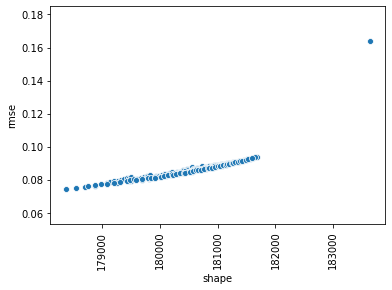

In [10]:
remove_df = temp_df.loc[temp_df['first'] < 5,:]
sns.scatterplot(x='shape', y='rmse', data=temp_df)
plt.xticks(rotation='vertical')
plt.show()

In [11]:
temp_df.sort_values('shape')

,outlier_list,rmse,first,second,shape
1,"[0.33, 0.33]",0.074418,0.33,0.33,178365
16,"[0.35, 0.33]",0.075134,0.35,0.33,178537
15,"[0.33, 0.35]",0.075731,0.33,0.35,178703
18,"[0.38, 0.33]",0.076160,0.38,0.33,178750
20,"[0.4, 0.33]",0.076793,0.40,0.33,178869
...,...,...,...,...,...
196,"[0.6, 0.58]",0.093108,0.60,0.58,181600
193,"[0.56, 0.6]",0.093247,0.56,0.60,181615
195,"[0.58, 0.6]",0.093500,0.58,0.60,181643
14,"[0.6, 0.6]",0.093869,0.60,0.60,181679


In [12]:
181679/183639

0.989326885901143

In [13]:
df_merge

,N_ValueRatio,N_life,N_zip_count,airconditioningtypeid,basementsqft,bedroomcnt,buildingqualitytypeid_fill,calculatedbathnbr,calculatedfinishedsquarefeet,finishedfloor1squarefeet,...,structuretaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxvaluedollarcnt,threequarterbathnbr,unitcnt_fill,yardbuildingsqft17,month,year,logerror
0,53.470371,59.0,14719.0,0,0.0,3.0,7,2.0,1684.0,NaN,...,122754.0,6735.879883,0,360170.0,0.0,1.0,NaN,1,0,0.027600
1,57.670425,4.0,17682.0,7,0.0,4.0,0,3.5,2263.0,NaN,...,346458.0,10153.019531,0,585529.0,1.0,4.0,NaN,1,0,-0.168400
2,10.440699,78.0,4422.0,0,0.0,2.0,7,3.0,2217.0,NaN,...,61994.0,11484.480469,0,119906.0,0.0,1.0,NaN,1,0,-0.004000
3,80.321709,31.0,7293.0,0,0.0,2.0,7,2.0,839.0,NaN,...,171518.0,3048.739990,0,244880.0,0.0,1.0,NaN,1,0,0.021800
4,79.168182,37.0,9875.0,7,0.0,4.0,7,2.5,2283.0,NaN,...,169574.0,5488.959961,0,434551.0,1.0,2.0,NaN,1,0,-0.005000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183634,60.682812,54.0,17169.0,7,0.0,4.0,0,2.0,1612.0,1612.0,...,50683.0,1107.479980,0,67205.0,0.0,2.0,656.0,9,1,0.013209
183635,60.682812,54.0,17169.0,7,0.0,4.0,0,2.0,1612.0,1612.0,...,50683.0,1107.479980,0,67205.0,0.0,2.0,656.0,9,1,0.013209
183636,60.682812,54.0,17169.0,7,0.0,4.0,0,2.0,1612.0,1612.0,...,50683.0,1107.479980,0,67205.0,0.0,2.0,656.0,9,1,0.013209
183637,56.531612,64.0,5666.0,0,0.0,3.0,7,1.0,1032.0,NaN,...,32797.0,876.429993,0,49546.0,0.0,1.0,NaN,9,1,0.037129


In [ ]:
# 0.6,0.6 0.4, 0.4